In [ ]:
! pip install nibabel
! pip install monai
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 11.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 9.1 MB/s 
     |████████████████████████████████| 182 kB 54.4 MB/s 
     |████████████████████████████████| 168 kB 56.1 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 168 kB 52.7 MB/s 
     |████████████████████████████████| 166 kB 53.7 MB/s 
     |████████████████████████████████| 166 kB 57.3 MB/s 
     |████████████████████████████████| 162 kB 53.8 MB/s 
     |████████████████████████████████| 162 kB 52.8 MB/s 
     |████████████████████████████████| 158 kB 60.1 MB/s 
     |████████████████████████████████| 157 kB 68.5 MB/s 
     |████

In [ ]:
import sys
import time
import os
import math
import collections
from collections import (Counter, defaultdict, deque, namedtuple)
import shutil
import os
import glob
from functools import partial
import random
import copy
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchsummary import summary

import gym
from gym import spaces

from tqdm import tqdm
import wandb

In [ ]:
from monai.utils import first, set_determinism
from monai.config import KeysCollection
from monai.transforms import (
    Transform,
    MapTransform,
    Randomizable,
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from monai.transforms.utils import generate_spatial_bounding_box

/usr/local/lib/python3.8/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/dist-packages/nibabel/quaternions.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  MAX_FLOAT = np.maximum_sctype(np.float)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Dataset

In [ ]:
class ApplyWindowing(MapTransform):
  def __init__(self, keys: KeysCollection, window_center, window_width):
      super().__init__(keys)
      self.window_center = window_center
      self.window_width = window_width
      self.pixel_low = self.window_center - self.window_width / 2
      self.pixel_high = self.window_center + self.window_width / 2

  def select(self, data):

      data = torch.where(data < self.pixel_low, self.pixel_low, data)
      data = torch.where(data > self.pixel_high, self.pixel_high, data)

      data_norm = (data - torch.min(data)) / (torch.max(data) - torch.min(data))

      return data_norm

  def __call__(self, img):
      d = dict(img)
      for key in self.key_iterator(d):
          d[key] = self.select(d[key])
      return d

class SelectTargetClass(MapTransform):
    def __init__(self, keys: KeysCollection, target_class):
        super().__init__(keys)
        self.keys = keys
        self.target_class = target_class

    def select(self, data):
        data[data != self.target_class] = 0
        data[data == self.target_class] = 1

        return data

    def __call__(self, img):
        d = dict(img)
        image, label = d['image'], d['label']
        seg_label = torch.clone(label)
        for key in self.key_iterator(d):
            label = self.select(d[key])
        return {'image': image, 'label': label, "seg_label": seg_label}


class GetBoundingBox(MapTransform):
    def __init__(self, keys: KeysCollection):
        super().__init__(keys)
        self.keys = keys

    def select(self, data):
        if len(data.size()) == 3:
          data = torch.unsqueeze(data, dim=0)

        box = generate_spatial_bounding_box(data)
        return box

    def __call__(self, img):
        d = dict(img)
        for key in self.key_iterator(d):
            d[key] = self.select(d[key])
        return d


class CT_DataLoader:
    def __init__(self, train_mode=True):

        self.train_mode = train_mode
        self.data_dir = config["data_dir"]
        self.batch_size = config["batch_size"]
        self.dataloader_size = config["dataloader_size"]

        self.folder_name = "Training"

        self.images = sorted(glob.glob(os.path.join(self.data_dir, self.folder_name, "img", "*.nii.gz")))
        self.labels = sorted(glob.glob(os.path.join(self.data_dir, self.folder_name, "label", "*.nii.gz")))

        if self.train_mode:

            self.images = self.images[0:self.dataloader_size]
            self.labels = self.labels[0:self.dataloader_size]

        else:

            self.images = self.images[self.dataloader_size:]
            self.labels = self.labels[self.dataloader_size:]

        self.data_size = len(self.images)

        self.data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(self.images, self.labels)
        ]

        self.transformed_data = Compose([
                    LoadImaged(keys=["image", "label"]),
                    ApplyWindowing(keys=["image"], window_center=40, window_width=400),
                    SelectTargetClass(keys=["label"], target_class = 6),
                    GetBoundingBox(keys=["label"]),
                    EnsureChannelFirstd(keys=["image"]),])

        self.dataset = Dataset(data=self.data_dicts, transform=self.transformed_data)
        #self.dataloader = DataLoader(self.dataset, batch_size=1, shffule=False)
        self.count = 0


    def sample_circular(self, id = None):
        '''
        return a  CT scan data from the dataloader
        '''

        # sample_batch = next(iter(self.dataloader))

        # # batch_size * h * w * d
        # image = sample_batch["image"][0]
        # # list: length 2
        # label = sample_batch["label"]
        data_size = len(self.dataset)
        if id == None:
          #idx = np.random.randint(data_size, size=1)[0]
          idx = self.count % self.data_size
          self.count += 1
        else:
          idx = id

        return self.dataset[idx]["image"], self.dataset[idx]["label"], idx

# Model




### Github Version Network3D (Multi-agent enabled))
(https://github.com/amiralansary/rl-medical/blob/77846906320af74af905463803960238e4daaa1b/examples/LandmarkDetection/MultiAgent/DQNModel.py)

In [ ]:
class Network3D(nn.Module):

    def __init__(self, hist_len, number_actions, xavier=True):
        super(Network3D, self).__init__()

        self.hist_len = hist_len
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")

        self.conv0 = nn.Conv3d(
            in_channels=hist_len,
            out_channels=32,
            kernel_size=(5, 5, 5),
            padding=1).to(
            self.device)
        self.maxpool0 = nn.MaxPool3d(kernel_size=(2, 2, 2)).to(self.device)
        self.prelu0 = nn.PReLU().to(self.device)
        self.conv1 = nn.Conv3d(
            in_channels=32,
            out_channels=32,
            kernel_size=(5, 5, 5),
            padding=1).to(
            self.device)
        self.maxpool1 = nn.MaxPool3d(kernel_size=(2, 2, 2)).to(self.device)
        self.prelu1 = nn.PReLU().to(self.device)
        self.conv2 = nn.Conv3d(
            in_channels=32,
            out_channels=64,
            kernel_size=(4, 4, 4),
            padding=1).to(
            self.device)
        self.maxpool2 = nn.MaxPool3d(kernel_size=(2, 2, 2)).to(self.device)
        self.prelu2 = nn.PReLU().to(self.device)
        self.conv3 = nn.Conv3d(
            in_channels=64,
            out_channels=64,
            kernel_size=(3, 3, 3),
            padding=0).to(
            self.device)
        self.prelu3 = nn.PReLU().to(self.device)

        self.fc1 = nn.Linear(in_features=int(config.in_features), out_features=256).to(self.device)
        self.prelu4 = nn.PReLU().to(self.device)
        self.fc2 = nn.Linear(in_features=256, out_features=128).to(self.device)
        self.prelu5 = nn.PReLU().to(self.device)
        self.fc3 = nn.Linear(in_features=128, out_features=number_actions).to(self.device)

        if xavier:
            for module in self.modules():
                if type(module) in [nn.Conv3d, nn.Linear]:
                    torch.nn.init.xavier_uniform(module.weight)

    def forward(self, input):
        """
        Input is a tensor of size
        (batch_size, agents, frame_history, *image_size)
        Output is a tensor of size
        (batch_size, agents, number_actions)
        """
        input = input.to(self.device)
        output = []

        # Shared layers
        x = input
        x = x.float()
        x = self.conv0(x)
        x = self.prelu0(x)
        x = self.maxpool0(x)
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        x = x.view(-1, int(config.in_features))

        # Individual layers
        x = self.fc1(x)
        x = self.prelu4(x)
        x = self.fc2(x)
        x = self.prelu5(x)
        output = self.fc3(x)

        return output.cpu()

# Experience Replay

In [ ]:
class ReplayMemory(object):
    def __init__(self, max_size, state_shape, history_len):
        self.max_size = int(max_size)
        self.state_shape = state_shape
        self.history_len = int(history_len)

        self.state = np.zeros(
            (self.max_size, ) + tuple(state_shape), dtype='float32')
        self.action = np.zeros((self.max_size), dtype='int32')
        self.reward = np.zeros((self.max_size), dtype='float32')
        self.isOver = np.zeros((self.max_size), dtype='bool')

        self._curr_pos = 0
        self._curr_size = 0

        # TODO: was maxlen = history_len - 1
        # Another deque to store the history frame as input to model
        self._hist = deque(maxlen=history_len)
        self.init_hist()

    def init_hist(self):
        self._hist.clear()
        for _ in range(self.history_len):
            self._hist.append(np.zeros(tuple(self.state_shape)))

    def append(self, exp):
        """Append the replay memory with experience sample
        Args:
            exp (Experience): contains (state, action, reward, isOver)
        """
        # increase current memory size if it is not full yet
        if self._curr_size < self.max_size:
            self._assign(self._curr_pos, exp)
            self._curr_pos = (self._curr_pos + 1) % self.max_size
            self._curr_size += 1
        else:
            self._assign(self._curr_pos, exp)
            self._curr_pos = (self._curr_pos + 1) % self.max_size
        if exp[3]:
            self.init_hist()
        else:
            self._hist.append(exp[0])

    def recent_state(self):
        """ return a list of (hist_len,) + STATE_SIZE """
        states = np.stack([self._hist[i] for i in range(self.history_len)], axis=0)
        return np.array(states)

    def _encode_sample(self, idx):
        """ Sample an experience replay from memory with index idx
        :returns: a tuple of (state, next_state, reward, action, isOver)
                  where state is of shape STATE_SIZE + (history_length,)
        """
        idx = (self._curr_pos + idx) % self._curr_size
        k = self.history_len

        if idx + k < self._curr_size:
            states = self.state[idx: idx + k]
            # ToCheck: Index out of boundary ??
            next_states = self.state[idx + 1: idx + k + 1]
            isOver = self.isOver[idx: idx + k]
            rewards = self.reward[idx: idx + k]
            actions = self.action[idx: idx + k]
        else:
            end = idx + k - self._curr_size
            states = self._slice(self.state, idx, end)
            next_states = self._slice( self.state, idx + 1, end + 1)
            isOver = self._slice(self.isOver, idx, end)
            rewards = self._slice(self.reward, idx, end)
            actions = self._slice(self.action, idx, end)

        states_padded = self._pad_sample(states, isOver)
        return states_padded, actions, rewards, next_states, isOver

    def sample(self, batch_size):
        # random generate index for sampling
        idxes = [np.random.randint(0, len(self) - 1)
                 for _ in range(batch_size)]
        states = []
        next_states = []
        rewards = []
        actions = []
        isOver = []
        for i in idxes:
            exp = self._encode_sample(i)
            states.append(exp[0])
            actions.append(exp[1])
            rewards.append(exp[2])
            next_states.append(exp[3])
            isOver.append(exp[4])

        # Only get most recent terminal state
        return (np.array(states), np.array(actions)[:, -1],
                np.array(rewards)[:, -1], np.array(next_states),
                np.array(isOver)[:, -1])

    # the next_state is a different episode if current_state.isOver==True
    def _pad_sample(self, states, isOver):
        for k in range(self.history_len - 1, -1, -1):
            if isOver[k]:
                states = copy.deepcopy(states)
                states[:k + 1].fill(0)
            break
        return states

    def _slice(self, arr, start, end):
        s1 = arr[start:self._curr_size]
        s2 = arr[:end]
        return np.concatenate((s1, s2), axis=0)

    def __len__(self):
        return self._curr_size

    def _assign(self, pos, exp):
        self.state[pos] = exp[0]
        self.action[pos] = exp[1]
        self.reward[pos] = exp[2]
        self.isOver[pos] = exp[3]

    def __str__(self):
        return f"""Replay buffer:
         Current position / current size: {self._curr_pos}/{self._curr_size}
         states {[hash(str(self.state[i]))
                    for i in range(len(self.state))]}
         actions {self.action}
         rewards {self.reward}
         isOver {self.isOver}"""

# Environment

In [ ]:
Rectangle = namedtuple('Rectangle', ['xmin', 'xmax', 'ymin', 'ymax', 'zmin', 'zmax'])

In [ ]:
class MedicalPlayer(gym.Env):
    """Class that provides 3D medical image environment.
    This is just an implementation of the classic "agent-environment loop".
    Each time-step, the agent chooses an action, and the environment returns
    an observation and a reward."""

    def __init__(self, train_mode=True, screen_dims=(45, 45, 45),
                 history_length= 4, action_step_ratio=0.1, min_action_len=10,
                 reward_method='binary', oscillations_allowed=4, logger=None, id = None):
        """
        :param train_directory: environment or game name
        :param viz: visualization
            set to 0 to disable
            set to +ve number to be the delay between frames to show
            set to a string to be the directory for storing frames
        :param screen_dims: shape of the frame cropped from the image to feed
            it to dqn (d,w,h) - defaults (27,27,27)
        :param nullop_start: start with random number of null ops
        :param location_history_length: consider lost of lives as end of
            episode (useful for training)
        :max_num_frames: maximum number of frames per episode.
        """
        super(MedicalPlayer, self).__init__()
        self.oscillations_allowed = oscillations_allowed
        self.logger = logger
        self.actions_meaning = self.get_action_meanings()
        # inits stat counters+
        self.reset_stat()

        # counter to limit number of steps per episodes
        self.cnt = 0

        # stores information: terminal, score, distError
        self.info = None

        # training flag
        self.train_mode = train_mode

        # image dimension (3D: (45, 45, 45))
        self.screen_dims = screen_dims
        self.dims = len(self.screen_dims)

        # how much scale to move for each action
        self.action_step_ratio = action_step_ratio


        # the minimum length for each bounding box axis below which no action whill be performed
        self.min_action_len = min_action_len

        # init env dimensions
        self.width, self.height, self.depth = screen_dims

        # how to calculate reward
        self.reward_method = reward_method

        # stat counter to store current score or accumlated reward
        # self.current_episode_score = [StatCounter()] * self.num_agents

        # get action space and minimal action set
        self.action_space = spaces.Discrete(11)  # change number actions here
        self.actions = self.action_space.n
        self.observation_space = spaces.Box(low=0, high=255,
                                            shape=self.screen_dims,
                                            dtype=np.uint8)

        # history buffer for storing last locations to check oscilations
        self._history_length = history_length
        self._loc_history = [((0,) * self.dims, (0,) * self.dims) for _ in range(self._history_length)]
        self._qvalues_history = [(0,) * self.actions for _ in range(self._history_length)]


        # add data loader
        self.files = CT_DataLoader(self.train_mode)

        # prepare file sampler
        self.filepath = None

        # define the ternimate iou score
        self.terminate_iou = config.init_terminate_iou
        self.terminate_iou_step = config.terminate_iou_step
        self.max_terminate_iou = config.max_terminate_iou

        # reset buffer, terminal, counters, and init new_random_game
        # self._restart_episode()


    def reset(self, id = None):
        # with _ALE_LOCK:
        self._restart_episode(id = id)
        return self._current_state()

    def _restart_episode(self, id = None):
        """
        restart current episode
        """
        self.sampled_files = self.files.sample_circular(id = id)
        self.terminal = False
        self.reward = 0
        self.cnt = 0  # counter to limit number of steps per episodes
        # self.num_games.feed(1)

        self._loc_history = [((0,) * self.dims, (0,) * self.dims) for _ in range(self._history_length)]

        # list of q-value lists
        self._qvalues_history = [(0,) * self.actions for _ in range(self._history_length)]

        # for i in range(0, self.num_agents):
        #     self.current_episode_score.reset()

        self.new_random_game()

    def new_random_game(self):
        """
        load image,
        set dimensions,
        randomize start point,
        init _screen, qvals,
        calc distance to goal
        """
        self.terminal = False
        self.viewer = None

        # sample a new image
        self._image, self._target_loc, self.image_idx  = self.sampled_files

        # print(self._image.min(), self._image.max())
        # TODO: add it as a parameter to the class
        cover_percent = config.init_converage_percent

        # H * W * D
        batch_size, self.image_height, self.image_width, self.image_depth = self._image.shape

        # start coordinates pf bounding box
        x1 = int(self.image_height * round((1 - cover_percent), 1)/2)
        y1 = int(self.image_width * round((1 - cover_percent), 1)/2)
        z1 = int(self.image_depth * round((1 - cover_percent), 1)/2)

        # end coordiates of bounding box
        x2 = self.image_height - x1
        y2 = self.image_width - y1
        z2 = self.image_depth - z1

        # image volume size
        self._image_dims = self._image[0].shape

        #######################################################################

        self._location = ((x1, y1, z1), (x2, y2, z2))
        self._box_image = self._image[:, self._location[0][0]:self._location[1][0]+1, self._location[0][1]:self._location[1][1]+1, self._location[0][2]:self._location[1][2]+1].squeeze(0)
        self._start_location = ((x1, y1, z1), (x2, y2, z2))
        self._qvalues = [0, ] * self.actions

        self._screen = self._current_state()

        self.curr_iou = self.calcIou(self._location, self._target_loc)
        self.init_iou = self.curr_iou

    def calcIou(self, box1, box2):
        """
        calculate the IOU between two bounding boxes in mm
        box1: current loc of bounding box
        box2: target loc of bounding box
        """

        (start_c, end_c) = box1
        (x1_c, y1_c, z1_c) = start_c
        (x2_c, y2_c, z2_c) = end_c

        (start_t, end_t) = box2
        (x1_t, y1_t, z1_t) = start_t
        (x2_t, y2_t, z2_t) = end_t

        x_diff = max(min(x2_t, x2_c) - max(x1_t, x1_c), 0)
        y_diff = max(min(y2_t, y2_c) - max(y1_t, y1_c), 0)
        z_diff = max(min(z2_t, z2_c) - max(z1_t, z1_c), 0)

        intersect_v = x_diff * y_diff * z_diff
        box1_v = abs(x2_c - x1_c) * abs(y2_c - y1_c) * abs(z2_c - z1_c)
        box2_v = abs(x2_t - x1_t) * abs(y2_t - y1_t) * abs(z2_t - z1_t)

        union_v = box1_v + box2_v - intersect_v

        return intersect_v / union_v

    def update_ternimate_iou(self):

        self.terminate_iou = min(self.terminate_iou_step + self.terminate_iou, self.max_terminate_iou)

    def step(self, act, q_values):
        """
        The environment's step function returns exactly what we need.
        Args:
          act:
        Returns:
          observation (object):
            an environment-specific object representing your observation of
            the environment. For example, pixel data from a camera, joint
            angles and joint velocities of a robot, or the board state in a
            board game.
          reward (float):
            amount of reward achieved by the previous action. The scale varies
            between environments, but the goal is always to increase your total
            reward.
          done (boolean):
            whether it's time to reset the environment again. Most (but not
            all) tasks are divided up into well-defined episodes, and done
            being True indicates the episode has terminated. (For example,
            perhaps the pole tipped too far, or you lost your last life.)
          info (dict):
            diagnostic information useful for debugging. It can sometimes be
            useful for learning (for example, it might contain the raw
            probabilities behind the environment's last state change). However,
            official evaluations of your agent are not allowed to use this for
            learning.
        """
        self._qvalues = q_values
        current_loc = self._location
        next_location = copy.deepcopy(current_loc)

        self.terminal = False
        go_out = False

        # take a step of action for agent i

        # print(f"current_loc: {current_loc}")
        # print(f"Taking action {self.actions_meaning[act[0]]}")
        x1, y1, z1 = current_loc[0]
        x2, y2, z2 = current_loc[1]

        x_step = min(round((x2 - x1) * self.action_step_ratio) if x2 - x1 > self.min_action_len else 1, config.max_action_step)
        y_step = min(round((y2 - y1) * self.action_step_ratio) if y2 - y1 > self.min_action_len else 1, config.max_action_step)
        z_step = min(round((z2 - z1) * self.action_step_ratio) if z2 - z1 > self.min_action_len else 1, config.max_action_step)

        # UP Z+ -----------------------------------------------------------
        if (act == 0):
            next_location = ((x1, y1, round(z1 + z_step)),
                                (x2, y2, round(z2 + z_step)))

        # FORWARD Y+ ------------------------------------------------------
        if (act == 1):
            next_location = ((x1, round(y1 + y_step), z1),
                                (x2, round(y2 + y_step), z2))

        # RIGHT X+ --------------------------------------------------------
        if (act == 2):
            next_location = ((round(x1 + x_step), y1, z1),
                                (round(x2 + x_step), y2, z2))

        # LEFT X- ---------------------------------------------------------
        if act == 3:
            next_location = ((round(x1 - x_step), y1, z1),
                                (round(x2 - x_step), y2, z2))

        # BACKWARD Y- -----------------------------------------------------
        if act == 4:
            next_location = ((x1, round(y1 - y_step), z1),
                                (x2, round(y2 - y_step), z2))


        # DOWN Z- ---------------------------------------------------------
        if act == 5:
            next_location = ((x1, y1, round(z1 - z_step)),
                                (x2, y2, round(z2 - z_step)))

        # scaling s+ ---------------------------------------------------------
        if act == 6:
            next_location = ((round(x1 - x_step / 2),
                                    round(y1 - y_step / 2),
                                    round(z1 - z_step / 2)),
                                (round(x2 + x_step / 2),
                                    round(y2 + y_step / 2),
                                    round(z2 + z_step / 2)))

        # scaling s- ---------------------------------------------------------
        if act == 7:
            next_location = ((round(x1 + x_step / 2),
                                    round(y1 + y_step / 2),
                                    round(z1 + z_step / 2)),
                                (round(x2 - x_step / 2),
                                    round(y2 - y_step / 2),
                                    round(z2 - z_step / 2)))

        # deformation dx (thinner) ---------------------------------------------------------
        if act == 8:
            next_location = ((round(x1 - x_step / 2), y1, z1),
                                (round(x2 + x_step / 2), y2, z2))

        # deformation dy (flatter)---------------------------------------------------------
        if act == 9:
            next_location = ((x1, round(y1 - y_step / 2), z1),
                                (x2, round(y2 + y_step / 2), z2))

        # deformation dz (taller) ---------------------------------------------------------
        if act == 10:
            next_location = ((x1, y1, round(z1 - z_step)),
                                (x2, y2, round(z2 + z_step)))

        # check if the bounding box is out of bound
        if (next_location[1][2] >= self.image_depth or
            next_location[1][1] >= self.image_height or
            next_location[1][0] >= self.image_width or
            next_location[0][0] <= 0 or
            next_location[0][1] <= 0 or
            next_location[0][2] <= 0):

            next_location = ((max(0, next_location[0][0]),
                                    max(0, next_location[0][1]),
                                    max(0, next_location[0][2])),
                                (min(self.image_width - 1, next_location[1][0]),
                                    min(self.image_height - 1, next_location[1][1]),
                                    min(self.image_depth - 1, next_location[1][2])))
            go_out = True

        #######################################################################

        # update screen, curr_image, reward ,location, terminal
        self._location = next_location
        self._box_image = self._image[:, self._location[0][0]:self._location[1][0]+1, self._location[0][1]:self._location[1][1]+1, self._location[0][2]:self._location[1][2]+1].squeeze(0)
        self._screen = self._current_state()

        # calculate current iou for the new bounding box location
        self.curr_iou = self.calcIou(self._location, self._target_loc)
        # print(self.curr_iou)

        # ternimate game if the current iou is above the terminate treshold
        if self.curr_iou > self.terminate_iou:
            self.terminal = True

        # punish -1 reward if the agent tries to go out
        if go_out:
            self.reward = config.go_out_reward
        # else calculating rewards for each agent
        elif self.terminal:
            self.reward = config.terminal_reward
        else:
            self.reward = self._calc_reward(current_loc, next_location)

        self._update_history()

        # update the current game info
        info = {}
        info[f"reward"] = self.reward
        info[f"complete_game"] = 1 if self.terminal else 0
        info[f"iou_score"] = self.curr_iou
        info[f"go_out"] = go_out
        info[f"image_idx"] = self.image_idx
        info[f"init_iou"] = self.init_iou

        info[f"agent_xpos"] = (self._location[0][0], self._location[1][0])
        info[f"agent_ypos"] = (self._location[0][1], self._location[1][1])
        info[f"agent_zpos"] = (self._location[0][2], self._location[1][2])
        info[f"landmark_xpos"] = (self._target_loc[0][0], self._target_loc[1][0])
        info[f"landmark_ypos"] = (self._target_loc[0][1], self._target_loc[1][1])
        info[f"landmark_zpos"] = (self._target_loc[0][2], self._target_loc[1][2])

        return self._screen, self.reward, self.terminal, info

    def getBestLocation(self):
        ''' get best location with best qvalue from last for locations
        stored in history
        '''
        best_locations = []

        last_qvalues_history = self._qvalues_history[-4:]
        last_loc_history = self._loc_history[-4:]
        best_qvalues = np.max(last_qvalues_history, axis=1)
        best_idx = best_qvalues.argmin()
        best_locations.append(last_loc_history[best_idx])

        return best_locations

    def _clear_history(self):
        ''' clear history buffer with current states
        '''
        self._loc_history = [((0,) * self.dims, (0,) * self.dims) for _ in range(self._history_length)]
        self._qvalues_history = [(0,) * self.actions for _ in range(self._history_length)]

    def _update_history(self):
        ''' update history buffer with current states
        '''
        # update location history
        self._loc_history.pop(0)
        self._loc_history.insert(
            len(self._loc_history), self._location)

        # update q-value history
        self._qvalues_history.pop(0)
        self._qvalues_history.insert(
            len(self._qvalues_history), self._qvalues)

    def _current_state(self):
        """
        wrap image data around current location to update what network sees.
        update rectangle
        :return: new state
        """
        # initialize screen with zeros - all background
        screen = np.zeros(
            (self.screen_dims[0],
             self.screen_dims[1],
             self.screen_dims[2]))

        theta_x = 1
        theta_y = 1
        theta_z = 1

        # define the theta metric for affine transformation
        theta = torch.tensor([[theta_x, 0, 0, 0],
                              [0, theta_y, 0, 0],
                              [0, 0, theta_z, 0]], dtype=torch.float)

        # convert the observation into size [batch_size, channel, D, H, W]
        H = self._location[1][0] - self._location[0][0] + 1# x2 - x1
        W = self._location[1][1] - self._location[0][1] + 1# y2 - y1
        D = self._location[1][2] - self._location[0][2] + 1# z2 - z1

        observation = torch.permute(self._box_image, (2, 0, 1)).view(1, 1, D, H, W)
        grid = F.affine_grid(theta=theta.unsqueeze(0), size=(1, 1) + self.screen_dims)
        output = F.grid_sample(input=observation, grid=grid, mode= "bilinear")

        # convert the output shape back to H x W x D
        screen = torch.permute(output.view(self.screen_dims[0], self.screen_dims[1], self.screen_dims[2]), (1, 2, 0))

        return screen.cpu()

    def _calc_reward(self, current_loc, next_loc):
        """
        Calculate the new reward based on the increase in IOU to
        the target location
        """
        curr_iou = self.calcIou(current_loc, self._target_loc)
        next_iou = self.calcIou(next_loc, self._target_loc)

        if self.reward_method == 'binary':
            return  1 if next_iou > curr_iou else -1
        elif self.reward_method == 'iou_diff':
            return config.iou_reward_scale * (next_iou - curr_iou)

    @property
    def _oscillate(self):
        """ Return True if all num_agents are stuck and oscillating
        """
        counter = Counter(self._loc_history)
        freq = counter.most_common()
        # At beginning of episodes, history is prefilled with (0, 0, 0),
        # thus do not count their frequency
        if freq[0][0] == (0, 0, 0):
            if len(freq) < self.oscillations_allowed:
                return False
            if freq[1][1] < self.oscillations_allowed:
                return False
        elif freq[0][1] < self.oscillations_allowed:
            return False
        return True

    def get_action_meanings(self):
        """ return array of integers for actions"""
        ACTION_MEANING = {
            0: "UP",  # MOVE Z+
            1: "FORWARD",  # MOVE Y+
            2: "RIGHT",  # MOVE X+
            3: "LEFT",  # MOVE X-
            4: "BACKWARD",  # MOVE Y-
            5: "DOWN",  # MOVE Z-
            6: "SCALE UP",
            7: "SCALE_DOWN",
            8: "THINNER",
            9: "FLATTER",
            10: "TALLER"
        }
        return ACTION_MEANING

    @property
    def getScreenDims(self):
        """
        return screen dimensions
        """
        return (self.width, self.height, self.depth)

    def lives(self):
        return None

    def reset_stat(self):
        """ Reset all statistics counter"""
        self.stats = defaultdict(list)
        # self.num_games = StatCounter()
        # self.num_success = [StatCounter()] * int(self.num_agents)

## Wrapper (Frame Stack)

In [ ]:
class FrameStack(gym.Wrapper):
    """used when not training. wrapper for Medical Env"""
    def __init__(self, env, k):
        """Buffer observations and stack across channels (last axis)."""
        gym.Wrapper.__init__(self, env)
        self.k = k  # history length
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape # (90, 90, 90)

        self._base_dim = len(shp)
        new_shape = (k, ) + shp # (1, 4, 90, 90, 90)
        self.observation_space = spaces.Box(low=0, high=255, shape=new_shape,
                                            dtype=np.uint8)

    def reset(self, id = None):
        """Clear buffer and re-fill by duplicating the first observation."""
        obs = self.env.reset(id = id)
        for _ in range(self.k - 1):
            self.frames.append(torch.zeros_like(obs))
        self.frames.append(obs)
        return self._observation()

    def step(self, action, q_values):
        obs, reward, done, info = self.env.step(action, q_values)
        # when exceed its max_len, deque will automatially pop from its left
        self.frames.append(obs)
        return self._observation(), reward, done, info

    def _observation(self):
        assert len(self.frames) == self.k
        return torch.stack([self.frames[i] for i in range(self.k)], axis=0)
        # if self._base_dim == 2:
        #     return np.stack(self.frames, axis=-1)
        # else:
        #     return np.concatenate(self.frames, axis=2)

# Sample Trajectory

### Agents

In [ ]:
class Agents:
    def __init__(self, num_actions, hist_len, max_memory_size, state_shape):

        self.num_actions = num_actions
        self.hist_len = hist_len
        self.max_memory_size = max_memory_size
        self.state_shape = state_shape

        # q networks
        self.q_network = Network3D(self.hist_len, self.num_actions).float().to(config.device)
        self.target_network = Network3D(self.hist_len, self.num_actions).float().to(config.device)

        self.copy_to_target_network()

        # Freezes target network
        self.target_network.train(False)
        for p in self.target_network.parameters():
            p.requires_grad = False

        # Define the optimiser which is used when updating the Q-network. The
        # learning rate determines how big each gradient step is during
        # backpropagation.
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=config.lr)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, config.gamma, last_epoch=- 1, verbose=False)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def copy_to_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save_model(self, model_name="dqn.pt"):
        if not os.path.exists(config.model_folder):
            os.makedirs(config.model_folder)
        model_path = os.path.join(config.model_folder, model_name)
        print("")
        print(f"Save model weight to {model_path}")
        torch.save(self.q_network.state_dict(), model_path)

    def load_model(self, model_path):
        model_weight = torch.load(model_path)
        self.q_network.load_state_dict(model_weight)
        print(f"Load model weight from {model_path}")

    # Function that is called whenever we want to train the Q-network. Each
    # call to this function takes in a transition tuple containing the data we
    # use to update the Q-network.
    def train_q_network(self, transitions, discount_factor):
        # Set all the gradients stored in the optimiser to zero.
        self.optimizer.zero_grad()
        # Calculate the loss for this transition.
        loss = self._calculate_loss(transitions, discount_factor)
        # Compute the gradients based on this loss, i.e. the gradients of the
        # loss with respect to the Q-network parameters.
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        # Take one gradient step to update the Q-network.
        self.optimizer.step()
        return loss.item()

    # Function to calculate the loss for a particular transition.
    def _calculate_loss(self, transitions, discount_factor):
        '''
        Transitions are tuple of shape
        (states, actions, rewards, next_states, dones)
        '''
        curr_state = torch.tensor(transitions[0])
        rewards = torch.tensor(transitions[2])
        next_state = torch.tensor(transitions[3])
        terminal = torch.tensor(transitions[4]).type(torch.int)

        #rewards = torch.clamp(torch.tensor(transitions[2], dtype=torch.float32), -1, 1)

        y = self.target_network.forward(next_state)
        # dim (batch_size, agents, num_actions)
        y = y.view(-1, self.num_actions)
        # Get the maximum prediction for the next state from the target network
        max_target_net = y.max(-1)[0]
        # dim (batch_size, agents, num_actions)
        network_prediction = self.q_network.forward(curr_state).view(-1, self.num_actions)
        isNotOver = (torch.ones(*terminal.shape) - terminal)
        # Bellman equation
        batch_labels_tensor = rewards + isNotOver * \
            (discount_factor * max_target_net.detach())

        # td_errors = (network_prediction -
        # batch_labels_tensor.unsqueeze(-1)).detach() # TODO td error needed
        # for exp replay

        actions = torch.tensor(transitions[1], dtype=torch.long).unsqueeze(-1)
        y_pred = torch.gather(network_prediction, -1, actions).squeeze()

        # Update transitions' weights
        # self.buffer.recompute_weights(transitions, td_errors)

        return self.loss_fn(batch_labels_tensor.flatten(), y_pred.flatten())

    def get_greedy_actions(self, obs_stack, doubleLearning=True):
        inputs = torch.tensor(obs_stack).unsqueeze(0)

        # print(inputs.shape)
        if doubleLearning:
            q_vals = self.q_network.forward(inputs).detach().squeeze(0)
        else:
            q_vals = self.target_network.forward(
                inputs).detach().squeeze(0)
        idx = torch.max(q_vals, -1)[1]

        return idx, q_vals.data.numpy()

    def get_next_actions(self, obs_stack, epsilon):
        # epsilon-greedy policy
        if np.random.random() < epsilon:
            q_values = np.zeros((self.num_actions))
            actions = np.random.randint(self.num_actions)
        else:
            actions, q_values = self.get_greedy_actions(
                obs_stack, doubleLearning=True)

        return int(actions), q_values

# Training

In [ ]:
from datetime import datetime
import torch
import os
import sys
import logging
import numpy as np
from tqdm import tqdm

In [ ]:
def set_reproducible():
    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(0)

In [ ]:
import logging

def prepare_logger():
    time_stamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    log_path = os.path.join(config.log_folder, time_stamp + "_" + config.log_file)

    if not os.path.exists(config.log_folder):
        os.makedirs(config.log_folder)
        print("Create logger folder")

    logger = logging.getLogger()
    logger.handlers = []
    file_handler = logging.FileHandler(log_path)
    console_handler = logging.StreamHandler(sys.stdout)
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    logger.setLevel(logging.WARN)

    logger.warning("starting logger")

    return logger, log_path

## Init buffer

In [ ]:
import pandas as pd

def init_buffer(env, agents, buffer, epsilon, init_memory_size=None):

    if init_memory_size is None:
        init_memory_size = buffer.max_size

    pbar = tqdm(desc=f"Collect {init_memory_size} experience trajectories in replay buffer", total=init_memory_size)
    image_idx_count = []

    while len(buffer) < init_memory_size:

        # reset the environment at the beginning of the episode.
        obs = env.reset()
        terminal = False
        steps = 0

        for _ in range(config.max_steps):
            steps += 1
            acts, q_values = agents.get_next_actions(obs, epsilon)
            obs, reward, terminal, info = env.step(acts, q_values)
            buffer.append((obs[-1, :, :, :], acts, reward, terminal))

            if terminal:
                break

        image_idx_count.append(info["image_idx"])

        pbar.update(steps)

    pbar.close()

    image_idx_dict = pd.Series(image_idx_count).value_counts()

    print(f"Init buffer image count: {image_idx_dict}")

## Trian

In [ ]:
epoch = 4
min(int((epoch + 1) / 2), 5)

2

In [ ]:
def train(env, evaluator, agents, buffer, epoch, logger=None, best_val_iou=0):

    cum_scores = []
    cum_iou = []
    cum_complete_game = []
    cum_go_out = []
    cum_step_num = []
    cum_improve_num = []

    for episode in tqdm(range(1, config.num_episode + 1)):
        # reset the environment at the beginning of the episode.
        obs = env.reset()
        buffer.init_hist()
        terminal = False
        losses = []

        decay_factor = min(int(epoch + 1 / 2), 5)

        epsilon = config.epsilon_min + (config.epsilon_start - config.epsilon_min) \
                  * np.exp(-1 * episode / config.num_episode * decay_factor)

        episode_score = 0
        go_out_count = 0
        improve_count = 0

        for step_num in range(1, config.max_steps + 1):

            # step the agent once, and get the transition tuple
            # index = buffer.append_obs(obs)

            acts, q_values = agents.get_next_actions(buffer.recent_state(), epsilon)
            next_obs, reward, terminal, info = env.step(np.copy(acts), q_values)
            buffer.append((next_obs[-1, :, :, :], acts, reward, terminal))

            episode_score += reward
            go_out_count = go_out_count + 1 if info['go_out'] else go_out_count
            improve_count = improve_count + 1 if reward > 0 else improve_count

            if terminal:
                break

        cum_scores.append(episode_score / step_num)
        cum_go_out.append(go_out_count / step_num)
        cum_improve_num.append(improve_count / step_num)
        cum_iou.append(info['iou_score'])
        cum_complete_game.append(info['complete_game'])
        cum_step_num.append(step_num)

        # train primary q network
        if episode % config.train_frequency  == 0:

            # states, actions, rewards, next_states, terminal
            mini_batch = buffer.sample(config.batch_size)
            loss = agents.train_q_network(mini_batch, config.discount_factor)
            losses.append(loss)

            print_score = round(np.mean(cum_scores), 2)
            print_iou = round(np.mean(cum_iou), 3)
            print_terminal = round(np.mean(cum_complete_game), 3)
            print_go_out = round(np.mean(cum_go_out), 3)
            print_improve_count = round(np.mean(cum_improve_num), 2)
            print_step_num = round(np.mean(cum_step_num), 2)

            current_lr = agents.scheduler.get_lr()[0]

            msg = f"[{episode}] epsilon: {round(epsilon, 3)}, lr: {round(current_lr, 6)}, loss: {round(loss, 3)}, score: {print_score}, iou: {print_iou}, complete game: {print_terminal}, go out: {print_go_out}, improve: {print_improve_count}, step num: {print_step_num}"
            logger.warn(msg)
            print(msg)

            cum_scores = []
            cum_iou = []
            cum_complete_game = []
            cum_go_out = []
            cum_step_num = []
            cum_improve_num = []

        # decay learning rate
        if (episode >= config.lr_decay_episode) and (episode % config.lr_update == 0) and (agents.scheduler.get_lr()[0] > config.min_lr):
            agents.scheduler.step()

        # save the model weight
        if episode % config.save_frequency == 0:
            # best_val_iou, totol_rewards = validation_epoch(evaluator, agents, best_val_iou)
            weight_file_name = f"{config.model_name}_e{epoch}_ep{episode}.pt"
            agents.save_model(weight_file_name)

        if episode % config.validate_frequency == 0:
            best_val_iou, totol_rewards = validation_epoch(evaluator, agents, best_val_iou)

        # update target network weight
        if episode % config.update_frequency == 0:
            agents.copy_to_target_network()
            logger.warn(f"Copied weight to target Q netwrok at episode {episode}")

    return best_val_iou

## Evaluator

In [ ]:
train_idx = list(range(25))
test_idx = list(range(6))

file_name = ["img0001.nii.gz", "img0007.nii.gz", "img0023.nii.gz", "img0029.nii.gz", "img0035.nii.gz",
"img0002.nii.gz", "img0008.nii.gz", "img0024.nii.gz", "img0030.nii.gz", "img0036.nii.gz",
"img0003.nii.gz", "img0009.nii.gz", "img0025.nii.gz", "img0031.nii.gz", "img0037.nii.gz",
"img0004.nii.gz", "img0010.nii.gz", "img0026.nii.gz", "img0032.nii.gz", "img0038.nii.gz",
"img0005.nii.gz", "img0021.nii.gz", "img0027.nii.gz", "img0033.nii.gz", "img0039.nii.gz",
"img0006.nii.gz", "img0022.nii.gz", "img0028.nii.gz", "img0034.nii.gz", "img0040.nii.gz"]

train_file_dict = dict(zip(train_idx, file_name[: train_idx[-1]]))
test_file_dict = dict(zip(test_idx, file_name[train_idx[-1]:]))

In [ ]:
import matplotlib.pyplot as plt

class Evaluator(object):
    def __init__(self, environment, agents, max_steps, logger = None):
        self.env = environment
        self.agents = agents
        self.logger = logger
        self.max_steps = max_steps

    def play_one_episode(self, img_id, render=False, frame_history=4):

        obs_stack = self.env.reset(id = img_id)
        # Here obs have shape (agent, *image_size, frame_history)
        sum_r = 0
        isOver = False
        start_dists = None
        q_values = None
        terminal_iou = 0

        for step in range(1, self.max_steps + 1):
            if terminal_iou > config.validate_terminal_iou:
                break

            acts, q_values = self.agents.get_greedy_actions(obs_stack)
            obs_stack, r, isOver, info = self.env.step(acts, q_values)
            terminal_iou = info["iou_score"]
            # if render
            if start_dists is None:
                start_dists = info['init_iou']
                print(f"Initial IOU: {info['init_iou']}")
            #     self.env.render()
            if not isOver:
                sum_r += r

        return sum_r / step, start_dists, q_values, info

    def plot_one_episode(self, img_id, render=False, frame_history=4, plot_frame=100, train_mode=True):

        plt.figure(figsize=(15, 25))

        file_name = train_file_dict[img_id] if train_mode else test_file_dict[img_id]

        obs_stack = self.env.reset(id = img_id)
        sampled_files = self.env.files.sample_circular(id = img_id)
        # Here obs have shape (agent, *image_size, frame_history)
        sum_r = 0
        isOver = False
        start_dists = None
        terminal_iou = 0

        for steps in range(1, self.max_steps + 1):
            if terminal_iou > config.validate_terminal_iou:
                break

            acts, q_values = self.agents.get_greedy_actions(obs_stack)
            obs_stack, r, isOver, info = self.env.step(acts, q_values)

            xt_1, xt_2 = info[f"landmark_ypos"]
            yt_1, yt_2 = info[f"landmark_xpos"]
            zt_1, zt_2 = info[f"landmark_zpos"]
            xa_1, xa_2 = info[f"agent_ypos"]
            ya_1, ya_2 = info[f"agent_xpos"]
            za_1, za_2 = info[f"agent_zpos"]

            ncol = 3
            nrow = math.ceil(self.max_steps / ncol)

            ax = plt.subplot(nrow, ncol, steps)
            ax.imshow(sampled_files[0][0, :, :, plot_frame], cmap='gray', interpolation=None)

            #add rectangle to plot
            ax.add_patch(patches.Rectangle((xt_1, yt_1), xt_2 - xt_1, yt_2 - yt_1 , linewidth=1.5, linestyle='-', edgecolor='r', facecolor='none'))
            ax.add_patch(patches.Rectangle((xa_1, ya_1), xa_2 - xa_1, ya_2 - ya_1 , linewidth=1.5, linestyle='-.', edgecolor='g', facecolor='none'))

            action_dict = env.get_action_meanings()

            ax.set_title(f"[{steps}] Action: {action_dict[acts.item()]}, IoU: {round(info['iou_score'], 3)}")

            # if render
            if start_dists is None:
                start_dists = info['init_iou']
                print(f"Initial IOU: {info['init_iou']}")
            #     self.env.render()
            if not isOver:
                sum_r += r

        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.suptitle(f"Trajectory for {file_name}, Target: ([{xt_1}, {yt_1}, {zt_1}], [{xt_2}, {yt_2}, {zt_2}]), Predict: ([{xa_1}, {ya_1}, {za_1}], [{xa_2}, {ya_2}, {za_2}])", fontsize=16)
        plt.subplots_adjust(top=0.95)

        return sum_r / steps, start_dists, q_values, info

In [ ]:
def validation_epoch(evaluator, agents, best_val_iou):
    agents.q_network.train(False)
    epoch_ious = []
    epoch_rewards = []
    totol_rewards = 0
    for k in range(len(evaluator.env.files.dataset)):
        print(f"Image id: {k}")
        (rewards, start_dists, q_values, info) = evaluator.play_one_episode(img_id = k)
        epoch_ious.append(info['iou_score'])
        epoch_rewards.append(rewards)
        print(f"Terminal iou score {info['iou_score']}")
        print(f"Current image rewards {rewards}")
        totol_rewards += rewards
    # val_dists = self.append_epoch_board(epoch_distances, name="eval",
    #                                     episode=episode)

    if (np.sum(epoch_ious) > best_val_iou):
        # self.logger.log("Improved new best mean validation distances")
        best_val_iou = np.sum(epoch_ious)

        # TODO: Also need to save optimizer, lr_scheduler, config
        agents.save_model(model_name="best_dqn.pt")
    agents.q_network.train(True)

    avg_iou = np.mean(epoch_ious)
    avg_reward = totol_rewards / len(evaluator.env.files.dataset)
    print(f"Average IoU: {avg_iou}, average reward: {avg_reward}")

    return best_val_iou, totol_rewards, epoch_ious, epoch_rewards

## Training config

In [ ]:
import math

# Dataset
# config.data_dir = "/Users/kexinyang/Desktop/HDSC 325/Project/data"
# config.data_dir = "/content/gdrive/MyDrive/2022 Fall/capstone/RawData"
from easydict import EasyDict as edict
import torch

time_stamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

config = edict()

config.time_stamp = time_stamp

# Dataset
config.data_dir = "/content/gdrive/MyDrive/Courses/HDSC 325/RawData"
config.model_folder =  "/content/gdrive/MyDrive/Courses/HDSC 325/Project/model/" + config.time_stamp
config.model_name = "model"
config.log_folder = "/content/gdrive/MyDrive/Courses/HDSC 325/Project/log"
config.log_file = 'log.log'

# Dataset
# config.data_dir = "/Users/kexinyang/Desktop/HDSC 325/Project/data/RawData"
config.dataset = ""
config.batch_size = 8
config.dataloader_size = 24

# Training parameter
config.device = "cuda" if torch.cuda.is_available() else "cpu"
config.training = True
config.ad_hoc_structure = False
config.epsilon_exp = True
config.soft_max = False

# Reply buffer
config.max_memory_size = 1000

# Environment
config.screen_dims = (90, 90, 90)
config.max_steps = 15
config.init_terminate_iou = 0.625
config.terminate_iou_step = 0.025
config.max_terminate_iou = 0.85
config.validate_terminal_iou = 0.75
config.action_step_ratio = 0.1
config.max_action_step = 10
config.min_action_len = 10
config.history_length = 4
config.num_actions = 11
config.init_converage_percent = 0.50

# DQN Training
config.in_features = int(512 * math.pow(config.screen_dims[0] / 45, 2) * math.pow(config.screen_dims[0] / 45, 2) * math.pow(config.screen_dims[0] / 45, 2))
config.lr = 5e-5
config.lr_decay_episode = 0
config.lr_update = 500
config.min_lr = 1e-6
config.gamma = 0.9 # step size for lr scheduler
config.discount_factor = 0.9

# Reward Function
config.reward_method = 'iou_diff'
config.iou_reward_scale = 100
config.terminal_reward = 10
config.go_out_reward = -10

config.start_iter = 2
config.num_epoch = 30 - config.start_iter + 1
config.num_episode = 1000
config.train_frequency = 10
config.save_frequency = 100
config.update_frequency = 200
config.validate_frequency = 500
config.epsilon_min = 0.05
config.epsilon_start = 0.95
config.epsilon_decay = 1

## Logger

In [ ]:
import logging

log_path = os.path.join(config.log_folder, config.time_stamp + "_" + config.log_file)

if not os.path.exists(config.log_folder):
    os.makedirs(config.log_folder)
    print("Create logger folder")

logger = logging.getLogger()
logger.handlers = []
file_handler = logging.FileHandler(log_path)
console_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(file_handler)
logger.addHandler(console_handler)
logger.setLevel(logging.WARN)

logger.warn(f"starting logger at {time_stamp}")
logger.warn(config)

starting logger at 2022_11_17_20_02_46
{'time_stamp': '2022_11_17_20_02_46', 'data_dir': '/content/gdrive/MyDrive/Courses/HDSC 325/RawData', 'model_folder': '/content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_20_02_46', 'model_name': 'model', 'log_folder': '/content/gdrive/MyDrive/Courses/HDSC 325/Project/log', 'log_file': 'log.log', 'dataset': '', 'batch_size': 8, 'dataloader_size': 24, 'device': 'cuda', 'training': True, 'ad_hoc_structure': False, 'epsilon_exp': True, 'soft_max': False, 'max_memory_size': 1000, 'screen_dims': [90, 90, 90], 'max_steps': 15, 'init_terminate_iou': 0.625, 'terminate_iou_step': 0.025, 'max_terminate_iou': 0.85, 'action_step_ratio': 0.1, 'max_action_step': 10, 'min_action_len': 10, 'history_length': 4, 'num_actions': 11, 'init_converage_percent': 0.5, 'in_features': 32768, 'lr': 5e-05, 'lr_decay_episode': 0, 'lr_update': 500, 'min_lr': 1e-06, 'gamma': 0.9, 'discount_factor': 0.9, 'reward_method': 'iou_diff', 'iou_reward_scale': 100, 'termina

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead


## Start new Environment

In [ ]:
# logger = prepare_logger()

env = MedicalPlayer(train_mode = True, screen_dims=tuple(config.screen_dims),
                 history_length= config.history_length, action_step_ratio=config.action_step_ratio, min_action_len=config.min_action_len,
                 reward_method=config.reward_method, oscillations_allowed=4, logger=None, id = None)
wrapped_env = FrameStack(env, k=config.history_length)
agents = Agents(config.num_actions, config.history_length, config.max_memory_size, tuple(config.screen_dims))
evaluator = Evaluator(wrapped_env, agents, max_steps = config.max_steps)

# buffer = ReplayMemory(config.max_memory_size, tuple(config.screen_dims), config.history_length, config.num_agents)


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [ ]:
config.load_model_path = "/content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_46_26/best_dqn.pt"

agents.load_model(config.load_model_path)
logger.warn(f"Load model weight from {config.load_model_path}")

Load model weight from /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_46_26/best_dqn.pt
Load model weight from /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_46_26/best_dqn.pt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  after removing the cwd from sys.path.


In [ ]:
buffer = ReplayMemory(config.max_memory_size, tuple(config.screen_dims), config.history_length)

init_buffer(wrapped_env, agents, buffer, config.epsilon_start)

Collect 1000 experience trajectories in replay buffer:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nibabel/wrapstruct.py:212: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return self._structarr.tostring()
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
Collect 1000 experience trajec

Init buffer image count: 0     3
1     3
22    3
21    3
20    3
19    3
18    3
17    3
16    3
15    3
14    3
13    3
12    3
11    3
10    3
9     3
8     3
7     3
6     3
5     3
4     3
3     3
2     3
23    3
dtype: int64


## Start Training

In [ ]:
print("-" * 50)
print("Start training")

best_val_iou = 0 # used for track the best model on val dataset
start_epoch = 2

for i in range(start_epoch, config.num_epoch + 1):
    print("-" * 50)
    logger.warn(f"Training epoch {i}")
    logger.warn(f"Current terminate IoU: {env.terminate_iou}")

    # train the network for 1 epoch
    best_val_iou = train(wrapped_env, evaluator, agents, buffer, i, logger, best_val_iou)

    # update the ternimate iou score after each epoch
    env.update_ternimate_iou()

    # decay learning rate
    # agents.scheduler.step()

--------------------------------------------------
Start training
--------------------------------------------------
Training epoch 2
Current terminate IoU: 0.55


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  if __name__ == '__main__':
  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nibabel/wrapstruct.py:212: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return self._structarr.tostring()
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid

[10] epsilon: 0.932, lr: 9e-05, loss: 11.361, score: 0.28, iou: 0.329, complete game: 0.1, go out: 0.027, improve: 0.53, step num: 14.6


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:575: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  1%|          | 10/1000 [01:00<1:43:34,  6.28s/it]

[10] epsilon: 0.932, lr: 9e-05, loss: 11.361, score: 0.28, iou: 0.329, complete game: 0.1, go out: 0.027, improve: 0.53, step num: 14.6


  2%|▏         | 19/1000 [01:41<1:11:19,  4.36s/it]

[20] epsilon: 0.915, lr: 9e-05, loss: 7.294, score: 0.48, iou: 0.347, complete game: 0.0, go out: 0.033, improve: 0.54, step num: 15.0


  2%|▏         | 20/1000 [01:48<1:23:55,  5.14s/it]

[20] epsilon: 0.915, lr: 9e-05, loss: 7.294, score: 0.48, iou: 0.347, complete game: 0.0, go out: 0.033, improve: 0.54, step num: 15.0


  3%|▎         | 29/1000 [02:37<1:30:46,  5.61s/it]

[30] epsilon: 0.898, lr: 9e-05, loss: 5.8, score: 0.72, iou: 0.386, complete game: 0.1, go out: 0.04, improve: 0.56, step num: 14.4


  3%|▎         | 30/1000 [02:43<1:31:32,  5.66s/it]

[30] epsilon: 0.898, lr: 9e-05, loss: 5.8, score: 0.72, iou: 0.386, complete game: 0.1, go out: 0.04, improve: 0.56, step num: 14.4


  4%|▍         | 39/1000 [03:28<1:12:13,  4.51s/it]

[40] epsilon: 0.881, lr: 9e-05, loss: 4.158, score: 0.73, iou: 0.338, complete game: 0.2, go out: 0.033, improve: 0.51, step num: 13.4


  4%|▍         | 40/1000 [03:34<1:19:29,  4.97s/it]

[40] epsilon: 0.881, lr: 9e-05, loss: 4.158, score: 0.73, iou: 0.338, complete game: 0.2, go out: 0.033, improve: 0.51, step num: 13.4


  5%|▍         | 49/1000 [04:17<1:20:43,  5.09s/it]

[50] epsilon: 0.864, lr: 9e-05, loss: 1.741, score: 0.52, iou: 0.44, complete game: 0.4, go out: 0.06, improve: 0.51, step num: 14.0


  5%|▌         | 50/1000 [04:23<1:26:38,  5.47s/it]

[50] epsilon: 0.864, lr: 9e-05, loss: 1.741, score: 0.52, iou: 0.44, complete game: 0.4, go out: 0.06, improve: 0.51, step num: 14.0


  6%|▌         | 59/1000 [05:16<1:30:30,  5.77s/it]

[60] epsilon: 0.848, lr: 9e-05, loss: 0.757, score: 0.32, iou: 0.347, complete game: 0.1, go out: 0.047, improve: 0.5, step num: 14.0


  6%|▌         | 60/1000 [05:21<1:23:59,  5.36s/it]

[60] epsilon: 0.848, lr: 9e-05, loss: 0.757, score: 0.32, iou: 0.347, complete game: 0.1, go out: 0.047, improve: 0.5, step num: 14.0


  7%|▋         | 69/1000 [06:01<1:09:52,  4.50s/it]

[70] epsilon: 0.832, lr: 9e-05, loss: 1.72, score: 0.33, iou: 0.377, complete game: 0.4, go out: 0.07, improve: 0.53, step num: 13.0


  7%|▋         | 70/1000 [06:07<1:19:29,  5.13s/it]

[70] epsilon: 0.832, lr: 9e-05, loss: 1.72, score: 0.33, iou: 0.377, complete game: 0.4, go out: 0.07, improve: 0.53, step num: 13.0


  8%|▊         | 79/1000 [07:00<1:34:17,  6.14s/it]

[80] epsilon: 0.817, lr: 9e-05, loss: 5.343, score: 0.02, iou: 0.328, complete game: 0.0, go out: 0.08, improve: 0.49, step num: 15.0


  8%|▊         | 80/1000 [07:06<1:37:01,  6.33s/it]

[80] epsilon: 0.817, lr: 9e-05, loss: 5.343, score: 0.02, iou: 0.328, complete game: 0.0, go out: 0.08, improve: 0.49, step num: 15.0


  9%|▉         | 89/1000 [07:51<1:11:12,  4.69s/it]

[90] epsilon: 0.802, lr: 9e-05, loss: 2.444, score: -0.4, iou: 0.356, complete game: 0.2, go out: 0.12, improve: 0.42, step num: 13.7


  9%|▉         | 90/1000 [07:55<1:10:50,  4.67s/it]

[90] epsilon: 0.802, lr: 9e-05, loss: 2.444, score: -0.4, iou: 0.356, complete game: 0.2, go out: 0.12, improve: 0.42, step num: 13.7


 10%|▉         | 99/1000 [08:43<1:29:42,  5.97s/it]

[100] epsilon: 0.787, lr: 9e-05, loss: 2.008, score: 1.14, iou: 0.361, complete game: 0.3, go out: 0.027, improve: 0.54, step num: 12.9
[100] epsilon: 0.787, lr: 9e-05, loss: 2.008, score: 1.14, iou: 0.361, complete game: 0.3, go out: 0.027, improve: 0.54, step num: 12.9

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e2_ep100.pt


 11%|█         | 109/1000 [09:41<1:15:06,  5.06s/it]

[110] epsilon: 0.772, lr: 9e-05, loss: 0.842, score: 1.59, iou: 0.424, complete game: 0.1, go out: 0.047, improve: 0.63, step num: 13.6


 11%|█         | 110/1000 [09:47<1:18:28,  5.29s/it]

[110] epsilon: 0.772, lr: 9e-05, loss: 0.842, score: 1.59, iou: 0.424, complete game: 0.1, go out: 0.047, improve: 0.63, step num: 13.6


 12%|█▏        | 119/1000 [10:28<1:10:38,  4.81s/it]

[120] epsilon: 0.758, lr: 9e-05, loss: 0.636, score: 0.34, iou: 0.385, complete game: 0.1, go out: 0.053, improve: 0.49, step num: 14.5


 12%|█▏        | 120/1000 [10:33<1:11:39,  4.89s/it]

[120] epsilon: 0.758, lr: 9e-05, loss: 0.636, score: 0.34, iou: 0.385, complete game: 0.1, go out: 0.053, improve: 0.49, step num: 14.5


 13%|█▎        | 129/1000 [11:27<1:23:07,  5.73s/it]

[130] epsilon: 0.744, lr: 9e-05, loss: 2.095, score: 1.68, iou: 0.423, complete game: 0.2, go out: 0.047, improve: 0.6, step num: 13.0


 13%|█▎        | 130/1000 [11:34<1:27:55,  6.06s/it]

[130] epsilon: 0.744, lr: 9e-05, loss: 2.095, score: 1.68, iou: 0.423, complete game: 0.2, go out: 0.047, improve: 0.6, step num: 13.0


 14%|█▍        | 139/1000 [12:16<1:05:04,  4.53s/it]

[140] epsilon: 0.73, lr: 9e-05, loss: 3.269, score: 0.65, iou: 0.43, complete game: 0.2, go out: 0.085, improve: 0.55, step num: 14.0


 14%|█▍        | 140/1000 [12:23<1:15:42,  5.28s/it]

[140] epsilon: 0.73, lr: 9e-05, loss: 3.269, score: 0.65, iou: 0.43, complete game: 0.2, go out: 0.085, improve: 0.55, step num: 14.0


 15%|█▍        | 149/1000 [13:13<1:23:04,  5.86s/it]

[150] epsilon: 0.717, lr: 9e-05, loss: 2.506, score: 0.1, iou: 0.374, complete game: 0.0, go out: 0.093, improve: 0.49, step num: 15.0


 15%|█▌        | 150/1000 [13:20<1:24:27,  5.96s/it]

[150] epsilon: 0.717, lr: 9e-05, loss: 2.506, score: 0.1, iou: 0.374, complete game: 0.0, go out: 0.093, improve: 0.49, step num: 15.0


 16%|█▌        | 159/1000 [14:05<1:04:36,  4.61s/it]

[160] epsilon: 0.704, lr: 9e-05, loss: 1.316, score: 1.23, iou: 0.426, complete game: 0.3, go out: 0.053, improve: 0.52, step num: 12.3


 16%|█▌        | 160/1000 [14:11<1:10:59,  5.07s/it]

[160] epsilon: 0.704, lr: 9e-05, loss: 1.316, score: 1.23, iou: 0.426, complete game: 0.3, go out: 0.053, improve: 0.52, step num: 12.3


 17%|█▋        | 169/1000 [14:55<1:09:04,  4.99s/it]

[170] epsilon: 0.691, lr: 9e-05, loss: 1.831, score: 0.29, iou: 0.421, complete game: 0.3, go out: 0.132, improve: 0.52, step num: 12.7


 17%|█▋        | 170/1000 [15:01<1:16:12,  5.51s/it]

[170] epsilon: 0.691, lr: 9e-05, loss: 1.831, score: 0.29, iou: 0.421, complete game: 0.3, go out: 0.132, improve: 0.52, step num: 12.7


 18%|█▊        | 179/1000 [15:54<1:17:47,  5.69s/it]

[180] epsilon: 0.678, lr: 9e-05, loss: 1.089, score: 2.06, iou: 0.406, complete game: 0.3, go out: 0.02, improve: 0.6, step num: 11.9


 18%|█▊        | 180/1000 [15:59<1:13:33,  5.38s/it]

[180] epsilon: 0.678, lr: 9e-05, loss: 1.089, score: 2.06, iou: 0.406, complete game: 0.3, go out: 0.02, improve: 0.6, step num: 11.9


 19%|█▉        | 189/1000 [16:39<1:02:04,  4.59s/it]

[190] epsilon: 0.665, lr: 9e-05, loss: 2.654, score: 1.85, iou: 0.466, complete game: 0.5, go out: 0.02, improve: 0.55, step num: 12.4


 19%|█▉        | 190/1000 [16:45<1:08:41,  5.09s/it]

[190] epsilon: 0.665, lr: 9e-05, loss: 2.654, score: 1.85, iou: 0.466, complete game: 0.5, go out: 0.02, improve: 0.55, step num: 12.4


 20%|█▉        | 199/1000 [17:37<1:20:57,  6.06s/it]

[200] epsilon: 0.653, lr: 9e-05, loss: 3.902, score: -0.17, iou: 0.477, complete game: 0.3, go out: 0.191, improve: 0.53, step num: 13.6
[200] epsilon: 0.653, lr: 9e-05, loss: 3.902, score: -0.17, iou: 0.477, complete game: 0.3, go out: 0.191, improve: 0.53, step num: 13.6

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e2_ep200.pt
Copied weight to target Q netwrok at episode 200


 21%|██        | 209/1000 [18:30<1:03:11,  4.79s/it]

[210] epsilon: 0.641, lr: 9e-05, loss: 2.875, score: 0.82, iou: 0.4, complete game: 0.3, go out: 0.14, improve: 0.54, step num: 12.0


 21%|██        | 210/1000 [18:34<1:00:32,  4.60s/it]

[210] epsilon: 0.641, lr: 9e-05, loss: 2.875, score: 0.82, iou: 0.4, complete game: 0.3, go out: 0.14, improve: 0.54, step num: 12.0


 22%|██▏       | 219/1000 [19:23<1:18:57,  6.07s/it]

[220] epsilon: 0.63, lr: 9e-05, loss: 3.998, score: 0.26, iou: 0.43, complete game: 0.3, go out: 0.147, improve: 0.48, step num: 13.4


 22%|██▏       | 220/1000 [19:30<1:20:43,  6.21s/it]

[220] epsilon: 0.63, lr: 9e-05, loss: 3.998, score: 0.26, iou: 0.43, complete game: 0.3, go out: 0.147, improve: 0.48, step num: 13.4


 23%|██▎       | 229/1000 [20:19<1:05:16,  5.08s/it]

[230] epsilon: 0.618, lr: 9e-05, loss: 4.205, score: 1.0, iou: 0.454, complete game: 0.3, go out: 0.153, improve: 0.57, step num: 12.1


 23%|██▎       | 230/1000 [20:24<1:05:20,  5.09s/it]

[230] epsilon: 0.618, lr: 9e-05, loss: 4.205, score: 1.0, iou: 0.454, complete game: 0.3, go out: 0.153, improve: 0.57, step num: 12.1


 24%|██▍       | 239/1000 [21:06<1:03:03,  4.97s/it]

[240] epsilon: 0.607, lr: 9e-05, loss: 3.488, score: 0.57, iou: 0.433, complete game: 0.4, go out: 0.108, improve: 0.52, step num: 13.4


 24%|██▍       | 240/1000 [21:11<1:03:24,  5.01s/it]

[240] epsilon: 0.607, lr: 9e-05, loss: 3.488, score: 0.57, iou: 0.433, complete game: 0.4, go out: 0.108, improve: 0.52, step num: 13.4


 25%|██▍       | 249/1000 [22:06<1:16:02,  6.08s/it]

[250] epsilon: 0.596, lr: 9e-05, loss: 2.352, score: 0.57, iou: 0.465, complete game: 0.3, go out: 0.153, improve: 0.58, step num: 12.4


 25%|██▌       | 250/1000 [22:12<1:16:30,  6.12s/it]

[250] epsilon: 0.596, lr: 9e-05, loss: 2.352, score: 0.57, iou: 0.465, complete game: 0.3, go out: 0.153, improve: 0.58, step num: 12.4


 26%|██▌       | 259/1000 [22:53<51:47,  4.19s/it]

[260] epsilon: 0.585, lr: 9e-05, loss: 4.547, score: 0.45, iou: 0.421, complete game: 0.3, go out: 0.167, improve: 0.55, step num: 12.8


 26%|██▌       | 260/1000 [23:00<1:02:44,  5.09s/it]

[260] epsilon: 0.585, lr: 9e-05, loss: 4.547, score: 0.45, iou: 0.421, complete game: 0.3, go out: 0.167, improve: 0.55, step num: 12.8


 27%|██▋       | 269/1000 [23:49<1:09:48,  5.73s/it]

[270] epsilon: 0.574, lr: 9e-05, loss: 7.485, score: 0.5, iou: 0.465, complete game: 0.4, go out: 0.187, improve: 0.54, step num: 12.0


 27%|██▋       | 270/1000 [23:56<1:11:48,  5.90s/it]

[270] epsilon: 0.574, lr: 9e-05, loss: 7.485, score: 0.5, iou: 0.465, complete game: 0.4, go out: 0.187, improve: 0.54, step num: 12.0


 28%|██▊       | 279/1000 [24:43<56:05,  4.67s/it]

[280] epsilon: 0.564, lr: 9e-05, loss: 2.463, score: 0.82, iou: 0.442, complete game: 0.2, go out: 0.153, improve: 0.57, step num: 12.8


 28%|██▊       | 280/1000 [24:50<1:01:54,  5.16s/it]

[280] epsilon: 0.564, lr: 9e-05, loss: 2.463, score: 0.82, iou: 0.442, complete game: 0.2, go out: 0.153, improve: 0.57, step num: 12.8


 29%|██▉       | 289/1000 [25:33<1:00:21,  5.09s/it]

[290] epsilon: 0.554, lr: 9e-05, loss: 1.742, score: 0.41, iou: 0.482, complete game: 0.4, go out: 0.141, improve: 0.52, step num: 12.6


 29%|██▉       | 290/1000 [25:39<1:03:53,  5.40s/it]

[290] epsilon: 0.554, lr: 9e-05, loss: 1.742, score: 0.41, iou: 0.482, complete game: 0.4, go out: 0.141, improve: 0.52, step num: 12.6


 30%|██▉       | 299/1000 [26:34<1:09:51,  5.98s/it]

[300] epsilon: 0.544, lr: 9e-05, loss: 4.671, score: 0.15, iou: 0.452, complete game: 0.3, go out: 0.181, improve: 0.53, step num: 12.8
[300] epsilon: 0.544, lr: 9e-05, loss: 4.671, score: 0.15, iou: 0.452, complete game: 0.3, go out: 0.181, improve: 0.53, step num: 12.8

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e2_ep300.pt


 31%|███       | 309/1000 [27:20<48:57,  4.25s/it]

[310] epsilon: 0.534, lr: 9e-05, loss: 2.942, score: 0.78, iou: 0.447, complete game: 0.4, go out: 0.16, improve: 0.55, step num: 11.5


 31%|███       | 310/1000 [27:27<57:37,  5.01s/it]

[310] epsilon: 0.534, lr: 9e-05, loss: 2.942, score: 0.78, iou: 0.447, complete game: 0.4, go out: 0.16, improve: 0.55, step num: 11.5


 32%|███▏      | 319/1000 [28:20<1:09:42,  6.14s/it]

[320] epsilon: 0.525, lr: 9e-05, loss: 2.147, score: -0.42, iou: 0.39, complete game: 0.1, go out: 0.198, improve: 0.54, step num: 14.4


 32%|███▏      | 320/1000 [28:27<1:11:56,  6.35s/it]

[320] epsilon: 0.525, lr: 9e-05, loss: 2.147, score: -0.42, iou: 0.39, complete game: 0.1, go out: 0.198, improve: 0.54, step num: 14.4


 33%|███▎      | 329/1000 [29:12<52:58,  4.74s/it]

[330] epsilon: 0.515, lr: 9e-05, loss: 3.549, score: -0.54, iou: 0.43, complete game: 0.2, go out: 0.183, improve: 0.48, step num: 13.6


 33%|███▎      | 330/1000 [29:16<52:27,  4.70s/it]

[330] epsilon: 0.515, lr: 9e-05, loss: 3.549, score: -0.54, iou: 0.43, complete game: 0.2, go out: 0.183, improve: 0.48, step num: 13.6


 34%|███▍      | 339/1000 [30:05<1:08:37,  6.23s/it]

[340] epsilon: 0.506, lr: 9e-05, loss: 4.926, score: 1.58, iou: 0.491, complete game: 0.3, go out: 0.14, improve: 0.6, step num: 12.2


 34%|███▍      | 340/1000 [30:12<1:10:15,  6.39s/it]

[340] epsilon: 0.506, lr: 9e-05, loss: 4.926, score: 1.58, iou: 0.491, complete game: 0.3, go out: 0.14, improve: 0.6, step num: 12.2


 35%|███▍      | 349/1000 [31:00<53:55,  4.97s/it]

[350] epsilon: 0.497, lr: 9e-05, loss: 3.946, score: 1.0, iou: 0.507, complete game: 0.5, go out: 0.137, improve: 0.57, step num: 11.9


 35%|███▌      | 350/1000 [31:06<56:32,  5.22s/it]

[350] epsilon: 0.497, lr: 9e-05, loss: 3.946, score: 1.0, iou: 0.507, complete game: 0.5, go out: 0.137, improve: 0.57, step num: 11.9


 36%|███▌      | 359/1000 [31:49<53:01,  4.96s/it]

[360] epsilon: 0.488, lr: 9e-05, loss: 5.96, score: 0.21, iou: 0.425, complete game: 0.2, go out: 0.166, improve: 0.53, step num: 13.4


 36%|███▌      | 360/1000 [31:54<53:46,  5.04s/it]

[360] epsilon: 0.488, lr: 9e-05, loss: 5.96, score: 0.21, iou: 0.425, complete game: 0.2, go out: 0.166, improve: 0.53, step num: 13.4


 37%|███▋      | 369/1000 [32:49<1:00:42,  5.77s/it]

[370] epsilon: 0.479, lr: 9e-05, loss: 3.269, score: 0.45, iou: 0.461, complete game: 0.4, go out: 0.176, improve: 0.55, step num: 12.1


 37%|███▋      | 370/1000 [32:55<1:01:42,  5.88s/it]

[370] epsilon: 0.479, lr: 9e-05, loss: 3.269, score: 0.45, iou: 0.461, complete game: 0.4, go out: 0.176, improve: 0.55, step num: 12.1


 38%|███▊      | 379/1000 [33:38<47:06,  4.55s/it]

[380] epsilon: 0.471, lr: 9e-05, loss: 2.836, score: 0.22, iou: 0.463, complete game: 0.2, go out: 0.129, improve: 0.52, step num: 14.7


 38%|███▊      | 380/1000 [33:45<54:36,  5.29s/it]

[380] epsilon: 0.471, lr: 9e-05, loss: 2.836, score: 0.22, iou: 0.463, complete game: 0.2, go out: 0.129, improve: 0.52, step num: 14.7


 39%|███▉      | 389/1000 [34:35<59:30,  5.84s/it]  

[390] epsilon: 0.463, lr: 9e-05, loss: 2.574, score: 0.38, iou: 0.447, complete game: 0.2, go out: 0.12, improve: 0.48, step num: 14.2


 39%|███▉      | 390/1000 [34:41<1:01:11,  6.02s/it]

[390] epsilon: 0.463, lr: 9e-05, loss: 2.574, score: 0.38, iou: 0.447, complete game: 0.2, go out: 0.12, improve: 0.48, step num: 14.2


 40%|███▉      | 399/1000 [35:29<47:36,  4.75s/it]

[400] epsilon: 0.454, lr: 9e-05, loss: 2.119, score: 1.09, iou: 0.434, complete game: 0.2, go out: 0.053, improve: 0.53, step num: 13.1
[400] epsilon: 0.454, lr: 9e-05, loss: 2.119, score: 1.09, iou: 0.434, complete game: 0.2, go out: 0.053, improve: 0.53, step num: 13.1

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e2_ep400.pt
Copied weight to target Q netwrok at episode 400


 41%|████      | 409/1000 [36:19<48:24,  4.92s/it]

[410] epsilon: 0.446, lr: 9e-05, loss: 5.639, score: 2.43, iou: 0.511, complete game: 0.7, go out: 0.04, improve: 0.62, step num: 10.6


 41%|████      | 410/1000 [36:25<52:44,  5.36s/it]

[410] epsilon: 0.446, lr: 9e-05, loss: 5.639, score: 2.43, iou: 0.511, complete game: 0.7, go out: 0.04, improve: 0.62, step num: 10.6


 42%|████▏     | 419/1000 [37:18<55:13,  5.70s/it]

[420] epsilon: 0.439, lr: 9e-05, loss: 5.724, score: 2.04, iou: 0.471, complete game: 0.5, go out: 0.091, improve: 0.65, step num: 10.9


 42%|████▏     | 420/1000 [37:23<50:52,  5.26s/it]

[420] epsilon: 0.439, lr: 9e-05, loss: 5.724, score: 2.04, iou: 0.471, complete game: 0.5, go out: 0.091, improve: 0.65, step num: 10.9


 43%|████▎     | 429/1000 [38:01<39:04,  4.11s/it]

[430] epsilon: 0.431, lr: 9e-05, loss: 4.066, score: 2.63, iou: 0.459, complete game: 0.4, go out: 0.048, improve: 0.63, step num: 11.1


 43%|████▎     | 430/1000 [38:08<46:53,  4.94s/it]

[430] epsilon: 0.431, lr: 9e-05, loss: 4.066, score: 2.63, iou: 0.459, complete game: 0.4, go out: 0.048, improve: 0.63, step num: 11.1


 44%|████▍     | 439/1000 [38:59<56:31,  6.05s/it]

[440] epsilon: 0.423, lr: 9e-05, loss: 4.361, score: 0.96, iou: 0.477, complete game: 0.4, go out: 0.119, improve: 0.58, step num: 12.9


 44%|████▍     | 440/1000 [39:06<58:09,  6.23s/it]

[440] epsilon: 0.423, lr: 9e-05, loss: 4.361, score: 0.96, iou: 0.477, complete game: 0.4, go out: 0.119, improve: 0.58, step num: 12.9


 45%|████▍     | 449/1000 [39:50<42:08,  4.59s/it]

[450] epsilon: 0.416, lr: 9e-05, loss: 3.131, score: 2.26, iou: 0.461, complete game: 0.6, go out: 0.03, improve: 0.66, step num: 11.2


 45%|████▌     | 450/1000 [39:53<39:37,  4.32s/it]

[450] epsilon: 0.416, lr: 9e-05, loss: 3.131, score: 2.26, iou: 0.461, complete game: 0.6, go out: 0.03, improve: 0.66, step num: 11.2


 46%|████▌     | 459/1000 [40:43<56:05,  6.22s/it]

[460] epsilon: 0.409, lr: 9e-05, loss: 4.967, score: 0.47, iou: 0.407, complete game: 0.2, go out: 0.108, improve: 0.5, step num: 13.7


 46%|████▌     | 460/1000 [40:50<57:53,  6.43s/it]

[460] epsilon: 0.409, lr: 9e-05, loss: 4.967, score: 0.47, iou: 0.407, complete game: 0.2, go out: 0.108, improve: 0.5, step num: 13.7


 47%|████▋     | 469/1000 [41:38<44:56,  5.08s/it]

[470] epsilon: 0.402, lr: 9e-05, loss: 1.899, score: 2.6, iou: 0.484, complete game: 0.5, go out: 0.013, improve: 0.68, step num: 11.3


 47%|████▋     | 470/1000 [41:43<44:52,  5.08s/it]

[470] epsilon: 0.402, lr: 9e-05, loss: 1.899, score: 2.6, iou: 0.484, complete game: 0.5, go out: 0.013, improve: 0.68, step num: 11.3


 48%|████▊     | 479/1000 [42:26<42:54,  4.94s/it]

[480] epsilon: 0.395, lr: 9e-05, loss: 1.073, score: 1.58, iou: 0.451, complete game: 0.4, go out: 0.058, improve: 0.57, step num: 12.4


 48%|████▊     | 480/1000 [42:31<43:28,  5.02s/it]

[480] epsilon: 0.395, lr: 9e-05, loss: 1.073, score: 1.58, iou: 0.451, complete game: 0.4, go out: 0.058, improve: 0.57, step num: 12.4


 49%|████▉     | 489/1000 [43:25<49:38,  5.83s/it]

[490] epsilon: 0.388, lr: 9e-05, loss: 3.137, score: 1.15, iou: 0.5, complete game: 0.6, go out: 0.11, improve: 0.62, step num: 11.6


 49%|████▉     | 490/1000 [43:31<50:11,  5.91s/it]

[490] epsilon: 0.388, lr: 9e-05, loss: 3.137, score: 1.15, iou: 0.5, complete game: 0.6, go out: 0.11, improve: 0.62, step num: 11.6


 50%|████▉     | 499/1000 [44:11<36:52,  4.42s/it]

[500] epsilon: 0.381, lr: 9e-05, loss: 3.846, score: 2.51, iou: 0.517, complete game: 0.6, go out: 0.055, improve: 0.65, step num: 11.4
[500] epsilon: 0.381, lr: 9e-05, loss: 3.846, score: 2.51, iou: 0.517, complete game: 0.6, go out: 0.055, improve: 0.65, step num: 11.4

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e2_ep500.pt
Image id: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Initial IOU: 0.34886207807566016
Terminal iou score 0.6201648316776625
Current image rewards 4.2376031093291715
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.5603733306499145
Current image rewards 1.7861775997668827
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.2811544002201324
Current image rewards -3.5468440512148325
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.5503410536957525
Current image rewards 2.7409831501739723
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.5665263241252788
Current image rewards 3.9397799415718
Image id: 5
Initial IOU: 0.14168905321684477
Terminal iou score 0.14303022731203438
Current image rewards -5.747590012517281
Image id: 6
Initial IOU: 0.26963058761944353
Terminal iou score 0.2222934480298597
Current image rewards -2.595510373612416
Image id: 7
Initial IOU: 0.18542820053883194
Terminal iou score 0.4280376277642885
Current image rewards -0.2951988063857076
Image id: 8
Initial IO

 50%|█████     | 500/1000 [46:21<5:51:06, 42.13s/it]

Terminal iou score 0.5651896441692396
Current image rewards 1.1193139149927502

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/best_dqn.pt


 51%|█████     | 509/1000 [47:12<1:01:12,  7.48s/it]

[510] epsilon: 0.375, lr: 7.3e-05, loss: 2.992, score: 0.79, iou: 0.446, complete game: 0.3, go out: 0.102, improve: 0.53, step num: 13.3


 51%|█████     | 510/1000 [47:19<58:17,  7.14s/it]  

[510] epsilon: 0.375, lr: 7.3e-05, loss: 2.992, score: 0.79, iou: 0.446, complete game: 0.3, go out: 0.102, improve: 0.53, step num: 13.3


 52%|█████▏    | 519/1000 [48:05<37:59,  4.74s/it]

[520] epsilon: 0.368, lr: 7.3e-05, loss: 1.91, score: 2.73, iou: 0.498, complete game: 0.6, go out: 0.044, improve: 0.68, step num: 10.7


 52%|█████▏    | 520/1000 [48:12<41:54,  5.24s/it]

[520] epsilon: 0.368, lr: 7.3e-05, loss: 1.91, score: 2.73, iou: 0.498, complete game: 0.6, go out: 0.044, improve: 0.68, step num: 10.7


 53%|█████▎    | 529/1000 [48:55<39:54,  5.08s/it]

[530] epsilon: 0.362, lr: 7.3e-05, loss: 1.659, score: 2.22, iou: 0.513, complete game: 0.5, go out: 0.033, improve: 0.62, step num: 11.8


 53%|█████▎    | 530/1000 [49:01<42:40,  5.45s/it]

[530] epsilon: 0.362, lr: 7.3e-05, loss: 1.659, score: 2.22, iou: 0.513, complete game: 0.5, go out: 0.033, improve: 0.62, step num: 11.8


 54%|█████▍    | 539/1000 [49:57<44:41,  5.82s/it]

[540] epsilon: 0.356, lr: 7.3e-05, loss: 3.714, score: 2.1, iou: 0.509, complete game: 0.5, go out: 0.1, improve: 0.67, step num: 11.4


 54%|█████▍    | 540/1000 [50:01<41:23,  5.40s/it]

[540] epsilon: 0.356, lr: 7.3e-05, loss: 3.714, score: 2.1, iou: 0.509, complete game: 0.5, go out: 0.1, improve: 0.67, step num: 11.4


 55%|█████▍    | 549/1000 [50:43<34:59,  4.65s/it]

[550] epsilon: 0.35, lr: 7.3e-05, loss: 1.395, score: 2.05, iou: 0.465, complete game: 0.5, go out: 0.037, improve: 0.57, step num: 11.9


 55%|█████▌    | 550/1000 [50:49<38:30,  5.13s/it]

[550] epsilon: 0.35, lr: 7.3e-05, loss: 1.395, score: 2.05, iou: 0.465, complete game: 0.5, go out: 0.037, improve: 0.57, step num: 11.9


 56%|█████▌    | 559/1000 [51:41<44:44,  6.09s/it]

[560] epsilon: 0.344, lr: 7.3e-05, loss: 1.819, score: 1.7, iou: 0.46, complete game: 0.2, go out: 0.06, improve: 0.61, step num: 13.3


 56%|█████▌    | 560/1000 [51:48<46:20,  6.32s/it]

[560] epsilon: 0.344, lr: 7.3e-05, loss: 1.819, score: 1.7, iou: 0.46, complete game: 0.2, go out: 0.06, improve: 0.61, step num: 13.3


 57%|█████▋    | 569/1000 [52:31<33:16,  4.63s/it]

[570] epsilon: 0.338, lr: 7.3e-05, loss: 3.476, score: 3.32, iou: 0.506, complete game: 0.7, go out: 0.0, improve: 0.72, step num: 9.9


 57%|█████▋    | 570/1000 [52:35<31:26,  4.39s/it]

[570] epsilon: 0.338, lr: 7.3e-05, loss: 3.476, score: 3.32, iou: 0.506, complete game: 0.7, go out: 0.0, improve: 0.72, step num: 9.9


 58%|█████▊    | 579/1000 [53:24<43:22,  6.18s/it]

[580] epsilon: 0.332, lr: 7.3e-05, loss: 2.956, score: 2.03, iou: 0.489, complete game: 0.6, go out: 0.047, improve: 0.59, step num: 11.8


 58%|█████▊    | 580/1000 [53:30<43:12,  6.17s/it]

[580] epsilon: 0.332, lr: 7.3e-05, loss: 2.956, score: 2.03, iou: 0.489, complete game: 0.6, go out: 0.047, improve: 0.59, step num: 11.8


 59%|█████▉    | 589/1000 [54:17<33:40,  4.92s/it]

[590] epsilon: 0.327, lr: 7.3e-05, loss: 1.456, score: 2.8, iou: 0.515, complete game: 0.6, go out: 0.02, improve: 0.74, step num: 11.6


 59%|█████▉    | 590/1000 [54:23<35:20,  5.17s/it]

[590] epsilon: 0.327, lr: 7.3e-05, loss: 1.456, score: 2.8, iou: 0.515, complete game: 0.6, go out: 0.02, improve: 0.74, step num: 11.6


 60%|█████▉    | 599/1000 [55:04<31:26,  4.70s/it]

[600] epsilon: 0.321, lr: 7.3e-05, loss: 3.193, score: 1.84, iou: 0.496, complete game: 0.5, go out: 0.048, improve: 0.61, step num: 11.7
[600] epsilon: 0.321, lr: 7.3e-05, loss: 3.193, score: 1.84, iou: 0.496, complete game: 0.5, go out: 0.048, improve: 0.61, step num: 11.7

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e2_ep600.pt
Copied weight to target Q netwrok at episode 600


 61%|██████    | 609/1000 [56:04<37:03,  5.69s/it]

[610] epsilon: 0.316, lr: 7.3e-05, loss: 5.15, score: 2.79, iou: 0.486, complete game: 0.4, go out: 0.039, improve: 0.67, step num: 10.7


 61%|██████    | 610/1000 [56:09<36:49,  5.67s/it]

[610] epsilon: 0.316, lr: 7.3e-05, loss: 5.15, score: 2.79, iou: 0.486, complete game: 0.4, go out: 0.039, improve: 0.67, step num: 10.7


 62%|██████▏   | 619/1000 [56:49<27:01,  4.25s/it]

[620] epsilon: 0.31, lr: 7.3e-05, loss: 4.519, score: 3.18, iou: 0.508, complete game: 0.6, go out: 0.007, improve: 0.72, step num: 11.3


 62%|██████▏   | 620/1000 [56:55<30:53,  4.88s/it]

[620] epsilon: 0.31, lr: 7.3e-05, loss: 4.519, score: 3.18, iou: 0.508, complete game: 0.6, go out: 0.007, improve: 0.72, step num: 11.3


 63%|██████▎   | 629/1000 [57:44<35:37,  5.76s/it]

[630] epsilon: 0.305, lr: 7.3e-05, loss: 3.424, score: 1.57, iou: 0.426, complete game: 0.3, go out: 0.042, improve: 0.56, step num: 12.8


 63%|██████▎   | 630/1000 [57:50<36:20,  5.89s/it]

[630] epsilon: 0.305, lr: 7.3e-05, loss: 3.424, score: 1.57, iou: 0.426, complete game: 0.3, go out: 0.042, improve: 0.56, step num: 12.8


 64%|██████▍   | 639/1000 [58:37<28:36,  4.76s/it]

[640] epsilon: 0.3, lr: 7.3e-05, loss: 3.453, score: 1.93, iou: 0.43, complete game: 0.4, go out: 0.007, improve: 0.56, step num: 11.8


 64%|██████▍   | 640/1000 [58:44<31:38,  5.27s/it]

[640] epsilon: 0.3, lr: 7.3e-05, loss: 3.453, score: 1.93, iou: 0.43, complete game: 0.4, go out: 0.007, improve: 0.56, step num: 11.8


 65%|██████▍   | 649/1000 [59:25<28:27,  4.87s/it]

[650] epsilon: 0.295, lr: 7.3e-05, loss: 2.587, score: 2.13, iou: 0.438, complete game: 0.4, go out: 0.027, improve: 0.56, step num: 11.5


 65%|██████▌   | 650/1000 [59:32<31:17,  5.37s/it]

[650] epsilon: 0.295, lr: 7.3e-05, loss: 2.587, score: 2.13, iou: 0.438, complete game: 0.4, go out: 0.027, improve: 0.56, step num: 11.5


 66%|██████▌   | 659/1000 [1:00:25<31:05,  5.47s/it]

[660] epsilon: 0.29, lr: 7.3e-05, loss: 2.834, score: 1.42, iou: 0.409, complete game: 0.3, go out: 0.066, improve: 0.56, step num: 12.0


 66%|██████▌   | 660/1000 [1:00:30<30:09,  5.32s/it]

[660] epsilon: 0.29, lr: 7.3e-05, loss: 2.834, score: 1.42, iou: 0.409, complete game: 0.3, go out: 0.066, improve: 0.56, step num: 12.0


 67%|██████▋   | 669/1000 [1:01:10<24:46,  4.49s/it]

[670] epsilon: 0.286, lr: 7.3e-05, loss: 2.613, score: 1.94, iou: 0.455, complete game: 0.4, go out: 0.04, improve: 0.61, step num: 11.7


 67%|██████▋   | 670/1000 [1:01:16<27:01,  4.91s/it]

[670] epsilon: 0.286, lr: 7.3e-05, loss: 2.613, score: 1.94, iou: 0.455, complete game: 0.4, go out: 0.04, improve: 0.61, step num: 11.7


 68%|██████▊   | 679/1000 [1:02:07<32:05,  6.00s/it]

[680] epsilon: 0.281, lr: 7.3e-05, loss: 3.238, score: 1.23, iou: 0.397, complete game: 0.3, go out: 0.058, improve: 0.53, step num: 13.1


 68%|██████▊   | 680/1000 [1:02:14<33:25,  6.27s/it]

[680] epsilon: 0.281, lr: 7.3e-05, loss: 3.238, score: 1.23, iou: 0.397, complete game: 0.3, go out: 0.058, improve: 0.53, step num: 13.1


 69%|██████▉   | 689/1000 [1:02:58<24:50,  4.79s/it]

[690] epsilon: 0.276, lr: 7.3e-05, loss: 4.634, score: 1.66, iou: 0.413, complete game: 0.3, go out: 0.013, improve: 0.54, step num: 12.3


 69%|██████▉   | 690/1000 [1:03:02<24:57,  4.83s/it]

[690] epsilon: 0.276, lr: 7.3e-05, loss: 4.634, score: 1.66, iou: 0.413, complete game: 0.3, go out: 0.013, improve: 0.54, step num: 12.3


 70%|██████▉   | 699/1000 [1:03:50<29:54,  5.96s/it]

[700] epsilon: 0.272, lr: 7.3e-05, loss: 2.909, score: 1.95, iou: 0.457, complete game: 0.4, go out: 0.068, improve: 0.55, step num: 11.8
[700] epsilon: 0.272, lr: 7.3e-05, loss: 2.909, score: 1.95, iou: 0.457, complete game: 0.4, go out: 0.068, improve: 0.55, step num: 11.8

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e2_ep700.pt


 71%|███████   | 709/1000 [1:04:47<24:34,  5.07s/it]

[710] epsilon: 0.268, lr: 7.3e-05, loss: 1.514, score: 2.82, iou: 0.492, complete game: 0.4, go out: 0.0, improve: 0.66, step num: 11.4


 71%|███████   | 710/1000 [1:04:52<24:38,  5.10s/it]

[710] epsilon: 0.268, lr: 7.3e-05, loss: 1.514, score: 2.82, iou: 0.492, complete game: 0.4, go out: 0.0, improve: 0.66, step num: 11.4


 72%|███████▏  | 719/1000 [1:05:35<22:46,  4.86s/it]

[720] epsilon: 0.263, lr: 7.3e-05, loss: 4.673, score: 1.65, iou: 0.435, complete game: 0.2, go out: 0.013, improve: 0.57, step num: 13.4


 72%|███████▏  | 720/1000 [1:05:40<23:18,  4.99s/it]

[720] epsilon: 0.263, lr: 7.3e-05, loss: 4.673, score: 1.65, iou: 0.435, complete game: 0.2, go out: 0.013, improve: 0.57, step num: 13.4


 73%|███████▎  | 729/1000 [1:06:33<25:24,  5.62s/it]

[730] epsilon: 0.259, lr: 7.3e-05, loss: 4.736, score: 2.66, iou: 0.519, complete game: 0.6, go out: 0.024, improve: 0.67, step num: 11.2


 73%|███████▎  | 730/1000 [1:06:40<27:02,  6.01s/it]

[730] epsilon: 0.259, lr: 7.3e-05, loss: 4.736, score: 2.66, iou: 0.519, complete game: 0.6, go out: 0.024, improve: 0.67, step num: 11.2


 74%|███████▍  | 739/1000 [1:07:20<18:58,  4.36s/it]

[740] epsilon: 0.255, lr: 7.3e-05, loss: 2.555, score: 3.1, iou: 0.497, complete game: 0.5, go out: 0.007, improve: 0.65, step num: 11.0


 74%|███████▍  | 740/1000 [1:07:27<21:24,  4.94s/it]

[740] epsilon: 0.255, lr: 7.3e-05, loss: 2.555, score: 3.1, iou: 0.497, complete game: 0.5, go out: 0.007, improve: 0.65, step num: 11.0


 75%|███████▍  | 749/1000 [1:08:16<24:18,  5.81s/it]

[750] epsilon: 0.251, lr: 7.3e-05, loss: 2.446, score: 2.0, iou: 0.471, complete game: 0.3, go out: 0.027, improve: 0.57, step num: 13.0


 75%|███████▌  | 750/1000 [1:08:23<24:39,  5.92s/it]

[750] epsilon: 0.251, lr: 7.3e-05, loss: 2.446, score: 2.0, iou: 0.471, complete game: 0.3, go out: 0.027, improve: 0.57, step num: 13.0


 76%|███████▌  | 759/1000 [1:09:10<18:18,  4.56s/it]

[760] epsilon: 0.247, lr: 7.3e-05, loss: 3.228, score: 2.57, iou: 0.485, complete game: 0.4, go out: 0.007, improve: 0.64, step num: 11.4


 76%|███████▌  | 760/1000 [1:09:16<20:29,  5.12s/it]

[760] epsilon: 0.247, lr: 7.3e-05, loss: 3.228, score: 2.57, iou: 0.485, complete game: 0.4, go out: 0.007, improve: 0.64, step num: 11.4


 77%|███████▋  | 769/1000 [1:09:58<18:51,  4.90s/it]

[770] epsilon: 0.243, lr: 7.3e-05, loss: 2.012, score: 2.13, iou: 0.453, complete game: 0.3, go out: 0.013, improve: 0.53, step num: 12.4


 77%|███████▋  | 770/1000 [1:10:05<20:32,  5.36s/it]

[770] epsilon: 0.243, lr: 7.3e-05, loss: 2.012, score: 2.13, iou: 0.453, complete game: 0.3, go out: 0.013, improve: 0.53, step num: 12.4


 78%|███████▊  | 779/1000 [1:10:59<20:54,  5.68s/it]

[780] epsilon: 0.239, lr: 7.3e-05, loss: 2.016, score: 2.13, iou: 0.463, complete game: 0.3, go out: 0.04, improve: 0.59, step num: 12.1


 78%|███████▊  | 780/1000 [1:11:04<19:55,  5.43s/it]

[780] epsilon: 0.239, lr: 7.3e-05, loss: 2.016, score: 2.13, iou: 0.463, complete game: 0.3, go out: 0.04, improve: 0.59, step num: 12.1


 79%|███████▉  | 789/1000 [1:11:45<16:13,  4.61s/it]

[790] epsilon: 0.235, lr: 7.3e-05, loss: 4.459, score: 2.59, iou: 0.455, complete game: 0.4, go out: 0.007, improve: 0.57, step num: 11.4


 79%|███████▉  | 790/1000 [1:11:51<17:25,  4.98s/it]

[790] epsilon: 0.235, lr: 7.3e-05, loss: 4.459, score: 2.59, iou: 0.455, complete game: 0.4, go out: 0.007, improve: 0.57, step num: 11.4


 80%|███████▉  | 799/1000 [1:12:44<20:11,  6.03s/it]

[800] epsilon: 0.232, lr: 7.3e-05, loss: 2.817, score: 0.91, iou: 0.376, complete game: 0.3, go out: 0.06, improve: 0.49, step num: 14.0
[800] epsilon: 0.232, lr: 7.3e-05, loss: 2.817, score: 0.91, iou: 0.376, complete game: 0.3, go out: 0.06, improve: 0.49, step num: 14.0

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e2_ep800.pt
Copied weight to target Q netwrok at episode 800


 81%|████████  | 809/1000 [1:13:34<14:33,  4.57s/it]

[810] epsilon: 0.228, lr: 7.3e-05, loss: 3.558, score: 3.31, iou: 0.475, complete game: 0.6, go out: 0.007, improve: 0.64, step num: 9.3


 81%|████████  | 810/1000 [1:13:38<13:45,  4.35s/it]

[810] epsilon: 0.228, lr: 7.3e-05, loss: 3.558, score: 3.31, iou: 0.475, complete game: 0.6, go out: 0.007, improve: 0.64, step num: 9.3


 82%|████████▏ | 819/1000 [1:14:28<18:22,  6.09s/it]

[820] epsilon: 0.225, lr: 7.3e-05, loss: 2.267, score: 2.26, iou: 0.489, complete game: 0.4, go out: 0.024, improve: 0.56, step num: 12.7


 82%|████████▏ | 820/1000 [1:14:34<18:24,  6.13s/it]

[820] epsilon: 0.225, lr: 7.3e-05, loss: 2.267, score: 2.26, iou: 0.489, complete game: 0.4, go out: 0.024, improve: 0.56, step num: 12.7


 83%|████████▎ | 829/1000 [1:15:22<14:09,  4.97s/it]

[830] epsilon: 0.221, lr: 7.3e-05, loss: 3.909, score: 3.06, iou: 0.53, complete game: 0.6, go out: 0.034, improve: 0.7, step num: 10.2


 83%|████████▎ | 830/1000 [1:15:27<14:08,  4.99s/it]

[830] epsilon: 0.221, lr: 7.3e-05, loss: 3.909, score: 3.06, iou: 0.53, complete game: 0.6, go out: 0.034, improve: 0.7, step num: 10.2


 84%|████████▍ | 839/1000 [1:16:08<12:53,  4.80s/it]

[840] epsilon: 0.218, lr: 7.3e-05, loss: 3.935, score: 2.23, iou: 0.467, complete game: 0.4, go out: 0.027, improve: 0.6, step num: 12.0


 84%|████████▍ | 840/1000 [1:16:14<13:09,  4.93s/it]

[840] epsilon: 0.218, lr: 7.3e-05, loss: 3.935, score: 2.23, iou: 0.467, complete game: 0.4, go out: 0.027, improve: 0.6, step num: 12.0


 85%|████████▍ | 849/1000 [1:17:06<14:13,  5.65s/it]

[850] epsilon: 0.214, lr: 7.3e-05, loss: 3.331, score: 3.27, iou: 0.535, complete game: 0.7, go out: 0.03, improve: 0.69, step num: 10.2


 85%|████████▌ | 850/1000 [1:17:12<14:05,  5.64s/it]

[850] epsilon: 0.214, lr: 7.3e-05, loss: 3.331, score: 3.27, iou: 0.535, complete game: 0.7, go out: 0.03, improve: 0.69, step num: 10.2


 86%|████████▌ | 859/1000 [1:17:52<10:11,  4.34s/it]

[860] epsilon: 0.211, lr: 7.3e-05, loss: 2.661, score: 2.91, iou: 0.524, complete game: 0.6, go out: 0.015, improve: 0.66, step num: 11.5


 86%|████████▌ | 860/1000 [1:17:58<11:26,  4.90s/it]

[860] epsilon: 0.211, lr: 7.3e-05, loss: 2.661, score: 2.91, iou: 0.524, complete game: 0.6, go out: 0.015, improve: 0.66, step num: 11.5


 87%|████████▋ | 869/1000 [1:18:45<11:32,  5.29s/it]

[870] epsilon: 0.208, lr: 7.3e-05, loss: 4.39, score: 3.26, iou: 0.527, complete game: 0.6, go out: 0.049, improve: 0.74, step num: 10.3


 87%|████████▋ | 870/1000 [1:18:51<12:05,  5.58s/it]

[870] epsilon: 0.208, lr: 7.3e-05, loss: 4.39, score: 3.26, iou: 0.527, complete game: 0.6, go out: 0.049, improve: 0.74, step num: 10.3


 88%|████████▊ | 879/1000 [1:19:37<08:52,  4.40s/it]

[880] epsilon: 0.205, lr: 7.3e-05, loss: 2.743, score: 3.29, iou: 0.544, complete game: 0.6, go out: 0.009, improve: 0.74, step num: 10.5


 88%|████████▊ | 880/1000 [1:19:43<09:51,  4.93s/it]

[880] epsilon: 0.205, lr: 7.3e-05, loss: 2.743, score: 3.29, iou: 0.544, complete game: 0.6, go out: 0.009, improve: 0.74, step num: 10.5


 89%|████████▉ | 889/1000 [1:20:25<09:30,  5.14s/it]

[890] epsilon: 0.202, lr: 7.3e-05, loss: 4.051, score: 2.72, iou: 0.492, complete game: 0.4, go out: 0.013, improve: 0.66, step num: 12.0


 89%|████████▉ | 890/1000 [1:20:31<10:08,  5.54s/it]

[890] epsilon: 0.202, lr: 7.3e-05, loss: 4.051, score: 2.72, iou: 0.492, complete game: 0.4, go out: 0.013, improve: 0.66, step num: 12.0


 90%|████████▉ | 899/1000 [1:21:24<09:13,  5.48s/it]

[900] epsilon: 0.199, lr: 7.3e-05, loss: 3.18, score: 2.19, iou: 0.458, complete game: 0.6, go out: 0.06, improve: 0.65, step num: 10.9
[900] epsilon: 0.199, lr: 7.3e-05, loss: 3.18, score: 2.19, iou: 0.458, complete game: 0.6, go out: 0.06, improve: 0.65, step num: 10.9

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e2_ep900.pt


 91%|█████████ | 909/1000 [1:22:11<07:04,  4.67s/it]

[910] epsilon: 0.196, lr: 7.3e-05, loss: 4.744, score: 2.58, iou: 0.45, complete game: 0.4, go out: 0.007, improve: 0.65, step num: 11.3


 91%|█████████ | 910/1000 [1:22:17<07:34,  5.05s/it]

[910] epsilon: 0.196, lr: 7.3e-05, loss: 4.744, score: 2.58, iou: 0.45, complete game: 0.4, go out: 0.007, improve: 0.65, step num: 11.3


 92%|█████████▏| 919/1000 [1:23:10<08:16,  6.13s/it]

[920] epsilon: 0.193, lr: 7.3e-05, loss: 2.01, score: 1.47, iou: 0.39, complete game: 0.2, go out: 0.027, improve: 0.56, step num: 13.6


 92%|█████████▏| 920/1000 [1:23:16<08:23,  6.29s/it]

[920] epsilon: 0.193, lr: 7.3e-05, loss: 2.01, score: 1.47, iou: 0.39, complete game: 0.2, go out: 0.027, improve: 0.56, step num: 13.6


 93%|█████████▎| 929/1000 [1:23:58<05:28,  4.62s/it]

[930] epsilon: 0.19, lr: 7.3e-05, loss: 4.64, score: 3.22, iou: 0.445, complete game: 0.5, go out: 0.0, improve: 0.66, step num: 10.2


 93%|█████████▎| 930/1000 [1:24:02<05:02,  4.32s/it]

[930] epsilon: 0.19, lr: 7.3e-05, loss: 4.64, score: 3.22, iou: 0.445, complete game: 0.5, go out: 0.0, improve: 0.66, step num: 10.2


 94%|█████████▍| 939/1000 [1:24:50<06:05,  5.99s/it]

[940] epsilon: 0.187, lr: 7.3e-05, loss: 3.063, score: 1.95, iou: 0.385, complete game: 0.3, go out: 0.0, improve: 0.54, step num: 12.5


 94%|█████████▍| 940/1000 [1:24:57<06:14,  6.24s/it]

[940] epsilon: 0.187, lr: 7.3e-05, loss: 3.063, score: 1.95, iou: 0.385, complete game: 0.3, go out: 0.0, improve: 0.54, step num: 12.5


 95%|█████████▍| 949/1000 [1:25:44<04:06,  4.83s/it]

[950] epsilon: 0.185, lr: 7.3e-05, loss: 4.422, score: 2.45, iou: 0.401, complete game: 0.4, go out: 0.0, improve: 0.6, step num: 11.0


 95%|█████████▌| 950/1000 [1:25:48<04:01,  4.83s/it]

[950] epsilon: 0.185, lr: 7.3e-05, loss: 4.422, score: 2.45, iou: 0.401, complete game: 0.4, go out: 0.0, improve: 0.6, step num: 11.0


 96%|█████████▌| 959/1000 [1:26:30<03:19,  4.87s/it]

[960] epsilon: 0.182, lr: 7.3e-05, loss: 4.781, score: 1.41, iou: 0.349, complete game: 0.3, go out: 0.0, improve: 0.48, step num: 12.6


 96%|█████████▌| 960/1000 [1:26:35<03:18,  4.97s/it]

[960] epsilon: 0.182, lr: 7.3e-05, loss: 4.781, score: 1.41, iou: 0.349, complete game: 0.3, go out: 0.0, improve: 0.48, step num: 12.6


 97%|█████████▋| 969/1000 [1:27:31<03:08,  6.08s/it]

[970] epsilon: 0.179, lr: 7.3e-05, loss: 5.653, score: -0.05, iou: 0.188, complete game: 0.1, go out: 0.0, improve: 0.31, step num: 13.9


 97%|█████████▋| 970/1000 [1:27:37<02:59,  6.00s/it]

[970] epsilon: 0.179, lr: 7.3e-05, loss: 5.653, score: -0.05, iou: 0.188, complete game: 0.1, go out: 0.0, improve: 0.31, step num: 13.9


 98%|█████████▊| 979/1000 [1:28:18<01:32,  4.38s/it]

[980] epsilon: 0.177, lr: 7.3e-05, loss: 3.485, score: 1.52, iou: 0.346, complete game: 0.2, go out: 0.0, improve: 0.5, step num: 13.0


 98%|█████████▊| 980/1000 [1:28:25<01:42,  5.14s/it]

[980] epsilon: 0.177, lr: 7.3e-05, loss: 3.485, score: 1.52, iou: 0.346, complete game: 0.2, go out: 0.0, improve: 0.5, step num: 13.0


 99%|█████████▉| 989/1000 [1:29:13<01:03,  5.78s/it]

[990] epsilon: 0.174, lr: 7.3e-05, loss: 2.789, score: 0.78, iou: 0.227, complete game: 0.2, go out: 0.0, improve: 0.37, step num: 12.9


 99%|█████████▉| 990/1000 [1:29:20<00:59,  5.90s/it]

[990] epsilon: 0.174, lr: 7.3e-05, loss: 2.789, score: 0.78, iou: 0.227, complete game: 0.2, go out: 0.0, improve: 0.37, step num: 12.9


100%|█████████▉| 999/1000 [1:30:06<00:04,  4.64s/it]

[1000] epsilon: 0.172, lr: 7.3e-05, loss: 3.1, score: 1.93, iou: 0.367, complete game: 0.3, go out: 0.0, improve: 0.55, step num: 11.7
[1000] epsilon: 0.172, lr: 7.3e-05, loss: 3.1, score: 1.93, iou: 0.367, complete game: 0.3, go out: 0.0, improve: 0.55, step num: 11.7

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e2_ep1000.pt
Image id: 0
Initial IOU: 0.34886207807566016
Terminal iou score 0.6201648316776625
Current image rewards 4.2376031093291715
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.16133367881247548
Current image rewards -0.23127854126005315
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.26651043309748074
Current image rewards 0.2775794571218527
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.12231112540710064
Current image rewards -1.2086982839497946
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.07402158322518954
Current image rewards -1.60008

100%|██████████| 1000/1000 [1:32:17<00:00,  5.54s/it]

--------------------------------------------------
Training epoch 3
Current terminate IoU: 0.5750000000000001



  1%|          | 9/1000 [00:40<1:20:32,  4.88s/it]

[10] epsilon: 0.923, lr: 6.6e-05, loss: 2.886, score: 0.86, iou: 0.377, complete game: 0.3, go out: 0.027, improve: 0.51, step num: 13.4


  1%|          | 10/1000 [00:46<1:26:56,  5.27s/it]

[10] epsilon: 0.923, lr: 6.6e-05, loss: 2.886, score: 0.86, iou: 0.377, complete game: 0.3, go out: 0.027, improve: 0.51, step num: 13.4


  2%|▏         | 19/1000 [01:38<1:32:59,  5.69s/it]

[20] epsilon: 0.898, lr: 6.6e-05, loss: 3.879, score: -0.03, iou: 0.284, complete game: 0.1, go out: 0.047, improve: 0.45, step num: 14.2


  2%|▏         | 20/1000 [01:43<1:26:15,  5.28s/it]

[20] epsilon: 0.898, lr: 6.6e-05, loss: 3.879, score: -0.03, iou: 0.284, complete game: 0.1, go out: 0.047, improve: 0.45, step num: 14.2


  3%|▎         | 29/1000 [02:22<1:09:24,  4.29s/it]

[30] epsilon: 0.873, lr: 6.6e-05, loss: 1.535, score: 1.19, iou: 0.375, complete game: 0.2, go out: 0.013, improve: 0.58, step num: 13.7


  3%|▎         | 30/1000 [02:28<1:19:59,  4.95s/it]

[30] epsilon: 0.873, lr: 6.6e-05, loss: 1.535, score: 1.19, iou: 0.375, complete game: 0.2, go out: 0.013, improve: 0.58, step num: 13.7


  4%|▍         | 39/1000 [03:18<1:33:46,  5.85s/it]

[40] epsilon: 0.848, lr: 6.6e-05, loss: 3.187, score: 0.49, iou: 0.356, complete game: 0.1, go out: 0.08, improve: 0.54, step num: 14.1


  4%|▍         | 40/1000 [03:25<1:36:33,  6.04s/it]

[40] epsilon: 0.848, lr: 6.6e-05, loss: 3.187, score: 0.49, iou: 0.356, complete game: 0.1, go out: 0.08, improve: 0.54, step num: 14.1


  5%|▍         | 49/1000 [04:08<1:12:27,  4.57s/it]

[50] epsilon: 0.825, lr: 6.6e-05, loss: 1.96, score: 0.75, iou: 0.404, complete game: 0.2, go out: 0.02, improve: 0.53, step num: 14.7


  5%|▌         | 50/1000 [04:13<1:12:24,  4.57s/it]

[50] epsilon: 0.825, lr: 6.6e-05, loss: 1.96, score: 0.75, iou: 0.404, complete game: 0.2, go out: 0.02, improve: 0.53, step num: 14.7


  6%|▌         | 59/1000 [04:59<1:30:48,  5.79s/it]

[60] epsilon: 0.802, lr: 6.6e-05, loss: 2.685, score: 0.94, iou: 0.371, complete game: 0.2, go out: 0.007, improve: 0.52, step num: 14.0


  6%|▌         | 60/1000 [05:06<1:33:58,  6.00s/it]

[60] epsilon: 0.802, lr: 6.6e-05, loss: 2.685, score: 0.94, iou: 0.371, complete game: 0.2, go out: 0.007, improve: 0.52, step num: 14.0


  7%|▋         | 69/1000 [05:53<1:16:01,  4.90s/it]

[70] epsilon: 0.78, lr: 6.6e-05, loss: 3.312, score: 0.67, iou: 0.398, complete game: 0.1, go out: 0.06, improve: 0.58, step num: 14.0


  7%|▋         | 70/1000 [05:58<1:18:59,  5.10s/it]

[70] epsilon: 0.78, lr: 6.6e-05, loss: 3.312, score: 0.67, iou: 0.398, complete game: 0.1, go out: 0.06, improve: 0.58, step num: 14.0


  8%|▊         | 79/1000 [06:40<1:13:06,  4.76s/it]

[80] epsilon: 0.758, lr: 6.6e-05, loss: 2.696, score: 0.32, iou: 0.354, complete game: 0.1, go out: 0.033, improve: 0.47, step num: 15.0


  8%|▊         | 80/1000 [06:45<1:13:34,  4.80s/it]

[80] epsilon: 0.758, lr: 6.6e-05, loss: 2.696, score: 0.32, iou: 0.354, complete game: 0.1, go out: 0.033, improve: 0.47, step num: 15.0


  9%|▉         | 89/1000 [07:37<1:24:21,  5.56s/it]

[90] epsilon: 0.737, lr: 6.6e-05, loss: 2.835, score: 1.07, iou: 0.391, complete game: 0.1, go out: 0.013, improve: 0.58, step num: 13.8


  9%|▉         | 90/1000 [07:44<1:28:49,  5.86s/it]

[90] epsilon: 0.737, lr: 6.6e-05, loss: 2.835, score: 1.07, iou: 0.391, complete game: 0.1, go out: 0.013, improve: 0.58, step num: 13.8


 10%|▉         | 99/1000 [08:24<1:05:34,  4.37s/it]

[100] epsilon: 0.717, lr: 6.6e-05, loss: 4.761, score: 1.14, iou: 0.392, complete game: 0.1, go out: 0.02, improve: 0.53, step num: 14.3
[100] epsilon: 0.717, lr: 6.6e-05, loss: 4.761, score: 1.14, iou: 0.392, complete game: 0.1, go out: 0.02, improve: 0.53, step num: 14.3

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e3_ep100.pt


 11%|█         | 109/1000 [09:22<1:25:08,  5.73s/it]

[110] epsilon: 0.697, lr: 6.6e-05, loss: 3.745, score: 0.45, iou: 0.363, complete game: 0.0, go out: 0.033, improve: 0.49, step num: 15.0


 11%|█         | 110/1000 [09:28<1:25:35,  5.77s/it]

[110] epsilon: 0.697, lr: 6.6e-05, loss: 3.745, score: 0.45, iou: 0.363, complete game: 0.0, go out: 0.033, improve: 0.49, step num: 15.0


 12%|█▏        | 119/1000 [10:13<1:08:20,  4.65s/it]

[120] epsilon: 0.678, lr: 6.6e-05, loss: 1.583, score: 2.41, iou: 0.433, complete game: 0.4, go out: 0.013, improve: 0.63, step num: 12.3


 12%|█▏        | 120/1000 [10:19<1:14:45,  5.10s/it]

[120] epsilon: 0.678, lr: 6.6e-05, loss: 1.583, score: 2.41, iou: 0.433, complete game: 0.4, go out: 0.013, improve: 0.63, step num: 12.3


 13%|█▎        | 129/1000 [11:01<1:12:46,  5.01s/it]

[130] epsilon: 0.659, lr: 6.6e-05, loss: 2.069, score: 0.6, iou: 0.381, complete game: 0.0, go out: 0.02, improve: 0.49, step num: 15.0


 13%|█▎        | 130/1000 [11:08<1:18:58,  5.45s/it]

[130] epsilon: 0.659, lr: 6.6e-05, loss: 2.069, score: 0.6, iou: 0.381, complete game: 0.0, go out: 0.02, improve: 0.49, step num: 15.0


 14%|█▍        | 139/1000 [12:01<1:21:27,  5.68s/it]

[140] epsilon: 0.641, lr: 6.6e-05, loss: 3.206, score: 1.52, iou: 0.401, complete game: 0.1, go out: 0.04, improve: 0.56, step num: 13.6


 14%|█▍        | 140/1000 [12:05<1:17:10,  5.38s/it]

[140] epsilon: 0.641, lr: 6.6e-05, loss: 3.206, score: 1.52, iou: 0.401, complete game: 0.1, go out: 0.04, improve: 0.56, step num: 13.6


 15%|█▍        | 149/1000 [12:44<58:39,  4.14s/it]  

[150] epsilon: 0.624, lr: 6.6e-05, loss: 2.583, score: 2.05, iou: 0.45, complete game: 0.4, go out: 0.032, improve: 0.61, step num: 11.6


 15%|█▌        | 150/1000 [12:50<1:06:14,  4.68s/it]

[150] epsilon: 0.624, lr: 6.6e-05, loss: 2.583, score: 2.05, iou: 0.45, complete game: 0.4, go out: 0.032, improve: 0.61, step num: 11.6


 16%|█▌        | 159/1000 [13:40<1:21:57,  5.85s/it]

[160] epsilon: 0.607, lr: 6.6e-05, loss: 3.386, score: 0.49, iou: 0.333, complete game: 0.1, go out: 0.06, improve: 0.55, step num: 14.2


 16%|█▌        | 160/1000 [13:47<1:24:14,  6.02s/it]

[160] epsilon: 0.607, lr: 6.6e-05, loss: 3.386, score: 0.49, iou: 0.333, complete game: 0.1, go out: 0.06, improve: 0.55, step num: 14.2


 17%|█▋        | 169/1000 [14:31<1:04:38,  4.67s/it]

[170] epsilon: 0.59, lr: 6.6e-05, loss: 0.939, score: 1.87, iou: 0.466, complete game: 0.3, go out: 0.02, improve: 0.64, step num: 13.2


 17%|█▋        | 170/1000 [14:35<59:59,  4.34s/it]  

[170] epsilon: 0.59, lr: 6.6e-05, loss: 0.939, score: 1.87, iou: 0.466, complete game: 0.3, go out: 0.02, improve: 0.64, step num: 13.2


 18%|█▊        | 179/1000 [15:23<1:22:19,  6.02s/it]

[180] epsilon: 0.574, lr: 6.6e-05, loss: 2.816, score: 1.53, iou: 0.406, complete game: 0.2, go out: 0.02, improve: 0.58, step num: 13.4


 18%|█▊        | 180/1000 [15:29<1:24:29,  6.18s/it]

[180] epsilon: 0.574, lr: 6.6e-05, loss: 2.816, score: 1.53, iou: 0.406, complete game: 0.2, go out: 0.02, improve: 0.58, step num: 13.4


 19%|█▉        | 189/1000 [16:16<1:06:07,  4.89s/it]

[190] epsilon: 0.559, lr: 6.6e-05, loss: 2.594, score: 2.76, iou: 0.455, complete game: 0.4, go out: 0.013, improve: 0.62, step num: 12.2


 19%|█▉        | 190/1000 [16:22<1:09:38,  5.16s/it]

[190] epsilon: 0.559, lr: 6.6e-05, loss: 2.594, score: 2.76, iou: 0.455, complete game: 0.4, go out: 0.013, improve: 0.62, step num: 12.2


 20%|█▉        | 199/1000 [17:03<1:04:18,  4.82s/it]

[200] epsilon: 0.544, lr: 6.6e-05, loss: 1.38, score: 1.9, iou: 0.469, complete game: 0.2, go out: 0.013, improve: 0.53, step num: 13.1
[200] epsilon: 0.544, lr: 6.6e-05, loss: 1.38, score: 1.9, iou: 0.469, complete game: 0.2, go out: 0.013, improve: 0.53, step num: 13.1

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e3_ep200.pt
Copied weight to target Q netwrok at episode 200


 21%|██        | 209/1000 [18:04<1:14:10,  5.63s/it]

[210] epsilon: 0.529, lr: 6.6e-05, loss: 5.081, score: 2.44, iou: 0.438, complete game: 0.3, go out: 0.027, improve: 0.64, step num: 12.0


 21%|██        | 210/1000 [18:10<1:16:58,  5.85s/it]

[210] epsilon: 0.529, lr: 6.6e-05, loss: 5.081, score: 2.44, iou: 0.438, complete game: 0.3, go out: 0.027, improve: 0.64, step num: 12.0


 22%|██▏       | 219/1000 [18:51<55:36,  4.27s/it]

[220] epsilon: 0.515, lr: 6.6e-05, loss: 4.461, score: 1.35, iou: 0.409, complete game: 0.2, go out: 0.06, improve: 0.61, step num: 13.1


 22%|██▏       | 220/1000 [18:57<1:02:43,  4.83s/it]

[220] epsilon: 0.515, lr: 6.6e-05, loss: 4.461, score: 1.35, iou: 0.409, complete game: 0.2, go out: 0.06, improve: 0.61, step num: 13.1


 23%|██▎       | 229/1000 [19:46<1:12:08,  5.61s/it]

[230] epsilon: 0.501, lr: 6.6e-05, loss: 1.678, score: 0.88, iou: 0.402, complete game: 0.1, go out: 0.04, improve: 0.58, step num: 14.5


 23%|██▎       | 230/1000 [19:52<1:13:45,  5.75s/it]

[230] epsilon: 0.501, lr: 6.6e-05, loss: 1.678, score: 0.88, iou: 0.402, complete game: 0.1, go out: 0.04, improve: 0.58, step num: 14.5


 24%|██▍       | 239/1000 [20:39<1:01:07,  4.82s/it]

[240] epsilon: 0.488, lr: 6.6e-05, loss: 3.635, score: 1.69, iou: 0.443, complete game: 0.2, go out: 0.02, improve: 0.6, step num: 12.9


 24%|██▍       | 240/1000 [20:45<1:06:02,  5.21s/it]

[240] epsilon: 0.488, lr: 6.6e-05, loss: 3.635, score: 1.69, iou: 0.443, complete game: 0.2, go out: 0.02, improve: 0.6, step num: 12.9


 25%|██▍       | 249/1000 [21:26<1:00:09,  4.81s/it]

[250] epsilon: 0.475, lr: 6.6e-05, loss: 3.164, score: 1.92, iou: 0.473, complete game: 0.3, go out: 0.033, improve: 0.62, step num: 12.6


 25%|██▌       | 250/1000 [21:32<1:06:26,  5.31s/it]

[250] epsilon: 0.475, lr: 6.6e-05, loss: 3.164, score: 1.92, iou: 0.473, complete game: 0.3, go out: 0.033, improve: 0.62, step num: 12.6


 26%|██▌       | 259/1000 [22:27<1:12:17,  5.85s/it]

[260] epsilon: 0.463, lr: 6.6e-05, loss: 4.936, score: 1.47, iou: 0.458, complete game: 0.2, go out: 0.053, improve: 0.62, step num: 13.0


 26%|██▌       | 260/1000 [22:32<1:09:08,  5.61s/it]

[260] epsilon: 0.463, lr: 6.6e-05, loss: 4.936, score: 1.47, iou: 0.458, complete game: 0.2, go out: 0.053, improve: 0.62, step num: 13.0


 27%|██▋       | 269/1000 [23:11<51:52,  4.26s/it]

[270] epsilon: 0.45, lr: 6.6e-05, loss: 2.33, score: 1.67, iou: 0.436, complete game: 0.3, go out: 0.04, improve: 0.62, step num: 12.3


 27%|██▋       | 270/1000 [23:17<59:58,  4.93s/it]

[270] epsilon: 0.45, lr: 6.6e-05, loss: 2.33, score: 1.67, iou: 0.436, complete game: 0.3, go out: 0.04, improve: 0.62, step num: 12.3


 28%|██▊       | 279/1000 [24:09<1:11:58,  5.99s/it]

[280] epsilon: 0.439, lr: 6.6e-05, loss: 2.408, score: 1.45, iou: 0.398, complete game: 0.2, go out: 0.027, improve: 0.64, step num: 13.7


 28%|██▊       | 280/1000 [24:15<1:13:47,  6.15s/it]

[280] epsilon: 0.439, lr: 6.6e-05, loss: 2.408, score: 1.45, iou: 0.398, complete game: 0.2, go out: 0.027, improve: 0.64, step num: 13.7


 29%|██▉       | 289/1000 [24:59<56:50,  4.80s/it]  

[290] epsilon: 0.427, lr: 6.6e-05, loss: 2.465, score: 2.49, iou: 0.497, complete game: 0.4, go out: 0.018, improve: 0.7, step num: 11.9


 29%|██▉       | 290/1000 [25:04<55:00,  4.65s/it]

[290] epsilon: 0.427, lr: 6.6e-05, loss: 2.465, score: 2.49, iou: 0.497, complete game: 0.4, go out: 0.018, improve: 0.7, step num: 11.9


 30%|██▉       | 299/1000 [25:53<1:10:37,  6.05s/it]

[300] epsilon: 0.416, lr: 6.6e-05, loss: 2.127, score: 2.03, iou: 0.467, complete game: 0.2, go out: 0.0, improve: 0.59, step num: 13.6
[300] epsilon: 0.416, lr: 6.6e-05, loss: 2.127, score: 2.03, iou: 0.467, complete game: 0.2, go out: 0.0, improve: 0.59, step num: 13.6

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e3_ep300.pt


 31%|███       | 309/1000 [26:50<58:04,  5.04s/it]  

[310] epsilon: 0.405, lr: 6.6e-05, loss: 3.143, score: 2.18, iou: 0.473, complete game: 0.3, go out: 0.007, improve: 0.65, step num: 12.5


 31%|███       | 310/1000 [26:56<58:17,  5.07s/it]

[310] epsilon: 0.405, lr: 6.6e-05, loss: 3.143, score: 2.18, iou: 0.473, complete game: 0.3, go out: 0.007, improve: 0.65, step num: 12.5


 32%|███▏      | 319/1000 [27:38<55:06,  4.86s/it]

[320] epsilon: 0.395, lr: 6.6e-05, loss: 1.71, score: 1.28, iou: 0.435, complete game: 0.3, go out: 0.033, improve: 0.51, step num: 13.3


 32%|███▏      | 320/1000 [27:43<55:47,  4.92s/it]

[320] epsilon: 0.395, lr: 6.6e-05, loss: 1.71, score: 1.28, iou: 0.435, complete game: 0.3, go out: 0.033, improve: 0.51, step num: 13.3


 33%|███▎      | 329/1000 [28:37<1:04:37,  5.78s/it]

[330] epsilon: 0.384, lr: 6.6e-05, loss: 1.89, score: 1.25, iou: 0.423, complete game: 0.3, go out: 0.107, improve: 0.58, step num: 11.8


 33%|███▎      | 330/1000 [28:43<1:05:18,  5.85s/it]

[330] epsilon: 0.384, lr: 6.6e-05, loss: 1.89, score: 1.25, iou: 0.423, complete game: 0.3, go out: 0.107, improve: 0.58, step num: 11.8


 34%|███▍      | 339/1000 [29:24<48:22,  4.39s/it]

[340] epsilon: 0.375, lr: 6.6e-05, loss: 2.753, score: 1.84, iou: 0.449, complete game: 0.5, go out: 0.067, improve: 0.56, step num: 12.5


 34%|███▍      | 340/1000 [29:31<56:16,  5.12s/it]

[340] epsilon: 0.375, lr: 6.6e-05, loss: 2.753, score: 1.84, iou: 0.449, complete game: 0.5, go out: 0.067, improve: 0.56, step num: 12.5


 35%|███▍      | 349/1000 [30:19<1:02:34,  5.77s/it]

[350] epsilon: 0.365, lr: 6.6e-05, loss: 2.553, score: 0.84, iou: 0.397, complete game: 0.3, go out: 0.107, improve: 0.55, step num: 12.4


 35%|███▌      | 350/1000 [30:25<1:03:48,  5.89s/it]

[350] epsilon: 0.365, lr: 6.6e-05, loss: 2.553, score: 0.84, iou: 0.397, complete game: 0.3, go out: 0.107, improve: 0.55, step num: 12.4


 36%|███▌      | 359/1000 [31:12<50:51,  4.76s/it]

[360] epsilon: 0.356, lr: 6.6e-05, loss: 1.37, score: 1.22, iou: 0.427, complete game: 0.2, go out: 0.08, improve: 0.56, step num: 13.2


 36%|███▌      | 360/1000 [31:18<55:51,  5.24s/it]

[360] epsilon: 0.356, lr: 6.6e-05, loss: 1.37, score: 1.22, iou: 0.427, complete game: 0.2, go out: 0.08, improve: 0.56, step num: 13.2


 37%|███▋      | 369/1000 [31:59<50:48,  4.83s/it]

[370] epsilon: 0.347, lr: 6.6e-05, loss: 3.262, score: 2.16, iou: 0.472, complete game: 0.5, go out: 0.047, improve: 0.62, step num: 11.1


 37%|███▋      | 370/1000 [32:06<56:21,  5.37s/it]

[370] epsilon: 0.347, lr: 6.6e-05, loss: 3.262, score: 2.16, iou: 0.472, complete game: 0.5, go out: 0.047, improve: 0.62, step num: 11.1


 38%|███▊      | 379/1000 [33:00<59:10,  5.72s/it]

[380] epsilon: 0.338, lr: 6.6e-05, loss: 2.3, score: 0.98, iou: 0.406, complete game: 0.2, go out: 0.107, improve: 0.57, step num: 12.9


 38%|███▊      | 380/1000 [33:05<56:24,  5.46s/it]

[380] epsilon: 0.338, lr: 6.6e-05, loss: 2.3, score: 0.98, iou: 0.406, complete game: 0.2, go out: 0.107, improve: 0.57, step num: 12.9


 39%|███▉      | 389/1000 [33:42<41:35,  4.08s/it]

[390] epsilon: 0.329, lr: 6.6e-05, loss: 3.057, score: 3.44, iou: 0.507, complete game: 0.6, go out: 0.0, improve: 0.7, step num: 9.7


 39%|███▉      | 390/1000 [33:48<47:25,  4.67s/it]

[390] epsilon: 0.329, lr: 6.6e-05, loss: 3.057, score: 3.44, iou: 0.507, complete game: 0.6, go out: 0.0, improve: 0.7, step num: 9.7


 40%|███▉      | 399/1000 [34:41<1:00:43,  6.06s/it]

[400] epsilon: 0.321, lr: 6.6e-05, loss: 3.369, score: -0.49, iou: 0.34, complete game: 0.0, go out: 0.153, improve: 0.41, step num: 15.0
[400] epsilon: 0.321, lr: 6.6e-05, loss: 3.369, score: -0.49, iou: 0.34, complete game: 0.0, go out: 0.153, improve: 0.41, step num: 15.0

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e3_ep400.pt
Copied weight to target Q netwrok at episode 400


 41%|████      | 409/1000 [35:34<47:57,  4.87s/it]

[410] epsilon: 0.313, lr: 6.6e-05, loss: 2.826, score: 3.56, iou: 0.48, complete game: 0.3, go out: 0.007, improve: 0.74, step num: 11.3


 41%|████      | 410/1000 [35:38<44:27,  4.52s/it]

[410] epsilon: 0.313, lr: 6.6e-05, loss: 2.826, score: 3.56, iou: 0.48, complete game: 0.3, go out: 0.007, improve: 0.74, step num: 11.3


 42%|████▏     | 419/1000 [36:27<59:40,  6.16s/it]

[420] epsilon: 0.305, lr: 6.6e-05, loss: 3.141, score: 2.07, iou: 0.442, complete game: 0.3, go out: 0.073, improve: 0.61, step num: 12.0


 42%|████▏     | 420/1000 [36:34<1:02:10,  6.43s/it]

[420] epsilon: 0.305, lr: 6.6e-05, loss: 3.141, score: 2.07, iou: 0.442, complete game: 0.3, go out: 0.073, improve: 0.61, step num: 12.0


 43%|████▎     | 429/1000 [37:24<49:15,  5.18s/it]

[430] epsilon: 0.298, lr: 6.6e-05, loss: 5.366, score: 1.47, iou: 0.446, complete game: 0.3, go out: 0.105, improve: 0.58, step num: 12.9


 43%|████▎     | 430/1000 [37:30<51:12,  5.39s/it]

[430] epsilon: 0.298, lr: 6.6e-05, loss: 5.366, score: 1.47, iou: 0.446, complete game: 0.3, go out: 0.105, improve: 0.58, step num: 12.9


 44%|████▍     | 439/1000 [38:14<47:47,  5.11s/it]

[440] epsilon: 0.29, lr: 6.6e-05, loss: 3.469, score: 2.25, iou: 0.501, complete game: 0.3, go out: 0.007, improve: 0.67, step num: 12.9


 44%|████▍     | 440/1000 [38:19<48:09,  5.16s/it]

[440] epsilon: 0.29, lr: 6.6e-05, loss: 3.469, score: 2.25, iou: 0.501, complete game: 0.3, go out: 0.007, improve: 0.67, step num: 12.9


 45%|████▍     | 449/1000 [39:13<52:57,  5.77s/it]

[450] epsilon: 0.283, lr: 6.6e-05, loss: 1.843, score: 3.87, iou: 0.509, complete game: 0.5, go out: 0.027, improve: 0.75, step num: 10.9


 45%|████▌     | 450/1000 [39:19<52:55,  5.77s/it]

[450] epsilon: 0.283, lr: 6.6e-05, loss: 1.843, score: 3.87, iou: 0.509, complete game: 0.5, go out: 0.027, improve: 0.75, step num: 10.9


 46%|████▌     | 459/1000 [40:01<40:27,  4.49s/it]

[460] epsilon: 0.276, lr: 6.6e-05, loss: 1.568, score: 2.21, iou: 0.464, complete game: 0.2, go out: 0.02, improve: 0.65, step num: 13.1


 46%|████▌     | 460/1000 [40:08<46:57,  5.22s/it]

[460] epsilon: 0.276, lr: 6.6e-05, loss: 1.568, score: 2.21, iou: 0.464, complete game: 0.2, go out: 0.02, improve: 0.65, step num: 13.1


 47%|████▋     | 469/1000 [40:58<52:33,  5.94s/it]

[470] epsilon: 0.27, lr: 6.6e-05, loss: 3.669, score: 1.96, iou: 0.466, complete game: 0.3, go out: 0.034, improve: 0.63, step num: 13.0


 47%|████▋     | 470/1000 [41:04<53:27,  6.05s/it]

[470] epsilon: 0.27, lr: 6.6e-05, loss: 3.669, score: 1.96, iou: 0.466, complete game: 0.3, go out: 0.034, improve: 0.63, step num: 13.0


 48%|████▊     | 479/1000 [41:53<41:56,  4.83s/it]

[480] epsilon: 0.263, lr: 6.6e-05, loss: 4.132, score: 3.72, iou: 0.495, complete game: 0.4, go out: 0.027, improve: 0.75, step num: 10.8


 48%|████▊     | 480/1000 [42:00<46:48,  5.40s/it]

[480] epsilon: 0.263, lr: 6.6e-05, loss: 4.132, score: 3.72, iou: 0.495, complete game: 0.4, go out: 0.027, improve: 0.75, step num: 10.8


 49%|████▉     | 489/1000 [42:43<45:42,  5.37s/it]

[490] epsilon: 0.257, lr: 6.6e-05, loss: 4.386, score: 2.87, iou: 0.518, complete game: 0.4, go out: 0.02, improve: 0.7, step num: 11.8


 49%|████▉     | 490/1000 [42:50<49:26,  5.82s/it]

[490] epsilon: 0.257, lr: 6.6e-05, loss: 4.386, score: 2.87, iou: 0.518, complete game: 0.4, go out: 0.02, improve: 0.7, step num: 11.8


 50%|████▉     | 499/1000 [43:46<50:27,  6.04s/it]

[500] epsilon: 0.251, lr: 6.6e-05, loss: 3.279, score: 3.19, iou: 0.514, complete game: 0.3, go out: 0.02, improve: 0.75, step num: 11.6
[500] epsilon: 0.251, lr: 6.6e-05, loss: 3.279, score: 3.19, iou: 0.514, complete game: 0.3, go out: 0.02, improve: 0.75, step num: 11.6

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e3_ep500.pt
Image id: 0
Initial IOU: 0.34886207807566016
Terminal iou score 0.6201648316776625
Current image rewards 4.2376031093291715
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.47216895120724345
Current image rewards 1.7114419112072463
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.3462362924912189
Current image rewards 0.7758660783327163
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.5075716713512458
Current image rewards 1.199180128201113
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.471198687028401
Current image rewards 0.88227257923

 50%|█████     | 500/1000 [46:03<6:18:42, 45.44s/it]

Terminal iou score 0.4606185328339551
Current image rewards 2.0282605222123524

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/best_dqn.pt


 51%|█████     | 509/1000 [46:47<54:10,  6.62s/it]  

[510] epsilon: 0.245, lr: 5.9e-05, loss: 3.882, score: 2.49, iou: 0.5, complete game: 0.4, go out: 0.02, improve: 0.69, step num: 12.5


 51%|█████     | 510/1000 [46:53<52:33,  6.44s/it]

[510] epsilon: 0.245, lr: 5.9e-05, loss: 3.882, score: 2.49, iou: 0.5, complete game: 0.4, go out: 0.02, improve: 0.69, step num: 12.5


 52%|█████▏    | 519/1000 [47:48<50:13,  6.27s/it]

[520] epsilon: 0.239, lr: 5.9e-05, loss: 2.119, score: 0.49, iou: 0.416, complete game: 0.0, go out: 0.093, improve: 0.58, step num: 15.0


 52%|█████▏    | 520/1000 [47:55<51:55,  6.49s/it]

[520] epsilon: 0.239, lr: 5.9e-05, loss: 2.119, score: 0.49, iou: 0.416, complete game: 0.0, go out: 0.093, improve: 0.58, step num: 15.0


 53%|█████▎    | 529/1000 [48:39<36:49,  4.69s/it]

[530] epsilon: 0.234, lr: 5.9e-05, loss: 1.606, score: 3.06, iou: 0.505, complete game: 0.4, go out: 0.02, improve: 0.72, step num: 11.0


 53%|█████▎    | 530/1000 [48:43<34:47,  4.44s/it]

[530] epsilon: 0.234, lr: 5.9e-05, loss: 1.606, score: 3.06, iou: 0.505, complete game: 0.4, go out: 0.02, improve: 0.72, step num: 11.0


 54%|█████▍    | 539/1000 [49:34<47:58,  6.24s/it]

[540] epsilon: 0.228, lr: 5.9e-05, loss: 2.31, score: 1.98, iou: 0.464, complete game: 0.1, go out: 0.02, improve: 0.6, step num: 13.8


 54%|█████▍    | 540/1000 [49:41<49:13,  6.42s/it]

[540] epsilon: 0.228, lr: 5.9e-05, loss: 2.31, score: 1.98, iou: 0.464, complete game: 0.1, go out: 0.02, improve: 0.6, step num: 13.8


 55%|█████▍    | 549/1000 [50:31<39:36,  5.27s/it]

[550] epsilon: 0.223, lr: 5.9e-05, loss: 3.412, score: 2.04, iou: 0.451, complete game: 0.3, go out: 0.02, improve: 0.6, step num: 12.2


 55%|█████▌    | 550/1000 [50:36<39:46,  5.30s/it]

[550] epsilon: 0.223, lr: 5.9e-05, loss: 3.412, score: 2.04, iou: 0.451, complete game: 0.3, go out: 0.02, improve: 0.6, step num: 12.2


 56%|█████▌    | 559/1000 [51:20<37:54,  5.16s/it]

[560] epsilon: 0.218, lr: 5.9e-05, loss: 2.362, score: 1.88, iou: 0.457, complete game: 0.2, go out: 0.007, improve: 0.64, step num: 13.6


 56%|█████▌    | 560/1000 [51:25<38:03,  5.19s/it]

[560] epsilon: 0.218, lr: 5.9e-05, loss: 2.362, score: 1.88, iou: 0.457, complete game: 0.2, go out: 0.007, improve: 0.64, step num: 13.6


 57%|█████▋    | 569/1000 [52:19<41:10,  5.73s/it]

[570] epsilon: 0.213, lr: 5.9e-05, loss: 2.665, score: 2.38, iou: 0.46, complete game: 0.3, go out: 0.047, improve: 0.65, step num: 12.1


 57%|█████▋    | 570/1000 [52:26<42:32,  5.94s/it]

[570] epsilon: 0.213, lr: 5.9e-05, loss: 2.665, score: 2.38, iou: 0.46, complete game: 0.3, go out: 0.047, improve: 0.65, step num: 12.1


 58%|█████▊    | 579/1000 [53:08<31:48,  4.53s/it]

[580] epsilon: 0.208, lr: 5.9e-05, loss: 4.233, score: 2.31, iou: 0.451, complete game: 0.2, go out: 0.013, improve: 0.69, step num: 12.9


 58%|█████▊    | 580/1000 [53:15<36:54,  5.27s/it]

[580] epsilon: 0.208, lr: 5.9e-05, loss: 4.233, score: 2.31, iou: 0.451, complete game: 0.2, go out: 0.013, improve: 0.69, step num: 12.9


 59%|█████▉    | 589/1000 [54:05<39:19,  5.74s/it]

[590] epsilon: 0.203, lr: 5.9e-05, loss: 3.24, score: 2.05, iou: 0.483, complete game: 0.3, go out: 0.03, improve: 0.65, step num: 12.9


 59%|█████▉    | 590/1000 [54:11<39:49,  5.83s/it]

[590] epsilon: 0.203, lr: 5.9e-05, loss: 3.24, score: 2.05, iou: 0.483, complete game: 0.3, go out: 0.03, improve: 0.65, step num: 12.9


 60%|█████▉    | 599/1000 [55:00<32:07,  4.81s/it]

[600] epsilon: 0.199, lr: 5.9e-05, loss: 3.62, score: 2.63, iou: 0.433, complete game: 0.2, go out: 0.013, improve: 0.66, step num: 12.5
[600] epsilon: 0.199, lr: 5.9e-05, loss: 3.62, score: 2.63, iou: 0.433, complete game: 0.2, go out: 0.013, improve: 0.66, step num: 12.5

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e3_ep600.pt
Copied weight to target Q netwrok at episode 600


 61%|██████    | 609/1000 [55:51<32:35,  5.00s/it]

[610] epsilon: 0.194, lr: 5.9e-05, loss: 3.469, score: 2.25, iou: 0.464, complete game: 0.2, go out: 0.02, improve: 0.61, step num: 12.8


 61%|██████    | 610/1000 [55:58<35:29,  5.46s/it]

[610] epsilon: 0.194, lr: 5.9e-05, loss: 3.469, score: 2.25, iou: 0.464, complete game: 0.2, go out: 0.02, improve: 0.61, step num: 12.8


 62%|██████▏   | 619/1000 [56:54<38:09,  6.01s/it]

[620] epsilon: 0.19, lr: 5.9e-05, loss: 4.081, score: 1.82, iou: 0.424, complete game: 0.1, go out: 0.033, improve: 0.57, step num: 13.6


 62%|██████▏   | 620/1000 [57:00<36:29,  5.76s/it]

[620] epsilon: 0.19, lr: 5.9e-05, loss: 4.081, score: 1.82, iou: 0.424, complete game: 0.1, go out: 0.033, improve: 0.57, step num: 13.6


 63%|██████▎   | 629/1000 [57:41<30:01,  4.86s/it]

[630] epsilon: 0.186, lr: 5.9e-05, loss: 1.544, score: 2.74, iou: 0.474, complete game: 0.3, go out: 0.0, improve: 0.63, step num: 12.0


 63%|██████▎   | 630/1000 [57:47<31:37,  5.13s/it]

[630] epsilon: 0.186, lr: 5.9e-05, loss: 1.544, score: 2.74, iou: 0.474, complete game: 0.3, go out: 0.0, improve: 0.63, step num: 12.0


 64%|██████▍   | 639/1000 [58:40<36:44,  6.11s/it]

[640] epsilon: 0.182, lr: 5.9e-05, loss: 4.344, score: 1.44, iou: 0.419, complete game: 0.1, go out: 0.067, improve: 0.61, step num: 13.8


 64%|██████▍   | 640/1000 [58:47<38:19,  6.39s/it]

[640] epsilon: 0.182, lr: 5.9e-05, loss: 4.344, score: 1.44, iou: 0.419, complete game: 0.1, go out: 0.067, improve: 0.61, step num: 13.8


 65%|██████▍   | 649/1000 [59:31<27:48,  4.75s/it]

[650] epsilon: 0.178, lr: 5.9e-05, loss: 2.305, score: 3.79, iou: 0.483, complete game: 0.4, go out: 0.0, improve: 0.75, step num: 10.4


 65%|██████▌   | 650/1000 [59:35<26:21,  4.52s/it]

[650] epsilon: 0.178, lr: 5.9e-05, loss: 2.305, score: 3.79, iou: 0.483, complete game: 0.4, go out: 0.0, improve: 0.75, step num: 10.4


 66%|██████▌   | 659/1000 [1:00:24<34:49,  6.13s/it]

[660] epsilon: 0.174, lr: 5.9e-05, loss: 1.428, score: 2.59, iou: 0.472, complete game: 0.2, go out: 0.013, improve: 0.65, step num: 12.8


 66%|██████▌   | 660/1000 [1:00:31<35:46,  6.31s/it]

[660] epsilon: 0.174, lr: 5.9e-05, loss: 1.428, score: 2.59, iou: 0.472, complete game: 0.2, go out: 0.013, improve: 0.65, step num: 12.8


 67%|██████▋   | 669/1000 [1:01:21<28:51,  5.23s/it]

[670] epsilon: 0.171, lr: 5.9e-05, loss: 3.945, score: 2.43, iou: 0.421, complete game: 0.3, go out: 0.007, improve: 0.59, step num: 11.7


 67%|██████▋   | 670/1000 [1:01:26<28:19,  5.15s/it]

[670] epsilon: 0.171, lr: 5.9e-05, loss: 3.945, score: 2.43, iou: 0.421, complete game: 0.3, go out: 0.007, improve: 0.59, step num: 11.7


 68%|██████▊   | 679/1000 [1:02:09<26:34,  4.97s/it]

[680] epsilon: 0.167, lr: 5.9e-05, loss: 4.525, score: 2.15, iou: 0.415, complete game: 0.2, go out: 0.0, improve: 0.59, step num: 12.8


 68%|██████▊   | 680/1000 [1:02:14<27:24,  5.14s/it]

[680] epsilon: 0.167, lr: 5.9e-05, loss: 4.525, score: 2.15, iou: 0.415, complete game: 0.2, go out: 0.0, improve: 0.59, step num: 12.8


 69%|██████▉   | 689/1000 [1:03:08<29:29,  5.69s/it]

[690] epsilon: 0.164, lr: 5.9e-05, loss: 3.721, score: 2.87, iou: 0.482, complete game: 0.4, go out: 0.03, improve: 0.68, step num: 11.2


 69%|██████▉   | 690/1000 [1:03:13<29:15,  5.66s/it]

[690] epsilon: 0.164, lr: 5.9e-05, loss: 3.721, score: 2.87, iou: 0.482, complete game: 0.4, go out: 0.03, improve: 0.68, step num: 11.2


 70%|██████▉   | 699/1000 [1:03:55<22:25,  4.47s/it]

[700] epsilon: 0.16, lr: 5.9e-05, loss: 2.437, score: 2.99, iou: 0.495, complete game: 0.4, go out: 0.0, improve: 0.74, step num: 12.0
[700] epsilon: 0.16, lr: 5.9e-05, loss: 2.437, score: 2.99, iou: 0.495, complete game: 0.4, go out: 0.0, improve: 0.74, step num: 12.0

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e3_ep700.pt


 71%|███████   | 709/1000 [1:04:51<27:50,  5.74s/it]

[710] epsilon: 0.157, lr: 5.9e-05, loss: 2.236, score: 2.44, iou: 0.459, complete game: 0.4, go out: 0.023, improve: 0.67, step num: 11.6


 71%|███████   | 710/1000 [1:04:57<28:24,  5.88s/it]

[710] epsilon: 0.157, lr: 5.9e-05, loss: 2.236, score: 2.44, iou: 0.459, complete game: 0.4, go out: 0.023, improve: 0.67, step num: 11.6


 72%|███████▏  | 719/1000 [1:05:46<22:28,  4.80s/it]

[720] epsilon: 0.154, lr: 5.9e-05, loss: 2.362, score: 3.69, iou: 0.483, complete game: 0.3, go out: 0.0, improve: 0.84, step num: 11.4


 72%|███████▏  | 720/1000 [1:05:52<24:49,  5.32s/it]

[720] epsilon: 0.154, lr: 5.9e-05, loss: 2.362, score: 3.69, iou: 0.483, complete game: 0.3, go out: 0.0, improve: 0.84, step num: 11.4


 73%|███████▎  | 729/1000 [1:06:33<21:47,  4.83s/it]

[730] epsilon: 0.151, lr: 5.9e-05, loss: 1.38, score: 3.97, iou: 0.553, complete game: 0.6, go out: 0.0, improve: 0.84, step num: 10.0


 73%|███████▎  | 730/1000 [1:06:39<23:21,  5.19s/it]

[730] epsilon: 0.151, lr: 5.9e-05, loss: 1.38, score: 3.97, iou: 0.553, complete game: 0.6, go out: 0.0, improve: 0.84, step num: 10.0


 74%|███████▍  | 739/1000 [1:07:33<25:20,  5.83s/it]

[740] epsilon: 0.148, lr: 5.9e-05, loss: 1.294, score: 2.64, iou: 0.499, complete game: 0.4, go out: 0.015, improve: 0.68, step num: 12.1


 74%|███████▍  | 740/1000 [1:07:38<24:11,  5.58s/it]

[740] epsilon: 0.148, lr: 5.9e-05, loss: 1.294, score: 2.64, iou: 0.499, complete game: 0.4, go out: 0.015, improve: 0.68, step num: 12.1


 75%|███████▍  | 749/1000 [1:08:18<18:40,  4.46s/it]

[750] epsilon: 0.145, lr: 5.9e-05, loss: 3.44, score: 3.18, iou: 0.505, complete game: 0.4, go out: 0.0, improve: 0.81, step num: 11.2


 75%|███████▌  | 750/1000 [1:08:24<20:22,  4.89s/it]

[750] epsilon: 0.145, lr: 5.9e-05, loss: 3.44, score: 3.18, iou: 0.505, complete game: 0.4, go out: 0.0, improve: 0.81, step num: 11.2


 76%|███████▌  | 759/1000 [1:09:16<24:04,  5.99s/it]

[760] epsilon: 0.142, lr: 5.9e-05, loss: 2.873, score: 2.5, iou: 0.508, complete game: 0.2, go out: 0.032, improve: 0.77, step num: 13.2


 76%|███████▌  | 760/1000 [1:09:23<25:25,  6.36s/it]

[760] epsilon: 0.142, lr: 5.9e-05, loss: 2.873, score: 2.5, iou: 0.508, complete game: 0.2, go out: 0.032, improve: 0.77, step num: 13.2


 77%|███████▋  | 769/1000 [1:10:05<17:55,  4.66s/it]

[770] epsilon: 0.139, lr: 5.9e-05, loss: 1.041, score: 4.2, iou: 0.497, complete game: 0.4, go out: 0.0, improve: 0.87, step num: 10.3


 77%|███████▋  | 770/1000 [1:10:09<16:44,  4.37s/it]

[770] epsilon: 0.139, lr: 5.9e-05, loss: 1.041, score: 4.2, iou: 0.497, complete game: 0.4, go out: 0.0, improve: 0.87, step num: 10.3


 78%|███████▊  | 779/1000 [1:10:58<22:01,  5.98s/it]

[780] epsilon: 0.137, lr: 5.9e-05, loss: 1.741, score: 2.65, iou: 0.489, complete game: 0.3, go out: 0.02, improve: 0.66, step num: 12.5


 78%|███████▊  | 780/1000 [1:11:04<22:42,  6.19s/it]

[780] epsilon: 0.137, lr: 5.9e-05, loss: 1.741, score: 2.65, iou: 0.489, complete game: 0.3, go out: 0.02, improve: 0.66, step num: 12.5


 79%|███████▉  | 789/1000 [1:11:53<17:42,  5.04s/it]

[790] epsilon: 0.134, lr: 5.9e-05, loss: 1.561, score: 3.37, iou: 0.478, complete game: 0.3, go out: 0.007, improve: 0.72, step num: 11.6


 79%|███████▉  | 790/1000 [1:11:58<17:36,  5.03s/it]

[790] epsilon: 0.134, lr: 5.9e-05, loss: 1.561, score: 3.37, iou: 0.478, complete game: 0.3, go out: 0.007, improve: 0.72, step num: 11.6


 80%|███████▉  | 799/1000 [1:12:39<15:59,  4.77s/it]

[800] epsilon: 0.132, lr: 5.9e-05, loss: 4.249, score: 2.78, iou: 0.496, complete game: 0.3, go out: 0.0, improve: 0.76, step num: 12.1
[800] epsilon: 0.132, lr: 5.9e-05, loss: 4.249, score: 2.78, iou: 0.496, complete game: 0.3, go out: 0.0, improve: 0.76, step num: 12.1

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e3_ep800.pt
Copied weight to target Q netwrok at episode 800


 81%|████████  | 809/1000 [1:13:39<17:48,  5.59s/it]

[810] epsilon: 0.129, lr: 5.9e-05, loss: 1.237, score: 3.6, iou: 0.481, complete game: 0.3, go out: 0.013, improve: 0.77, step num: 11.3


 81%|████████  | 810/1000 [1:13:45<17:41,  5.59s/it]

[810] epsilon: 0.129, lr: 5.9e-05, loss: 1.237, score: 3.6, iou: 0.481, complete game: 0.3, go out: 0.013, improve: 0.77, step num: 11.3


 82%|████████▏ | 819/1000 [1:14:26<13:19,  4.42s/it]

[820] epsilon: 0.127, lr: 5.9e-05, loss: 2.274, score: 2.86, iou: 0.49, complete game: 0.2, go out: 0.0, improve: 0.84, step num: 12.8


 82%|████████▏ | 820/1000 [1:14:33<15:29,  5.16s/it]

[820] epsilon: 0.127, lr: 5.9e-05, loss: 2.274, score: 2.86, iou: 0.49, complete game: 0.2, go out: 0.0, improve: 0.84, step num: 12.8


 83%|████████▎ | 829/1000 [1:15:20<15:51,  5.56s/it]

[830] epsilon: 0.125, lr: 5.9e-05, loss: 3.143, score: 2.83, iou: 0.478, complete game: 0.4, go out: 0.026, improve: 0.73, step num: 11.8


 83%|████████▎ | 830/1000 [1:15:27<16:23,  5.78s/it]

[830] epsilon: 0.125, lr: 5.9e-05, loss: 3.143, score: 2.83, iou: 0.478, complete game: 0.4, go out: 0.026, improve: 0.73, step num: 11.8


 84%|████████▍ | 839/1000 [1:16:13<12:27,  4.65s/it]

[840] epsilon: 0.122, lr: 5.9e-05, loss: 1.829, score: 3.59, iou: 0.493, complete game: 0.3, go out: 0.0, improve: 0.85, step num: 11.5


 84%|████████▍ | 840/1000 [1:16:19<13:46,  5.16s/it]

[840] epsilon: 0.122, lr: 5.9e-05, loss: 1.829, score: 3.59, iou: 0.493, complete game: 0.3, go out: 0.0, improve: 0.85, step num: 11.5


 85%|████████▍ | 849/1000 [1:16:59<11:42,  4.65s/it]

[850] epsilon: 0.12, lr: 5.9e-05, loss: 0.999, score: 3.8, iou: 0.527, complete game: 0.5, go out: 0.0, improve: 0.74, step num: 10.9


 85%|████████▌ | 850/1000 [1:17:06<13:10,  5.27s/it]

[850] epsilon: 0.12, lr: 5.9e-05, loss: 0.999, score: 3.8, iou: 0.527, complete game: 0.5, go out: 0.0, improve: 0.74, step num: 10.9


 86%|████████▌ | 859/1000 [1:18:01<13:41,  5.82s/it]

[860] epsilon: 0.118, lr: 5.9e-05, loss: 2.133, score: 3.2, iou: 0.487, complete game: 0.3, go out: 0.026, improve: 0.83, step num: 11.8


 86%|████████▌ | 860/1000 [1:18:06<13:00,  5.58s/it]

[860] epsilon: 0.118, lr: 5.9e-05, loss: 2.133, score: 3.2, iou: 0.487, complete game: 0.3, go out: 0.026, improve: 0.83, step num: 11.8


 87%|████████▋ | 869/1000 [1:18:47<10:23,  4.76s/it]

[870] epsilon: 0.116, lr: 5.9e-05, loss: 1.359, score: 2.98, iou: 0.504, complete game: 0.5, go out: 0.0, improve: 0.74, step num: 11.8


 87%|████████▋ | 870/1000 [1:18:53<10:55,  5.04s/it]

[870] epsilon: 0.116, lr: 5.9e-05, loss: 1.359, score: 2.98, iou: 0.504, complete game: 0.5, go out: 0.0, improve: 0.74, step num: 11.8


 88%|████████▊ | 879/1000 [1:19:45<12:15,  6.08s/it]

[880] epsilon: 0.114, lr: 5.9e-05, loss: 1.858, score: 1.76, iou: 0.43, complete game: 0.2, go out: 0.086, improve: 0.69, step num: 13.1


 88%|████████▊ | 880/1000 [1:19:52<12:41,  6.35s/it]

[880] epsilon: 0.114, lr: 5.9e-05, loss: 1.858, score: 1.76, iou: 0.43, complete game: 0.2, go out: 0.086, improve: 0.69, step num: 13.1


 89%|████████▉ | 889/1000 [1:20:35<08:46,  4.74s/it]

[890] epsilon: 0.112, lr: 5.9e-05, loss: 3.871, score: 3.86, iou: 0.492, complete game: 0.6, go out: 0.037, improve: 0.75, step num: 9.7


 89%|████████▉ | 890/1000 [1:20:38<08:05,  4.41s/it]

[890] epsilon: 0.112, lr: 5.9e-05, loss: 3.871, score: 3.86, iou: 0.492, complete game: 0.6, go out: 0.037, improve: 0.75, step num: 9.7


 90%|████████▉ | 899/1000 [1:21:26<09:58,  5.93s/it]

[900] epsilon: 0.11, lr: 5.9e-05, loss: 4.606, score: 2.11, iou: 0.448, complete game: 0.4, go out: 0.103, improve: 0.61, step num: 11.5
[900] epsilon: 0.11, lr: 5.9e-05, loss: 4.606, score: 2.11, iou: 0.448, complete game: 0.4, go out: 0.103, improve: 0.61, step num: 11.5

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e3_ep900.pt


 91%|█████████ | 909/1000 [1:22:22<07:35,  5.00s/it]

[910] epsilon: 0.109, lr: 5.9e-05, loss: 2.72, score: 2.41, iou: 0.372, complete game: 0.4, go out: 0.1, improve: 0.62, step num: 10.7


 91%|█████████ | 910/1000 [1:22:27<07:29,  4.99s/it]

[910] epsilon: 0.109, lr: 5.9e-05, loss: 2.72, score: 2.41, iou: 0.372, complete game: 0.4, go out: 0.1, improve: 0.62, step num: 10.7


 92%|█████████▏| 919/1000 [1:23:09<06:27,  4.78s/it]

[920] epsilon: 0.107, lr: 5.9e-05, loss: 4.006, score: 1.41, iou: 0.368, complete game: 0.3, go out: 0.101, improve: 0.58, step num: 12.1


 92%|█████████▏| 920/1000 [1:23:14<06:35,  4.94s/it]

[920] epsilon: 0.107, lr: 5.9e-05, loss: 4.006, score: 1.41, iou: 0.368, complete game: 0.3, go out: 0.101, improve: 0.58, step num: 12.1


 93%|█████████▎| 929/1000 [1:24:06<06:39,  5.63s/it]

[930] epsilon: 0.105, lr: 5.9e-05, loss: 2.638, score: 2.29, iou: 0.406, complete game: 0.4, go out: 0.167, improve: 0.61, step num: 10.5


 93%|█████████▎| 930/1000 [1:24:12<06:32,  5.61s/it]

[930] epsilon: 0.105, lr: 5.9e-05, loss: 2.638, score: 2.29, iou: 0.406, complete game: 0.4, go out: 0.167, improve: 0.61, step num: 10.5


 94%|█████████▍| 939/1000 [1:24:52<04:24,  4.34s/it]

[940] epsilon: 0.104, lr: 5.9e-05, loss: 3.289, score: 2.82, iou: 0.512, complete game: 0.5, go out: 0.053, improve: 0.67, step num: 11.3


 94%|█████████▍| 940/1000 [1:24:58<04:47,  4.80s/it]

[940] epsilon: 0.104, lr: 5.9e-05, loss: 3.289, score: 2.82, iou: 0.512, complete game: 0.5, go out: 0.053, improve: 0.67, step num: 11.3


 95%|█████████▍| 949/1000 [1:25:47<04:55,  5.80s/it]

[950] epsilon: 0.102, lr: 5.9e-05, loss: 4.457, score: 1.19, iou: 0.418, complete game: 0.3, go out: 0.146, improve: 0.54, step num: 12.6


 95%|█████████▌| 950/1000 [1:25:53<04:54,  5.89s/it]

[950] epsilon: 0.102, lr: 5.9e-05, loss: 4.457, score: 1.19, iou: 0.418, complete game: 0.3, go out: 0.146, improve: 0.54, step num: 12.6


 96%|█████████▌| 959/1000 [1:26:38<03:12,  4.70s/it]

[960] epsilon: 0.101, lr: 5.9e-05, loss: 4.228, score: 4.31, iou: 0.523, complete game: 0.5, go out: 0.007, improve: 0.73, step num: 10.1


 96%|█████████▌| 960/1000 [1:26:45<03:28,  5.21s/it]

[960] epsilon: 0.101, lr: 5.9e-05, loss: 4.228, score: 4.31, iou: 0.523, complete game: 0.5, go out: 0.007, improve: 0.73, step num: 10.1


 97%|█████████▋| 969/1000 [1:27:23<02:23,  4.63s/it]

[970] epsilon: 0.099, lr: 5.9e-05, loss: 3.51, score: 4.43, iou: 0.535, complete game: 0.8, go out: 0.079, improve: 0.81, step num: 8.4


 97%|█████████▋| 970/1000 [1:27:28<02:27,  4.93s/it]

[970] epsilon: 0.099, lr: 5.9e-05, loss: 3.51, score: 4.43, iou: 0.535, complete game: 0.8, go out: 0.079, improve: 0.81, step num: 8.4


 98%|█████████▊| 979/1000 [1:28:21<01:54,  5.46s/it]

[980] epsilon: 0.098, lr: 5.9e-05, loss: 4.047, score: 3.25, iou: 0.488, complete game: 0.5, go out: 0.069, improve: 0.66, step num: 10.7


 98%|█████████▊| 980/1000 [1:28:26<01:48,  5.40s/it]

[980] epsilon: 0.098, lr: 5.9e-05, loss: 4.047, score: 3.25, iou: 0.488, complete game: 0.5, go out: 0.069, improve: 0.66, step num: 10.7


 99%|█████████▉| 989/1000 [1:29:05<00:49,  4.49s/it]

[990] epsilon: 0.096, lr: 5.9e-05, loss: 3.695, score: 3.66, iou: 0.52, complete game: 0.6, go out: 0.046, improve: 0.72, step num: 10.0


 99%|█████████▉| 990/1000 [1:29:11<00:48,  4.87s/it]

[990] epsilon: 0.096, lr: 5.9e-05, loss: 3.695, score: 3.66, iou: 0.52, complete game: 0.6, go out: 0.046, improve: 0.72, step num: 10.0


100%|█████████▉| 999/1000 [1:30:01<00:05,  5.81s/it]

[1000] epsilon: 0.095, lr: 5.9e-05, loss: 4.497, score: 2.51, iou: 0.473, complete game: 0.5, go out: 0.067, improve: 0.6, step num: 11.6
[1000] epsilon: 0.095, lr: 5.9e-05, loss: 4.497, score: 2.51, iou: 0.473, complete game: 0.5, go out: 0.067, improve: 0.6, step num: 11.6

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e3_ep1000.pt
Image id: 0
Initial IOU: 0.34886207807566016
Terminal iou score 0.6201648316776625
Current image rewards 4.2376031093291715
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.5793971989096066
Current image rewards 4.542324170931981
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.5686048506402366
Current image rewards 1.3862257868631849
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.4421281644446841
Current image rewards 0.7901582100351023
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.2262146198346689
Current image rewards -2.3212251

100%|██████████| 1000/1000 [1:32:08<00:00,  5.53s/it]

--------------------------------------------------
Training epoch 4
Current terminate IoU: 0.6000000000000001



  1%|          | 9/1000 [00:43<1:14:26,  4.51s/it]

[10] epsilon: 0.915, lr: 5.3e-05, loss: 6.127, score: -0.22, iou: 0.281, complete game: 0.0, go out: 0.033, improve: 0.47, step num: 15.0


  1%|          | 10/1000 [00:47<1:13:46,  4.47s/it]

[10] epsilon: 0.915, lr: 5.3e-05, loss: 6.127, score: -0.22, iou: 0.281, complete game: 0.0, go out: 0.033, improve: 0.47, step num: 15.0


  2%|▏         | 19/1000 [01:34<1:38:04,  6.00s/it]

[20] epsilon: 0.881, lr: 5.3e-05, loss: 2.611, score: 0.94, iou: 0.377, complete game: 0.1, go out: 0.007, improve: 0.5, step num: 14.6


  2%|▏         | 20/1000 [01:41<1:40:30,  6.15s/it]

[20] epsilon: 0.881, lr: 5.3e-05, loss: 2.611, score: 0.94, iou: 0.377, complete game: 0.1, go out: 0.007, improve: 0.5, step num: 14.6


  3%|▎         | 29/1000 [02:28<1:18:49,  4.87s/it]

[30] epsilon: 0.848, lr: 5.3e-05, loss: 4.137, score: 0.07, iou: 0.292, complete game: 0.0, go out: 0.02, improve: 0.47, step num: 15.0


  3%|▎         | 30/1000 [02:34<1:23:37,  5.17s/it]

[30] epsilon: 0.848, lr: 5.3e-05, loss: 4.137, score: 0.07, iou: 0.292, complete game: 0.0, go out: 0.02, improve: 0.47, step num: 15.0


  4%|▍         | 39/1000 [03:15<1:15:39,  4.72s/it]

[40] epsilon: 0.817, lr: 5.3e-05, loss: 4.858, score: 0.36, iou: 0.318, complete game: 0.1, go out: 0.013, improve: 0.51, step num: 14.3


  4%|▍         | 40/1000 [03:20<1:16:58,  4.81s/it]

[40] epsilon: 0.817, lr: 5.3e-05, loss: 4.858, score: 0.36, iou: 0.318, complete game: 0.1, go out: 0.013, improve: 0.51, step num: 14.3


  5%|▍         | 49/1000 [04:13<1:30:58,  5.74s/it]

[50] epsilon: 0.787, lr: 5.3e-05, loss: 4.683, score: 0.34, iou: 0.335, complete game: 0.0, go out: 0.02, improve: 0.48, step num: 15.0


  5%|▌         | 50/1000 [04:19<1:34:07,  5.94s/it]

[50] epsilon: 0.787, lr: 5.3e-05, loss: 4.683, score: 0.34, iou: 0.335, complete game: 0.0, go out: 0.02, improve: 0.48, step num: 15.0


  6%|▌         | 59/1000 [05:00<1:07:34,  4.31s/it]

[60] epsilon: 0.758, lr: 5.3e-05, loss: 5.806, score: 0.78, iou: 0.398, complete game: 0.1, go out: 0.047, improve: 0.56, step num: 14.4


  6%|▌         | 60/1000 [05:07<1:19:24,  5.07s/it]

[60] epsilon: 0.758, lr: 5.3e-05, loss: 5.806, score: 0.78, iou: 0.398, complete game: 0.1, go out: 0.047, improve: 0.56, step num: 14.4


  7%|▋         | 69/1000 [05:56<1:28:35,  5.71s/it]

[70] epsilon: 0.73, lr: 5.3e-05, loss: 2.431, score: 0.82, iou: 0.396, complete game: 0.0, go out: 0.027, improve: 0.55, step num: 15.0


  7%|▋         | 70/1000 [06:02<1:29:22,  5.77s/it]

[70] epsilon: 0.73, lr: 5.3e-05, loss: 2.431, score: 0.82, iou: 0.396, complete game: 0.0, go out: 0.027, improve: 0.55, step num: 15.0


  8%|▊         | 79/1000 [06:47<1:11:39,  4.67s/it]

[80] epsilon: 0.704, lr: 5.3e-05, loss: 2.505, score: 1.66, iou: 0.447, complete game: 0.3, go out: 0.021, improve: 0.66, step num: 13.1


  8%|▊         | 80/1000 [06:53<1:17:40,  5.07s/it]

[80] epsilon: 0.704, lr: 5.3e-05, loss: 2.505, score: 1.66, iou: 0.447, complete game: 0.3, go out: 0.021, improve: 0.66, step num: 13.1


  9%|▉         | 89/1000 [07:36<1:17:14,  5.09s/it]

[90] epsilon: 0.678, lr: 5.3e-05, loss: 2.572, score: 0.74, iou: 0.415, complete game: 0.0, go out: 0.02, improve: 0.52, step num: 15.0


  9%|▉         | 90/1000 [07:42<1:22:50,  5.46s/it]

[90] epsilon: 0.678, lr: 5.3e-05, loss: 2.572, score: 0.74, iou: 0.415, complete game: 0.0, go out: 0.02, improve: 0.52, step num: 15.0


 10%|▉         | 99/1000 [08:36<1:27:30,  5.83s/it]

[100] epsilon: 0.653, lr: 5.3e-05, loss: 4.15, score: 0.59, iou: 0.393, complete game: 0.1, go out: 0.06, improve: 0.51, step num: 14.2
[100] epsilon: 0.653, lr: 5.3e-05, loss: 4.15, score: 0.59, iou: 0.393, complete game: 0.1, go out: 0.06, improve: 0.51, step num: 14.2

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e4_ep100.pt


 11%|█         | 109/1000 [09:24<1:08:30,  4.61s/it]

[110] epsilon: 0.63, lr: 5.3e-05, loss: 3.585, score: 1.3, iou: 0.438, complete game: 0.3, go out: 0.015, improve: 0.56, step num: 13.7


 11%|█         | 110/1000 [09:30<1:13:30,  4.96s/it]

[110] epsilon: 0.63, lr: 5.3e-05, loss: 3.585, score: 1.3, iou: 0.438, complete game: 0.3, go out: 0.015, improve: 0.56, step num: 13.7


 12%|█▏        | 119/1000 [10:21<1:26:38,  5.90s/it]

[120] epsilon: 0.607, lr: 5.3e-05, loss: 4.165, score: 0.97, iou: 0.358, complete game: 0.0, go out: 0.0, improve: 0.56, step num: 15.0


 12%|█▏        | 120/1000 [10:28<1:30:34,  6.18s/it]

[120] epsilon: 0.607, lr: 5.3e-05, loss: 4.165, score: 0.97, iou: 0.358, complete game: 0.0, go out: 0.0, improve: 0.56, step num: 15.0


 13%|█▎        | 129/1000 [11:12<1:06:56,  4.61s/it]

[130] epsilon: 0.585, lr: 5.3e-05, loss: 1.825, score: 1.78, iou: 0.487, complete game: 0.3, go out: 0.013, improve: 0.65, step num: 13.1


 13%|█▎        | 130/1000 [11:16<1:05:21,  4.51s/it]

[130] epsilon: 0.585, lr: 5.3e-05, loss: 1.825, score: 1.78, iou: 0.487, complete game: 0.3, go out: 0.013, improve: 0.65, step num: 13.1


 14%|█▍        | 139/1000 [12:05<1:27:23,  6.09s/it]

[140] epsilon: 0.564, lr: 5.3e-05, loss: 2.317, score: 1.83, iou: 0.483, complete game: 0.1, go out: 0.02, improve: 0.59, step num: 14.2


 14%|█▍        | 140/1000 [12:12<1:30:23,  6.31s/it]

[140] epsilon: 0.564, lr: 5.3e-05, loss: 2.317, score: 1.83, iou: 0.483, complete game: 0.1, go out: 0.02, improve: 0.59, step num: 14.2


 15%|█▍        | 149/1000 [13:00<1:11:09,  5.02s/it]

[150] epsilon: 0.544, lr: 5.3e-05, loss: 4.62, score: 1.52, iou: 0.474, complete game: 0.1, go out: 0.02, improve: 0.58, step num: 14.3


 15%|█▌        | 150/1000 [13:06<1:15:02,  5.30s/it]

[150] epsilon: 0.544, lr: 5.3e-05, loss: 4.62, score: 1.52, iou: 0.474, complete game: 0.1, go out: 0.02, improve: 0.58, step num: 14.3


 16%|█▌        | 159/1000 [13:48<1:08:44,  4.90s/it]

[160] epsilon: 0.525, lr: 5.3e-05, loss: 2.339, score: 1.35, iou: 0.481, complete game: 0.3, go out: 0.037, improve: 0.6, step num: 14.0


 16%|█▌        | 160/1000 [13:54<1:10:20,  5.02s/it]

[160] epsilon: 0.525, lr: 5.3e-05, loss: 2.339, score: 1.35, iou: 0.481, complete game: 0.3, go out: 0.037, improve: 0.6, step num: 14.0


 17%|█▋        | 169/1000 [14:48<1:18:31,  5.67s/it]

[170] epsilon: 0.506, lr: 5.3e-05, loss: 1.88, score: 1.59, iou: 0.453, complete game: 0.2, go out: 0.033, improve: 0.61, step num: 13.0


 17%|█▋        | 170/1000 [14:54<1:19:59,  5.78s/it]

[170] epsilon: 0.506, lr: 5.3e-05, loss: 1.88, score: 1.59, iou: 0.453, complete game: 0.2, go out: 0.033, improve: 0.61, step num: 13.0


 18%|█▊        | 179/1000 [15:35<59:40,  4.36s/it]

[180] epsilon: 0.488, lr: 5.3e-05, loss: 1.792, score: 1.97, iou: 0.475, complete game: 0.3, go out: 0.027, improve: 0.68, step num: 13.5


 18%|█▊        | 180/1000 [15:42<1:10:19,  5.15s/it]

[180] epsilon: 0.488, lr: 5.3e-05, loss: 1.792, score: 1.97, iou: 0.475, complete game: 0.3, go out: 0.027, improve: 0.68, step num: 13.5


 19%|█▉        | 189/1000 [16:33<1:18:31,  5.81s/it]

[190] epsilon: 0.471, lr: 5.3e-05, loss: 1.777, score: 0.71, iou: 0.403, complete game: 0.0, go out: 0.04, improve: 0.5, step num: 15.0


 19%|█▉        | 190/1000 [16:38<1:18:33,  5.82s/it]

[190] epsilon: 0.471, lr: 5.3e-05, loss: 1.777, score: 0.71, iou: 0.403, complete game: 0.0, go out: 0.04, improve: 0.5, step num: 15.0


 20%|█▉        | 199/1000 [17:27<1:04:06,  4.80s/it]

[200] epsilon: 0.454, lr: 5.3e-05, loss: 1.955, score: 2.41, iou: 0.536, complete game: 0.3, go out: 0.007, improve: 0.7, step num: 13.1
[200] epsilon: 0.454, lr: 5.3e-05, loss: 1.955, score: 2.41, iou: 0.536, complete game: 0.3, go out: 0.007, improve: 0.7, step num: 13.1

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e4_ep200.pt
Copied weight to target Q netwrok at episode 200


 21%|██        | 209/1000 [18:15<1:02:58,  4.78s/it]

[210] epsilon: 0.439, lr: 5.3e-05, loss: 5.673, score: 2.59, iou: 0.484, complete game: 0.3, go out: 0.02, improve: 0.73, step num: 11.6


 21%|██        | 210/1000 [18:22<1:09:56,  5.31s/it]

[210] epsilon: 0.439, lr: 5.3e-05, loss: 5.673, score: 2.59, iou: 0.484, complete game: 0.3, go out: 0.02, improve: 0.73, step num: 11.6


 22%|██▏       | 219/1000 [19:17<1:17:52,  5.98s/it]

[220] epsilon: 0.423, lr: 5.3e-05, loss: 3.725, score: 1.54, iou: 0.47, complete game: 0.2, go out: 0.033, improve: 0.63, step num: 13.9


 22%|██▏       | 220/1000 [19:22<1:13:14,  5.63s/it]

[220] epsilon: 0.423, lr: 5.3e-05, loss: 3.725, score: 1.54, iou: 0.47, complete game: 0.2, go out: 0.033, improve: 0.63, step num: 13.9


 23%|██▎       | 229/1000 [20:04<1:02:15,  4.85s/it]

[230] epsilon: 0.409, lr: 5.3e-05, loss: 3.877, score: 1.87, iou: 0.51, complete game: 0.2, go out: 0.013, improve: 0.65, step num: 13.9


 23%|██▎       | 230/1000 [20:11<1:09:44,  5.43s/it]

[230] epsilon: 0.409, lr: 5.3e-05, loss: 3.877, score: 1.87, iou: 0.51, complete game: 0.2, go out: 0.013, improve: 0.65, step num: 13.9


 24%|██▍       | 239/1000 [21:05<1:18:10,  6.16s/it]

[240] epsilon: 0.395, lr: 5.3e-05, loss: 2.474, score: 1.8, iou: 0.496, complete game: 0.0, go out: 0.013, improve: 0.73, step num: 15.0


 24%|██▍       | 240/1000 [21:12<1:20:18,  6.34s/it]

[240] epsilon: 0.395, lr: 5.3e-05, loss: 2.474, score: 1.8, iou: 0.496, complete game: 0.0, go out: 0.013, improve: 0.73, step num: 15.0


 25%|██▍       | 249/1000 [21:54<56:59,  4.55s/it]  

[250] epsilon: 0.381, lr: 5.3e-05, loss: 3.943, score: 2.76, iou: 0.516, complete game: 0.4, go out: 0.013, improve: 0.67, step num: 11.8


 25%|██▌       | 250/1000 [21:59<58:39,  4.69s/it]

[250] epsilon: 0.381, lr: 5.3e-05, loss: 3.943, score: 2.76, iou: 0.516, complete game: 0.4, go out: 0.013, improve: 0.67, step num: 11.8


 26%|██▌       | 259/1000 [22:49<1:16:58,  6.23s/it]

[260] epsilon: 0.368, lr: 5.3e-05, loss: 3.508, score: 1.73, iou: 0.472, complete game: 0.2, go out: 0.02, improve: 0.65, step num: 14.3


 26%|██▌       | 260/1000 [22:56<1:19:10,  6.42s/it]

[260] epsilon: 0.368, lr: 5.3e-05, loss: 3.508, score: 1.73, iou: 0.472, complete game: 0.2, go out: 0.02, improve: 0.65, step num: 14.3


 27%|██▋       | 269/1000 [23:46<1:02:20,  5.12s/it]

[270] epsilon: 0.356, lr: 5.3e-05, loss: 2.928, score: 1.93, iou: 0.49, complete game: 0.2, go out: 0.013, improve: 0.68, step num: 13.7


 27%|██▋       | 270/1000 [23:52<1:05:27,  5.38s/it]

[270] epsilon: 0.356, lr: 5.3e-05, loss: 2.928, score: 1.93, iou: 0.49, complete game: 0.2, go out: 0.013, improve: 0.68, step num: 13.7


 28%|██▊       | 279/1000 [24:36<1:00:30,  5.04s/it]

[280] epsilon: 0.344, lr: 5.3e-05, loss: 3.262, score: 1.98, iou: 0.501, complete game: 0.2, go out: 0.0, improve: 0.73, step num: 13.8


 28%|██▊       | 280/1000 [24:41<1:01:24,  5.12s/it]

[280] epsilon: 0.344, lr: 5.3e-05, loss: 3.262, score: 1.98, iou: 0.501, complete game: 0.2, go out: 0.0, improve: 0.73, step num: 13.8


 29%|██▉       | 289/1000 [25:34<1:05:32,  5.53s/it]

[290] epsilon: 0.332, lr: 5.3e-05, loss: 2.335, score: 2.25, iou: 0.512, complete game: 0.3, go out: 0.0, improve: 0.63, step num: 13.0


 29%|██▉       | 290/1000 [25:41<1:09:00,  5.83s/it]

[290] epsilon: 0.332, lr: 5.3e-05, loss: 2.335, score: 2.25, iou: 0.512, complete game: 0.3, go out: 0.0, improve: 0.63, step num: 13.0


 30%|██▉       | 299/1000 [26:23<51:32,  4.41s/it]

[300] epsilon: 0.321, lr: 5.3e-05, loss: 3.19, score: 1.98, iou: 0.471, complete game: 0.2, go out: 0.0, improve: 0.62, step num: 13.7
[300] epsilon: 0.321, lr: 5.3e-05, loss: 3.19, score: 1.98, iou: 0.471, complete game: 0.2, go out: 0.0, improve: 0.62, step num: 13.7

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e4_ep300.pt


 31%|███       | 309/1000 [27:22<1:07:53,  5.90s/it]

[310] epsilon: 0.31, lr: 5.3e-05, loss: 1.235, score: 1.76, iou: 0.477, complete game: 0.2, go out: 0.02, improve: 0.62, step num: 14.0


 31%|███       | 310/1000 [27:28<1:08:12,  5.93s/it]

[310] epsilon: 0.31, lr: 5.3e-05, loss: 1.235, score: 1.76, iou: 0.477, complete game: 0.2, go out: 0.02, improve: 0.62, step num: 14.0


 32%|███▏      | 319/1000 [28:18<56:07,  4.94s/it]  

[320] epsilon: 0.3, lr: 5.3e-05, loss: 1.92, score: 1.79, iou: 0.461, complete game: 0.2, go out: 0.0, improve: 0.6, step num: 13.3


 32%|███▏      | 320/1000 [28:24<1:00:51,  5.37s/it]

[320] epsilon: 0.3, lr: 5.3e-05, loss: 1.92, score: 1.79, iou: 0.461, complete game: 0.2, go out: 0.0, improve: 0.6, step num: 13.3


 33%|███▎      | 329/1000 [29:08<58:17,  5.21s/it]

[330] epsilon: 0.29, lr: 5.3e-05, loss: 4.579, score: 1.23, iou: 0.444, complete game: 0.1, go out: 0.0, improve: 0.51, step num: 14.7


 33%|███▎      | 330/1000 [29:15<1:04:10,  5.75s/it]

[330] epsilon: 0.29, lr: 5.3e-05, loss: 4.579, score: 1.23, iou: 0.444, complete game: 0.1, go out: 0.0, improve: 0.51, step num: 14.7


 34%|███▍      | 339/1000 [30:10<1:06:17,  6.02s/it]

[340] epsilon: 0.281, lr: 5.3e-05, loss: 7.197, score: 1.57, iou: 0.434, complete game: 0.1, go out: 0.0, improve: 0.56, step num: 13.9


 34%|███▍      | 340/1000 [30:15<1:03:08,  5.74s/it]

[340] epsilon: 0.281, lr: 5.3e-05, loss: 7.197, score: 1.57, iou: 0.434, complete game: 0.1, go out: 0.0, improve: 0.56, step num: 13.9


 35%|███▍      | 349/1000 [30:55<50:34,  4.66s/it]

[350] epsilon: 0.272, lr: 5.3e-05, loss: 9.152, score: 1.84, iou: 0.444, complete game: 0.2, go out: 0.013, improve: 0.55, step num: 13.0


 35%|███▌      | 350/1000 [31:01<56:33,  5.22s/it]

[350] epsilon: 0.272, lr: 5.3e-05, loss: 9.152, score: 1.84, iou: 0.444, complete game: 0.2, go out: 0.013, improve: 0.55, step num: 13.0


 36%|███▌      | 359/1000 [31:53<1:03:58,  5.99s/it]

[360] epsilon: 0.263, lr: 5.3e-05, loss: 3.682, score: 1.16, iou: 0.361, complete game: 0.1, go out: 0.013, improve: 0.54, step num: 14.1


 36%|███▌      | 360/1000 [32:00<1:06:38,  6.25s/it]

[360] epsilon: 0.263, lr: 5.3e-05, loss: 3.682, score: 1.16, iou: 0.361, complete game: 0.1, go out: 0.013, improve: 0.54, step num: 14.1


 37%|███▋      | 369/1000 [32:45<49:41,  4.72s/it]

[370] epsilon: 0.255, lr: 5.3e-05, loss: 3.126, score: 1.44, iou: 0.425, complete game: 0.2, go out: 0.02, improve: 0.52, step num: 13.3


 37%|███▋      | 370/1000 [32:50<47:29,  4.52s/it]

[370] epsilon: 0.255, lr: 5.3e-05, loss: 3.126, score: 1.44, iou: 0.425, complete game: 0.2, go out: 0.02, improve: 0.52, step num: 13.3


 38%|███▊      | 379/1000 [33:39<1:03:45,  6.16s/it]

[380] epsilon: 0.247, lr: 5.3e-05, loss: 5.207, score: 1.69, iou: 0.449, complete game: 0.1, go out: 0.007, improve: 0.59, step num: 14.3


 38%|███▊      | 380/1000 [33:46<1:05:17,  6.32s/it]

[380] epsilon: 0.247, lr: 5.3e-05, loss: 5.207, score: 1.69, iou: 0.449, complete game: 0.1, go out: 0.007, improve: 0.59, step num: 14.3


 39%|███▉      | 389/1000 [34:34<50:57,  5.00s/it]

[390] epsilon: 0.239, lr: 5.3e-05, loss: 5.003, score: 2.22, iou: 0.449, complete game: 0.3, go out: 0.033, improve: 0.64, step num: 11.9


 39%|███▉      | 390/1000 [34:39<50:28,  4.97s/it]

[390] epsilon: 0.239, lr: 5.3e-05, loss: 5.003, score: 2.22, iou: 0.449, complete game: 0.3, go out: 0.033, improve: 0.64, step num: 11.9


 40%|███▉      | 399/1000 [35:20<47:59,  4.79s/it]

[400] epsilon: 0.232, lr: 5.3e-05, loss: 1.384, score: 2.06, iou: 0.459, complete game: 0.3, go out: 0.04, improve: 0.62, step num: 12.2
[400] epsilon: 0.232, lr: 5.3e-05, loss: 1.384, score: 2.06, iou: 0.459, complete game: 0.3, go out: 0.04, improve: 0.62, step num: 12.2

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e4_ep400.pt
Copied weight to target Q netwrok at episode 400


 41%|████      | 409/1000 [36:20<55:25,  5.63s/it]

[410] epsilon: 0.225, lr: 5.3e-05, loss: 2.662, score: 1.54, iou: 0.442, complete game: 0.2, go out: 0.06, improve: 0.63, step num: 12.7


 41%|████      | 410/1000 [36:27<58:30,  5.95s/it]

[410] epsilon: 0.225, lr: 5.3e-05, loss: 2.662, score: 1.54, iou: 0.442, complete game: 0.2, go out: 0.06, improve: 0.63, step num: 12.7


 42%|████▏     | 419/1000 [37:07<41:45,  4.31s/it]

[420] epsilon: 0.218, lr: 5.3e-05, loss: 1.67, score: 2.0, iou: 0.465, complete game: 0.3, go out: 0.051, improve: 0.61, step num: 12.5


 42%|████▏     | 420/1000 [37:13<45:33,  4.71s/it]

[420] epsilon: 0.218, lr: 5.3e-05, loss: 1.67, score: 2.0, iou: 0.465, complete game: 0.3, go out: 0.051, improve: 0.61, step num: 12.5


 43%|████▎     | 429/1000 [38:01<54:41,  5.75s/it]

[430] epsilon: 0.211, lr: 5.3e-05, loss: 2.386, score: -0.1, iou: 0.415, complete game: 0.2, go out: 0.193, improve: 0.52, step num: 13.5


 43%|████▎     | 430/1000 [38:07<55:26,  5.84s/it]

[430] epsilon: 0.211, lr: 5.3e-05, loss: 2.386, score: -0.1, iou: 0.415, complete game: 0.2, go out: 0.193, improve: 0.52, step num: 13.5


 44%|████▍     | 439/1000 [38:53<43:15,  4.63s/it]

[440] epsilon: 0.205, lr: 5.3e-05, loss: 6.775, score: 1.64, iou: 0.454, complete game: 0.3, go out: 0.113, improve: 0.65, step num: 11.9


 44%|████▍     | 440/1000 [39:00<48:03,  5.15s/it]

[440] epsilon: 0.205, lr: 5.3e-05, loss: 6.775, score: 1.64, iou: 0.454, complete game: 0.3, go out: 0.113, improve: 0.65, step num: 11.9


 45%|████▍     | 449/1000 [39:42<47:37,  5.19s/it]

[450] epsilon: 0.199, lr: 5.3e-05, loss: 4.314, score: 1.69, iou: 0.522, complete game: 0.5, go out: 0.092, improve: 0.55, step num: 12.0


 45%|████▌     | 450/1000 [39:49<51:01,  5.57s/it]

[450] epsilon: 0.199, lr: 5.3e-05, loss: 4.314, score: 1.69, iou: 0.522, complete game: 0.5, go out: 0.092, improve: 0.55, step num: 12.0


 46%|████▌     | 459/1000 [40:43<51:21,  5.70s/it]

[460] epsilon: 0.193, lr: 5.3e-05, loss: 6.057, score: 1.7, iou: 0.466, complete game: 0.3, go out: 0.067, improve: 0.65, step num: 12.8


 46%|████▌     | 460/1000 [40:48<48:46,  5.42s/it]

[460] epsilon: 0.193, lr: 5.3e-05, loss: 6.057, score: 1.7, iou: 0.466, complete game: 0.3, go out: 0.067, improve: 0.65, step num: 12.8


 47%|████▋     | 469/1000 [41:30<42:42,  4.83s/it]

[470] epsilon: 0.187, lr: 5.3e-05, loss: 4.17, score: 1.56, iou: 0.446, complete game: 0.2, go out: 0.02, improve: 0.54, step num: 13.6


 47%|████▋     | 470/1000 [41:36<45:17,  5.13s/it]

[470] epsilon: 0.187, lr: 5.3e-05, loss: 4.17, score: 1.56, iou: 0.446, complete game: 0.2, go out: 0.02, improve: 0.54, step num: 13.6


 48%|████▊     | 479/1000 [42:29<53:05,  6.11s/it]

[480] epsilon: 0.182, lr: 5.3e-05, loss: 2.446, score: 0.93, iou: 0.413, complete game: 0.1, go out: 0.06, improve: 0.56, step num: 14.7


 48%|████▊     | 480/1000 [42:35<54:14,  6.26s/it]

[480] epsilon: 0.182, lr: 5.3e-05, loss: 2.446, score: 0.93, iou: 0.413, complete game: 0.1, go out: 0.06, improve: 0.56, step num: 14.7


 49%|████▉     | 489/1000 [43:16<38:45,  4.55s/it]

[490] epsilon: 0.177, lr: 5.3e-05, loss: 2.525, score: 3.2, iou: 0.513, complete game: 0.5, go out: 0.0, improve: 0.75, step num: 10.9


 49%|████▉     | 490/1000 [43:21<39:47,  4.68s/it]

[490] epsilon: 0.177, lr: 5.3e-05, loss: 2.525, score: 3.2, iou: 0.513, complete game: 0.5, go out: 0.0, improve: 0.75, step num: 10.9


 50%|████▉     | 499/1000 [44:11<51:26,  6.16s/it]

[500] epsilon: 0.172, lr: 5.3e-05, loss: 4.546, score: 1.6, iou: 0.4, complete game: 0.2, go out: 0.02, improve: 0.55, step num: 13.6
[500] epsilon: 0.172, lr: 5.3e-05, loss: 4.546, score: 1.6, iou: 0.4, complete game: 0.2, go out: 0.02, improve: 0.55, step num: 13.6

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e4_ep500.pt
Image id: 0
Initial IOU: 0.34886207807566016
Terminal iou score 0.6201648316776625
Current image rewards 4.2376031093291715
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.6258170097691916
Current image rewards 2.565336984392197
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.2826311781017938
Current image rewards 0.378334113398809
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.3562387871987571
Current image rewards 0.2533496022480586
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.309009009009009
Current image rewards -0.13141290838682135


 50%|█████     | 500/1000 [46:21<6:01:08, 43.34s/it]

Terminal iou score 0.20956917081619397
Current image rewards 0.45920200960134594


 51%|█████     | 509/1000 [47:10<53:31,  6.54s/it]  

[510] epsilon: 0.167, lr: 4.8e-05, loss: 3.937, score: 2.65, iou: 0.45, complete game: 0.4, go out: 0.0, improve: 0.67, step num: 11.6


 51%|█████     | 510/1000 [47:15<49:25,  6.05s/it]

[510] epsilon: 0.167, lr: 4.8e-05, loss: 3.937, score: 2.65, iou: 0.45, complete game: 0.4, go out: 0.0, improve: 0.67, step num: 11.6


 52%|█████▏    | 519/1000 [47:58<40:03,  5.00s/it]

[520] epsilon: 0.162, lr: 4.8e-05, loss: 8.063, score: 1.35, iou: 0.372, complete game: 0.3, go out: 0.0, improve: 0.48, step num: 13.6


 52%|█████▏    | 520/1000 [48:04<40:36,  5.08s/it]

[520] epsilon: 0.162, lr: 4.8e-05, loss: 8.063, score: 1.35, iou: 0.372, complete game: 0.3, go out: 0.0, improve: 0.48, step num: 13.6


 53%|█████▎    | 529/1000 [48:58<44:19,  5.65s/it]

[530] epsilon: 0.158, lr: 4.8e-05, loss: 5.218, score: 1.42, iou: 0.393, complete game: 0.2, go out: 0.007, improve: 0.56, step num: 13.3


 53%|█████▎    | 530/1000 [49:05<47:01,  6.00s/it]

[530] epsilon: 0.158, lr: 4.8e-05, loss: 5.218, score: 1.42, iou: 0.393, complete game: 0.2, go out: 0.007, improve: 0.56, step num: 13.3


 54%|█████▍    | 539/1000 [49:46<33:33,  4.37s/it]

[540] epsilon: 0.154, lr: 4.8e-05, loss: 3.851, score: 2.74, iou: 0.46, complete game: 0.4, go out: 0.017, improve: 0.61, step num: 11.8


 54%|█████▍    | 540/1000 [49:51<36:38,  4.78s/it]

[540] epsilon: 0.154, lr: 4.8e-05, loss: 3.851, score: 2.74, iou: 0.46, complete game: 0.4, go out: 0.017, improve: 0.61, step num: 11.8


 55%|█████▍    | 549/1000 [50:41<43:18,  5.76s/it]

[550] epsilon: 0.15, lr: 4.8e-05, loss: 2.2, score: 1.08, iou: 0.372, complete game: 0.2, go out: 0.04, improve: 0.5, step num: 13.7


 55%|█████▌    | 550/1000 [50:46<43:35,  5.81s/it]

[550] epsilon: 0.15, lr: 4.8e-05, loss: 2.2, score: 1.08, iou: 0.372, complete game: 0.2, go out: 0.04, improve: 0.5, step num: 13.7


 56%|█████▌    | 559/1000 [51:33<34:25,  4.68s/it]

[560] epsilon: 0.146, lr: 4.8e-05, loss: 2.895, score: 2.22, iou: 0.424, complete game: 0.4, go out: 0.007, improve: 0.59, step num: 11.7


 56%|█████▌    | 560/1000 [51:39<37:22,  5.10s/it]

[560] epsilon: 0.146, lr: 4.8e-05, loss: 2.895, score: 2.22, iou: 0.424, complete game: 0.4, go out: 0.007, improve: 0.59, step num: 11.7


 57%|█████▋    | 569/1000 [52:22<37:16,  5.19s/it]

[570] epsilon: 0.142, lr: 4.8e-05, loss: 3.446, score: 1.16, iou: 0.398, complete game: 0.3, go out: 0.06, improve: 0.52, step num: 13.3


 57%|█████▋    | 570/1000 [52:29<39:03,  5.45s/it]

[570] epsilon: 0.142, lr: 4.8e-05, loss: 3.446, score: 1.16, iou: 0.398, complete game: 0.3, go out: 0.06, improve: 0.52, step num: 13.3


 58%|█████▊    | 579/1000 [53:23<40:35,  5.78s/it]

[580] epsilon: 0.138, lr: 4.8e-05, loss: 3.588, score: 1.85, iou: 0.446, complete game: 0.3, go out: 0.027, improve: 0.6, step num: 12.8


 58%|█████▊    | 580/1000 [53:27<38:11,  5.46s/it]

[580] epsilon: 0.138, lr: 4.8e-05, loss: 3.588, score: 1.85, iou: 0.446, complete game: 0.3, go out: 0.027, improve: 0.6, step num: 12.8


 59%|█████▉    | 589/1000 [54:10<33:06,  4.83s/it]

[590] epsilon: 0.135, lr: 4.8e-05, loss: 3.826, score: 1.72, iou: 0.401, complete game: 0.3, go out: 0.007, improve: 0.53, step num: 13.0


 59%|█████▉    | 590/1000 [54:16<34:54,  5.11s/it]

[590] epsilon: 0.135, lr: 4.8e-05, loss: 3.826, score: 1.72, iou: 0.401, complete game: 0.3, go out: 0.007, improve: 0.53, step num: 13.0


 60%|█████▉    | 599/1000 [55:07<40:37,  6.08s/it]

[600] epsilon: 0.132, lr: 4.8e-05, loss: 4.333, score: 1.72, iou: 0.399, complete game: 0.2, go out: 0.013, improve: 0.58, step num: 13.9
[600] epsilon: 0.132, lr: 4.8e-05, loss: 4.333, score: 1.72, iou: 0.399, complete game: 0.2, go out: 0.013, improve: 0.58, step num: 13.9

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e4_ep600.pt
Copied weight to target Q netwrok at episode 600


 61%|██████    | 609/1000 [55:59<30:20,  4.66s/it]

[610] epsilon: 0.128, lr: 4.8e-05, loss: 4.932, score: 2.8, iou: 0.483, complete game: 0.5, go out: 0.0, improve: 0.65, step num: 11.5


 61%|██████    | 610/1000 [56:04<30:57,  4.76s/it]

[610] epsilon: 0.128, lr: 4.8e-05, loss: 4.932, score: 2.8, iou: 0.483, complete game: 0.5, go out: 0.0, improve: 0.65, step num: 11.5


 62%|██████▏   | 619/1000 [56:54<39:50,  6.27s/it]

[620] epsilon: 0.125, lr: 4.8e-05, loss: 4.768, score: 1.73, iou: 0.401, complete game: 0.3, go out: 0.0, improve: 0.51, step num: 13.3


 62%|██████▏   | 620/1000 [57:01<41:09,  6.50s/it]

[620] epsilon: 0.125, lr: 4.8e-05, loss: 4.768, score: 1.73, iou: 0.401, complete game: 0.3, go out: 0.0, improve: 0.51, step num: 13.3


 63%|██████▎   | 629/1000 [57:50<30:55,  5.00s/it]

[630] epsilon: 0.122, lr: 4.8e-05, loss: 7.674, score: 2.73, iou: 0.456, complete game: 0.4, go out: 0.0, improve: 0.63, step num: 11.5


 63%|██████▎   | 630/1000 [57:55<30:19,  4.92s/it]

[630] epsilon: 0.122, lr: 4.8e-05, loss: 7.674, score: 2.73, iou: 0.456, complete game: 0.4, go out: 0.0, improve: 0.63, step num: 11.5


 64%|██████▍   | 639/1000 [58:38<29:36,  4.92s/it]

[640] epsilon: 0.12, lr: 4.8e-05, loss: 5.912, score: 1.66, iou: 0.408, complete game: 0.2, go out: 0.0, improve: 0.5, step num: 13.4


 64%|██████▍   | 640/1000 [58:43<30:11,  5.03s/it]

[640] epsilon: 0.12, lr: 4.8e-05, loss: 5.912, score: 1.66, iou: 0.408, complete game: 0.2, go out: 0.0, improve: 0.5, step num: 13.4


 65%|██████▍   | 649/1000 [59:38<33:44,  5.77s/it]

[650] epsilon: 0.117, lr: 4.8e-05, loss: 3.982, score: 2.63, iou: 0.458, complete game: 0.3, go out: 0.02, improve: 0.65, step num: 12.3


 65%|██████▌   | 650/1000 [59:44<33:43,  5.78s/it]

[650] epsilon: 0.117, lr: 4.8e-05, loss: 3.982, score: 2.63, iou: 0.458, complete game: 0.3, go out: 0.02, improve: 0.65, step num: 12.3


 66%|██████▌   | 659/1000 [1:00:25<24:44,  4.35s/it]

[660] epsilon: 0.114, lr: 4.8e-05, loss: 4.799, score: 3.84, iou: 0.529, complete game: 0.6, go out: 0.0, improve: 0.74, step num: 11.1


 66%|██████▌   | 660/1000 [1:00:31<27:45,  4.90s/it]

[660] epsilon: 0.114, lr: 4.8e-05, loss: 4.799, score: 3.84, iou: 0.529, complete game: 0.6, go out: 0.0, improve: 0.74, step num: 11.1


 67%|██████▋   | 669/1000 [1:01:19<29:58,  5.43s/it]

[670] epsilon: 0.112, lr: 4.8e-05, loss: 2.998, score: 2.83, iou: 0.45, complete game: 0.4, go out: 0.007, improve: 0.64, step num: 12.2


 67%|██████▋   | 670/1000 [1:01:25<30:58,  5.63s/it]

[670] epsilon: 0.112, lr: 4.8e-05, loss: 2.998, score: 2.83, iou: 0.45, complete game: 0.4, go out: 0.007, improve: 0.64, step num: 12.2


 68%|██████▊   | 679/1000 [1:02:12<25:16,  4.73s/it]

[680] epsilon: 0.109, lr: 4.8e-05, loss: 3.284, score: 3.2, iou: 0.489, complete game: 0.3, go out: 0.0, improve: 0.7, step num: 12.0


 68%|██████▊   | 680/1000 [1:02:18<27:40,  5.19s/it]

[680] epsilon: 0.109, lr: 4.8e-05, loss: 3.284, score: 3.2, iou: 0.489, complete game: 0.3, go out: 0.0, improve: 0.7, step num: 12.0


 69%|██████▉   | 689/1000 [1:03:00<24:50,  4.79s/it]

[690] epsilon: 0.107, lr: 4.8e-05, loss: 5.064, score: 2.89, iou: 0.481, complete game: 0.5, go out: 0.041, improve: 0.62, step num: 10.9


 69%|██████▉   | 690/1000 [1:03:07<27:03,  5.24s/it]

[690] epsilon: 0.107, lr: 4.8e-05, loss: 5.064, score: 2.89, iou: 0.481, complete game: 0.5, go out: 0.041, improve: 0.62, step num: 10.9


 70%|██████▉   | 699/1000 [1:04:02<29:16,  5.84s/it]

[700] epsilon: 0.105, lr: 4.8e-05, loss: 4.842, score: 2.73, iou: 0.469, complete game: 0.4, go out: 0.013, improve: 0.64, step num: 12.2
[700] epsilon: 0.105, lr: 4.8e-05, loss: 4.842, score: 2.73, iou: 0.469, complete game: 0.4, go out: 0.013, improve: 0.64, step num: 12.2

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e4_ep700.pt


 71%|███████   | 709/1000 [1:04:49<22:43,  4.69s/it]

[710] epsilon: 0.103, lr: 4.8e-05, loss: 3.905, score: 2.85, iou: 0.476, complete game: 0.4, go out: 0.02, improve: 0.71, step num: 11.7


 71%|███████   | 710/1000 [1:04:55<24:03,  4.98s/it]

[710] epsilon: 0.103, lr: 4.8e-05, loss: 3.905, score: 2.85, iou: 0.476, complete game: 0.4, go out: 0.02, improve: 0.71, step num: 11.7


 72%|███████▏  | 719/1000 [1:05:47<28:19,  6.05s/it]

[720] epsilon: 0.101, lr: 4.8e-05, loss: 3.591, score: 1.93, iou: 0.445, complete game: 0.2, go out: 0.053, improve: 0.63, step num: 13.2


 72%|███████▏  | 720/1000 [1:05:54<28:57,  6.21s/it]

[720] epsilon: 0.101, lr: 4.8e-05, loss: 3.591, score: 1.93, iou: 0.445, complete game: 0.2, go out: 0.053, improve: 0.63, step num: 13.2


 73%|███████▎  | 729/1000 [1:06:38<22:09,  4.91s/it]

[730] epsilon: 0.099, lr: 4.8e-05, loss: 1.724, score: 3.57, iou: 0.514, complete game: 0.4, go out: 0.02, improve: 0.75, step num: 11.1


 73%|███████▎  | 730/1000 [1:06:42<20:18,  4.51s/it]

[730] epsilon: 0.099, lr: 4.8e-05, loss: 1.724, score: 3.57, iou: 0.514, complete game: 0.4, go out: 0.02, improve: 0.75, step num: 11.1


 74%|███████▍  | 739/1000 [1:07:31<26:29,  6.09s/it]

[740] epsilon: 0.097, lr: 4.8e-05, loss: 2.346, score: 2.42, iou: 0.453, complete game: 0.2, go out: 0.027, improve: 0.61, step num: 12.9


 74%|███████▍  | 740/1000 [1:07:38<27:52,  6.43s/it]

[740] epsilon: 0.097, lr: 4.8e-05, loss: 2.346, score: 2.42, iou: 0.453, complete game: 0.2, go out: 0.027, improve: 0.61, step num: 12.9


 75%|███████▍  | 749/1000 [1:08:28<21:29,  5.14s/it]

[750] epsilon: 0.095, lr: 4.8e-05, loss: 1.903, score: 2.62, iou: 0.467, complete game: 0.4, go out: 0.043, improve: 0.7, step num: 11.9


 75%|███████▌  | 750/1000 [1:08:33<21:18,  5.11s/it]

[750] epsilon: 0.095, lr: 4.8e-05, loss: 1.903, score: 2.62, iou: 0.467, complete game: 0.4, go out: 0.043, improve: 0.7, step num: 11.9


 76%|███████▌  | 759/1000 [1:09:15<19:39,  4.90s/it]

[760] epsilon: 0.093, lr: 4.8e-05, loss: 1.686, score: 2.2, iou: 0.467, complete game: 0.3, go out: 0.013, improve: 0.58, step num: 12.7


 76%|███████▌  | 760/1000 [1:09:21<20:17,  5.07s/it]

[760] epsilon: 0.093, lr: 4.8e-05, loss: 1.686, score: 2.2, iou: 0.467, complete game: 0.3, go out: 0.013, improve: 0.58, step num: 12.7


 77%|███████▋  | 769/1000 [1:10:14<21:22,  5.55s/it]

[770] epsilon: 0.091, lr: 4.8e-05, loss: 2.984, score: 2.46, iou: 0.475, complete game: 0.3, go out: 0.053, improve: 0.6, step num: 12.0


 77%|███████▋  | 770/1000 [1:10:20<21:47,  5.69s/it]

[770] epsilon: 0.091, lr: 4.8e-05, loss: 2.984, score: 2.46, iou: 0.475, complete game: 0.3, go out: 0.053, improve: 0.6, step num: 12.0


 78%|███████▊  | 779/1000 [1:11:01<15:58,  4.34s/it]

[780] epsilon: 0.09, lr: 4.8e-05, loss: 4.355, score: 2.88, iou: 0.481, complete game: 0.4, go out: 0.03, improve: 0.65, step num: 11.8


 78%|███████▊  | 780/1000 [1:11:08<18:43,  5.11s/it]

[780] epsilon: 0.09, lr: 4.8e-05, loss: 4.355, score: 2.88, iou: 0.481, complete game: 0.4, go out: 0.03, improve: 0.65, step num: 11.8


 79%|███████▉  | 789/1000 [1:11:58<20:48,  5.92s/it]

[790] epsilon: 0.088, lr: 4.8e-05, loss: 2.609, score: 1.56, iou: 0.398, complete game: 0.2, go out: 0.087, improve: 0.59, step num: 12.9


 79%|███████▉  | 790/1000 [1:12:04<21:06,  6.03s/it]

[790] epsilon: 0.088, lr: 4.8e-05, loss: 2.609, score: 1.56, iou: 0.398, complete game: 0.2, go out: 0.087, improve: 0.59, step num: 12.9


 80%|███████▉  | 799/1000 [1:12:51<15:17,  4.56s/it]

[800] epsilon: 0.087, lr: 4.8e-05, loss: 1.727, score: 2.55, iou: 0.493, complete game: 0.4, go out: 0.053, improve: 0.65, step num: 12.0
[800] epsilon: 0.087, lr: 4.8e-05, loss: 1.727, score: 2.55, iou: 0.493, complete game: 0.4, go out: 0.053, improve: 0.65, step num: 12.0

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e4_ep800.pt
Copied weight to target Q netwrok at episode 800


 81%|████████  | 809/1000 [1:13:42<16:10,  5.08s/it]

[810] epsilon: 0.085, lr: 4.8e-05, loss: 4.986, score: 2.62, iou: 0.454, complete game: 0.5, go out: 0.137, improve: 0.65, step num: 10.5


 81%|████████  | 810/1000 [1:13:48<17:16,  5.45s/it]

[810] epsilon: 0.085, lr: 4.8e-05, loss: 4.986, score: 2.62, iou: 0.454, complete game: 0.5, go out: 0.137, improve: 0.65, step num: 10.5


 82%|████████▏ | 819/1000 [1:14:44<17:43,  5.88s/it]

[820] epsilon: 0.084, lr: 4.8e-05, loss: 2.401, score: 1.15, iou: 0.368, complete game: 0.3, go out: 0.121, improve: 0.59, step num: 12.8


 82%|████████▏ | 820/1000 [1:14:49<16:47,  5.60s/it]

[820] epsilon: 0.084, lr: 4.8e-05, loss: 2.401, score: 1.15, iou: 0.368, complete game: 0.3, go out: 0.121, improve: 0.59, step num: 12.8


 83%|████████▎ | 829/1000 [1:15:30<13:22,  4.69s/it]

[830] epsilon: 0.083, lr: 4.8e-05, loss: 3.134, score: 1.76, iou: 0.38, complete game: 0.4, go out: 0.128, improve: 0.61, step num: 11.1


 83%|████████▎ | 830/1000 [1:15:37<14:46,  5.21s/it]

[830] epsilon: 0.083, lr: 4.8e-05, loss: 3.134, score: 1.76, iou: 0.38, complete game: 0.4, go out: 0.128, improve: 0.61, step num: 11.1


 84%|████████▍ | 839/1000 [1:16:28<16:20,  6.09s/it]

[840] epsilon: 0.081, lr: 4.8e-05, loss: 4.8, score: 0.82, iou: 0.327, complete game: 0.2, go out: 0.14, improve: 0.55, step num: 13.1


 84%|████████▍ | 840/1000 [1:16:36<16:59,  6.37s/it]

[840] epsilon: 0.081, lr: 4.8e-05, loss: 4.8, score: 0.82, iou: 0.327, complete game: 0.2, go out: 0.14, improve: 0.55, step num: 13.1


 85%|████████▍ | 849/1000 [1:17:19<12:17,  4.89s/it]

[850] epsilon: 0.08, lr: 4.8e-05, loss: 4.74, score: 3.06, iou: 0.403, complete game: 0.4, go out: 0.02, improve: 0.67, step num: 10.7


 85%|████████▌ | 850/1000 [1:17:23<11:19,  4.53s/it]

[850] epsilon: 0.08, lr: 4.8e-05, loss: 4.74, score: 3.06, iou: 0.403, complete game: 0.4, go out: 0.02, improve: 0.67, step num: 10.7


 86%|████████▌ | 859/1000 [1:18:11<14:01,  5.97s/it]

[860] epsilon: 0.079, lr: 4.8e-05, loss: 3.154, score: 3.08, iou: 0.428, complete game: 0.4, go out: 0.007, improve: 0.63, step num: 11.4


 86%|████████▌ | 860/1000 [1:18:18<14:33,  6.24s/it]

[860] epsilon: 0.079, lr: 4.8e-05, loss: 3.154, score: 3.08, iou: 0.428, complete game: 0.4, go out: 0.007, improve: 0.63, step num: 11.4


 87%|████████▋ | 869/1000 [1:19:07<11:11,  5.13s/it]

[870] epsilon: 0.078, lr: 4.8e-05, loss: 5.549, score: 2.42, iou: 0.366, complete game: 0.3, go out: 0.007, improve: 0.59, step num: 11.8


 87%|████████▋ | 870/1000 [1:19:12<10:51,  5.01s/it]

[870] epsilon: 0.078, lr: 4.8e-05, loss: 5.549, score: 2.42, iou: 0.366, complete game: 0.3, go out: 0.007, improve: 0.59, step num: 11.8


 88%|████████▊ | 879/1000 [1:19:53<09:28,  4.70s/it]

[880] epsilon: 0.077, lr: 4.8e-05, loss: 4.789, score: 2.26, iou: 0.385, complete game: 0.3, go out: 0.0, improve: 0.58, step num: 12.1


 88%|████████▊ | 880/1000 [1:19:59<09:48,  4.91s/it]

[880] epsilon: 0.077, lr: 4.8e-05, loss: 4.789, score: 2.26, iou: 0.385, complete game: 0.3, go out: 0.0, improve: 0.58, step num: 12.1


 89%|████████▉ | 889/1000 [1:20:52<10:28,  5.66s/it]

[890] epsilon: 0.076, lr: 4.8e-05, loss: 3.529, score: 2.79, iou: 0.38, complete game: 0.3, go out: 0.0, improve: 0.57, step num: 11.7


 89%|████████▉ | 890/1000 [1:20:59<11:04,  6.04s/it]

[890] epsilon: 0.076, lr: 4.8e-05, loss: 3.529, score: 2.79, iou: 0.38, complete game: 0.3, go out: 0.0, improve: 0.57, step num: 11.7


 90%|████████▉ | 899/1000 [1:21:39<07:25,  4.41s/it]

[900] epsilon: 0.075, lr: 4.8e-05, loss: 2.625, score: 3.07, iou: 0.448, complete game: 0.5, go out: 0.0, improve: 0.68, step num: 11.4
[900] epsilon: 0.075, lr: 4.8e-05, loss: 2.625, score: 3.07, iou: 0.448, complete game: 0.5, go out: 0.0, improve: 0.68, step num: 11.4

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e4_ep900.pt


 91%|█████████ | 909/1000 [1:22:37<08:52,  5.85s/it]

[910] epsilon: 0.074, lr: 4.8e-05, loss: 2.278, score: 2.25, iou: 0.39, complete game: 0.3, go out: 0.007, improve: 0.53, step num: 12.4


 91%|█████████ | 910/1000 [1:22:43<08:57,  5.98s/it]

[910] epsilon: 0.074, lr: 4.8e-05, loss: 2.278, score: 2.25, iou: 0.39, complete game: 0.3, go out: 0.007, improve: 0.53, step num: 12.4


 92%|█████████▏| 919/1000 [1:23:29<06:09,  4.57s/it]

[920] epsilon: 0.073, lr: 4.8e-05, loss: 1.023, score: 3.48, iou: 0.471, complete game: 0.5, go out: 0.0, improve: 0.75, step num: 10.9


 92%|█████████▏| 920/1000 [1:23:36<06:47,  5.10s/it]

[920] epsilon: 0.073, lr: 4.8e-05, loss: 1.023, score: 3.48, iou: 0.471, complete game: 0.5, go out: 0.0, improve: 0.75, step num: 10.9


 93%|█████████▎| 929/1000 [1:24:17<05:45,  4.87s/it]

[930] epsilon: 0.072, lr: 4.8e-05, loss: 2.491, score: 3.63, iou: 0.46, complete game: 0.5, go out: 0.0, improve: 0.65, step num: 10.3


 93%|█████████▎| 930/1000 [1:24:24<06:06,  5.23s/it]

[930] epsilon: 0.072, lr: 4.8e-05, loss: 2.491, score: 3.63, iou: 0.46, complete game: 0.5, go out: 0.0, improve: 0.65, step num: 10.3


 94%|█████████▍| 939/1000 [1:25:17<05:56,  5.84s/it]

[940] epsilon: 0.071, lr: 4.8e-05, loss: 3.546, score: 2.29, iou: 0.444, complete game: 0.2, go out: 0.02, improve: 0.6, step num: 12.9


 94%|█████████▍| 940/1000 [1:25:22<05:33,  5.56s/it]

[940] epsilon: 0.071, lr: 4.8e-05, loss: 3.546, score: 2.29, iou: 0.444, complete game: 0.2, go out: 0.02, improve: 0.6, step num: 12.9


 95%|█████████▍| 949/1000 [1:26:04<04:04,  4.79s/it]

[950] epsilon: 0.07, lr: 4.8e-05, loss: 3.907, score: 2.69, iou: 0.45, complete game: 0.3, go out: 0.027, improve: 0.62, step num: 12.0


 95%|█████████▌| 950/1000 [1:26:10<04:14,  5.10s/it]

[950] epsilon: 0.07, lr: 4.8e-05, loss: 3.907, score: 2.69, iou: 0.45, complete game: 0.3, go out: 0.027, improve: 0.62, step num: 12.0


 96%|█████████▌| 959/1000 [1:27:03<04:12,  6.15s/it]

[960] epsilon: 0.069, lr: 4.8e-05, loss: 4.601, score: 1.84, iou: 0.433, complete game: 0.1, go out: 0.033, improve: 0.5, step num: 13.8


 96%|█████████▌| 960/1000 [1:27:10<04:12,  6.32s/it]

[960] epsilon: 0.069, lr: 4.8e-05, loss: 4.601, score: 1.84, iou: 0.433, complete game: 0.1, go out: 0.033, improve: 0.5, step num: 13.8


 97%|█████████▋| 969/1000 [1:27:53<02:28,  4.81s/it]

[970] epsilon: 0.069, lr: 4.8e-05, loss: 7.923, score: 4.47, iou: 0.484, complete game: 0.6, go out: 0.0, improve: 0.75, step num: 9.4


 97%|█████████▋| 970/1000 [1:27:57<02:12,  4.43s/it]

[970] epsilon: 0.069, lr: 4.8e-05, loss: 7.923, score: 4.47, iou: 0.484, complete game: 0.6, go out: 0.0, improve: 0.75, step num: 9.4


 98%|█████████▊| 979/1000 [1:28:46<02:09,  6.18s/it]

[980] epsilon: 0.068, lr: 4.8e-05, loss: 3.847, score: 1.56, iou: 0.403, complete game: 0.2, go out: 0.073, improve: 0.49, step num: 12.9


 98%|█████████▊| 980/1000 [1:28:53<02:07,  6.35s/it]

[980] epsilon: 0.068, lr: 4.8e-05, loss: 3.847, score: 1.56, iou: 0.403, complete game: 0.2, go out: 0.073, improve: 0.49, step num: 12.9


 99%|█████████▉| 989/1000 [1:29:43<00:56,  5.16s/it]

[990] epsilon: 0.067, lr: 4.8e-05, loss: 2.548, score: 3.06, iou: 0.459, complete game: 0.3, go out: 0.007, improve: 0.59, step num: 12.1


 99%|█████████▉| 990/1000 [1:29:48<00:51,  5.12s/it]

[990] epsilon: 0.067, lr: 4.8e-05, loss: 2.548, score: 3.06, iou: 0.459, complete game: 0.3, go out: 0.007, improve: 0.59, step num: 12.1


100%|█████████▉| 999/1000 [1:30:31<00:05,  5.04s/it]

[1000] epsilon: 0.066, lr: 4.8e-05, loss: 3.642, score: 1.93, iou: 0.399, complete game: 0.2, go out: 0.013, improve: 0.53, step num: 12.9
[1000] epsilon: 0.066, lr: 4.8e-05, loss: 3.642, score: 1.93, iou: 0.399, complete game: 0.2, go out: 0.013, improve: 0.53, step num: 12.9

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e4_ep1000.pt
Image id: 0
Initial IOU: 0.34886207807566016
Terminal iou score 0.6201648316776625
Current image rewards 4.2376031093291715
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.4928566244950289
Current image rewards 1.13319607858757
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.16536321389593267
Current image rewards -0.344305967041844
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.5075716713512458
Current image rewards 1.199180128201113
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.405088653374333
Current image rewards 0.46908486

100%|██████████| 1000/1000 [1:32:43<00:00,  5.56s/it]

--------------------------------------------------
Training epoch 5
Current terminate IoU: 0.6250000000000001



  1%|          | 9/1000 [00:51<1:30:30,  5.48s/it]

[10] epsilon: 0.906, lr: 4.3e-05, loss: 3.569, score: 1.38, iou: 0.35, complete game: 0.1, go out: 0.02, improve: 0.57, step num: 13.7


  1%|          | 10/1000 [00:58<1:35:18,  5.78s/it]

[10] epsilon: 0.906, lr: 4.3e-05, loss: 3.569, score: 1.38, iou: 0.35, complete game: 0.1, go out: 0.02, improve: 0.57, step num: 13.7


  2%|▏         | 19/1000 [01:37<1:08:11,  4.17s/it]

[20] epsilon: 0.864, lr: 4.3e-05, loss: 5.149, score: 0.85, iou: 0.338, complete game: 0.1, go out: 0.013, improve: 0.51, step num: 14.2


  2%|▏         | 20/1000 [01:44<1:20:32,  4.93s/it]

[20] epsilon: 0.864, lr: 4.3e-05, loss: 5.149, score: 0.85, iou: 0.338, complete game: 0.1, go out: 0.013, improve: 0.51, step num: 14.2


  3%|▎         | 29/1000 [02:32<1:29:25,  5.53s/it]

[30] epsilon: 0.825, lr: 4.3e-05, loss: 5.609, score: 0.18, iou: 0.291, complete game: 0.0, go out: 0.02, improve: 0.48, step num: 15.0


  3%|▎         | 30/1000 [02:38<1:31:37,  5.67s/it]

[30] epsilon: 0.825, lr: 4.3e-05, loss: 5.609, score: 0.18, iou: 0.291, complete game: 0.0, go out: 0.02, improve: 0.48, step num: 15.0


  4%|▍         | 39/1000 [03:24<1:13:14,  4.57s/it]

[40] epsilon: 0.787, lr: 4.3e-05, loss: 2.949, score: 0.58, iou: 0.36, complete game: 0.0, go out: 0.013, improve: 0.45, step num: 15.0


  4%|▍         | 40/1000 [03:30<1:19:02,  4.94s/it]

[40] epsilon: 0.787, lr: 4.3e-05, loss: 2.949, score: 0.58, iou: 0.36, complete game: 0.0, go out: 0.013, improve: 0.45, step num: 15.0


  5%|▍         | 49/1000 [04:13<1:21:05,  5.12s/it]

[50] epsilon: 0.751, lr: 4.3e-05, loss: 8.877, score: 0.33, iou: 0.403, complete game: 0.0, go out: 0.067, improve: 0.5, step num: 15.0


  5%|▌         | 50/1000 [04:19<1:26:05,  5.44s/it]

[50] epsilon: 0.751, lr: 4.3e-05, loss: 8.877, score: 0.33, iou: 0.403, complete game: 0.0, go out: 0.067, improve: 0.5, step num: 15.0


  6%|▌         | 59/1000 [05:10<1:26:43,  5.53s/it]

[60] epsilon: 0.717, lr: 4.3e-05, loss: 3.602, score: 1.3, iou: 0.414, complete game: 0.1, go out: 0.007, improve: 0.59, step num: 14.3


  6%|▌         | 60/1000 [05:15<1:21:39,  5.21s/it]

[60] epsilon: 0.717, lr: 4.3e-05, loss: 3.602, score: 1.3, iou: 0.414, complete game: 0.1, go out: 0.007, improve: 0.59, step num: 14.3


  7%|▋         | 69/1000 [05:54<1:08:50,  4.44s/it]

[70] epsilon: 0.684, lr: 4.3e-05, loss: 2.446, score: 0.99, iou: 0.445, complete game: 0.2, go out: 0.087, improve: 0.58, step num: 13.6


  7%|▋         | 70/1000 [06:00<1:16:04,  4.91s/it]

[70] epsilon: 0.684, lr: 4.3e-05, loss: 2.446, score: 0.99, iou: 0.445, complete game: 0.2, go out: 0.087, improve: 0.58, step num: 13.6


  8%|▊         | 79/1000 [06:50<1:27:55,  5.73s/it]

[80] epsilon: 0.653, lr: 4.3e-05, loss: 3.823, score: 1.09, iou: 0.406, complete game: 0.0, go out: 0.027, improve: 0.54, step num: 15.0


  8%|▊         | 80/1000 [06:56<1:30:11,  5.88s/it]

[80] epsilon: 0.653, lr: 4.3e-05, loss: 3.823, score: 1.09, iou: 0.406, complete game: 0.0, go out: 0.027, improve: 0.54, step num: 15.0


  9%|▉         | 89/1000 [07:40<1:10:13,  4.62s/it]

[90] epsilon: 0.624, lr: 4.3e-05, loss: 5.211, score: 0.98, iou: 0.465, complete game: 0.1, go out: 0.04, improve: 0.58, step num: 14.2


  9%|▉         | 90/1000 [07:44<1:06:30,  4.39s/it]

[90] epsilon: 0.624, lr: 4.3e-05, loss: 5.211, score: 0.98, iou: 0.465, complete game: 0.1, go out: 0.04, improve: 0.58, step num: 14.2


 10%|▉         | 99/1000 [08:31<1:27:19,  5.82s/it]

[100] epsilon: 0.596, lr: 4.3e-05, loss: 6.643, score: 1.34, iou: 0.434, complete game: 0.1, go out: 0.033, improve: 0.56, step num: 14.3
[100] epsilon: 0.596, lr: 4.3e-05, loss: 6.643, score: 1.34, iou: 0.434, complete game: 0.1, go out: 0.033, improve: 0.56, step num: 14.3

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e5_ep100.pt


 11%|█         | 109/1000 [09:25<1:12:21,  4.87s/it]

[110] epsilon: 0.569, lr: 4.3e-05, loss: 3.74, score: 1.45, iou: 0.444, complete game: 0.2, go out: 0.033, improve: 0.58, step num: 13.5


 11%|█         | 110/1000 [09:31<1:15:53,  5.12s/it]

[110] epsilon: 0.569, lr: 4.3e-05, loss: 3.74, score: 1.45, iou: 0.444, complete game: 0.2, go out: 0.033, improve: 0.58, step num: 13.5


 12%|█▏        | 119/1000 [10:12<1:10:24,  4.79s/it]

[120] epsilon: 0.544, lr: 4.3e-05, loss: 3.841, score: 0.85, iou: 0.409, complete game: 0.1, go out: 0.033, improve: 0.53, step num: 14.1


 12%|█▏        | 120/1000 [10:17<1:10:43,  4.82s/it]

[120] epsilon: 0.544, lr: 4.3e-05, loss: 3.841, score: 0.85, iou: 0.409, complete game: 0.1, go out: 0.033, improve: 0.53, step num: 14.1


 13%|█▎        | 129/1000 [11:09<1:19:21,  5.47s/it]

[130] epsilon: 0.52, lr: 4.3e-05, loss: 3.889, score: 2.28, iou: 0.461, complete game: 0.3, go out: 0.04, improve: 0.6, step num: 12.6


 13%|█▎        | 130/1000 [11:15<1:24:42,  5.84s/it]

[130] epsilon: 0.52, lr: 4.3e-05, loss: 3.889, score: 2.28, iou: 0.461, complete game: 0.3, go out: 0.04, improve: 0.6, step num: 12.6


 14%|█▍        | 139/1000 [11:55<59:57,  4.18s/it]

[140] epsilon: 0.497, lr: 4.3e-05, loss: 5.323, score: 2.18, iou: 0.454, complete game: 0.3, go out: 0.047, improve: 0.63, step num: 12.5


 14%|█▍        | 140/1000 [12:01<1:08:06,  4.75s/it]

[140] epsilon: 0.497, lr: 4.3e-05, loss: 5.323, score: 2.18, iou: 0.454, complete game: 0.3, go out: 0.047, improve: 0.63, step num: 12.5


 15%|█▍        | 149/1000 [12:49<1:20:02,  5.64s/it]

[150] epsilon: 0.475, lr: 4.3e-05, loss: 3.283, score: 1.24, iou: 0.455, complete game: 0.1, go out: 0.067, improve: 0.61, step num: 13.8


 15%|█▌        | 150/1000 [12:54<1:20:32,  5.69s/it]

[150] epsilon: 0.475, lr: 4.3e-05, loss: 3.283, score: 1.24, iou: 0.455, complete game: 0.1, go out: 0.067, improve: 0.61, step num: 13.8


 16%|█▌        | 159/1000 [13:42<1:07:08,  4.79s/it]

[160] epsilon: 0.454, lr: 4.3e-05, loss: 3.336, score: 1.54, iou: 0.452, complete game: 0.2, go out: 0.02, improve: 0.58, step num: 13.6


 16%|█▌        | 160/1000 [13:48<1:12:43,  5.19s/it]

[160] epsilon: 0.454, lr: 4.3e-05, loss: 3.336, score: 1.54, iou: 0.452, complete game: 0.2, go out: 0.02, improve: 0.58, step num: 13.6


 17%|█▋        | 169/1000 [14:31<1:08:56,  4.98s/it]

[170] epsilon: 0.435, lr: 4.3e-05, loss: 5.257, score: 1.16, iou: 0.486, complete game: 0.1, go out: 0.053, improve: 0.57, step num: 14.4


 17%|█▋        | 170/1000 [14:37<1:14:59,  5.42s/it]

[170] epsilon: 0.435, lr: 4.3e-05, loss: 5.257, score: 1.16, iou: 0.486, complete game: 0.1, go out: 0.053, improve: 0.57, step num: 14.4


 18%|█▊        | 179/1000 [15:31<1:21:00,  5.92s/it]

[180] epsilon: 0.416, lr: 4.3e-05, loss: 5.311, score: 1.13, iou: 0.412, complete game: 0.1, go out: 0.007, improve: 0.57, step num: 14.2


 18%|█▊        | 180/1000 [15:36<1:15:12,  5.50s/it]

[180] epsilon: 0.416, lr: 4.3e-05, loss: 5.311, score: 1.13, iou: 0.412, complete game: 0.1, go out: 0.007, improve: 0.57, step num: 14.2


 19%|█▉        | 189/1000 [16:17<1:02:16,  4.61s/it]

[190] epsilon: 0.398, lr: 4.3e-05, loss: 2.154, score: 0.8, iou: 0.441, complete game: 0.0, go out: 0.04, improve: 0.57, step num: 15.0


 19%|█▉        | 190/1000 [16:23<1:10:43,  5.24s/it]

[190] epsilon: 0.398, lr: 4.3e-05, loss: 2.154, score: 0.8, iou: 0.441, complete game: 0.0, go out: 0.04, improve: 0.57, step num: 15.0


 20%|█▉        | 199/1000 [17:15<1:19:23,  5.95s/it]

[200] epsilon: 0.381, lr: 4.3e-05, loss: 4.789, score: 1.13, iou: 0.439, complete game: 0.0, go out: 0.04, improve: 0.53, step num: 15.0
[200] epsilon: 0.381, lr: 4.3e-05, loss: 4.789, score: 1.13, iou: 0.439, complete game: 0.0, go out: 0.04, improve: 0.53, step num: 15.0

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e5_ep200.pt
Copied weight to target Q netwrok at episode 200


 21%|██        | 209/1000 [18:08<1:02:42,  4.76s/it]

[210] epsilon: 0.365, lr: 4.3e-05, loss: 4.195, score: 2.18, iou: 0.493, complete game: 0.2, go out: 0.007, improve: 0.62, step num: 13.1


 21%|██        | 210/1000 [18:12<59:46,  4.54s/it]  

[210] epsilon: 0.365, lr: 4.3e-05, loss: 4.195, score: 2.18, iou: 0.493, complete game: 0.2, go out: 0.007, improve: 0.62, step num: 13.1


 22%|██▏       | 219/1000 [19:01<1:17:45,  5.97s/it]

[220] epsilon: 0.35, lr: 4.3e-05, loss: 3.11, score: 1.78, iou: 0.467, complete game: 0.1, go out: 0.04, improve: 0.63, step num: 13.9


 22%|██▏       | 220/1000 [19:08<1:20:11,  6.17s/it]

[220] epsilon: 0.35, lr: 4.3e-05, loss: 3.11, score: 1.78, iou: 0.467, complete game: 0.1, go out: 0.04, improve: 0.63, step num: 13.9


 23%|██▎       | 229/1000 [19:56<1:04:30,  5.02s/it]

[230] epsilon: 0.335, lr: 4.3e-05, loss: 1.582, score: 2.12, iou: 0.51, complete game: 0.2, go out: 0.02, improve: 0.62, step num: 13.7


 23%|██▎       | 230/1000 [20:02<1:07:10,  5.23s/it]

[230] epsilon: 0.335, lr: 4.3e-05, loss: 1.582, score: 2.12, iou: 0.51, complete game: 0.2, go out: 0.02, improve: 0.62, step num: 13.7


 24%|██▍       | 239/1000 [20:45<1:03:31,  5.01s/it]

[240] epsilon: 0.321, lr: 4.3e-05, loss: 4.184, score: 1.6, iou: 0.479, complete game: 0.1, go out: 0.02, improve: 0.61, step num: 14.3


 24%|██▍       | 240/1000 [20:50<1:04:29,  5.09s/it]

[240] epsilon: 0.321, lr: 4.3e-05, loss: 4.184, score: 1.6, iou: 0.479, complete game: 0.1, go out: 0.02, improve: 0.61, step num: 14.3


 25%|██▍       | 249/1000 [21:44<1:11:06,  5.68s/it]

[250] epsilon: 0.308, lr: 4.3e-05, loss: 3.631, score: 2.85, iou: 0.506, complete game: 0.3, go out: 0.007, improve: 0.68, step num: 12.1


 25%|██▌       | 250/1000 [21:50<1:12:31,  5.80s/it]

[250] epsilon: 0.308, lr: 4.3e-05, loss: 3.631, score: 2.85, iou: 0.506, complete game: 0.3, go out: 0.007, improve: 0.68, step num: 12.1


 26%|██▌       | 259/1000 [22:31<54:52,  4.44s/it]

[260] epsilon: 0.295, lr: 4.3e-05, loss: 1.884, score: 2.17, iou: 0.514, complete game: 0.3, go out: 0.013, improve: 0.63, step num: 13.6


 26%|██▌       | 260/1000 [22:38<1:03:52,  5.18s/it]

[260] epsilon: 0.295, lr: 4.3e-05, loss: 1.884, score: 2.17, iou: 0.514, complete game: 0.3, go out: 0.013, improve: 0.63, step num: 13.6


 27%|██▋       | 269/1000 [23:27<1:09:55,  5.74s/it]

[270] epsilon: 0.283, lr: 4.3e-05, loss: 4.305, score: 1.37, iou: 0.413, complete game: 0.1, go out: 0.04, improve: 0.55, step num: 13.9


 27%|██▋       | 270/1000 [23:33<1:11:21,  5.87s/it]

[270] epsilon: 0.283, lr: 4.3e-05, loss: 4.305, score: 1.37, iou: 0.413, complete game: 0.1, go out: 0.04, improve: 0.55, step num: 13.9


 28%|██▊       | 279/1000 [24:19<55:10,  4.59s/it]

[280] epsilon: 0.272, lr: 4.3e-05, loss: 3.414, score: 2.94, iou: 0.556, complete game: 0.5, go out: 0.024, improve: 0.67, step num: 11.9


 28%|██▊       | 280/1000 [24:25<1:00:48,  5.07s/it]

[280] epsilon: 0.272, lr: 4.3e-05, loss: 3.414, score: 2.94, iou: 0.556, complete game: 0.5, go out: 0.024, improve: 0.67, step num: 11.9


 29%|██▉       | 289/1000 [25:08<58:24,  4.93s/it]

[290] epsilon: 0.261, lr: 4.3e-05, loss: 1.735, score: 2.71, iou: 0.564, complete game: 0.4, go out: 0.033, improve: 0.63, step num: 12.6


 29%|██▉       | 290/1000 [25:15<1:05:32,  5.54s/it]

[290] epsilon: 0.261, lr: 4.3e-05, loss: 1.735, score: 2.71, iou: 0.564, complete game: 0.4, go out: 0.033, improve: 0.63, step num: 12.6


 30%|██▉       | 299/1000 [26:08<1:06:11,  5.66s/it]

[300] epsilon: 0.251, lr: 4.3e-05, loss: 1.885, score: 2.26, iou: 0.513, complete game: 0.2, go out: 0.027, improve: 0.67, step num: 13.1
[300] epsilon: 0.251, lr: 4.3e-05, loss: 1.885, score: 2.26, iou: 0.513, complete game: 0.2, go out: 0.027, improve: 0.67, step num: 13.1

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e5_ep300.pt


 31%|███       | 309/1000 [26:56<55:18,  4.80s/it]

[310] epsilon: 0.241, lr: 4.3e-05, loss: 1.767, score: 2.42, iou: 0.529, complete game: 0.3, go out: 0.0, improve: 0.62, step num: 13.1


 31%|███       | 310/1000 [27:03<1:00:12,  5.24s/it]

[310] epsilon: 0.241, lr: 4.3e-05, loss: 1.767, score: 2.42, iou: 0.529, complete game: 0.3, go out: 0.0, improve: 0.62, step num: 13.1


 32%|███▏      | 319/1000 [27:54<1:06:29,  5.86s/it]

[320] epsilon: 0.232, lr: 4.3e-05, loss: 2.145, score: 2.5, iou: 0.509, complete game: 0.2, go out: 0.007, improve: 0.66, step num: 13.6


 32%|███▏      | 320/1000 [28:01<1:09:52,  6.17s/it]

[320] epsilon: 0.232, lr: 4.3e-05, loss: 2.145, score: 2.5, iou: 0.509, complete game: 0.2, go out: 0.007, improve: 0.66, step num: 13.6


 33%|███▎      | 329/1000 [28:46<53:10,  4.75s/it]

[330] epsilon: 0.223, lr: 4.3e-05, loss: 1.841, score: 2.62, iou: 0.53, complete game: 0.4, go out: 0.033, improve: 0.67, step num: 12.2


 33%|███▎      | 330/1000 [28:50<51:03,  4.57s/it]

[330] epsilon: 0.223, lr: 4.3e-05, loss: 1.841, score: 2.62, iou: 0.53, complete game: 0.4, go out: 0.033, improve: 0.67, step num: 12.2


 34%|███▍      | 339/1000 [29:40<1:07:14,  6.10s/it]

[340] epsilon: 0.214, lr: 4.3e-05, loss: 2.666, score: 2.35, iou: 0.542, complete game: 0.1, go out: 0.02, improve: 0.61, step num: 13.9


 34%|███▍      | 340/1000 [29:47<1:09:32,  6.32s/it]

[340] epsilon: 0.214, lr: 4.3e-05, loss: 2.666, score: 2.35, iou: 0.542, complete game: 0.1, go out: 0.02, improve: 0.61, step num: 13.9


 35%|███▍      | 349/1000 [30:36<55:51,  5.15s/it]

[350] epsilon: 0.206, lr: 4.3e-05, loss: 1.564, score: 2.16, iou: 0.52, complete game: 0.2, go out: 0.027, improve: 0.57, step num: 13.1


 35%|███▌      | 350/1000 [30:42<58:38,  5.41s/it]

[350] epsilon: 0.206, lr: 4.3e-05, loss: 1.564, score: 2.16, iou: 0.52, complete game: 0.2, go out: 0.027, improve: 0.57, step num: 13.1


 36%|███▌      | 359/1000 [31:27<55:10,  5.16s/it]

[360] epsilon: 0.199, lr: 4.3e-05, loss: 3.541, score: 0.87, iou: 0.47, complete game: 0.0, go out: 0.047, improve: 0.5, step num: 15.0


 36%|███▌      | 360/1000 [31:32<55:42,  5.22s/it]

[360] epsilon: 0.199, lr: 4.3e-05, loss: 3.541, score: 0.87, iou: 0.47, complete game: 0.0, go out: 0.047, improve: 0.5, step num: 15.0


 37%|███▋      | 369/1000 [32:26<1:00:14,  5.73s/it]

[370] epsilon: 0.192, lr: 4.3e-05, loss: 3.152, score: 2.13, iou: 0.464, complete game: 0.2, go out: 0.013, improve: 0.59, step num: 12.8


 37%|███▋      | 370/1000 [32:33<1:03:42,  6.07s/it]

[370] epsilon: 0.192, lr: 4.3e-05, loss: 3.152, score: 2.13, iou: 0.464, complete game: 0.2, go out: 0.013, improve: 0.59, step num: 12.8


 38%|███▊      | 379/1000 [33:17<49:32,  4.79s/it]

[380] epsilon: 0.185, lr: 4.3e-05, loss: 2.94, score: 1.04, iou: 0.462, complete game: 0.0, go out: 0.053, improve: 0.58, step num: 15.0


 38%|███▊      | 380/1000 [33:24<56:06,  5.43s/it]

[380] epsilon: 0.185, lr: 4.3e-05, loss: 2.94, score: 1.04, iou: 0.462, complete game: 0.0, go out: 0.053, improve: 0.58, step num: 15.0


 39%|███▉      | 389/1000 [34:14<59:10,  5.81s/it]  

[390] epsilon: 0.178, lr: 4.3e-05, loss: 2.577, score: 1.68, iou: 0.492, complete game: 0.2, go out: 0.074, improve: 0.65, step num: 13.1


 39%|███▉      | 390/1000 [34:20<1:00:23,  5.94s/it]

[390] epsilon: 0.178, lr: 4.3e-05, loss: 2.577, score: 1.68, iou: 0.492, complete game: 0.2, go out: 0.074, improve: 0.65, step num: 13.1


 40%|███▉      | 399/1000 [35:09<49:44,  4.97s/it]

[400] epsilon: 0.172, lr: 4.3e-05, loss: 2.834, score: 1.09, iou: 0.443, complete game: 0.1, go out: 0.073, improve: 0.53, step num: 13.8
[400] epsilon: 0.172, lr: 4.3e-05, loss: 2.834, score: 1.09, iou: 0.443, complete game: 0.1, go out: 0.073, improve: 0.53, step num: 13.8

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e5_ep400.pt
Copied weight to target Q netwrok at episode 400


 41%|████      | 409/1000 [36:01<49:21,  5.01s/it]

[410] epsilon: 0.166, lr: 4.3e-05, loss: 5.524, score: 1.66, iou: 0.524, complete game: 0.2, go out: 0.081, improve: 0.63, step num: 13.1


 41%|████      | 410/1000 [36:08<53:58,  5.49s/it]

[410] epsilon: 0.166, lr: 4.3e-05, loss: 5.524, score: 1.66, iou: 0.524, complete game: 0.2, go out: 0.081, improve: 0.63, step num: 13.1


 42%|████▏     | 419/1000 [37:04<59:23,  6.13s/it]

[420] epsilon: 0.16, lr: 4.3e-05, loss: 2.175, score: 2.27, iou: 0.47, complete game: 0.2, go out: 0.02, improve: 0.66, step num: 13.5


 42%|████▏     | 420/1000 [37:08<54:43,  5.66s/it]

[420] epsilon: 0.16, lr: 4.3e-05, loss: 2.175, score: 2.27, iou: 0.47, complete game: 0.2, go out: 0.02, improve: 0.66, step num: 13.5


 43%|████▎     | 429/1000 [37:52<46:44,  4.91s/it]

[430] epsilon: 0.155, lr: 4.3e-05, loss: 1.718, score: 0.92, iou: 0.464, complete game: 0.1, go out: 0.08, improve: 0.63, step num: 14.2


 43%|████▎     | 430/1000 [37:58<48:42,  5.13s/it]

[430] epsilon: 0.155, lr: 4.3e-05, loss: 1.718, score: 0.92, iou: 0.464, complete game: 0.1, go out: 0.08, improve: 0.63, step num: 14.2


 44%|████▍     | 439/1000 [38:51<57:51,  6.19s/it]

[440] epsilon: 0.15, lr: 4.3e-05, loss: 3.387, score: 0.55, iou: 0.441, complete game: 0.0, go out: 0.107, improve: 0.53, step num: 15.0


 44%|████▍     | 440/1000 [38:58<59:45,  6.40s/it]

[440] epsilon: 0.15, lr: 4.3e-05, loss: 3.387, score: 0.55, iou: 0.441, complete game: 0.0, go out: 0.107, improve: 0.53, step num: 15.0


 45%|████▍     | 449/1000 [39:44<45:36,  4.97s/it]

[450] epsilon: 0.145, lr: 4.3e-05, loss: 1.923, score: 1.28, iou: 0.459, complete game: 0.1, go out: 0.067, improve: 0.6, step num: 13.8


 45%|████▌     | 450/1000 [39:49<45:25,  4.95s/it]

[450] epsilon: 0.145, lr: 4.3e-05, loss: 1.923, score: 1.28, iou: 0.459, complete game: 0.1, go out: 0.067, improve: 0.6, step num: 13.8


 46%|████▌     | 459/1000 [40:39<57:05,  6.33s/it]

[460] epsilon: 0.14, lr: 4.3e-05, loss: 2.696, score: 1.46, iou: 0.489, complete game: 0.2, go out: 0.1, improve: 0.59, step num: 13.4


 46%|████▌     | 460/1000 [40:46<58:12,  6.47s/it]

[460] epsilon: 0.14, lr: 4.3e-05, loss: 2.696, score: 1.46, iou: 0.489, complete game: 0.2, go out: 0.1, improve: 0.59, step num: 13.4


 47%|████▋     | 469/1000 [41:36<46:24,  5.24s/it]

[470] epsilon: 0.136, lr: 4.3e-05, loss: 4.302, score: 1.47, iou: 0.465, complete game: 0.1, go out: 0.06, improve: 0.58, step num: 13.8


 47%|████▋     | 470/1000 [41:42<48:34,  5.50s/it]

[470] epsilon: 0.136, lr: 4.3e-05, loss: 4.302, score: 1.47, iou: 0.465, complete game: 0.1, go out: 0.06, improve: 0.58, step num: 13.8


 48%|████▊     | 479/1000 [42:27<45:21,  5.22s/it]

[480] epsilon: 0.132, lr: 4.3e-05, loss: 2.906, score: 0.33, iou: 0.433, complete game: 0.0, go out: 0.093, improve: 0.55, step num: 15.0


 48%|████▊     | 480/1000 [42:33<45:51,  5.29s/it]

[480] epsilon: 0.132, lr: 4.3e-05, loss: 2.906, score: 0.33, iou: 0.433, complete game: 0.0, go out: 0.093, improve: 0.55, step num: 15.0


 49%|████▉     | 489/1000 [43:26<48:29,  5.69s/it]

[490] epsilon: 0.128, lr: 4.3e-05, loss: 2.88, score: 2.04, iou: 0.442, complete game: 0.3, go out: 0.033, improve: 0.54, step num: 12.5


 49%|████▉     | 490/1000 [43:33<51:14,  6.03s/it]

[490] epsilon: 0.128, lr: 4.3e-05, loss: 2.88, score: 2.04, iou: 0.442, complete game: 0.3, go out: 0.033, improve: 0.54, step num: 12.5


 50%|████▉     | 499/1000 [44:16<37:54,  4.54s/it]

[500] epsilon: 0.124, lr: 4.3e-05, loss: 3.826, score: 0.93, iou: 0.432, complete game: 0.2, go out: 0.113, improve: 0.56, step num: 13.9
[500] epsilon: 0.124, lr: 4.3e-05, loss: 3.826, score: 0.93, iou: 0.432, complete game: 0.2, go out: 0.113, improve: 0.56, step num: 13.9

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e5_ep500.pt
Image id: 0
Initial IOU: 0.34886207807566016
Terminal iou score 0.4586750452657365
Current image rewards 0.5094197707257352
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.4612315713159545
Current image rewards -0.1747329008575842
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.28717645194505464
Current image rewards 0.40674207491918946
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.29218669801480207
Current image rewards -1.4072583643785708
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.6491616956086372
Current image rewards 2.676

 50%|█████     | 500/1000 [46:31<6:04:10, 43.70s/it]

Terminal iou score 0.5536012048840837
Current image rewards -0.5327747649065566


 51%|█████     | 509/1000 [47:20<59:02,  7.21s/it]  

[510] epsilon: 0.12, lr: 3.9e-05, loss: 2.491, score: 1.2, iou: 0.456, complete game: 0.2, go out: 0.087, improve: 0.55, step num: 13.4


 51%|█████     | 510/1000 [47:27<57:24,  7.03s/it]

[510] epsilon: 0.12, lr: 3.9e-05, loss: 2.491, score: 1.2, iou: 0.456, complete game: 0.2, go out: 0.087, improve: 0.55, step num: 13.4


 52%|█████▏    | 519/1000 [48:15<40:10,  5.01s/it]

[520] epsilon: 0.117, lr: 3.9e-05, loss: 2.701, score: 1.75, iou: 0.469, complete game: 0.2, go out: 0.053, improve: 0.58, step num: 13.3


 52%|█████▏    | 520/1000 [48:21<43:47,  5.47s/it]

[520] epsilon: 0.117, lr: 3.9e-05, loss: 2.701, score: 1.75, iou: 0.469, complete game: 0.2, go out: 0.053, improve: 0.58, step num: 13.3


 53%|█████▎    | 529/1000 [49:04<38:35,  4.92s/it]

[530] epsilon: 0.114, lr: 3.9e-05, loss: 1.481, score: 1.21, iou: 0.478, complete game: 0.3, go out: 0.142, improve: 0.55, step num: 12.7


 53%|█████▎    | 530/1000 [49:11<42:55,  5.48s/it]

[530] epsilon: 0.114, lr: 3.9e-05, loss: 1.481, score: 1.21, iou: 0.478, complete game: 0.3, go out: 0.142, improve: 0.55, step num: 12.7


 54%|█████▍    | 539/1000 [50:07<47:00,  6.12s/it]

[540] epsilon: 0.11, lr: 3.9e-05, loss: 4.202, score: 1.63, iou: 0.441, complete game: 0.1, go out: 0.02, improve: 0.54, step num: 13.8


 54%|█████▍    | 540/1000 [50:12<43:49,  5.72s/it]

[540] epsilon: 0.11, lr: 3.9e-05, loss: 4.202, score: 1.63, iou: 0.441, complete game: 0.1, go out: 0.02, improve: 0.54, step num: 13.8


 55%|█████▍    | 549/1000 [50:55<37:43,  5.02s/it]

[550] epsilon: 0.108, lr: 3.9e-05, loss: 3.889, score: 0.3, iou: 0.386, complete game: 0.1, go out: 0.113, improve: 0.48, step num: 14.1


 55%|█████▌    | 550/1000 [51:03<42:19,  5.64s/it]

[550] epsilon: 0.108, lr: 3.9e-05, loss: 3.889, score: 0.3, iou: 0.386, complete game: 0.1, go out: 0.113, improve: 0.48, step num: 14.1


 56%|█████▌    | 559/1000 [51:55<44:17,  6.03s/it]

[560] epsilon: 0.105, lr: 3.9e-05, loss: 1.583, score: 0.95, iou: 0.449, complete game: 0.1, go out: 0.087, improve: 0.58, step num: 14.4


 56%|█████▌    | 560/1000 [52:02<45:55,  6.26s/it]

[560] epsilon: 0.105, lr: 3.9e-05, loss: 1.583, score: 0.95, iou: 0.449, complete game: 0.1, go out: 0.087, improve: 0.58, step num: 14.4


 57%|█████▋    | 569/1000 [52:46<34:17,  4.77s/it]

[570] epsilon: 0.102, lr: 3.9e-05, loss: 2.868, score: 2.44, iou: 0.525, complete game: 0.4, go out: 0.055, improve: 0.67, step num: 12.5


 57%|█████▋    | 570/1000 [52:51<34:15,  4.78s/it]

[570] epsilon: 0.102, lr: 3.9e-05, loss: 2.868, score: 2.44, iou: 0.525, complete game: 0.4, go out: 0.055, improve: 0.67, step num: 12.5


 58%|█████▊    | 579/1000 [53:42<44:19,  6.32s/it]

[580] epsilon: 0.1, lr: 3.9e-05, loss: 3.843, score: 1.3, iou: 0.473, complete game: 0.1, go out: 0.08, improve: 0.55, step num: 14.3


 58%|█████▊    | 580/1000 [53:48<44:40,  6.38s/it]

[580] epsilon: 0.1, lr: 3.9e-05, loss: 3.843, score: 1.3, iou: 0.473, complete game: 0.1, go out: 0.08, improve: 0.55, step num: 14.3


 59%|█████▉    | 589/1000 [54:38<34:47,  5.08s/it]

[590] epsilon: 0.097, lr: 3.9e-05, loss: 2.468, score: 2.66, iou: 0.527, complete game: 0.5, go out: 0.032, improve: 0.65, step num: 12.2


 59%|█████▉    | 590/1000 [54:43<34:52,  5.10s/it]

[590] epsilon: 0.097, lr: 3.9e-05, loss: 2.468, score: 2.66, iou: 0.527, complete game: 0.5, go out: 0.032, improve: 0.65, step num: 12.2


 60%|█████▉    | 599/1000 [55:24<32:57,  4.93s/it]

[600] epsilon: 0.095, lr: 3.9e-05, loss: 3.136, score: 2.3, iou: 0.533, complete game: 0.4, go out: 0.053, improve: 0.64, step num: 12.9
[600] epsilon: 0.095, lr: 3.9e-05, loss: 3.136, score: 2.3, iou: 0.533, complete game: 0.4, go out: 0.053, improve: 0.64, step num: 12.9

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e5_ep600.pt
Copied weight to target Q netwrok at episode 600


 61%|██████    | 609/1000 [56:27<37:53,  5.82s/it]

[610] epsilon: 0.093, lr: 3.9e-05, loss: 4.193, score: 2.15, iou: 0.479, complete game: 0.2, go out: 0.02, improve: 0.6, step num: 13.1


 61%|██████    | 610/1000 [56:34<39:42,  6.11s/it]

[610] epsilon: 0.093, lr: 3.9e-05, loss: 4.193, score: 2.15, iou: 0.479, complete game: 0.2, go out: 0.02, improve: 0.6, step num: 13.1


 62%|██████▏   | 619/1000 [57:15<29:35,  4.66s/it]

[620] epsilon: 0.091, lr: 3.9e-05, loss: 1.33, score: 3.02, iou: 0.557, complete game: 0.5, go out: 0.042, improve: 0.68, step num: 12.4


 62%|██████▏   | 620/1000 [57:22<33:02,  5.22s/it]

[620] epsilon: 0.091, lr: 3.9e-05, loss: 1.33, score: 3.02, iou: 0.557, complete game: 0.5, go out: 0.042, improve: 0.68, step num: 12.4


 63%|██████▎   | 629/1000 [58:12<35:15,  5.70s/it]

[630] epsilon: 0.089, lr: 3.9e-05, loss: 3.677, score: 1.44, iou: 0.47, complete game: 0.1, go out: 0.047, improve: 0.55, step num: 14.3


 63%|██████▎   | 630/1000 [58:19<36:01,  5.84s/it]

[630] epsilon: 0.089, lr: 3.9e-05, loss: 3.677, score: 1.44, iou: 0.47, complete game: 0.1, go out: 0.047, improve: 0.55, step num: 14.3


 64%|██████▍   | 639/1000 [59:05<27:45,  4.61s/it]

[640] epsilon: 0.087, lr: 3.9e-05, loss: 1.43, score: 3.81, iou: 0.562, complete game: 0.6, go out: 0.02, improve: 0.77, step num: 10.9


 64%|██████▍   | 640/1000 [59:11<31:29,  5.25s/it]

[640] epsilon: 0.087, lr: 3.9e-05, loss: 1.43, score: 3.81, iou: 0.562, complete game: 0.6, go out: 0.02, improve: 0.77, step num: 10.9


 65%|██████▍   | 649/1000 [59:55<31:00,  5.30s/it]

[650] epsilon: 0.085, lr: 3.9e-05, loss: 2.512, score: 1.85, iou: 0.529, complete game: 0.4, go out: 0.062, improve: 0.59, step num: 13.5


 65%|██████▌   | 650/1000 [1:00:02<33:29,  5.74s/it]

[650] epsilon: 0.085, lr: 3.9e-05, loss: 2.512, score: 1.85, iou: 0.529, complete game: 0.4, go out: 0.062, improve: 0.59, step num: 13.5


 66%|██████▌   | 659/1000 [1:00:57<33:24,  5.88s/it]

[660] epsilon: 0.083, lr: 3.9e-05, loss: 1.972, score: 2.18, iou: 0.51, complete game: 0.3, go out: 0.04, improve: 0.64, step num: 13.1


 66%|██████▌   | 660/1000 [1:01:02<31:48,  5.61s/it]

[660] epsilon: 0.083, lr: 3.9e-05, loss: 1.972, score: 2.18, iou: 0.51, complete game: 0.3, go out: 0.04, improve: 0.64, step num: 13.1


 67%|██████▋   | 669/1000 [1:01:43<26:27,  4.80s/it]

[670] epsilon: 0.082, lr: 3.9e-05, loss: 4.391, score: 2.25, iou: 0.482, complete game: 0.4, go out: 0.028, improve: 0.6, step num: 12.6


 67%|██████▋   | 670/1000 [1:01:50<28:53,  5.25s/it]

[670] epsilon: 0.082, lr: 3.9e-05, loss: 4.391, score: 2.25, iou: 0.482, complete game: 0.4, go out: 0.028, improve: 0.6, step num: 12.6


 68%|██████▊   | 679/1000 [1:02:42<30:55,  5.78s/it]

[680] epsilon: 0.08, lr: 3.9e-05, loss: 4.075, score: 2.47, iou: 0.518, complete game: 0.2, go out: 0.013, improve: 0.63, step num: 13.6


 68%|██████▊   | 680/1000 [1:02:49<32:25,  6.08s/it]

[680] epsilon: 0.08, lr: 3.9e-05, loss: 4.075, score: 2.47, iou: 0.518, complete game: 0.2, go out: 0.013, improve: 0.63, step num: 13.6


 69%|██████▉   | 689/1000 [1:03:31<24:27,  4.72s/it]

[690] epsilon: 0.079, lr: 3.9e-05, loss: 3.087, score: 4.25, iou: 0.602, complete game: 0.7, go out: 0.0, improve: 0.79, step num: 10.5


 69%|██████▉   | 690/1000 [1:03:35<24:02,  4.65s/it]

[690] epsilon: 0.079, lr: 3.9e-05, loss: 3.087, score: 4.25, iou: 0.602, complete game: 0.7, go out: 0.0, improve: 0.79, step num: 10.5


 70%|██████▉   | 699/1000 [1:04:26<31:40,  6.31s/it]

[700] epsilon: 0.077, lr: 3.9e-05, loss: 5.573, score: 2.41, iou: 0.516, complete game: 0.4, go out: 0.013, improve: 0.57, step num: 13.3
[700] epsilon: 0.077, lr: 3.9e-05, loss: 5.573, score: 2.41, iou: 0.516, complete game: 0.4, go out: 0.013, improve: 0.57, step num: 13.3

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e5_ep700.pt


 71%|███████   | 709/1000 [1:05:22<24:10,  4.99s/it]

[710] epsilon: 0.076, lr: 3.9e-05, loss: 2.88, score: 4.22, iou: 0.553, complete game: 0.6, go out: 0.0, improve: 0.76, step num: 10.1


 71%|███████   | 710/1000 [1:05:27<24:07,  4.99s/it]

[710] epsilon: 0.076, lr: 3.9e-05, loss: 2.88, score: 4.22, iou: 0.553, complete game: 0.6, go out: 0.0, improve: 0.76, step num: 10.1


 72%|███████▏  | 719/1000 [1:06:10<23:12,  4.96s/it]

[720] epsilon: 0.075, lr: 3.9e-05, loss: 1.515, score: 2.65, iou: 0.533, complete game: 0.4, go out: 0.0, improve: 0.6, step num: 13.1


 72%|███████▏  | 720/1000 [1:06:15<23:33,  5.05s/it]

[720] epsilon: 0.075, lr: 3.9e-05, loss: 1.515, score: 2.65, iou: 0.533, complete game: 0.4, go out: 0.0, improve: 0.6, step num: 13.1


 73%|███████▎  | 729/1000 [1:07:10<25:17,  5.60s/it]

[730] epsilon: 0.073, lr: 3.9e-05, loss: 2.009, score: 3.36, iou: 0.534, complete game: 0.5, go out: 0.0, improve: 0.69, step num: 11.4


 73%|███████▎  | 730/1000 [1:07:15<25:30,  5.67s/it]

[730] epsilon: 0.073, lr: 3.9e-05, loss: 2.009, score: 3.36, iou: 0.534, complete game: 0.5, go out: 0.0, improve: 0.69, step num: 11.4


 74%|███████▍  | 739/1000 [1:07:57<19:10,  4.41s/it]

[740] epsilon: 0.072, lr: 3.9e-05, loss: 1.836, score: 3.9, iou: 0.585, complete game: 0.7, go out: 0.0, improve: 0.73, step num: 11.3


 74%|███████▍  | 740/1000 [1:08:03<21:39,  5.00s/it]

[740] epsilon: 0.072, lr: 3.9e-05, loss: 1.836, score: 3.9, iou: 0.585, complete game: 0.7, go out: 0.0, improve: 0.73, step num: 11.3


 75%|███████▍  | 749/1000 [1:08:54<23:47,  5.69s/it]

[750] epsilon: 0.071, lr: 3.9e-05, loss: 3.33, score: 2.04, iou: 0.461, complete game: 0.3, go out: 0.007, improve: 0.58, step num: 13.6


 75%|███████▌  | 750/1000 [1:09:00<24:20,  5.84s/it]

[750] epsilon: 0.071, lr: 3.9e-05, loss: 3.33, score: 2.04, iou: 0.461, complete game: 0.3, go out: 0.007, improve: 0.58, step num: 13.6


 76%|███████▌  | 759/1000 [1:09:47<18:31,  4.61s/it]

[760] epsilon: 0.07, lr: 3.9e-05, loss: 3.065, score: 4.26, iou: 0.579, complete game: 0.6, go out: 0.0, improve: 0.78, step num: 10.4


 76%|███████▌  | 760/1000 [1:09:53<20:42,  5.18s/it]

[760] epsilon: 0.07, lr: 3.9e-05, loss: 3.065, score: 4.26, iou: 0.579, complete game: 0.6, go out: 0.0, improve: 0.78, step num: 10.4


 77%|███████▋  | 769/1000 [1:10:38<20:51,  5.42s/it]

[770] epsilon: 0.069, lr: 3.9e-05, loss: 3.39, score: 3.01, iou: 0.56, complete game: 0.6, go out: 0.0, improve: 0.61, step num: 12.6


 77%|███████▋  | 770/1000 [1:10:44<22:22,  5.84s/it]

[770] epsilon: 0.069, lr: 3.9e-05, loss: 3.39, score: 3.01, iou: 0.56, complete game: 0.6, go out: 0.0, improve: 0.61, step num: 12.6


 78%|███████▊  | 779/1000 [1:11:37<20:38,  5.60s/it]

[780] epsilon: 0.068, lr: 3.9e-05, loss: 2.574, score: 3.77, iou: 0.537, complete game: 0.6, go out: 0.007, improve: 0.75, step num: 10.6


 78%|███████▊  | 780/1000 [1:11:41<19:13,  5.24s/it]

[780] epsilon: 0.068, lr: 3.9e-05, loss: 2.574, score: 3.77, iou: 0.537, complete game: 0.6, go out: 0.007, improve: 0.75, step num: 10.6


 79%|███████▉  | 789/1000 [1:12:23<16:39,  4.74s/it]

[790] epsilon: 0.067, lr: 3.9e-05, loss: 1.426, score: 3.32, iou: 0.545, complete game: 0.5, go out: 0.0, improve: 0.65, step num: 11.8


 79%|███████▉  | 790/1000 [1:12:29<18:13,  5.21s/it]

[790] epsilon: 0.067, lr: 3.9e-05, loss: 1.426, score: 3.32, iou: 0.545, complete game: 0.5, go out: 0.0, improve: 0.65, step num: 11.8


 80%|███████▉  | 799/1000 [1:13:21<19:43,  5.89s/it]

[800] epsilon: 0.066, lr: 3.9e-05, loss: 3.439, score: 2.95, iou: 0.519, complete game: 0.5, go out: 0.013, improve: 0.64, step num: 12.5
[800] epsilon: 0.066, lr: 3.9e-05, loss: 3.439, score: 2.95, iou: 0.519, complete game: 0.5, go out: 0.013, improve: 0.64, step num: 12.5

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e5_ep800.pt
Copied weight to target Q netwrok at episode 800


 81%|████████  | 809/1000 [1:14:13<14:48,  4.65s/it]

[810] epsilon: 0.066, lr: 3.9e-05, loss: 2.749, score: 3.89, iou: 0.603, complete game: 0.7, go out: 0.007, improve: 0.79, step num: 11.1


 81%|████████  | 810/1000 [1:14:17<14:55,  4.71s/it]

[810] epsilon: 0.066, lr: 3.9e-05, loss: 2.749, score: 3.89, iou: 0.603, complete game: 0.7, go out: 0.007, improve: 0.79, step num: 11.1


 82%|████████▏ | 819/1000 [1:15:08<18:56,  6.28s/it]

[820] epsilon: 0.065, lr: 3.9e-05, loss: 1.651, score: 2.86, iou: 0.527, complete game: 0.5, go out: 0.03, improve: 0.62, step num: 12.3


 82%|████████▏ | 820/1000 [1:15:14<19:11,  6.40s/it]

[820] epsilon: 0.065, lr: 3.9e-05, loss: 1.651, score: 2.86, iou: 0.527, complete game: 0.5, go out: 0.03, improve: 0.62, step num: 12.3


 83%|████████▎ | 829/1000 [1:16:03<14:31,  5.10s/it]

[830] epsilon: 0.064, lr: 3.9e-05, loss: 2.281, score: 3.79, iou: 0.585, complete game: 0.6, go out: 0.007, improve: 0.72, step num: 11.1


 83%|████████▎ | 830/1000 [1:16:08<14:28,  5.11s/it]

[830] epsilon: 0.064, lr: 3.9e-05, loss: 2.281, score: 3.79, iou: 0.585, complete game: 0.6, go out: 0.007, improve: 0.72, step num: 11.1


 84%|████████▍ | 839/1000 [1:16:52<13:10,  4.91s/it]

[840] epsilon: 0.063, lr: 3.9e-05, loss: 3.532, score: 2.79, iou: 0.561, complete game: 0.6, go out: 0.008, improve: 0.64, step num: 12.9


 84%|████████▍ | 840/1000 [1:16:57<13:21,  5.01s/it]

[840] epsilon: 0.063, lr: 3.9e-05, loss: 3.532, score: 2.79, iou: 0.561, complete game: 0.6, go out: 0.008, improve: 0.64, step num: 12.9


 85%|████████▍ | 849/1000 [1:17:52<14:27,  5.74s/it]

[850] epsilon: 0.063, lr: 3.9e-05, loss: 6.127, score: 3.28, iou: 0.536, complete game: 0.5, go out: 0.013, improve: 0.64, step num: 11.5


 85%|████████▌ | 850/1000 [1:17:58<14:27,  5.78s/it]

[850] epsilon: 0.063, lr: 3.9e-05, loss: 6.127, score: 3.28, iou: 0.536, complete game: 0.5, go out: 0.013, improve: 0.64, step num: 11.5


 86%|████████▌ | 859/1000 [1:18:41<11:04,  4.71s/it]

[860] epsilon: 0.062, lr: 3.9e-05, loss: 1.784, score: 3.21, iou: 0.598, complete game: 0.6, go out: 0.018, improve: 0.73, step num: 12.9


 86%|████████▌ | 860/1000 [1:18:47<12:13,  5.24s/it]

[860] epsilon: 0.062, lr: 3.9e-05, loss: 1.784, score: 3.21, iou: 0.598, complete game: 0.6, go out: 0.018, improve: 0.73, step num: 12.9


 87%|████████▋ | 869/1000 [1:19:38<12:57,  5.93s/it]

[870] epsilon: 0.062, lr: 3.9e-05, loss: 4.325, score: 2.31, iou: 0.517, complete game: 0.4, go out: 0.032, improve: 0.61, step num: 13.2


 87%|████████▋ | 870/1000 [1:19:44<13:06,  6.05s/it]

[870] epsilon: 0.062, lr: 3.9e-05, loss: 4.325, score: 2.31, iou: 0.517, complete game: 0.4, go out: 0.032, improve: 0.61, step num: 13.2


 88%|████████▊ | 879/1000 [1:20:31<09:28,  4.70s/it]

[880] epsilon: 0.061, lr: 3.9e-05, loss: 3.208, score: 4.06, iou: 0.608, complete game: 0.6, go out: 0.007, improve: 0.8, step num: 10.8


 88%|████████▊ | 880/1000 [1:20:38<10:24,  5.20s/it]

[880] epsilon: 0.061, lr: 3.9e-05, loss: 3.208, score: 4.06, iou: 0.608, complete game: 0.6, go out: 0.007, improve: 0.8, step num: 10.8


 89%|████████▉ | 889/1000 [1:21:21<09:15,  5.00s/it]

[890] epsilon: 0.061, lr: 3.9e-05, loss: 3.487, score: 3.29, iou: 0.562, complete game: 0.5, go out: 0.01, improve: 0.67, step num: 11.8


 89%|████████▉ | 890/1000 [1:21:28<10:09,  5.54s/it]

[890] epsilon: 0.061, lr: 3.9e-05, loss: 3.487, score: 3.29, iou: 0.562, complete game: 0.5, go out: 0.01, improve: 0.67, step num: 11.8


 90%|████████▉ | 899/1000 [1:22:22<09:31,  5.66s/it]

[900] epsilon: 0.06, lr: 3.9e-05, loss: 2.212, score: 3.08, iou: 0.545, complete game: 0.5, go out: 0.013, improve: 0.66, step num: 12.3
[900] epsilon: 0.06, lr: 3.9e-05, loss: 2.212, score: 3.08, iou: 0.545, complete game: 0.5, go out: 0.013, improve: 0.66, step num: 12.3

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e5_ep900.pt


 91%|█████████ | 909/1000 [1:23:11<07:31,  4.96s/it]

[910] epsilon: 0.06, lr: 3.9e-05, loss: 1.901, score: 3.36, iou: 0.581, complete game: 0.6, go out: 0.022, improve: 0.71, step num: 11.8


 91%|█████████ | 910/1000 [1:23:17<08:10,  5.45s/it]

[910] epsilon: 0.06, lr: 3.9e-05, loss: 1.901, score: 3.36, iou: 0.581, complete game: 0.6, go out: 0.022, improve: 0.71, step num: 11.8


 92%|█████████▏| 919/1000 [1:24:12<08:25,  6.24s/it]

[920] epsilon: 0.059, lr: 3.9e-05, loss: 2.748, score: 2.39, iou: 0.516, complete game: 0.3, go out: 0.013, improve: 0.61, step num: 13.7


 92%|█████████▏| 920/1000 [1:24:19<08:36,  6.45s/it]

[920] epsilon: 0.059, lr: 3.9e-05, loss: 2.748, score: 2.39, iou: 0.516, complete game: 0.3, go out: 0.013, improve: 0.61, step num: 13.7


 93%|█████████▎| 929/1000 [1:25:04<05:40,  4.79s/it]

[930] epsilon: 0.059, lr: 3.9e-05, loss: 3.921, score: 4.07, iou: 0.601, complete game: 0.7, go out: 0.0, improve: 0.8, step num: 10.7


 93%|█████████▎| 930/1000 [1:25:09<05:41,  4.88s/it]

[930] epsilon: 0.059, lr: 3.9e-05, loss: 3.921, score: 4.07, iou: 0.601, complete game: 0.7, go out: 0.0, improve: 0.8, step num: 10.7


 94%|█████████▍| 939/1000 [1:26:00<06:26,  6.34s/it]

[940] epsilon: 0.058, lr: 3.9e-05, loss: 1.318, score: 2.87, iou: 0.538, complete game: 0.4, go out: 0.033, improve: 0.62, step num: 12.6


 94%|█████████▍| 940/1000 [1:26:07<06:28,  6.47s/it]

[940] epsilon: 0.058, lr: 3.9e-05, loss: 1.318, score: 2.87, iou: 0.538, complete game: 0.4, go out: 0.033, improve: 0.62, step num: 12.6


 95%|█████████▍| 949/1000 [1:26:56<04:24,  5.19s/it]

[950] epsilon: 0.058, lr: 3.9e-05, loss: 2.316, score: 3.36, iou: 0.564, complete game: 0.5, go out: 0.023, improve: 0.67, step num: 11.6


 95%|█████████▌| 950/1000 [1:27:01<04:18,  5.16s/it]

[950] epsilon: 0.058, lr: 3.9e-05, loss: 2.316, score: 3.36, iou: 0.564, complete game: 0.5, go out: 0.023, improve: 0.67, step num: 11.6


 96%|█████████▌| 959/1000 [1:27:43<03:19,  4.87s/it]

[960] epsilon: 0.057, lr: 3.9e-05, loss: 2.956, score: 3.28, iou: 0.582, complete game: 0.7, go out: 0.016, improve: 0.71, step num: 11.8


 96%|█████████▌| 960/1000 [1:27:49<03:19,  4.98s/it]

[960] epsilon: 0.057, lr: 3.9e-05, loss: 2.956, score: 3.28, iou: 0.582, complete game: 0.7, go out: 0.016, improve: 0.71, step num: 11.8


 97%|█████████▋| 969/1000 [1:28:44<02:58,  5.76s/it]

[970] epsilon: 0.057, lr: 3.9e-05, loss: 2.149, score: 2.7, iou: 0.565, complete game: 0.5, go out: 0.02, improve: 0.61, step num: 12.1


 97%|█████████▋| 970/1000 [1:28:50<02:58,  5.95s/it]

[970] epsilon: 0.057, lr: 3.9e-05, loss: 2.149, score: 2.7, iou: 0.565, complete game: 0.5, go out: 0.02, improve: 0.61, step num: 12.1


 98%|█████████▊| 979/1000 [1:29:33<01:39,  4.73s/it]

[980] epsilon: 0.057, lr: 3.9e-05, loss: 0.786, score: 3.18, iou: 0.574, complete game: 0.5, go out: 0.023, improve: 0.75, step num: 12.5


 98%|█████████▊| 980/1000 [1:29:39<01:44,  5.22s/it]

[980] epsilon: 0.057, lr: 3.9e-05, loss: 0.786, score: 3.18, iou: 0.574, complete game: 0.5, go out: 0.023, improve: 0.75, step num: 12.5


 99%|█████████▉| 989/1000 [1:30:30<01:05,  5.98s/it]

[990] epsilon: 0.056, lr: 3.9e-05, loss: 1.762, score: 2.51, iou: 0.525, complete game: 0.4, go out: 0.027, improve: 0.58, step num: 13.1


 99%|█████████▉| 990/1000 [1:30:36<01:00,  6.07s/it]

[990] epsilon: 0.056, lr: 3.9e-05, loss: 1.762, score: 2.51, iou: 0.525, complete game: 0.4, go out: 0.027, improve: 0.58, step num: 13.1


100%|█████████▉| 999/1000 [1:31:23<00:04,  4.65s/it]

[1000] epsilon: 0.056, lr: 3.9e-05, loss: 1.445, score: 4.15, iou: 0.607, complete game: 0.6, go out: 0.0, improve: 0.79, step num: 10.8
[1000] epsilon: 0.056, lr: 3.9e-05, loss: 1.445, score: 4.15, iou: 0.607, complete game: 0.6, go out: 0.0, improve: 0.79, step num: 10.8

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e5_ep1000.pt
Image id: 0
Initial IOU: 0.34886207807566016
Terminal iou score 0.6605438657898568
Current image rewards 3.3739167923554376
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.514720164266489
Current image rewards 1.9773869928275318
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.6675711243934432
Current image rewards 2.564571852593187
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.47005777070979626
Current image rewards 0.9647182491920531
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.6491616956086372
Current image rewards 1.4856816607

100%|██████████| 1000/1000 [1:33:34<00:00,  5.61s/it]

--------------------------------------------------
Training epoch 6
Current terminate IoU: 0.6500000000000001



  1%|          | 9/1000 [00:43<1:26:49,  5.26s/it]

[10] epsilon: 0.906, lr: 3.5e-05, loss: 1.159, score: -0.43, iou: 0.26, complete game: 0.0, go out: 0.04, improve: 0.45, step num: 15.0


  1%|          | 10/1000 [00:50<1:33:15,  5.65s/it]

[10] epsilon: 0.906, lr: 3.5e-05, loss: 1.159, score: -0.43, iou: 0.26, complete game: 0.0, go out: 0.04, improve: 0.45, step num: 15.0


  2%|▏         | 19/1000 [01:43<1:35:46,  5.86s/it]

[20] epsilon: 0.864, lr: 3.5e-05, loss: 2.341, score: 0.12, iou: 0.319, complete game: 0.0, go out: 0.04, improve: 0.46, step num: 15.0


  2%|▏         | 20/1000 [01:47<1:28:59,  5.45s/it]

[20] epsilon: 0.864, lr: 3.5e-05, loss: 2.341, score: 0.12, iou: 0.319, complete game: 0.0, go out: 0.04, improve: 0.46, step num: 15.0


  3%|▎         | 29/1000 [02:27<1:09:37,  4.30s/it]

[30] epsilon: 0.825, lr: 3.5e-05, loss: 2.721, score: 0.31, iou: 0.401, complete game: 0.1, go out: 0.087, improve: 0.54, step num: 14.1


  3%|▎         | 30/1000 [02:33<1:20:42,  4.99s/it]

[30] epsilon: 0.825, lr: 3.5e-05, loss: 2.721, score: 0.31, iou: 0.401, complete game: 0.1, go out: 0.087, improve: 0.54, step num: 14.1


  4%|▍         | 39/1000 [03:24<1:33:00,  5.81s/it]

[40] epsilon: 0.787, lr: 3.5e-05, loss: 5.108, score: 0.47, iou: 0.337, complete game: 0.0, go out: 0.033, improve: 0.55, step num: 15.0


  4%|▍         | 40/1000 [03:31<1:35:49,  5.99s/it]

[40] epsilon: 0.787, lr: 3.5e-05, loss: 5.108, score: 0.47, iou: 0.337, complete game: 0.0, go out: 0.033, improve: 0.55, step num: 15.0


  5%|▍         | 49/1000 [04:14<1:12:58,  4.60s/it]

[50] epsilon: 0.751, lr: 3.5e-05, loss: 2.409, score: 0.95, iou: 0.437, complete game: 0.1, go out: 0.02, improve: 0.56, step num: 14.7


  5%|▌         | 50/1000 [04:19<1:12:27,  4.58s/it]

[50] epsilon: 0.751, lr: 3.5e-05, loss: 2.409, score: 0.95, iou: 0.437, complete game: 0.1, go out: 0.02, improve: 0.56, step num: 14.7


  6%|▌         | 59/1000 [05:08<1:35:31,  6.09s/it]

[60] epsilon: 0.717, lr: 3.5e-05, loss: 2.719, score: 0.89, iou: 0.415, complete game: 0.1, go out: 0.033, improve: 0.55, step num: 14.9


  6%|▌         | 60/1000 [05:14<1:35:55,  6.12s/it]

[60] epsilon: 0.717, lr: 3.5e-05, loss: 2.719, score: 0.89, iou: 0.415, complete game: 0.1, go out: 0.033, improve: 0.55, step num: 14.9


  7%|▋         | 69/1000 [06:01<1:17:56,  5.02s/it]

[70] epsilon: 0.684, lr: 3.5e-05, loss: 2.71, score: 1.07, iou: 0.416, complete game: 0.1, go out: 0.027, improve: 0.55, step num: 14.0


  7%|▋         | 70/1000 [06:07<1:20:45,  5.21s/it]

[70] epsilon: 0.684, lr: 3.5e-05, loss: 2.71, score: 1.07, iou: 0.416, complete game: 0.1, go out: 0.027, improve: 0.55, step num: 14.0


  8%|▊         | 79/1000 [06:49<1:15:31,  4.92s/it]

[80] epsilon: 0.653, lr: 3.5e-05, loss: 1.209, score: 1.03, iou: 0.455, complete game: 0.0, go out: 0.027, improve: 0.59, step num: 15.0


  8%|▊         | 80/1000 [06:54<1:15:49,  4.94s/it]

[80] epsilon: 0.653, lr: 3.5e-05, loss: 1.209, score: 1.03, iou: 0.455, complete game: 0.0, go out: 0.027, improve: 0.59, step num: 15.0


  9%|▉         | 89/1000 [07:49<1:26:59,  5.73s/it]

[90] epsilon: 0.624, lr: 3.5e-05, loss: 3.32, score: 1.25, iou: 0.456, complete game: 0.1, go out: 0.027, improve: 0.48, step num: 14.3


  9%|▉         | 90/1000 [07:56<1:32:59,  6.13s/it]

[90] epsilon: 0.624, lr: 3.5e-05, loss: 3.32, score: 1.25, iou: 0.456, complete game: 0.1, go out: 0.027, improve: 0.48, step num: 14.3


 10%|▉         | 99/1000 [08:38<1:08:26,  4.56s/it]

[100] epsilon: 0.596, lr: 3.5e-05, loss: 2.951, score: 1.11, iou: 0.458, complete game: 0.0, go out: 0.033, improve: 0.62, step num: 15.0
[100] epsilon: 0.596, lr: 3.5e-05, loss: 2.951, score: 1.11, iou: 0.458, complete game: 0.0, go out: 0.033, improve: 0.62, step num: 15.0

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e6_ep100.pt


 11%|█         | 109/1000 [09:35<1:23:57,  5.65s/it]

[110] epsilon: 0.569, lr: 3.5e-05, loss: 3.103, score: 0.97, iou: 0.448, complete game: 0.0, go out: 0.04, improve: 0.56, step num: 15.0


 11%|█         | 110/1000 [09:41<1:24:51,  5.72s/it]

[110] epsilon: 0.569, lr: 3.5e-05, loss: 3.103, score: 0.97, iou: 0.448, complete game: 0.0, go out: 0.04, improve: 0.56, step num: 15.0


 12%|█▏        | 119/1000 [10:28<1:10:49,  4.82s/it]

[120] epsilon: 0.544, lr: 3.5e-05, loss: 4.125, score: 2.14, iou: 0.517, complete game: 0.3, go out: 0.067, improve: 0.63, step num: 13.7


 12%|█▏        | 120/1000 [10:34<1:15:28,  5.15s/it]

[120] epsilon: 0.544, lr: 3.5e-05, loss: 4.125, score: 2.14, iou: 0.517, complete game: 0.3, go out: 0.067, improve: 0.63, step num: 13.7


 13%|█▎        | 129/1000 [11:17<1:13:07,  5.04s/it]

[130] epsilon: 0.52, lr: 3.5e-05, loss: 4.965, score: 1.09, iou: 0.483, complete game: 0.1, go out: 0.049, improve: 0.56, step num: 14.8


 13%|█▎        | 130/1000 [11:23<1:18:34,  5.42s/it]

[130] epsilon: 0.52, lr: 3.5e-05, loss: 4.965, score: 1.09, iou: 0.483, complete game: 0.1, go out: 0.049, improve: 0.56, step num: 14.8


 14%|█▍        | 139/1000 [12:16<1:22:07,  5.72s/it]

[140] epsilon: 0.497, lr: 3.5e-05, loss: 2.04, score: 1.43, iou: 0.484, complete game: 0.1, go out: 0.08, improve: 0.59, step num: 13.8


 14%|█▍        | 140/1000 [12:20<1:16:17,  5.32s/it]

[140] epsilon: 0.497, lr: 3.5e-05, loss: 2.04, score: 1.43, iou: 0.484, complete game: 0.1, go out: 0.08, improve: 0.59, step num: 13.8


 15%|█▍        | 149/1000 [13:01<1:06:05,  4.66s/it]

[150] epsilon: 0.475, lr: 3.5e-05, loss: 1.817, score: 0.91, iou: 0.482, complete game: 0.1, go out: 0.067, improve: 0.55, step num: 14.5


 15%|█▌        | 150/1000 [13:08<1:14:59,  5.29s/it]

[150] epsilon: 0.475, lr: 3.5e-05, loss: 1.817, score: 0.91, iou: 0.482, complete game: 0.1, go out: 0.067, improve: 0.55, step num: 14.5


 16%|█▌        | 159/1000 [13:59<1:21:59,  5.85s/it]

[160] epsilon: 0.454, lr: 3.5e-05, loss: 2.818, score: 1.64, iou: 0.462, complete game: 0.1, go out: 0.04, improve: 0.56, step num: 14.1


 16%|█▌        | 160/1000 [14:05<1:24:33,  6.04s/it]

[160] epsilon: 0.454, lr: 3.5e-05, loss: 2.818, score: 1.64, iou: 0.462, complete game: 0.1, go out: 0.04, improve: 0.56, step num: 14.1


 17%|█▋        | 169/1000 [14:48<1:04:42,  4.67s/it]

[170] epsilon: 0.435, lr: 3.5e-05, loss: 2.936, score: 2.09, iou: 0.504, complete game: 0.3, go out: 0.033, improve: 0.61, step num: 12.6


 17%|█▋        | 170/1000 [14:52<1:01:26,  4.44s/it]

[170] epsilon: 0.435, lr: 3.5e-05, loss: 2.936, score: 2.09, iou: 0.504, complete game: 0.3, go out: 0.033, improve: 0.61, step num: 12.6


 18%|█▊        | 179/1000 [15:41<1:25:05,  6.22s/it]

[180] epsilon: 0.416, lr: 3.5e-05, loss: 2.957, score: 0.95, iou: 0.443, complete game: 0.0, go out: 0.053, improve: 0.48, step num: 15.0


 18%|█▊        | 180/1000 [15:48<1:25:41,  6.27s/it]

[180] epsilon: 0.416, lr: 3.5e-05, loss: 2.957, score: 0.95, iou: 0.443, complete game: 0.0, go out: 0.053, improve: 0.48, step num: 15.0


 19%|█▉        | 189/1000 [16:35<1:06:55,  4.95s/it]

[190] epsilon: 0.398, lr: 3.5e-05, loss: 4.852, score: 2.05, iou: 0.491, complete game: 0.2, go out: 0.047, improve: 0.62, step num: 13.6


 19%|█▉        | 190/1000 [16:41<1:11:51,  5.32s/it]

[190] epsilon: 0.398, lr: 3.5e-05, loss: 4.852, score: 2.05, iou: 0.491, complete game: 0.2, go out: 0.047, improve: 0.62, step num: 13.6


 20%|█▉        | 199/1000 [17:23<1:03:51,  4.78s/it]

[200] epsilon: 0.381, lr: 3.5e-05, loss: 1.841, score: 1.6, iou: 0.514, complete game: 0.1, go out: 0.02, improve: 0.6, step num: 14.9
[200] epsilon: 0.381, lr: 3.5e-05, loss: 1.841, score: 1.6, iou: 0.514, complete game: 0.1, go out: 0.02, improve: 0.6, step num: 14.9

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e6_ep200.pt
Copied weight to target Q netwrok at episode 200


 21%|██        | 209/1000 [18:24<1:13:12,  5.55s/it]

[210] epsilon: 0.365, lr: 3.5e-05, loss: 2.25, score: 1.72, iou: 0.457, complete game: 0.1, go out: 0.02, improve: 0.59, step num: 13.8


 21%|██        | 210/1000 [18:30<1:16:31,  5.81s/it]

[210] epsilon: 0.365, lr: 3.5e-05, loss: 2.25, score: 1.72, iou: 0.457, complete game: 0.1, go out: 0.02, improve: 0.59, step num: 13.8


 22%|██▏       | 219/1000 [19:11<55:25,  4.26s/it]

[220] epsilon: 0.35, lr: 3.5e-05, loss: 1.989, score: 2.24, iou: 0.495, complete game: 0.2, go out: 0.0, improve: 0.66, step num: 13.7


 22%|██▏       | 220/1000 [19:18<1:04:40,  4.98s/it]

[220] epsilon: 0.35, lr: 3.5e-05, loss: 1.989, score: 2.24, iou: 0.495, complete game: 0.2, go out: 0.0, improve: 0.66, step num: 13.7


 23%|██▎       | 229/1000 [20:08<1:13:51,  5.75s/it]

[230] epsilon: 0.335, lr: 3.5e-05, loss: 2.968, score: 1.12, iou: 0.455, complete game: 0.0, go out: 0.033, improve: 0.56, step num: 15.0


 23%|██▎       | 230/1000 [20:14<1:14:53,  5.84s/it]

[230] epsilon: 0.335, lr: 3.5e-05, loss: 2.968, score: 1.12, iou: 0.455, complete game: 0.0, go out: 0.033, improve: 0.56, step num: 15.0


 24%|██▍       | 239/1000 [21:02<1:00:42,  4.79s/it]

[240] epsilon: 0.321, lr: 3.5e-05, loss: 1.49, score: 3.27, iou: 0.551, complete game: 0.3, go out: 0.0, improve: 0.75, step num: 12.7


 24%|██▍       | 240/1000 [21:08<1:05:20,  5.16s/it]

[240] epsilon: 0.321, lr: 3.5e-05, loss: 1.49, score: 3.27, iou: 0.551, complete game: 0.3, go out: 0.0, improve: 0.75, step num: 12.7


 25%|██▍       | 249/1000 [21:50<1:04:31,  5.15s/it]

[250] epsilon: 0.308, lr: 3.5e-05, loss: 3.076, score: 2.65, iou: 0.527, complete game: 0.3, go out: 0.031, improve: 0.69, step num: 12.6


 25%|██▌       | 250/1000 [21:56<1:09:24,  5.55s/it]

[250] epsilon: 0.308, lr: 3.5e-05, loss: 3.076, score: 2.65, iou: 0.527, complete game: 0.3, go out: 0.031, improve: 0.69, step num: 12.6


 26%|██▌       | 259/1000 [22:50<1:10:11,  5.68s/it]

[260] epsilon: 0.295, lr: 3.5e-05, loss: 1.571, score: 2.54, iou: 0.526, complete game: 0.2, go out: 0.007, improve: 0.68, step num: 13.4


 26%|██▌       | 260/1000 [22:54<1:06:02,  5.36s/it]

[260] epsilon: 0.295, lr: 3.5e-05, loss: 1.571, score: 2.54, iou: 0.526, complete game: 0.2, go out: 0.007, improve: 0.68, step num: 13.4


 27%|██▋       | 269/1000 [23:35<57:27,  4.72s/it]

[270] epsilon: 0.283, lr: 3.5e-05, loss: 2.49, score: 2.68, iou: 0.511, complete game: 0.3, go out: 0.027, improve: 0.65, step num: 12.4


 27%|██▋       | 270/1000 [23:41<1:02:07,  5.11s/it]

[270] epsilon: 0.283, lr: 3.5e-05, loss: 2.49, score: 2.68, iou: 0.511, complete game: 0.3, go out: 0.027, improve: 0.65, step num: 12.4


 28%|██▊       | 279/1000 [24:32<1:10:53,  5.90s/it]

[280] epsilon: 0.272, lr: 3.5e-05, loss: 7.603, score: 1.55, iou: 0.438, complete game: 0.1, go out: 0.027, improve: 0.64, step num: 14.4


 28%|██▊       | 280/1000 [24:39<1:13:23,  6.12s/it]

[280] epsilon: 0.272, lr: 3.5e-05, loss: 7.603, score: 1.55, iou: 0.438, complete game: 0.1, go out: 0.027, improve: 0.64, step num: 14.4


 29%|██▉       | 289/1000 [25:21<54:57,  4.64s/it]

[290] epsilon: 0.261, lr: 3.5e-05, loss: 2.606, score: 3.49, iou: 0.501, complete game: 0.4, go out: 0.013, improve: 0.74, step num: 11.1


 29%|██▉       | 290/1000 [25:25<51:51,  4.38s/it]

[290] epsilon: 0.261, lr: 3.5e-05, loss: 2.606, score: 3.49, iou: 0.501, complete game: 0.4, go out: 0.013, improve: 0.74, step num: 11.1


 30%|██▉       | 299/1000 [26:13<1:10:24,  6.03s/it]

[300] epsilon: 0.251, lr: 3.5e-05, loss: 3.21, score: 2.58, iou: 0.51, complete game: 0.3, go out: 0.007, improve: 0.65, step num: 13.1
[300] epsilon: 0.251, lr: 3.5e-05, loss: 3.21, score: 2.58, iou: 0.51, complete game: 0.3, go out: 0.007, improve: 0.65, step num: 13.1

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e6_ep300.pt


 31%|███       | 309/1000 [27:08<57:00,  4.95s/it]

[310] epsilon: 0.241, lr: 3.5e-05, loss: 3.303, score: 2.7, iou: 0.476, complete game: 0.3, go out: 0.038, improve: 0.68, step num: 12.1


 31%|███       | 310/1000 [27:13<57:32,  5.00s/it]

[310] epsilon: 0.241, lr: 3.5e-05, loss: 3.303, score: 2.7, iou: 0.476, complete game: 0.3, go out: 0.038, improve: 0.68, step num: 12.1


 32%|███▏      | 319/1000 [27:54<51:57,  4.58s/it]

[320] epsilon: 0.232, lr: 3.5e-05, loss: 4.347, score: 2.91, iou: 0.503, complete game: 0.4, go out: 0.0, improve: 0.67, step num: 12.4


 32%|███▏      | 320/1000 [27:59<54:05,  4.77s/it]

[320] epsilon: 0.232, lr: 3.5e-05, loss: 4.347, score: 2.91, iou: 0.503, complete game: 0.4, go out: 0.0, improve: 0.67, step num: 12.4


 33%|███▎      | 329/1000 [28:52<1:00:54,  5.45s/it]

[330] epsilon: 0.223, lr: 3.5e-05, loss: 4.831, score: 2.36, iou: 0.45, complete game: 0.3, go out: 0.04, improve: 0.6, step num: 12.7


 33%|███▎      | 330/1000 [28:58<1:04:08,  5.74s/it]

[330] epsilon: 0.223, lr: 3.5e-05, loss: 4.831, score: 2.36, iou: 0.45, complete game: 0.3, go out: 0.04, improve: 0.6, step num: 12.7


 34%|███▍      | 339/1000 [29:39<46:48,  4.25s/it]

[340] epsilon: 0.214, lr: 3.5e-05, loss: 4.682, score: 2.7, iou: 0.442, complete game: 0.4, go out: 0.013, improve: 0.66, step num: 12.2


 34%|███▍      | 340/1000 [29:45<53:03,  4.82s/it]

[340] epsilon: 0.214, lr: 3.5e-05, loss: 4.682, score: 2.7, iou: 0.442, complete game: 0.4, go out: 0.013, improve: 0.66, step num: 12.2


 35%|███▍      | 349/1000 [30:34<1:02:14,  5.74s/it]

[350] epsilon: 0.206, lr: 3.5e-05, loss: 5.935, score: 1.46, iou: 0.402, complete game: 0.2, go out: 0.007, improve: 0.53, step num: 14.0


 35%|███▌      | 350/1000 [30:40<1:03:02,  5.82s/it]

[350] epsilon: 0.206, lr: 3.5e-05, loss: 5.935, score: 1.46, iou: 0.402, complete game: 0.2, go out: 0.007, improve: 0.53, step num: 14.0


 36%|███▌      | 359/1000 [31:29<51:58,  4.87s/it]

[360] epsilon: 0.199, lr: 3.5e-05, loss: 1.359, score: 1.61, iou: 0.457, complete game: 0.2, go out: 0.007, improve: 0.63, step num: 13.7


 36%|███▌      | 360/1000 [31:35<55:39,  5.22s/it]

[360] epsilon: 0.199, lr: 3.5e-05, loss: 1.359, score: 1.61, iou: 0.457, complete game: 0.2, go out: 0.007, improve: 0.63, step num: 13.7


 37%|███▋      | 369/1000 [32:18<54:55,  5.22s/it]

[370] epsilon: 0.192, lr: 3.5e-05, loss: 2.63, score: 2.28, iou: 0.51, complete game: 0.3, go out: 0.013, improve: 0.64, step num: 13.3


 37%|███▋      | 370/1000 [32:25<58:58,  5.62s/it]

[370] epsilon: 0.192, lr: 3.5e-05, loss: 2.63, score: 2.28, iou: 0.51, complete game: 0.3, go out: 0.013, improve: 0.64, step num: 13.3


 38%|███▊      | 379/1000 [33:18<58:41,  5.67s/it]

[380] epsilon: 0.185, lr: 3.5e-05, loss: 4.742, score: 2.86, iou: 0.569, complete game: 0.4, go out: 0.013, improve: 0.75, step num: 12.8


 38%|███▊      | 380/1000 [33:23<55:53,  5.41s/it]

[380] epsilon: 0.185, lr: 3.5e-05, loss: 4.742, score: 2.86, iou: 0.569, complete game: 0.4, go out: 0.013, improve: 0.75, step num: 12.8


 39%|███▉      | 389/1000 [34:03<46:11,  4.54s/it]

[390] epsilon: 0.178, lr: 3.5e-05, loss: 2.358, score: 3.13, iou: 0.511, complete game: 0.4, go out: 0.0, improve: 0.73, step num: 11.8


 39%|███▉      | 390/1000 [34:09<51:04,  5.02s/it]

[390] epsilon: 0.178, lr: 3.5e-05, loss: 2.358, score: 3.13, iou: 0.511, complete game: 0.4, go out: 0.0, improve: 0.73, step num: 11.8


 40%|███▉      | 399/1000 [35:00<59:04,  5.90s/it]

[400] epsilon: 0.172, lr: 3.5e-05, loss: 2.304, score: 2.67, iou: 0.493, complete game: 0.3, go out: 0.007, improve: 0.7, step num: 13.2
[400] epsilon: 0.172, lr: 3.5e-05, loss: 2.304, score: 2.67, iou: 0.493, complete game: 0.3, go out: 0.007, improve: 0.7, step num: 13.2

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e6_ep400.pt
Copied weight to target Q netwrok at episode 400


 41%|████      | 409/1000 [35:52<46:38,  4.74s/it]

[410] epsilon: 0.166, lr: 3.5e-05, loss: 5.356, score: 2.35, iou: 0.492, complete game: 0.3, go out: 0.026, improve: 0.7, step num: 12.3


 41%|████      | 410/1000 [35:56<43:59,  4.47s/it]

[410] epsilon: 0.166, lr: 3.5e-05, loss: 5.356, score: 2.35, iou: 0.492, complete game: 0.3, go out: 0.026, improve: 0.7, step num: 12.3


 42%|████▏     | 419/1000 [36:45<58:30,  6.04s/it]

[420] epsilon: 0.16, lr: 3.5e-05, loss: 2.064, score: 2.07, iou: 0.518, complete game: 0.2, go out: 0.052, improve: 0.66, step num: 13.3


 42%|████▏     | 420/1000 [36:52<59:40,  6.17s/it]

[420] epsilon: 0.16, lr: 3.5e-05, loss: 2.064, score: 2.07, iou: 0.518, complete game: 0.2, go out: 0.052, improve: 0.66, step num: 13.3


 43%|████▎     | 429/1000 [37:39<47:04,  4.95s/it]

[430] epsilon: 0.155, lr: 3.5e-05, loss: 2.375, score: 2.79, iou: 0.552, complete game: 0.4, go out: 0.013, improve: 0.72, step num: 12.8


 43%|████▎     | 430/1000 [37:45<49:50,  5.25s/it]

[430] epsilon: 0.155, lr: 3.5e-05, loss: 2.375, score: 2.79, iou: 0.552, complete game: 0.4, go out: 0.013, improve: 0.72, step num: 12.8


 44%|████▍     | 439/1000 [38:27<45:54,  4.91s/it]

[440] epsilon: 0.15, lr: 3.5e-05, loss: 2.496, score: 1.21, iou: 0.418, complete game: 0.2, go out: 0.029, improve: 0.54, step num: 13.8


 44%|████▍     | 440/1000 [38:32<46:58,  5.03s/it]

[440] epsilon: 0.15, lr: 3.5e-05, loss: 2.496, score: 1.21, iou: 0.418, complete game: 0.2, go out: 0.029, improve: 0.54, step num: 13.8


 45%|████▍     | 449/1000 [39:27<51:21,  5.59s/it]

[450] epsilon: 0.145, lr: 3.5e-05, loss: 2.784, score: 2.58, iou: 0.482, complete game: 0.3, go out: 0.04, improve: 0.63, step num: 12.5


 45%|████▌     | 450/1000 [39:32<51:16,  5.59s/it]

[450] epsilon: 0.145, lr: 3.5e-05, loss: 2.784, score: 2.58, iou: 0.482, complete game: 0.3, go out: 0.04, improve: 0.63, step num: 12.5


 46%|████▌     | 459/1000 [40:14<40:16,  4.47s/it]

[460] epsilon: 0.14, lr: 3.5e-05, loss: 2.134, score: 1.62, iou: 0.491, complete game: 0.2, go out: 0.07, improve: 0.6, step num: 13.7


 46%|████▌     | 460/1000 [40:20<45:58,  5.11s/it]

[460] epsilon: 0.14, lr: 3.5e-05, loss: 2.134, score: 1.62, iou: 0.491, complete game: 0.2, go out: 0.07, improve: 0.6, step num: 13.7


 47%|████▋     | 469/1000 [41:10<50:22,  5.69s/it]

[470] epsilon: 0.136, lr: 3.5e-05, loss: 3.317, score: 1.54, iou: 0.448, complete game: 0.1, go out: 0.033, improve: 0.57, step num: 13.9


 47%|████▋     | 470/1000 [41:16<51:16,  5.81s/it]

[470] epsilon: 0.136, lr: 3.5e-05, loss: 3.317, score: 1.54, iou: 0.448, complete game: 0.1, go out: 0.033, improve: 0.57, step num: 13.9


 48%|████▊     | 479/1000 [42:03<42:44,  4.92s/it]

[480] epsilon: 0.132, lr: 3.5e-05, loss: 4.151, score: 2.52, iou: 0.477, complete game: 0.3, go out: 0.053, improve: 0.65, step num: 12.2


 48%|████▊     | 480/1000 [42:09<45:55,  5.30s/it]

[480] epsilon: 0.132, lr: 3.5e-05, loss: 4.151, score: 2.52, iou: 0.477, complete game: 0.3, go out: 0.053, improve: 0.65, step num: 12.2


 49%|████▉     | 489/1000 [42:53<45:15,  5.31s/it]

[490] epsilon: 0.128, lr: 3.5e-05, loss: 1.724, score: 2.38, iou: 0.477, complete game: 0.3, go out: 0.023, improve: 0.63, step num: 12.9


 49%|████▉     | 490/1000 [42:59<46:46,  5.50s/it]

[490] epsilon: 0.128, lr: 3.5e-05, loss: 1.724, score: 2.38, iou: 0.477, complete game: 0.3, go out: 0.023, improve: 0.63, step num: 12.9


 50%|████▉     | 499/1000 [43:51<45:21,  5.43s/it]

[500] epsilon: 0.124, lr: 3.5e-05, loss: 2.691, score: 3.22, iou: 0.527, complete game: 0.5, go out: 0.086, improve: 0.74, step num: 11.4
[500] epsilon: 0.124, lr: 3.5e-05, loss: 2.691, score: 3.22, iou: 0.527, complete game: 0.5, go out: 0.086, improve: 0.74, step num: 11.4

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e6_ep500.pt
Image id: 0
Initial IOU: 0.34886207807566016
Terminal iou score 0.4565298382705553
Current image rewards 0.672923501218095
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.45819184014961367
Current image rewards 0.9165411764287252
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.6675711243934432
Current image rewards 2.564571852593187
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.47005777070979626
Current image rewards 0.9647182491920531
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.3852965828356277
Current image rewards 0.34538442

 50%|█████     | 500/1000 [46:01<5:55:56, 42.71s/it]

Terminal iou score 0.23406040268456377
Current image rewards -0.08932706777266475


 51%|█████     | 509/1000 [46:43<50:13,  6.14s/it]

[510] epsilon: 0.12, lr: 3.1e-05, loss: 5.145, score: 1.88, iou: 0.481, complete game: 0.2, go out: 0.046, improve: 0.64, step num: 13.3


 51%|█████     | 510/1000 [46:50<52:01,  6.37s/it]

[510] epsilon: 0.12, lr: 3.1e-05, loss: 5.145, score: 1.88, iou: 0.481, complete game: 0.2, go out: 0.046, improve: 0.64, step num: 13.3


 52%|█████▏    | 519/1000 [47:43<49:10,  6.13s/it]

[520] epsilon: 0.117, lr: 3.1e-05, loss: 1.969, score: 1.62, iou: 0.486, complete game: 0.1, go out: 0.028, improve: 0.62, step num: 14.9


 52%|█████▏    | 520/1000 [47:50<50:15,  6.28s/it]

[520] epsilon: 0.117, lr: 3.1e-05, loss: 1.969, score: 1.62, iou: 0.486, complete game: 0.1, go out: 0.028, improve: 0.62, step num: 14.9


 53%|█████▎    | 529/1000 [48:32<36:34,  4.66s/it]

[530] epsilon: 0.114, lr: 3.1e-05, loss: 3.34, score: 3.93, iou: 0.572, complete game: 0.6, go out: 0.007, improve: 0.85, step num: 10.3


 53%|█████▎    | 530/1000 [48:36<34:23,  4.39s/it]

[530] epsilon: 0.114, lr: 3.1e-05, loss: 3.34, score: 3.93, iou: 0.572, complete game: 0.6, go out: 0.007, improve: 0.85, step num: 10.3


 54%|█████▍    | 539/1000 [49:26<48:19,  6.29s/it]

[540] epsilon: 0.11, lr: 3.1e-05, loss: 2.242, score: 2.26, iou: 0.557, complete game: 0.1, go out: 0.02, improve: 0.65, step num: 14.3


 54%|█████▍    | 540/1000 [49:33<49:04,  6.40s/it]

[540] epsilon: 0.11, lr: 3.1e-05, loss: 2.242, score: 2.26, iou: 0.557, complete game: 0.1, go out: 0.02, improve: 0.65, step num: 14.3


 55%|█████▍    | 549/1000 [50:20<38:02,  5.06s/it]

[550] epsilon: 0.108, lr: 3.1e-05, loss: 1.487, score: 2.82, iou: 0.551, complete game: 0.3, go out: 0.013, improve: 0.8, step num: 12.7


 55%|█████▌    | 550/1000 [50:26<40:02,  5.34s/it]

[550] epsilon: 0.108, lr: 3.1e-05, loss: 1.487, score: 2.82, iou: 0.551, complete game: 0.3, go out: 0.013, improve: 0.8, step num: 12.7


 56%|█████▌    | 559/1000 [51:08<35:17,  4.80s/it]

[560] epsilon: 0.105, lr: 3.1e-05, loss: 2.337, score: 2.57, iou: 0.572, complete game: 0.4, go out: 0.04, improve: 0.72, step num: 13.0


 56%|█████▌    | 560/1000 [51:14<36:25,  4.97s/it]

[560] epsilon: 0.105, lr: 3.1e-05, loss: 2.337, score: 2.57, iou: 0.572, complete game: 0.4, go out: 0.04, improve: 0.72, step num: 13.0


 57%|█████▋    | 569/1000 [52:07<39:32,  5.50s/it]

[570] epsilon: 0.102, lr: 3.1e-05, loss: 1.971, score: 3.03, iou: 0.55, complete game: 0.4, go out: 0.007, improve: 0.72, step num: 12.2


 57%|█████▋    | 570/1000 [52:13<39:43,  5.54s/it]

[570] epsilon: 0.102, lr: 3.1e-05, loss: 1.971, score: 3.03, iou: 0.55, complete game: 0.4, go out: 0.007, improve: 0.72, step num: 12.2


 58%|█████▊    | 579/1000 [52:55<31:10,  4.44s/it]

[580] epsilon: 0.1, lr: 3.1e-05, loss: 2.049, score: 2.82, iou: 0.564, complete game: 0.2, go out: 0.0, improve: 0.77, step num: 13.7


 58%|█████▊    | 580/1000 [53:02<35:53,  5.13s/it]

[580] epsilon: 0.1, lr: 3.1e-05, loss: 2.049, score: 2.82, iou: 0.564, complete game: 0.2, go out: 0.0, improve: 0.77, step num: 13.7


 59%|█████▉    | 589/1000 [53:51<38:53,  5.68s/it]

[590] epsilon: 0.097, lr: 3.1e-05, loss: 4.093, score: 2.39, iou: 0.554, complete game: 0.3, go out: 0.013, improve: 0.72, step num: 13.8


 59%|█████▉    | 590/1000 [53:57<39:42,  5.81s/it]

[590] epsilon: 0.097, lr: 3.1e-05, loss: 4.093, score: 2.39, iou: 0.554, complete game: 0.3, go out: 0.013, improve: 0.72, step num: 13.8


 60%|█████▉    | 599/1000 [54:44<31:17,  4.68s/it]

[600] epsilon: 0.095, lr: 3.1e-05, loss: 3.385, score: 3.26, iou: 0.57, complete game: 0.5, go out: 0.02, improve: 0.76, step num: 12.0
[600] epsilon: 0.095, lr: 3.1e-05, loss: 3.385, score: 3.26, iou: 0.57, complete game: 0.5, go out: 0.02, improve: 0.76, step num: 12.0

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e6_ep600.pt
Copied weight to target Q netwrok at episode 600


 61%|██████    | 609/1000 [55:35<34:18,  5.27s/it]

[610] epsilon: 0.093, lr: 3.1e-05, loss: 1.135, score: 2.53, iou: 0.55, complete game: 0.3, go out: 0.021, improve: 0.69, step num: 13.1


 61%|██████    | 610/1000 [55:42<36:10,  5.57s/it]

[610] epsilon: 0.093, lr: 3.1e-05, loss: 1.135, score: 2.53, iou: 0.55, complete game: 0.3, go out: 0.021, improve: 0.69, step num: 13.1


 62%|██████▏   | 619/1000 [56:34<34:27,  5.43s/it]

[620] epsilon: 0.091, lr: 3.1e-05, loss: 1.855, score: 3.21, iou: 0.552, complete game: 0.5, go out: 0.02, improve: 0.78, step num: 11.8


 62%|██████▏   | 620/1000 [56:38<32:55,  5.20s/it]

[620] epsilon: 0.091, lr: 3.1e-05, loss: 1.855, score: 3.21, iou: 0.552, complete game: 0.5, go out: 0.02, improve: 0.78, step num: 11.8


 63%|██████▎   | 629/1000 [57:19<28:05,  4.54s/it]

[630] epsilon: 0.089, lr: 3.1e-05, loss: 2.02, score: 2.89, iou: 0.554, complete game: 0.4, go out: 0.026, improve: 0.72, step num: 12.1


 63%|██████▎   | 630/1000 [57:25<30:58,  5.02s/it]

[630] epsilon: 0.089, lr: 3.1e-05, loss: 2.02, score: 2.89, iou: 0.554, complete game: 0.4, go out: 0.026, improve: 0.72, step num: 12.1


 64%|██████▍   | 639/1000 [58:17<34:51,  5.79s/it]

[640] epsilon: 0.087, lr: 3.1e-05, loss: 2.691, score: 2.32, iou: 0.547, complete game: 0.3, go out: 0.028, improve: 0.72, step num: 14.0


 64%|██████▍   | 640/1000 [58:23<36:21,  6.06s/it]

[640] epsilon: 0.087, lr: 3.1e-05, loss: 2.691, score: 2.32, iou: 0.547, complete game: 0.3, go out: 0.028, improve: 0.72, step num: 14.0


 65%|██████▍   | 649/1000 [59:07<27:51,  4.76s/it]

[650] epsilon: 0.085, lr: 3.1e-05, loss: 2.792, score: 3.28, iou: 0.572, complete game: 0.6, go out: 0.022, improve: 0.76, step num: 11.7


 65%|██████▌   | 650/1000 [59:10<25:50,  4.43s/it]

[650] epsilon: 0.085, lr: 3.1e-05, loss: 2.792, score: 3.28, iou: 0.572, complete game: 0.6, go out: 0.022, improve: 0.76, step num: 11.7


 66%|██████▌   | 659/1000 [59:59<34:51,  6.13s/it]

[660] epsilon: 0.083, lr: 3.1e-05, loss: 0.974, score: 2.12, iou: 0.553, complete game: 0.3, go out: 0.06, improve: 0.62, step num: 13.4


 66%|██████▌   | 660/1000 [1:00:06<35:21,  6.24s/it]

[660] epsilon: 0.083, lr: 3.1e-05, loss: 0.974, score: 2.12, iou: 0.553, complete game: 0.3, go out: 0.06, improve: 0.62, step num: 13.4


 67%|██████▋   | 669/1000 [1:00:52<26:47,  4.86s/it]

[670] epsilon: 0.082, lr: 3.1e-05, loss: 1.986, score: 3.2, iou: 0.565, complete game: 0.5, go out: 0.044, improve: 0.76, step num: 11.6


 67%|██████▋   | 670/1000 [1:00:57<27:11,  4.94s/it]

[670] epsilon: 0.082, lr: 3.1e-05, loss: 1.986, score: 3.2, iou: 0.565, complete game: 0.5, go out: 0.044, improve: 0.76, step num: 11.6


 68%|██████▊   | 679/1000 [1:01:37<24:13,  4.53s/it]

[680] epsilon: 0.08, lr: 3.1e-05, loss: 2.661, score: 2.88, iou: 0.517, complete game: 0.5, go out: 0.049, improve: 0.68, step num: 11.7


 68%|██████▊   | 680/1000 [1:01:42<25:17,  4.74s/it]

[680] epsilon: 0.08, lr: 3.1e-05, loss: 2.661, score: 2.88, iou: 0.517, complete game: 0.5, go out: 0.049, improve: 0.68, step num: 11.7


 69%|██████▉   | 689/1000 [1:02:35<28:26,  5.49s/it]

[690] epsilon: 0.079, lr: 3.1e-05, loss: 0.605, score: 2.86, iou: 0.525, complete game: 0.2, go out: 0.02, improve: 0.66, step num: 12.8


 69%|██████▉   | 690/1000 [1:02:41<28:17,  5.48s/it]

[690] epsilon: 0.079, lr: 3.1e-05, loss: 0.605, score: 2.86, iou: 0.525, complete game: 0.2, go out: 0.02, improve: 0.66, step num: 12.8


 70%|██████▉   | 699/1000 [1:03:22<22:07,  4.41s/it]

[700] epsilon: 0.077, lr: 3.1e-05, loss: 1.739, score: 2.87, iou: 0.521, complete game: 0.4, go out: 0.048, improve: 0.72, step num: 12.3
[700] epsilon: 0.077, lr: 3.1e-05, loss: 1.739, score: 2.87, iou: 0.521, complete game: 0.4, go out: 0.048, improve: 0.72, step num: 12.3

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e6_ep700.pt


 71%|███████   | 709/1000 [1:04:19<27:59,  5.77s/it]

[710] epsilon: 0.076, lr: 3.1e-05, loss: 3.199, score: 1.4, iou: 0.507, complete game: 0.2, go out: 0.053, improve: 0.52, step num: 14.7


 71%|███████   | 710/1000 [1:04:25<28:13,  5.84s/it]

[710] epsilon: 0.076, lr: 3.1e-05, loss: 3.199, score: 1.4, iou: 0.507, complete game: 0.2, go out: 0.053, improve: 0.52, step num: 14.7


 72%|███████▏  | 719/1000 [1:05:10<21:34,  4.61s/it]

[720] epsilon: 0.075, lr: 3.1e-05, loss: 3.57, score: 3.61, iou: 0.55, complete game: 0.6, go out: 0.007, improve: 0.8, step num: 10.9


 72%|███████▏  | 720/1000 [1:05:16<23:15,  4.98s/it]

[720] epsilon: 0.075, lr: 3.1e-05, loss: 3.57, score: 3.61, iou: 0.55, complete game: 0.6, go out: 0.007, improve: 0.8, step num: 10.9


 73%|███████▎  | 729/1000 [1:06:00<23:39,  5.24s/it]

[730] epsilon: 0.073, lr: 3.1e-05, loss: 3.801, score: 1.84, iou: 0.49, complete game: 0.2, go out: 0.04, improve: 0.57, step num: 13.9


 73%|███████▎  | 730/1000 [1:06:07<25:13,  5.61s/it]

[730] epsilon: 0.073, lr: 3.1e-05, loss: 3.801, score: 1.84, iou: 0.49, complete game: 0.2, go out: 0.04, improve: 0.57, step num: 13.9


 74%|███████▍  | 739/1000 [1:06:58<23:13,  5.34s/it]

[740] epsilon: 0.072, lr: 3.1e-05, loss: 2.491, score: 3.56, iou: 0.559, complete game: 0.5, go out: 0.037, improve: 0.73, step num: 11.6


 74%|███████▍  | 740/1000 [1:07:03<22:18,  5.15s/it]

[740] epsilon: 0.072, lr: 3.1e-05, loss: 2.491, score: 3.56, iou: 0.559, complete game: 0.5, go out: 0.037, improve: 0.73, step num: 11.6


 75%|███████▍  | 749/1000 [1:07:43<19:40,  4.70s/it]

[750] epsilon: 0.071, lr: 3.1e-05, loss: 2.62, score: 1.89, iou: 0.435, complete game: 0.2, go out: 0.047, improve: 0.59, step num: 13.0


 75%|███████▌  | 750/1000 [1:07:50<22:20,  5.36s/it]

[750] epsilon: 0.071, lr: 3.1e-05, loss: 2.62, score: 1.89, iou: 0.435, complete game: 0.2, go out: 0.047, improve: 0.59, step num: 13.0


 76%|███████▌  | 759/1000 [1:08:42<23:04,  5.75s/it]

[760] epsilon: 0.07, lr: 3.1e-05, loss: 2.099, score: 2.0, iou: 0.532, complete game: 0.4, go out: 0.059, improve: 0.64, step num: 13.8


 76%|███████▌  | 760/1000 [1:08:48<24:05,  6.02s/it]

[760] epsilon: 0.07, lr: 3.1e-05, loss: 2.099, score: 2.0, iou: 0.532, complete game: 0.4, go out: 0.059, improve: 0.64, step num: 13.8


 77%|███████▋  | 769/1000 [1:09:30<17:49,  4.63s/it]

[770] epsilon: 0.069, lr: 3.1e-05, loss: 5.304, score: 4.0, iou: 0.532, complete game: 0.5, go out: 0.036, improve: 0.77, step num: 10.4


 77%|███████▋  | 770/1000 [1:09:34<16:51,  4.40s/it]

[770] epsilon: 0.069, lr: 3.1e-05, loss: 5.304, score: 4.0, iou: 0.532, complete game: 0.5, go out: 0.036, improve: 0.77, step num: 10.4


 78%|███████▊  | 779/1000 [1:10:24<22:51,  6.21s/it]

[780] epsilon: 0.068, lr: 3.1e-05, loss: 4.107, score: 1.02, iou: 0.487, complete game: 0.0, go out: 0.067, improve: 0.61, step num: 15.0


 78%|███████▊  | 780/1000 [1:10:31<23:00,  6.28s/it]

[780] epsilon: 0.068, lr: 3.1e-05, loss: 4.107, score: 1.02, iou: 0.487, complete game: 0.0, go out: 0.067, improve: 0.61, step num: 15.0


 79%|███████▉  | 789/1000 [1:11:17<17:09,  4.88s/it]

[790] epsilon: 0.067, lr: 3.1e-05, loss: 2.221, score: 3.98, iou: 0.569, complete game: 0.5, go out: 0.027, improve: 0.82, step num: 11.2


 79%|███████▉  | 790/1000 [1:11:22<17:09,  4.90s/it]

[790] epsilon: 0.067, lr: 3.1e-05, loss: 2.221, score: 3.98, iou: 0.569, complete game: 0.5, go out: 0.027, improve: 0.82, step num: 11.2


 80%|███████▉  | 799/1000 [1:12:03<15:59,  4.77s/it]

[800] epsilon: 0.066, lr: 3.1e-05, loss: 2.857, score: 1.82, iou: 0.43, complete game: 0.2, go out: 0.048, improve: 0.63, step num: 13.1
[800] epsilon: 0.066, lr: 3.1e-05, loss: 2.857, score: 1.82, iou: 0.43, complete game: 0.2, go out: 0.048, improve: 0.63, step num: 13.1

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e6_ep800.pt
Copied weight to target Q netwrok at episode 800


 81%|████████  | 809/1000 [1:13:04<17:23,  5.46s/it]

[810] epsilon: 0.066, lr: 3.1e-05, loss: 3.62, score: 3.07, iou: 0.556, complete game: 0.4, go out: 0.033, improve: 0.7, step num: 12.4


 81%|████████  | 810/1000 [1:13:09<17:19,  5.47s/it]

[810] epsilon: 0.066, lr: 3.1e-05, loss: 3.62, score: 3.07, iou: 0.556, complete game: 0.4, go out: 0.033, improve: 0.7, step num: 12.4


 82%|████████▏ | 819/1000 [1:13:49<13:04,  4.33s/it]

[820] epsilon: 0.065, lr: 3.1e-05, loss: 0.895, score: 2.85, iou: 0.483, complete game: 0.4, go out: 0.093, improve: 0.69, step num: 11.5


 82%|████████▏ | 820/1000 [1:13:55<14:30,  4.84s/it]

[820] epsilon: 0.065, lr: 3.1e-05, loss: 0.895, score: 2.85, iou: 0.483, complete game: 0.4, go out: 0.093, improve: 0.69, step num: 11.5


 83%|████████▎ | 829/1000 [1:14:45<16:19,  5.73s/it]

[830] epsilon: 0.064, lr: 3.1e-05, loss: 1.895, score: 1.68, iou: 0.487, complete game: 0.1, go out: 0.02, improve: 0.58, step num: 14.5


 83%|████████▎ | 830/1000 [1:14:51<16:28,  5.82s/it]

[830] epsilon: 0.064, lr: 3.1e-05, loss: 1.895, score: 1.68, iou: 0.487, complete game: 0.1, go out: 0.02, improve: 0.58, step num: 14.5


 84%|████████▍ | 839/1000 [1:15:37<12:42,  4.74s/it]

[840] epsilon: 0.063, lr: 3.1e-05, loss: 1.762, score: 3.64, iou: 0.547, complete game: 0.5, go out: 0.007, improve: 0.74, step num: 11.1


 84%|████████▍ | 840/1000 [1:15:43<13:43,  5.15s/it]

[840] epsilon: 0.063, lr: 3.1e-05, loss: 1.762, score: 3.64, iou: 0.547, complete game: 0.5, go out: 0.007, improve: 0.74, step num: 11.1


 85%|████████▍ | 849/1000 [1:16:26<13:14,  5.26s/it]

[850] epsilon: 0.063, lr: 3.1e-05, loss: 1.144, score: 2.51, iou: 0.494, complete game: 0.4, go out: 0.013, improve: 0.56, step num: 12.8


 85%|████████▌ | 850/1000 [1:16:32<13:51,  5.54s/it]

[850] epsilon: 0.063, lr: 3.1e-05, loss: 1.144, score: 2.51, iou: 0.494, complete game: 0.4, go out: 0.013, improve: 0.56, step num: 12.8


 86%|████████▌ | 859/1000 [1:17:25<12:49,  5.46s/it]

[860] epsilon: 0.062, lr: 3.1e-05, loss: 2.563, score: 3.84, iou: 0.615, complete game: 0.6, go out: 0.013, improve: 0.75, step num: 11.3


 86%|████████▌ | 860/1000 [1:17:29<11:55,  5.11s/it]

[860] epsilon: 0.062, lr: 3.1e-05, loss: 2.563, score: 3.84, iou: 0.615, complete game: 0.6, go out: 0.013, improve: 0.75, step num: 11.3


 87%|████████▋ | 869/1000 [1:18:09<10:05,  4.62s/it]

[870] epsilon: 0.062, lr: 3.1e-05, loss: 0.621, score: 3.16, iou: 0.549, complete game: 0.4, go out: 0.0, improve: 0.67, step num: 12.2


 87%|████████▋ | 870/1000 [1:18:16<11:13,  5.18s/it]

[870] epsilon: 0.062, lr: 3.1e-05, loss: 0.621, score: 3.16, iou: 0.549, complete game: 0.4, go out: 0.0, improve: 0.67, step num: 12.2


 88%|████████▊ | 879/1000 [1:19:07<11:28,  5.69s/it]

[880] epsilon: 0.061, lr: 3.1e-05, loss: 2.178, score: 2.42, iou: 0.524, complete game: 0.3, go out: 0.007, improve: 0.64, step num: 13.9


 88%|████████▊ | 880/1000 [1:19:14<12:01,  6.01s/it]

[880] epsilon: 0.061, lr: 3.1e-05, loss: 2.178, score: 2.42, iou: 0.524, complete game: 0.3, go out: 0.007, improve: 0.64, step num: 13.9


 89%|████████▉ | 889/1000 [1:19:56<08:37,  4.67s/it]

[890] epsilon: 0.061, lr: 3.1e-05, loss: 2.656, score: 4.6, iou: 0.576, complete game: 0.6, go out: 0.007, improve: 0.86, step num: 10.2


 89%|████████▉ | 890/1000 [1:19:59<07:56,  4.33s/it]

[890] epsilon: 0.061, lr: 3.1e-05, loss: 2.656, score: 4.6, iou: 0.576, complete game: 0.6, go out: 0.007, improve: 0.86, step num: 10.2


 90%|████████▉ | 899/1000 [1:20:47<10:05,  5.99s/it]

[900] epsilon: 0.06, lr: 3.1e-05, loss: 2.285, score: 2.64, iou: 0.566, complete game: 0.5, go out: 0.064, improve: 0.59, step num: 12.6
[900] epsilon: 0.06, lr: 3.1e-05, loss: 2.285, score: 2.64, iou: 0.566, complete game: 0.5, go out: 0.064, improve: 0.59, step num: 12.6

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e6_ep900.pt


 91%|█████████ | 909/1000 [1:21:40<07:16,  4.79s/it]

[910] epsilon: 0.06, lr: 3.1e-05, loss: 1.94, score: 4.71, iou: 0.608, complete game: 0.7, go out: 0.031, improve: 0.85, step num: 9.9


 91%|█████████ | 910/1000 [1:21:45<07:12,  4.81s/it]

[910] epsilon: 0.06, lr: 3.1e-05, loss: 1.94, score: 4.71, iou: 0.608, complete game: 0.7, go out: 0.031, improve: 0.85, step num: 9.9


 92%|█████████▏| 919/1000 [1:22:25<05:58,  4.43s/it]

[920] epsilon: 0.059, lr: 3.1e-05, loss: 1.81, score: 3.18, iou: 0.538, complete game: 0.4, go out: 0.034, improve: 0.69, step num: 11.9


 92%|█████████▏| 920/1000 [1:22:31<06:20,  4.76s/it]

[920] epsilon: 0.059, lr: 3.1e-05, loss: 1.81, score: 3.18, iou: 0.538, complete game: 0.4, go out: 0.034, improve: 0.69, step num: 11.9


 93%|█████████▎| 929/1000 [1:23:22<06:21,  5.37s/it]

[930] epsilon: 0.059, lr: 3.1e-05, loss: 2.341, score: 3.89, iou: 0.584, complete game: 0.6, go out: 0.024, improve: 0.72, step num: 11.2


 93%|█████████▎| 930/1000 [1:23:28<06:17,  5.40s/it]

[930] epsilon: 0.059, lr: 3.1e-05, loss: 2.341, score: 3.89, iou: 0.584, complete game: 0.6, go out: 0.024, improve: 0.72, step num: 11.2


 94%|█████████▍| 939/1000 [1:24:08<04:27,  4.38s/it]

[940] epsilon: 0.058, lr: 3.1e-05, loss: 3.654, score: 2.9, iou: 0.51, complete game: 0.4, go out: 0.058, improve: 0.71, step num: 11.8


 94%|█████████▍| 940/1000 [1:24:14<04:48,  4.81s/it]

[940] epsilon: 0.058, lr: 3.1e-05, loss: 3.654, score: 2.9, iou: 0.51, complete game: 0.4, go out: 0.058, improve: 0.71, step num: 11.8


 95%|█████████▍| 949/1000 [1:25:02<04:41,  5.53s/it]

[950] epsilon: 0.058, lr: 3.1e-05, loss: 2.515, score: 1.84, iou: 0.527, complete game: 0.4, go out: 0.063, improve: 0.6, step num: 13.4


 95%|█████████▌| 950/1000 [1:25:08<04:44,  5.68s/it]

[950] epsilon: 0.058, lr: 3.1e-05, loss: 2.515, score: 1.84, iou: 0.527, complete game: 0.4, go out: 0.063, improve: 0.6, step num: 13.4


 96%|█████████▌| 959/1000 [1:25:53<03:09,  4.62s/it]

[960] epsilon: 0.057, lr: 3.1e-05, loss: 2.598, score: 4.24, iou: 0.568, complete game: 0.7, go out: 0.023, improve: 0.81, step num: 10.5


 96%|█████████▌| 960/1000 [1:25:59<03:21,  5.04s/it]

[960] epsilon: 0.057, lr: 3.1e-05, loss: 2.598, score: 4.24, iou: 0.568, complete game: 0.7, go out: 0.023, improve: 0.81, step num: 10.5


 97%|█████████▋| 969/1000 [1:26:42<02:38,  5.13s/it]

[970] epsilon: 0.057, lr: 3.1e-05, loss: 6.064, score: 2.37, iou: 0.516, complete game: 0.4, go out: 0.056, improve: 0.62, step num: 12.5


 97%|█████████▋| 970/1000 [1:26:48<02:40,  5.36s/it]

[970] epsilon: 0.057, lr: 3.1e-05, loss: 6.064, score: 2.37, iou: 0.516, complete game: 0.4, go out: 0.056, improve: 0.62, step num: 12.5


 98%|█████████▊| 979/1000 [1:27:39<01:52,  5.34s/it]

[980] epsilon: 0.057, lr: 3.1e-05, loss: 1.53, score: 3.9, iou: 0.59, complete game: 0.5, go out: 0.032, improve: 0.78, step num: 11.3


 98%|█████████▊| 980/1000 [1:27:44<01:41,  5.06s/it]

[980] epsilon: 0.057, lr: 3.1e-05, loss: 1.53, score: 3.9, iou: 0.59, complete game: 0.5, go out: 0.032, improve: 0.78, step num: 11.3


 99%|█████████▉| 989/1000 [1:28:23<00:49,  4.50s/it]

[990] epsilon: 0.056, lr: 3.1e-05, loss: 1.944, score: 3.31, iou: 0.512, complete game: 0.4, go out: 0.034, improve: 0.71, step num: 11.4


 99%|█████████▉| 990/1000 [1:28:29<00:49,  4.94s/it]

[990] epsilon: 0.056, lr: 3.1e-05, loss: 1.944, score: 3.31, iou: 0.512, complete game: 0.4, go out: 0.034, improve: 0.71, step num: 11.4


100%|█████████▉| 999/1000 [1:29:20<00:05,  5.68s/it]

[1000] epsilon: 0.056, lr: 3.1e-05, loss: 2.122, score: 2.16, iou: 0.516, complete game: 0.4, go out: 0.036, improve: 0.61, step num: 13.6
[1000] epsilon: 0.056, lr: 3.1e-05, loss: 2.122, score: 2.16, iou: 0.516, complete game: 0.4, go out: 0.036, improve: 0.61, step num: 13.6

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e6_ep1000.pt
Image id: 0
Initial IOU: 0.34886207807566016
Terminal iou score 0.4565298382705553
Current image rewards 0.672923501218095
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.6889748270669245
Current image rewards 2.8374764291921175
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.6515514423418566
Current image rewards 1.4786408393207304
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.47005777070979626
Current image rewards 0.9647182491920531
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.4981333445824809
Current image rewards 1.05061

100%|██████████| 1000/1000 [1:31:26<00:00,  5.49s/it]

--------------------------------------------------
Training epoch 7
Current terminate IoU: 0.6750000000000002



  1%|          | 9/1000 [00:41<1:10:15,  4.25s/it]

[10] epsilon: 0.906, lr: 2.8e-05, loss: 1.471, score: 0.12, iou: 0.367, complete game: 0.0, go out: 0.053, improve: 0.51, step num: 15.0


  1%|          | 10/1000 [00:45<1:10:55,  4.30s/it]

[10] epsilon: 0.906, lr: 2.8e-05, loss: 1.471, score: 0.12, iou: 0.367, complete game: 0.0, go out: 0.053, improve: 0.51, step num: 15.0


  2%|▏         | 19/1000 [01:31<1:33:16,  5.71s/it]

[20] epsilon: 0.864, lr: 2.8e-05, loss: 2.288, score: -0.09, iou: 0.325, complete game: 0.0, go out: 0.073, improve: 0.49, step num: 15.0


  2%|▏         | 20/1000 [01:37<1:34:44,  5.80s/it]

[20] epsilon: 0.864, lr: 2.8e-05, loss: 2.288, score: -0.09, iou: 0.325, complete game: 0.0, go out: 0.073, improve: 0.49, step num: 15.0


  3%|▎         | 29/1000 [02:23<1:15:46,  4.68s/it]

[30] epsilon: 0.825, lr: 2.8e-05, loss: 2.625, score: 0.49, iou: 0.365, complete game: 0.1, go out: 0.027, improve: 0.54, step num: 14.7


  3%|▎         | 30/1000 [02:28<1:18:50,  4.88s/it]

[30] epsilon: 0.825, lr: 2.8e-05, loss: 2.625, score: 0.49, iou: 0.365, complete game: 0.1, go out: 0.027, improve: 0.54, step num: 14.7


  4%|▍         | 39/1000 [03:08<1:13:52,  4.61s/it]

[40] epsilon: 0.787, lr: 2.8e-05, loss: 3.156, score: 0.19, iou: 0.311, complete game: 0.0, go out: 0.013, improve: 0.47, step num: 15.0


  4%|▍         | 40/1000 [03:12<1:13:51,  4.62s/it]

[40] epsilon: 0.787, lr: 2.8e-05, loss: 3.156, score: 0.19, iou: 0.311, complete game: 0.0, go out: 0.013, improve: 0.47, step num: 15.0


  5%|▍         | 49/1000 [04:02<1:21:48,  5.16s/it]

[50] epsilon: 0.751, lr: 2.8e-05, loss: 1.645, score: 1.73, iou: 0.446, complete game: 0.1, go out: 0.04, improve: 0.59, step num: 13.7


  5%|▌         | 50/1000 [04:08<1:27:48,  5.55s/it]

[50] epsilon: 0.751, lr: 2.8e-05, loss: 1.645, score: 1.73, iou: 0.446, complete game: 0.1, go out: 0.04, improve: 0.59, step num: 13.7


  6%|▌         | 59/1000 [04:46<1:02:23,  3.98s/it]

[60] epsilon: 0.717, lr: 2.8e-05, loss: 1.711, score: 1.71, iou: 0.428, complete game: 0.1, go out: 0.013, improve: 0.66, step num: 14.0


  6%|▌         | 60/1000 [04:52<1:14:18,  4.74s/it]

[60] epsilon: 0.717, lr: 2.8e-05, loss: 1.711, score: 1.71, iou: 0.428, complete game: 0.1, go out: 0.013, improve: 0.66, step num: 14.0


  7%|▋         | 69/1000 [05:40<1:24:01,  5.42s/it]

[70] epsilon: 0.684, lr: 2.8e-05, loss: 1.162, score: 1.24, iou: 0.446, complete game: 0.0, go out: 0.013, improve: 0.56, step num: 15.0


  7%|▋         | 70/1000 [05:46<1:25:18,  5.50s/it]

[70] epsilon: 0.684, lr: 2.8e-05, loss: 1.162, score: 1.24, iou: 0.446, complete game: 0.0, go out: 0.013, improve: 0.56, step num: 15.0


  8%|▊         | 79/1000 [06:30<1:07:59,  4.43s/it]

[80] epsilon: 0.653, lr: 2.8e-05, loss: 4.733, score: 0.47, iou: 0.437, complete game: 0.2, go out: 0.093, improve: 0.57, step num: 14.2


  8%|▊         | 80/1000 [06:36<1:13:41,  4.81s/it]

[80] epsilon: 0.653, lr: 2.8e-05, loss: 4.733, score: 0.47, iou: 0.437, complete game: 0.2, go out: 0.093, improve: 0.57, step num: 14.2


  9%|▉         | 89/1000 [07:17<1:15:50,  5.00s/it]

[90] epsilon: 0.624, lr: 2.8e-05, loss: 3.243, score: 0.82, iou: 0.482, complete game: 0.0, go out: 0.067, improve: 0.59, step num: 15.0


  9%|▉         | 90/1000 [07:23<1:21:40,  5.39s/it]

[90] epsilon: 0.624, lr: 2.8e-05, loss: 3.243, score: 0.82, iou: 0.482, complete game: 0.0, go out: 0.067, improve: 0.59, step num: 15.0


 10%|▉         | 99/1000 [08:14<1:22:58,  5.53s/it]

[100] epsilon: 0.596, lr: 2.8e-05, loss: 2.142, score: 1.35, iou: 0.479, complete game: 0.2, go out: 0.047, improve: 0.67, step num: 13.9
[100] epsilon: 0.596, lr: 2.8e-05, loss: 2.142, score: 1.35, iou: 0.479, complete game: 0.2, go out: 0.047, improve: 0.67, step num: 13.9

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e7_ep100.pt


 11%|█         | 109/1000 [09:00<1:07:48,  4.57s/it]

[110] epsilon: 0.569, lr: 2.8e-05, loss: 3.035, score: 1.34, iou: 0.486, complete game: 0.2, go out: 0.042, improve: 0.58, step num: 14.3


 11%|█         | 110/1000 [09:06<1:14:11,  5.00s/it]

[110] epsilon: 0.569, lr: 2.8e-05, loss: 3.035, score: 1.34, iou: 0.486, complete game: 0.2, go out: 0.042, improve: 0.58, step num: 14.3


 12%|█▏        | 119/1000 [09:56<1:24:02,  5.72s/it]

[120] epsilon: 0.544, lr: 2.8e-05, loss: 4.895, score: 1.11, iou: 0.452, complete game: 0.0, go out: 0.047, improve: 0.58, step num: 15.0


 12%|█▏        | 120/1000 [10:02<1:27:34,  5.97s/it]

[120] epsilon: 0.544, lr: 2.8e-05, loss: 4.895, score: 1.11, iou: 0.452, complete game: 0.0, go out: 0.047, improve: 0.58, step num: 15.0


 13%|█▎        | 129/1000 [10:45<1:05:26,  4.51s/it]

[130] epsilon: 0.52, lr: 2.8e-05, loss: 4.682, score: 1.59, iou: 0.483, complete game: 0.2, go out: 0.013, improve: 0.64, step num: 13.8


 13%|█▎        | 130/1000 [10:49<1:05:52,  4.54s/it]

[130] epsilon: 0.52, lr: 2.8e-05, loss: 4.682, score: 1.59, iou: 0.483, complete game: 0.2, go out: 0.013, improve: 0.64, step num: 13.8


 14%|█▍        | 139/1000 [11:37<1:25:45,  5.98s/it]

[140] epsilon: 0.497, lr: 2.8e-05, loss: 2.711, score: 1.22, iou: 0.476, complete game: 0.1, go out: 0.047, improve: 0.57, step num: 15.0


 14%|█▍        | 140/1000 [11:44<1:27:38,  6.11s/it]

[140] epsilon: 0.497, lr: 2.8e-05, loss: 2.711, score: 1.22, iou: 0.476, complete game: 0.1, go out: 0.047, improve: 0.57, step num: 15.0


 15%|█▍        | 149/1000 [12:31<1:09:03,  4.87s/it]

[150] epsilon: 0.475, lr: 2.8e-05, loss: 3.944, score: 1.22, iou: 0.461, complete game: 0.1, go out: 0.028, improve: 0.55, step num: 14.8


 15%|█▌        | 150/1000 [12:36<1:12:09,  5.09s/it]

[150] epsilon: 0.475, lr: 2.8e-05, loss: 3.944, score: 1.22, iou: 0.461, complete game: 0.1, go out: 0.028, improve: 0.55, step num: 14.8


 16%|█▌        | 159/1000 [13:17<1:06:27,  4.74s/it]

[160] epsilon: 0.454, lr: 2.8e-05, loss: 3.692, score: 0.76, iou: 0.431, complete game: 0.0, go out: 0.053, improve: 0.52, step num: 15.0


 16%|█▌        | 160/1000 [13:22<1:07:29,  4.82s/it]

[160] epsilon: 0.454, lr: 2.8e-05, loss: 3.692, score: 0.76, iou: 0.431, complete game: 0.0, go out: 0.053, improve: 0.52, step num: 15.0


 17%|█▋        | 169/1000 [14:13<1:14:07,  5.35s/it]

[170] epsilon: 0.435, lr: 2.8e-05, loss: 4.997, score: 1.45, iou: 0.462, complete game: 0.1, go out: 0.04, improve: 0.57, step num: 13.9


 17%|█▋        | 170/1000 [14:20<1:18:10,  5.65s/it]

[170] epsilon: 0.435, lr: 2.8e-05, loss: 4.997, score: 1.45, iou: 0.462, complete game: 0.1, go out: 0.04, improve: 0.57, step num: 13.9


 18%|█▊        | 179/1000 [15:00<59:48,  4.37s/it]  

[180] epsilon: 0.416, lr: 2.8e-05, loss: 3.933, score: 1.06, iou: 0.447, complete game: 0.0, go out: 0.04, improve: 0.56, step num: 15.0


 18%|█▊        | 180/1000 [15:07<1:09:25,  5.08s/it]

[180] epsilon: 0.416, lr: 2.8e-05, loss: 3.933, score: 1.06, iou: 0.447, complete game: 0.0, go out: 0.04, improve: 0.56, step num: 15.0


 19%|█▉        | 189/1000 [15:56<1:16:03,  5.63s/it]

[190] epsilon: 0.398, lr: 2.8e-05, loss: 2.619, score: 1.52, iou: 0.467, complete game: 0.1, go out: 0.013, improve: 0.58, step num: 14.8


 19%|█▉        | 190/1000 [16:02<1:16:29,  5.67s/it]

[190] epsilon: 0.398, lr: 2.8e-05, loss: 2.619, score: 1.52, iou: 0.467, complete game: 0.1, go out: 0.013, improve: 0.58, step num: 14.8


 20%|█▉        | 199/1000 [16:48<1:01:50,  4.63s/it]

[200] epsilon: 0.381, lr: 2.8e-05, loss: 7.604, score: 1.46, iou: 0.503, complete game: 0.0, go out: 0.02, improve: 0.67, step num: 15.0
[200] epsilon: 0.381, lr: 2.8e-05, loss: 7.604, score: 1.46, iou: 0.503, complete game: 0.0, go out: 0.02, improve: 0.67, step num: 15.0

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e7_ep200.pt
Copied weight to target Q netwrok at episode 200


 21%|██        | 209/1000 [17:37<1:05:17,  4.95s/it]

[210] epsilon: 0.365, lr: 2.8e-05, loss: 5.875, score: 1.52, iou: 0.495, complete game: 0.1, go out: 0.013, improve: 0.58, step num: 14.6


 21%|██        | 210/1000 [17:44<1:10:33,  5.36s/it]

[210] epsilon: 0.365, lr: 2.8e-05, loss: 5.875, score: 1.52, iou: 0.495, complete game: 0.1, go out: 0.013, improve: 0.58, step num: 14.6


 22%|██▏       | 219/1000 [18:36<1:13:24,  5.64s/it]

[220] epsilon: 0.35, lr: 2.8e-05, loss: 1.691, score: 1.87, iou: 0.485, complete game: 0.1, go out: 0.027, improve: 0.63, step num: 13.8


 22%|██▏       | 220/1000 [18:41<1:08:23,  5.26s/it]

[220] epsilon: 0.35, lr: 2.8e-05, loss: 1.691, score: 1.87, iou: 0.485, complete game: 0.1, go out: 0.027, improve: 0.63, step num: 13.8


 23%|██▎       | 229/1000 [19:22<1:01:43,  4.80s/it]

[230] epsilon: 0.335, lr: 2.8e-05, loss: 4.22, score: 0.81, iou: 0.467, complete game: 0.1, go out: 0.062, improve: 0.55, step num: 14.7


 23%|██▎       | 230/1000 [19:29<1:07:15,  5.24s/it]

[230] epsilon: 0.335, lr: 2.8e-05, loss: 4.22, score: 0.81, iou: 0.467, complete game: 0.1, go out: 0.062, improve: 0.55, step num: 14.7


 24%|██▍       | 239/1000 [20:19<1:13:25,  5.79s/it]

[240] epsilon: 0.321, lr: 2.8e-05, loss: 1.464, score: 1.09, iou: 0.436, complete game: 0.0, go out: 0.04, improve: 0.56, step num: 15.0


 24%|██▍       | 240/1000 [20:26<1:17:55,  6.15s/it]

[240] epsilon: 0.321, lr: 2.8e-05, loss: 1.464, score: 1.09, iou: 0.436, complete game: 0.0, go out: 0.04, improve: 0.56, step num: 15.0


 25%|██▍       | 249/1000 [21:10<57:48,  4.62s/it]  

[250] epsilon: 0.308, lr: 2.8e-05, loss: 3.104, score: 2.03, iou: 0.526, complete game: 0.2, go out: 0.02, improve: 0.63, step num: 13.3


 25%|██▌       | 250/1000 [21:14<55:05,  4.41s/it]

[250] epsilon: 0.308, lr: 2.8e-05, loss: 3.104, score: 2.03, iou: 0.526, complete game: 0.2, go out: 0.02, improve: 0.63, step num: 13.3


 26%|██▌       | 259/1000 [22:02<1:14:38,  6.04s/it]

[260] epsilon: 0.295, lr: 2.8e-05, loss: 4.207, score: 0.97, iou: 0.433, complete game: 0.0, go out: 0.047, improve: 0.51, step num: 15.0


 26%|██▌       | 260/1000 [22:09<1:15:56,  6.16s/it]

[260] epsilon: 0.295, lr: 2.8e-05, loss: 4.207, score: 0.97, iou: 0.433, complete game: 0.0, go out: 0.047, improve: 0.51, step num: 15.0


 27%|██▋       | 269/1000 [22:57<1:00:47,  4.99s/it]

[270] epsilon: 0.283, lr: 2.8e-05, loss: 5.402, score: 1.26, iou: 0.489, complete game: 0.0, go out: 0.033, improve: 0.62, step num: 15.0


 27%|██▋       | 270/1000 [23:03<1:03:08,  5.19s/it]

[270] epsilon: 0.283, lr: 2.8e-05, loss: 5.402, score: 1.26, iou: 0.489, complete game: 0.0, go out: 0.033, improve: 0.62, step num: 15.0


 28%|██▊       | 279/1000 [23:44<57:57,  4.82s/it]

[280] epsilon: 0.272, lr: 2.8e-05, loss: 6.718, score: 0.9, iou: 0.472, complete game: 0.1, go out: 0.073, improve: 0.58, step num: 14.5


 28%|██▊       | 280/1000 [23:49<59:07,  4.93s/it]

[280] epsilon: 0.272, lr: 2.8e-05, loss: 6.718, score: 0.9, iou: 0.472, complete game: 0.1, go out: 0.073, improve: 0.58, step num: 14.5


 29%|██▉       | 289/1000 [24:41<1:03:04,  5.32s/it]

[290] epsilon: 0.261, lr: 2.8e-05, loss: 5.012, score: 2.06, iou: 0.51, complete game: 0.1, go out: 0.047, improve: 0.65, step num: 13.7


 29%|██▉       | 290/1000 [24:47<1:06:56,  5.66s/it]

[290] epsilon: 0.261, lr: 2.8e-05, loss: 5.012, score: 2.06, iou: 0.51, complete game: 0.1, go out: 0.047, improve: 0.65, step num: 13.7


 30%|██▉       | 299/1000 [25:28<51:40,  4.42s/it]

[300] epsilon: 0.251, lr: 2.8e-05, loss: 6.185, score: 1.5, iou: 0.491, complete game: 0.0, go out: 0.027, improve: 0.63, step num: 15.0
[300] epsilon: 0.251, lr: 2.8e-05, loss: 6.185, score: 1.5, iou: 0.491, complete game: 0.0, go out: 0.027, improve: 0.63, step num: 15.0

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e7_ep300.pt


 31%|███       | 309/1000 [26:26<1:04:46,  5.62s/it]

[310] epsilon: 0.241, lr: 2.8e-05, loss: 5.008, score: 1.53, iou: 0.492, complete game: 0.2, go out: 0.042, improve: 0.59, step num: 14.3


 31%|███       | 310/1000 [26:31<1:05:08,  5.66s/it]

[310] epsilon: 0.241, lr: 2.8e-05, loss: 5.008, score: 1.53, iou: 0.492, complete game: 0.2, go out: 0.042, improve: 0.59, step num: 14.3


 32%|███▏      | 319/1000 [27:18<52:51,  4.66s/it]

[320] epsilon: 0.232, lr: 2.8e-05, loss: 3.213, score: 1.48, iou: 0.52, complete game: 0.1, go out: 0.033, improve: 0.63, step num: 14.9


 32%|███▏      | 320/1000 [27:24<56:54,  5.02s/it]

[320] epsilon: 0.232, lr: 2.8e-05, loss: 3.213, score: 1.48, iou: 0.52, complete game: 0.1, go out: 0.033, improve: 0.63, step num: 14.9


 33%|███▎      | 329/1000 [28:06<55:28,  4.96s/it]

[330] epsilon: 0.223, lr: 2.8e-05, loss: 6.525, score: 1.57, iou: 0.512, complete game: 0.1, go out: 0.02, improve: 0.57, step num: 14.6


 33%|███▎      | 330/1000 [28:12<58:19,  5.22s/it]

[330] epsilon: 0.223, lr: 2.8e-05, loss: 6.525, score: 1.57, iou: 0.512, complete game: 0.1, go out: 0.02, improve: 0.57, step num: 14.6


 34%|███▍      | 339/1000 [29:05<1:03:03,  5.72s/it]

[340] epsilon: 0.214, lr: 2.8e-05, loss: 6.011, score: 1.48, iou: 0.508, complete game: 0.1, go out: 0.033, improve: 0.6, step num: 14.7


 34%|███▍      | 340/1000 [29:10<59:22,  5.40s/it]  

[340] epsilon: 0.214, lr: 2.8e-05, loss: 6.011, score: 1.48, iou: 0.508, complete game: 0.1, go out: 0.033, improve: 0.6, step num: 14.7


 35%|███▍      | 349/1000 [29:53<52:37,  4.85s/it]

[350] epsilon: 0.206, lr: 2.8e-05, loss: 8.044, score: 1.62, iou: 0.499, complete game: 0.1, go out: 0.007, improve: 0.6, step num: 14.6


 35%|███▌      | 350/1000 [29:59<56:35,  5.22s/it]

[350] epsilon: 0.206, lr: 2.8e-05, loss: 8.044, score: 1.62, iou: 0.499, complete game: 0.1, go out: 0.007, improve: 0.6, step num: 14.6


 36%|███▌      | 359/1000 [30:50<1:02:22,  5.84s/it]

[360] epsilon: 0.199, lr: 2.8e-05, loss: 2.691, score: 1.81, iou: 0.501, complete game: 0.1, go out: 0.027, improve: 0.67, step num: 14.8


 36%|███▌      | 360/1000 [30:56<1:05:34,  6.15s/it]

[360] epsilon: 0.199, lr: 2.8e-05, loss: 2.691, score: 1.81, iou: 0.501, complete game: 0.1, go out: 0.027, improve: 0.67, step num: 14.8


 37%|███▋      | 369/1000 [31:38<48:16,  4.59s/it]

[370] epsilon: 0.192, lr: 2.8e-05, loss: 3.78, score: 3.76, iou: 0.61, complete game: 0.6, go out: 0.0, improve: 0.76, step num: 11.3


 37%|███▋      | 370/1000 [31:42<47:23,  4.51s/it]

[370] epsilon: 0.192, lr: 2.8e-05, loss: 3.78, score: 3.76, iou: 0.61, complete game: 0.6, go out: 0.0, improve: 0.76, step num: 11.3


 38%|███▊      | 379/1000 [32:30<1:01:22,  5.93s/it]

[380] epsilon: 0.185, lr: 2.8e-05, loss: 2.992, score: 2.29, iou: 0.602, complete game: 0.3, go out: 0.054, improve: 0.68, step num: 13.7


 38%|███▊      | 380/1000 [32:36<1:03:09,  6.11s/it]

[380] epsilon: 0.185, lr: 2.8e-05, loss: 2.992, score: 2.29, iou: 0.602, complete game: 0.3, go out: 0.054, improve: 0.68, step num: 13.7


 39%|███▉      | 389/1000 [33:23<49:00,  4.81s/it]

[390] epsilon: 0.178, lr: 2.8e-05, loss: 2.576, score: 2.85, iou: 0.594, complete game: 0.5, go out: 0.067, improve: 0.77, step num: 11.8


 39%|███▉      | 390/1000 [33:28<49:44,  4.89s/it]

[390] epsilon: 0.178, lr: 2.8e-05, loss: 2.576, score: 2.85, iou: 0.594, complete game: 0.5, go out: 0.067, improve: 0.77, step num: 11.8


 40%|███▉      | 399/1000 [34:09<46:50,  4.68s/it]

[400] epsilon: 0.172, lr: 2.8e-05, loss: 1.671, score: 2.6, iou: 0.571, complete game: 0.3, go out: 0.027, improve: 0.68, step num: 13.2
[400] epsilon: 0.172, lr: 2.8e-05, loss: 1.671, score: 2.6, iou: 0.571, complete game: 0.3, go out: 0.027, improve: 0.68, step num: 13.2

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e7_ep400.pt
Copied weight to target Q netwrok at episode 400


 41%|████      | 409/1000 [35:07<53:41,  5.45s/it]

[410] epsilon: 0.166, lr: 2.8e-05, loss: 1.718, score: 2.22, iou: 0.573, complete game: 0.4, go out: 0.093, improve: 0.71, step num: 12.1


 41%|████      | 410/1000 [35:12<54:08,  5.51s/it]

[410] epsilon: 0.166, lr: 2.8e-05, loss: 1.718, score: 2.22, iou: 0.573, complete game: 0.4, go out: 0.093, improve: 0.71, step num: 12.1


 42%|████▏     | 419/1000 [35:52<41:11,  4.25s/it]

[420] epsilon: 0.16, lr: 2.8e-05, loss: 0.869, score: 3.25, iou: 0.599, complete game: 0.4, go out: 0.013, improve: 0.79, step num: 13.0


 42%|████▏     | 420/1000 [35:59<47:19,  4.89s/it]

[420] epsilon: 0.16, lr: 2.8e-05, loss: 0.869, score: 3.25, iou: 0.599, complete game: 0.4, go out: 0.013, improve: 0.79, step num: 13.0


 43%|████▎     | 429/1000 [36:48<53:33,  5.63s/it]

[430] epsilon: 0.155, lr: 2.8e-05, loss: 3.574, score: 1.95, iou: 0.546, complete game: 0.4, go out: 0.053, improve: 0.6, step num: 14.0


 43%|████▎     | 430/1000 [36:54<54:12,  5.71s/it]

[430] epsilon: 0.155, lr: 2.8e-05, loss: 3.574, score: 1.95, iou: 0.546, complete game: 0.4, go out: 0.053, improve: 0.6, step num: 14.0


 44%|████▍     | 439/1000 [37:40<41:54,  4.48s/it]

[440] epsilon: 0.15, lr: 2.8e-05, loss: 1.375, score: 2.94, iou: 0.597, complete game: 0.3, go out: 0.007, improve: 0.75, step num: 13.4


 44%|████▍     | 440/1000 [37:46<45:54,  4.92s/it]

[440] epsilon: 0.15, lr: 2.8e-05, loss: 1.375, score: 2.94, iou: 0.597, complete game: 0.3, go out: 0.007, improve: 0.75, step num: 13.4


 45%|████▍     | 449/1000 [38:29<46:41,  5.09s/it]

[450] epsilon: 0.145, lr: 2.8e-05, loss: 2.687, score: 1.42, iou: 0.522, complete game: 0.0, go out: 0.02, improve: 0.55, step num: 15.0


 45%|████▌     | 450/1000 [38:35<50:32,  5.51s/it]

[450] epsilon: 0.145, lr: 2.8e-05, loss: 2.687, score: 1.42, iou: 0.522, complete game: 0.0, go out: 0.02, improve: 0.55, step num: 15.0


 46%|████▌     | 459/1000 [39:27<50:29,  5.60s/it]

[460] epsilon: 0.14, lr: 2.8e-05, loss: 0.944, score: 1.85, iou: 0.527, complete game: 0.3, go out: 0.067, improve: 0.68, step num: 13.4


 46%|████▌     | 460/1000 [39:32<48:01,  5.34s/it]

[460] epsilon: 0.14, lr: 2.8e-05, loss: 0.944, score: 1.85, iou: 0.527, complete game: 0.3, go out: 0.067, improve: 0.68, step num: 13.4


 47%|████▋     | 469/1000 [40:14<43:00,  4.86s/it]

[470] epsilon: 0.136, lr: 2.8e-05, loss: 3.334, score: 1.4, iou: 0.456, complete game: 0.1, go out: 0.013, improve: 0.56, step num: 14.4


 47%|████▋     | 470/1000 [40:21<47:54,  5.42s/it]

[470] epsilon: 0.136, lr: 2.8e-05, loss: 3.334, score: 1.4, iou: 0.456, complete game: 0.1, go out: 0.013, improve: 0.56, step num: 14.4


 48%|████▊     | 479/1000 [41:13<51:17,  5.91s/it]

[480] epsilon: 0.132, lr: 2.8e-05, loss: 1.602, score: 1.47, iou: 0.479, complete game: 0.1, go out: 0.033, improve: 0.65, step num: 14.9


 48%|████▊     | 480/1000 [41:19<53:42,  6.20s/it]

[480] epsilon: 0.132, lr: 2.8e-05, loss: 1.602, score: 1.47, iou: 0.479, complete game: 0.1, go out: 0.033, improve: 0.65, step num: 14.9


 49%|████▉     | 489/1000 [42:05<40:30,  4.76s/it]

[490] epsilon: 0.128, lr: 2.8e-05, loss: 1.829, score: 1.09, iou: 0.436, complete game: 0.0, go out: 0.0, improve: 0.57, step num: 15.0


 49%|████▉     | 490/1000 [42:10<40:42,  4.79s/it]

[490] epsilon: 0.128, lr: 2.8e-05, loss: 1.829, score: 1.09, iou: 0.436, complete game: 0.0, go out: 0.0, improve: 0.57, step num: 15.0


 50%|████▉     | 499/1000 [42:59<50:42,  6.07s/it]

[500] epsilon: 0.124, lr: 2.8e-05, loss: 1.489, score: 1.2, iou: 0.442, complete game: 0.0, go out: 0.013, improve: 0.55, step num: 15.0
[500] epsilon: 0.124, lr: 2.8e-05, loss: 1.489, score: 1.2, iou: 0.442, complete game: 0.0, go out: 0.013, improve: 0.55, step num: 15.0

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_16_21/model_e7_ep500.pt
Image id: 0
Initial IOU: 0.34886207807566016
Terminal iou score 0.5552661943885773
Current image rewards 1.290025726955732
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.6821428224388063
Current image rewards 3.683672694023272
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.2826311781017938
Current image rewards 0.378334113398809
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.23482362902372275
Current image rewards -0.5054951363459063
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.615035897880832
Current image rewards 1.781255147062

 50%|█████     | 500/1000 [45:11<6:04:56, 43.79s/it]

Terminal iou score 0.23406040268456377
Current image rewards -0.08932706777266475


 51%|█████     | 509/1000 [46:00<53:13,  6.50s/it]  

[510] epsilon: 0.12, lr: 2.5e-05, loss: 4.913, score: 1.55, iou: 0.478, complete game: 0.1, go out: 0.053, improve: 0.62, step num: 13.8


 51%|█████     | 510/1000 [46:05<51:27,  6.30s/it]

[510] epsilon: 0.12, lr: 2.5e-05, loss: 4.913, score: 1.55, iou: 0.478, complete game: 0.1, go out: 0.053, improve: 0.62, step num: 13.8


 52%|█████▏    | 519/1000 [46:47<40:00,  4.99s/it]

[520] epsilon: 0.117, lr: 2.5e-05, loss: 2.977, score: 1.83, iou: 0.482, complete game: 0.1, go out: 0.007, improve: 0.63, step num: 14.0


 52%|█████▏    | 520/1000 [46:52<40:08,  5.02s/it]

[520] epsilon: 0.117, lr: 2.5e-05, loss: 2.977, score: 1.83, iou: 0.482, complete game: 0.1, go out: 0.007, improve: 0.63, step num: 14.0


 53%|█████▎    | 529/1000 [47:46<46:19,  5.90s/it]

[530] epsilon: 0.114, lr: 2.5e-05, loss: 2.482, score: 1.11, iou: 0.463, complete game: 0.1, go out: 0.033, improve: 0.62, step num: 14.7


 53%|█████▎    | 530/1000 [47:52<47:28,  6.06s/it]

[530] epsilon: 0.114, lr: 2.5e-05, loss: 2.482, score: 1.11, iou: 0.463, complete game: 0.1, go out: 0.033, improve: 0.62, step num: 14.7


 54%|█████▍    | 539/1000 [48:34<34:55,  4.55s/it]

[540] epsilon: 0.11, lr: 2.5e-05, loss: 3.666, score: 1.32, iou: 0.433, complete game: 0.1, go out: 0.013, improve: 0.63, step num: 14.7


 54%|█████▍    | 540/1000 [48:41<40:07,  5.23s/it]

[540] epsilon: 0.11, lr: 2.5e-05, loss: 3.666, score: 1.32, iou: 0.433, complete game: 0.1, go out: 0.013, improve: 0.63, step num: 14.7


 55%|█████▍    | 549/1000 [49:31<42:47,  5.69s/it]

[550] epsilon: 0.108, lr: 2.5e-05, loss: 2.675, score: 1.53, iou: 0.461, complete game: 0.1, go out: 0.007, improve: 0.67, step num: 14.7


 55%|█████▌    | 550/1000 [49:37<43:04,  5.74s/it]

[550] epsilon: 0.108, lr: 2.5e-05, loss: 2.675, score: 1.53, iou: 0.461, complete game: 0.1, go out: 0.007, improve: 0.67, step num: 14.7


 55%|█████▌    | 554/1000 [49:59<41:56,  5.64s/it]

# Evaluation

## Evaluate Validation

In [ ]:
# logger = prepare_logger()
env = MedicalPlayer(train_mode=True, screen_dims=tuple(config.screen_dims),
                 history_length= config.history_length, action_step_ratio=config.action_step_ratio, min_action_len=config.min_action_len,
                 reward_method=config.reward_method, oscillations_allowed=4, logger=None, id = None)
wrapped_env = FrameStack(env, k=config.history_length)
agents = Agents(config.num_actions, config.history_length, config.max_memory_size, tuple(config.screen_dims))

config.load_model_path = "/content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_46_26/best_dqn.pt"

agents.load_model(config.load_model_path)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-6-1ba57a94a3e5>:51: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(module.weight)


Load model weight from /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_46_26/best_dqn.pt


In [ ]:
config.validate_terminal_iou = 0.75

In [ ]:
best_val_iou= 0
evaluator = Evaluator(wrapped_env, agents, max_steps = 15)
best_val_iou, totol_rewards, epoch_ious, epoch_rewards = validation_epoch(evaluator, agents, best_val_iou)

Image id: 0


/usr/local/lib/python3.8/dist-packages/nibabel/wrapstruct.py:212: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return self._structarr.tostring()
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
<ipython-input-11-885901a48c4b>:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Initial IOU: 0.34886207807566016
Terminal iou score 0.4615857824779231
Current image rewards 0.7514913626817529
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.57834809325863
Current image rewards 1.778685608917416
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.5638656545020103
Current image rewards 2.985440882839986
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.46943187475078024
Current image rewards 1.0248601594114166
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.5774788770173007
Current image rewards 1.6496253511093355
Image id: 5
Initial IOU: 0.14168905321684477
Terminal iou score 0.492538805547478
Current image rewards 2.338998348870888
Image id: 6
Initial IOU: 0.26963058761944353
Terminal iou score 0.5242825143379505
Current image rewards 1.697679511456713
Image id: 7
Initial IOU: 0.18542820053883194
Terminal iou score 0.501743484699305
Current image rewards 2.10876856106982
Image id: 8
Initial IOU: 0.4973

In [ ]:
epoch_ious

[0.4615857824779231,
 0.57834809325863,
 0.5638656545020103,
 0.46943187475078024,
 0.5774788770173007,
 0.492538805547478,
 0.5242825143379505,
 0.501743484699305,
 0.630223943060185,
 0.5588319192267635,
 0.5842655175467076,
 0.6440284909723373,
 0.6322531278745106,
 0.6837941038419391,
 0.7568881329822226,
 0.4260148761860189,
 0.6903999094527202,
 0.7561031606336573,
 0.5999356424795287,
 0.6112048589884808,
 0.5038712140807252,
 0.7892032734821772,
 0.5714696717255348,
 0.49566692037548904]

In [ ]:
epoch_rewards

[0.805169317159021,
 1.9057345809829456,
 3.1986866601856994,
 1.098064456512232,
 1.767455733331431,
 2.5060696595045227,
 1.818942333703621,
 2.2593948868605214,
 0.7462249083427765,
 1.0824036138674085,
 2.0168354811356335,
 2.9032124327366255,
 3.4234486367180956,
 2.479167018026213,
 3.531432860573751,
 1.108666292458714,
 2.5757394235313904,
 2.038903209026572,
 2.0534381716195393,
 1.58990901237642,
 -0.14629611435506643,
 2.741731986170987,
 2.347501775248839,
 2.568357650682217]

In [ ]:
best_val_iou= 0
evaluator = Evaluator(wrapped_env, agents, max_steps = config.max_steps)
best_val_iou, totol_rewards = validation_epoch(evaluator, agents, best_val_iou)

Image id: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Initial IOU: 0.34886207807566016
Terminal iou score 0.4615857824779231
Current image rewards 0.7045231525141433
Image id: 1
Initial IOU: 0.19833824541408396
Terminal iou score 0.57834809325863
Current image rewards 1.6675177583600773
Image id: 2
Initial IOU: 0.11604952207601245
Terminal iou score 0.5638656545020103
Current image rewards 2.798850827662487
Image id: 3
Initial IOU: 0.1836753232760897
Terminal iou score 0.46943187475078024
Current image rewards 0.960806399448203
Image id: 4
Initial IOU: 0.3300350743509004
Terminal iou score 0.5774788770173007
Current image rewards 1.546523766665002
Image id: 5
Initial IOU: 0.14168905321684477
Terminal iou score 0.492538805547478
Current image rewards 2.1928109520664574
Image id: 6
Initial IOU: 0.26963058761944353
Terminal iou score 0.5242825143379505
Current image rewards 1.5915745419906684
Image id: 7
Initial IOU: 0.18542820053883194
Terminal iou score 0.501743484699305
Current image rewards 1.9769705260029562
Image id: 8
Initial IOU: 0.4

## Evaluate Test

In [ ]:
# logger = prepare_logger()

test_env = MedicalPlayer(train_mode=False, screen_dims=tuple(config.screen_dims),
                 history_length= config.history_length, action_step_ratio=config.action_step_ratio, min_action_len=config.min_action_len,
                 reward_method=config.reward_method, oscillations_allowed=4, logger=None, id = None)
wrapped_test_env = FrameStack(test_env, k=config.history_length)
agents = Agents(config.num_actions, config.history_length, config.max_memory_size, tuple(config.screen_dims))

config.load_model_path = "/content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_46_26/best_dqn.pt"

agents.load_model(config.load_model_path)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-6-1ba57a94a3e5>:51: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(module.weight)


Load model weight from /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_46_26/best_dqn.pt


In [ ]:
best_val_iou= 0
config.validate_terminal_iou = 0.75

evaluator = Evaluator(wrapped_test_env, agents, max_steps = 15)
best_val_iou, totol_rewards, test_epoch_ious, test_epoch_rewards = validation_epoch(evaluator, agents, best_val_iou)

Image id: 0


/usr/local/lib/python3.8/dist-packages/nibabel/wrapstruct.py:212: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return self._structarr.tostring()
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
<ipython-input-11-885901a48c4b>:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

Initial IOU: 0.18544957325210348
Terminal iou score 0.4945563983200188
Current image rewards 2.0607121671194353
Image id: 1
Initial IOU: 0.219611507325596
Terminal iou score 0.48191331171200186
Current image rewards 1.7486786959093725
Image id: 2
Initial IOU: 0.19483133403107641
Terminal iou score 0.6229912041984029
Current image rewards 2.8543991344488435
Image id: 3
Initial IOU: 0.21044213932054143
Terminal iou score 0.6912314614893421
Current image rewards 2.5009155780886205
Image id: 4
Initial IOU: 0.18618208652338344
Terminal iou score 0.4310121068819001
Current image rewards 0.6961176485429509
Image id: 5
Initial IOU: 0.4253608646243865
Terminal iou score 0.6411918283942831
Current image rewards 1.0649644502946884

Save model weight to /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_12_05_22_10_14/best_dqn.pt
Average IoU: 0.5604827184993247, average reward: 1.820964612400652


In [ ]:
test_epoch_ious

[0.4945563983200188,
 0.48191331171200186,
 0.6229912041984029,
 0.6912314614893421,
 0.4310121068819001,
 0.6411918283942831]

In [ ]:
test_epoch_rewards

[2.2079058933422524,
 1.8735843170457562,
 3.0582847869094754,
 2.67955240509495,
 0.7458403377245902,
 1.1410333396014518]

## Plot Model Performance

In [ ]:
import pandas as pd

def put_iou_in_bins(data):
    df = pd.DataFrame({"IOU": data})
    bins = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 1]
    labels = ["0.4-0.45", "0.45-0.5", "0.5-0.55", "0.55-0.6", "0.6-0.65", "0.65-0.7", ">0.7"]
    df["Label"] = pd.cut(data, bins=bins, labels=labels)
    return df

In [ ]:
binned_iou = put_iou_in_bins(epoch_ious)
binned_test_iou = put_iou_in_bins(test_epoch_ious)

labels = ["0.4-0.45", "0.45-0.5", "0.5-0.55", "0.55-0.6", "0.6-0.65", "0.65-0.7", ">0.7"]
val_label = binned_iou.Label.value_counts()
test_label = binned_test_iou.Label.value_counts()

iou_df = pd.DataFrame({"Label": labels, "Validation": val_label, "Test": test_label})
iou_df

Label  Validation  Test
0.4-0.45  0.4-0.45           1     1
0.45-0.5  0.45-0.5           4     2
0.5-0.55  0.5-0.55           3     0
0.55-0.6  0.55-0.6           7     0
0.6-0.65  0.6-0.65           4     2
0.65-0.7  0.65-0.7           2     1
>0.7          >0.7           3     0

Text(0.5, 1.0, 'IoU on Validation and Test Dataset')

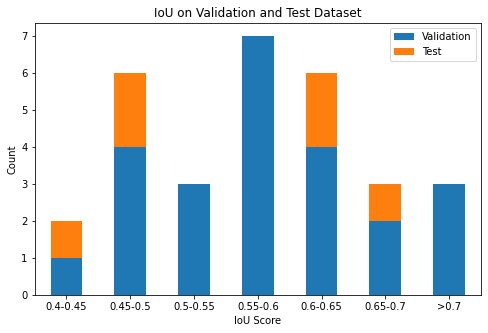

In [ ]:
import matplotlib.pyplot as plt

iou_df.plot.bar(rot=0, stacked=True, figsize=(8, 5))
plt.xlabel("IoU Score")
plt.ylabel("Count")
plt.title("IoU on Validation and Test Dataset")

# Visualized Results

In [ ]:
import matplotlib.patches as patches

def plot_image_trajectory(evaluator, agents, plot_img_idx = list(range(24)), plot_frame=None, train_mode=True, plot_type = "image", plot_dim = None):
    agents.q_network.train(False)
    epoch_ious = []
    totol_rewards = 0
    for k in plot_img_idx:

        print(f"Image id: {k}")

        if plot_type == "image":
          (rewards, start_dists, q_values, info, figs) = evaluator.plot_one_episode(img_id=k, plot_frames=plot_frame, train_mode=train_mode)
        elif plot_type == "gif":
          (rewards, start_dists, q_values, info, anim) = evaluator.plot_one_episode_gif(img_id=k, plot_frame=plot_frame, train_mode=train_mode, plot_dim = plot_dim)
        # (rewards, start_dists, q_values, info) = evaluator.plot_one_episode(img_id=k, plot_frame=plot_frame, train_mode=train_mode)

        epoch_ious.append(info['iou_score'])
        print(f"Terminal iou score {info['iou_score']}")
        print(f"Current image rewards {rewards}")
        totol_rewards += rewards

        return figs if plot_type == "image" else anim


In [ ]:
class Evaluator(object):
    def __init__(self, environment, agents, max_steps, logger = None):
        self.env = environment
        self.agents = agents
        self.logger = logger
        self.max_steps = max_steps

    def play_n_episodes(self, render=False):
        """
        wraps play_one_episode, playing a single episode at a time and logs
        results used when playing demos.
        """
        self.model.train(False)
        headers = ["number"] + ["Filename", "Agent pos x", "Agent pos y",
            "Agent pos z", "Landmark pos x", "Landmark pos y",
            "Landmark pos z", "Distance"]
        self.logger.write_locations(headers)
        distances = []
        for k in range(self.env.files.num_files):
            score, start_dists, q_values, info = self.play_one_episode(render)
            # TODO add to board?
            # self.logger.add_distances_board(start_dists, info, k)
            row = [k + 1] + [info[f"filename"], info[f"agent_xpos"], info[f"agent_ypos"],
                             info[f"agent_zpos"], info[f"landmark_xpos"], info[f"landmark_ypos"],
                             info[f"landmark_zpos"], info[f"distError"]]
            distances.append(info[f"distError"])
            self.logger.write_locations(row)
        # self.logger.log(f"mean distances {np.mean(distances, 0)}")
        # self.logger.log(f"Std distances {np.std(distances, 0, ddof=1)}")

    def play_one_episode(self, img_id, render=False, frame_history=4):

        obs_stack = self.env.reset(id = img_id)
        sampled_files = self.env.files.sample_circular(id = img_id)

        # Here obs have shape (agent, *image_size, frame_history)
        sum_r = 0
        isOver = False
        start_dists = None
        steps = 1
        terminal_iou = 0
        while steps < self.max_steps + 1 and (terminal_iou < config.validate_terminal_iou):

            acts, q_values = self.agents.get_greedy_actions(obs_stack)
            obs_stack, r, isOver, info = self.env.step(acts, q_values)

            steps += 1
            # if render
            if start_dists is None:
                start_dists = info['init_iou']
                print(f"Initial IOU: {info['init_iou']}")
            #     self.env.render()
            if not isOver:
                sum_r += r

        return sum_r / steps, start_dists, q_values, info

    def plot_one_episode(self, img_id, render=False, frame_history=4, plot_frames = [256, 256, 100], train_mode=True, figs = [plt.figure(figsize=(15, 25)), plt.figure(figsize=(15, 25)), plt.figure(figsize=(15, 25))]
):
        # file_name = train_file_dict[img_id] if train_mode else test_file_dict[img_id]

        obs_stack = self.env.reset(id = img_id)
        sampled_files = self.env.files.sample_circular(id = img_id)
        # Here obs have shape (agent, *image_size, frame_history)
        sum_r = 0
        isOver = False
        start_dists = None
        steps = 1
        terminal_iou = 0
        action_dict = env.get_action_meanings()

        # if plot_xy:
        #   fig = plt.figure(figsize=(15, 25))
        # else:
        while steps < self.max_steps + 1 and (terminal_iou < config.validate_terminal_iou):

            acts, q_values = self.agents.get_greedy_actions(obs_stack)
            obs_stack, r, isOver, info = self.env.step(acts, q_values)

            xt_1, xt_2 = info[f"landmark_xpos"]
            yt_1, yt_2 = info[f"landmark_ypos"]
            zt_1, zt_2 = info[f"landmark_zpos"]
            xa_1, xa_2 = info[f"agent_xpos"]
            ya_1, ya_2 = info[f"agent_ypos"]
            za_1, za_2 = info[f"agent_zpos"]

            ncol = 3
            nrow = math.ceil(self.max_steps / ncol)

            # if plot_xy:
            #   ax = fig.add_subplot(nrow, ncol, steps)
            #   ax.imshow(sampled_files[0][0, :, :, plot_z_frame], cmap='gray', interpolation=None)

            #   #add rectangle to plot
            #   ax.add_patch(patches.Rectangle((xt_1, yt_1), xt_2 - xt_1, yt_2 - yt_1 , linewidth=1.5, linestyle='-', edgecolor='g', facecolor='none'))
            #   ax.add_patch(patches.Rectangle((xa_1, ya_1), xa_2 - xa_1, ya_2 - ya_1 , linewidth=1.5, linestyle='-.', edgecolor='r', facecolor='none'))
            #   ax.set_title(f"[{steps}] Action: {action_dict[acts.item()]}, IoU: {round(info['iou_score'], 3)}")


            ax = figs[0].add_subplot(nrow, ncol, steps)
            ax.imshow(sampled_files[0][0, :, :, plot_frames[2]].T, cmap='gray', interpolation=None)
            #add rectangle to plot
            ax.add_patch(plt.Rectangle(( xt_1, yt_1), xt_2 - xt_1, yt_2 - yt_1,  linewidth=2, linestyle='-', edgecolor='g', facecolor='none'))
            ax.add_patch(patches.Rectangle((xa_1, ya_1), xa_2 - xa_1, ya_2 - ya_1, linewidth=2, linestyle='-.', edgecolor='r', facecolor='none'))
            ax.set_title(f"[{steps}] Action: {action_dict[acts.item()]}, IoU: {round(info['iou_score'], 3)}")

            ax = figs[1].add_subplot(nrow, ncol, steps)
            ax.imshow(sampled_files[0][0, :, plot_frames[1], :].T, cmap='gray', interpolation=None)
            #add rectangle to plot
            ax.add_patch(patches.Rectangle((xt_1, zt_1), xt_2 - xt_1, zt_2 - zt_1, linewidth=2, linestyle='-', edgecolor='g', facecolor='none'))
            ax.add_patch(patches.Rectangle((xa_1, za_1), xa_2 - xa_1, za_2 - za_1, linewidth=2, linestyle='-.', edgecolor='r', facecolor='none'))
            ax.set_title(f"[{steps}] Action: {action_dict[acts.item()]}, IoU: {round(info['iou_score'], 3)}")
            ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

            ax = figs[2].add_subplot(nrow, ncol, steps)
            ax.imshow(sampled_files[0][0, plot_frames[0],:, :].T, cmap='gray', interpolation=None)
            #add rectangle to plot
            ax.add_patch(patches.Rectangle((yt_1, zt_1), yt_2 - yt_1, zt_2 - zt_1, linewidth=2, linestyle='-', edgecolor='g', facecolor='none'))
            ax.add_patch(patches.Rectangle((ya_1, za_1), ya_2 - ya_1, za_2 - za_1, linewidth=2, linestyle='-.', edgecolor='r', facecolor='none'))
            ax.set_title(f"[{steps}] Action: {action_dict[acts.item()]}, IoU: {round(info['iou_score'], 3)}")
            ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')


            steps += 1
            # if render
            if start_dists is None:
                start_dists = info['init_iou']
                print(f"Initial IOU: {info['init_iou']}")
            #     self.env.render()
            if not isOver:
                sum_r += r
        for fig in figs:
          fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
          fig.suptitle(f"Trajectory, Target: ([{xt_1}, {yt_1}, {zt_1}], [{xt_2}, {yt_2}, {zt_2}]), Predict: ([{xa_1}, {ya_1}, {za_1}], [{xa_2}, {ya_2}, {za_2}])", fontsize=16)
          fig.subplots_adjust(top=0.95)

        return sum_r / steps, start_dists, q_values, info, figs

    def plot_one_episode_gif(self, img_id, render=False, frame_history=4, plot_frame = 100 , train_mode=True, plot_dim = "xy"):

        obs_stack = self.env.reset(id = img_id)
        sampled_files = self.env.files.sample_circular(id = img_id)

        fig, ax = plt.subplots()
        fig.set_dpi(100)
        fig.set_size_inches(7, 6.5)


        # file_name = train_file_dict[img_id] if train_mode else test_file_dict[img_id]

        x1_pos, y1_pos, x2_pos, y2_pos, z1_pos, z2_pos, xt_1, xt_2, yt_1, yt_2, zt_1, zt_2, action_history, iou_history, reward_per_step, start_dists, q_values, info = self._collect_trajectory(img_id = img_id)

        if plot_dim == "xy":
          # ax = plt.axes(xlim=(0, 512), ylim=(0, 512))
          ax.imshow(sampled_files[0][0, :, :, plot_frame].T, cmap='gray', interpolation=None)
          ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
          target_patch = plt.Rectangle(( xt_1, yt_1,), xt_2 - xt_1, yt_2 - yt_1,  linewidth=2, linestyle='-', edgecolor='r', facecolor='none')
          patch = plt.Rectangle(( xt_1, yt_1,), xt_2 - xt_1, yt_2 - yt_1,  linewidth=2, linestyle='-', edgecolor='g', facecolor='none')
          ax.add_patch(target_patch)
        if plot_dim == "yz":
          # ax = plt.axes(xlim=(0, 512), ylim=(0, 512))
          ax.imshow(sampled_files[0][0, plot_frame, :, :].T, cmap='gray', interpolation=None)
          ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
          target_patch = patches.Rectangle(( yt_1, zt_1,), yt_2 - yt_1, zt_2 - zt_1, linewidth=2, linestyle='-', edgecolor='r', facecolor='none')
          patch = plt.Rectangle(( yt_1,zt_1, ),  yt_2 - yt_1, zt_2 - zt_1,linewidth=2, linestyle='-', edgecolor='g', facecolor='none')
          ax.add_patch(target_patch)
        if plot_dim == "xz":
          # ax = plt.axes(xlim=(0, 512), ylim=(0, 512))

          ax.imshow(sampled_files[0][0,  :,plot_frame,  :].T, cmap='gray', interpolation=None)
          ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
          target_patch = patches.Rectangle((xt_1, zt_1, ),  xt_2 - xt_1, zt_2 - zt_1 ,linewidth=2, linestyle='-', edgecolor='r', facecolor='none')
          patch = plt.Rectangle((xt_1, zt_1, ),  xt_2 - xt_1, zt_2 - zt_1 , linewidth=2, linestyle='-', edgecolor='g', facecolor='none')
          ax.add_patch(target_patch)


        def init():
            if plot_dim == "xy":
              x = xt_1
              y = yt_1
              w =xt_2 - xt_1
              h = yt_2 - yt_1
            if plot_dim == "yz":
              x = yt_1
              y = zt_1
              w = yt_2 - yt_1
              h = zt_2 - zt_1
            if plot_dim == "xz":
              x = xt_1
              y = zt_1
              w = xt_2 - xt_1
              h = zt_2 - zt_1

            patch.xy= (x, y)
            patch.width = w
            patch.height = h
            ax.add_patch(patch)
            return patch,

        def animate(i):
            if plot_dim == "xy":
              x = x1_pos[i]
              y = y1_pos[i]
              w = x2_pos[i] - x1_pos[i]
              h = y2_pos[i] - y1_pos[i]
            if plot_dim == "yz":
              x = y1_pos[i]
              y = z1_pos[i]
              w = y2_pos[i] - y1_pos[i]
              h = z2_pos[i] - z1_pos[i]
            if plot_dim == "xz":
              x = x1_pos[i]
              y = z1_pos[i]
              w = x2_pos[i] - x1_pos[i]
              h = z2_pos[i] - z1_pos[i]

            patch.xy= (x, y)
            patch.width = w
            patch.height = h

            ax.set_title(f"[{i}] Action: {action_history[i]}, IoU: {iou_history[i]}")
            return patch,

        anim = animation.FuncAnimation(fig, animate,
                                      init_func=init,
                                      frames=len(x1_pos),
                                      interval=1200,
                                      blit=True)

        # plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        # plt.suptitle(f"Trajectory, Target: ([{xt_1}, {yt_1}, {zt_1}], [{xt_2}, {yt_2}, {zt_2}]), Predict: ([{xa_1}, {ya_1}, {za_1}], [{xa_2}, {ya_2}, {za_2}])", fontsize=16)
        # plt.subplots_adjust(top=0.95)

        return reward_per_step, start_dists, q_values, info, anim

    def _collect_trajectory(self, img_id = 21):
     # Here obs have shape (agent, *image_size, frame_history)
        obs_stack = self.env.reset(id = img_id)
        sampled_files = self.env.files.sample_circular(id = img_id)
        sum_r = 0
        isOver = False
        start_dists = None
        steps = 1
        terminal_iou = 0
        action_dict = self.env.get_action_meanings()

        x1_pos = []
        y1_pos = []
        x2_pos = []
        y2_pos = []
        z1_pos = []
        z2_pos = []
        action_history = []
        iou_history = []

        while steps < self.max_steps + 1 and (terminal_iou < config.validate_terminal_iou):

            acts, q_values = self.agents.get_greedy_actions(obs_stack)
            obs_stack, r, isOver, info = self.env.step(acts, q_values)

            xt_1, xt_2 = info[f"landmark_xpos"]
            yt_1, yt_2 = info[f"landmark_ypos"]
            zt_1, zt_2 = info[f"landmark_zpos"]

            xa_1, xa_2 = info[f"agent_xpos"]
            ya_1, ya_2 = info[f"agent_ypos"]
            za_1, za_2 = info[f"agent_zpos"]

            x1_pos.append(xa_1)
            y1_pos.append(ya_1)
            z1_pos.append(za_1)
            x2_pos.append(xa_2)
            y2_pos.append(ya_2)
            z2_pos.append(za_2)

            action_history.append(action_dict[acts.item()])
            iou_history.append(round(info['iou_score'], 3))

            steps += 1
            # if render
            if start_dists is None:
                start_dists = info['init_iou']
                print(f"Initial IOU: {info['init_iou']}")
            #     self.env.render()
            if not isOver:
                sum_r += r

        return x1_pos, y1_pos, x2_pos, y2_pos, z1_pos, z2_pos, xt_1, xt_2, yt_1, yt_2, zt_1, zt_2, action_history, iou_history, sum_r / steps, start_dists, q_values, info

<Figure size 1080x1800 with 0 Axes>

<Figure size 1080x1800 with 0 Axes>

<Figure size 1080x1800 with 0 Axes>

## Visualize Train

In [ ]:
# logger = prepare_logger()

env = MedicalPlayer(train_mode = True, screen_dims=tuple(config.screen_dims),
                 history_length= config.history_length, action_step_ratio=config.action_step_ratio, min_action_len=config.min_action_len,
                 reward_method=config.reward_method, oscillations_allowed=4, logger=None, id = None)
wrapped_env = FrameStack(env, k=config.history_length)
agents = Agents(config.num_actions, config.history_length, config.max_memory_size, tuple(config.screen_dims))

config.load_model_path = "/content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_46_26/best_dqn.pt"

agents.load_model(config.load_model_path)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-6-1ba57a94a3e5>:51: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(module.weight)


Load model weight from /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_46_26/best_dqn.pt


In [ ]:
evaluator = Evaluator(wrapped_env, agents, max_steps = config.max_steps)

plot_image_idx = [21]
max_steps = 15

figs = plot_image_trajectory(evaluator, agents, plot_image_idx, plot_frame=[130, 285, 121], train_mode=True, plot_type = "image")

Image id: 21


TypeError: ignored

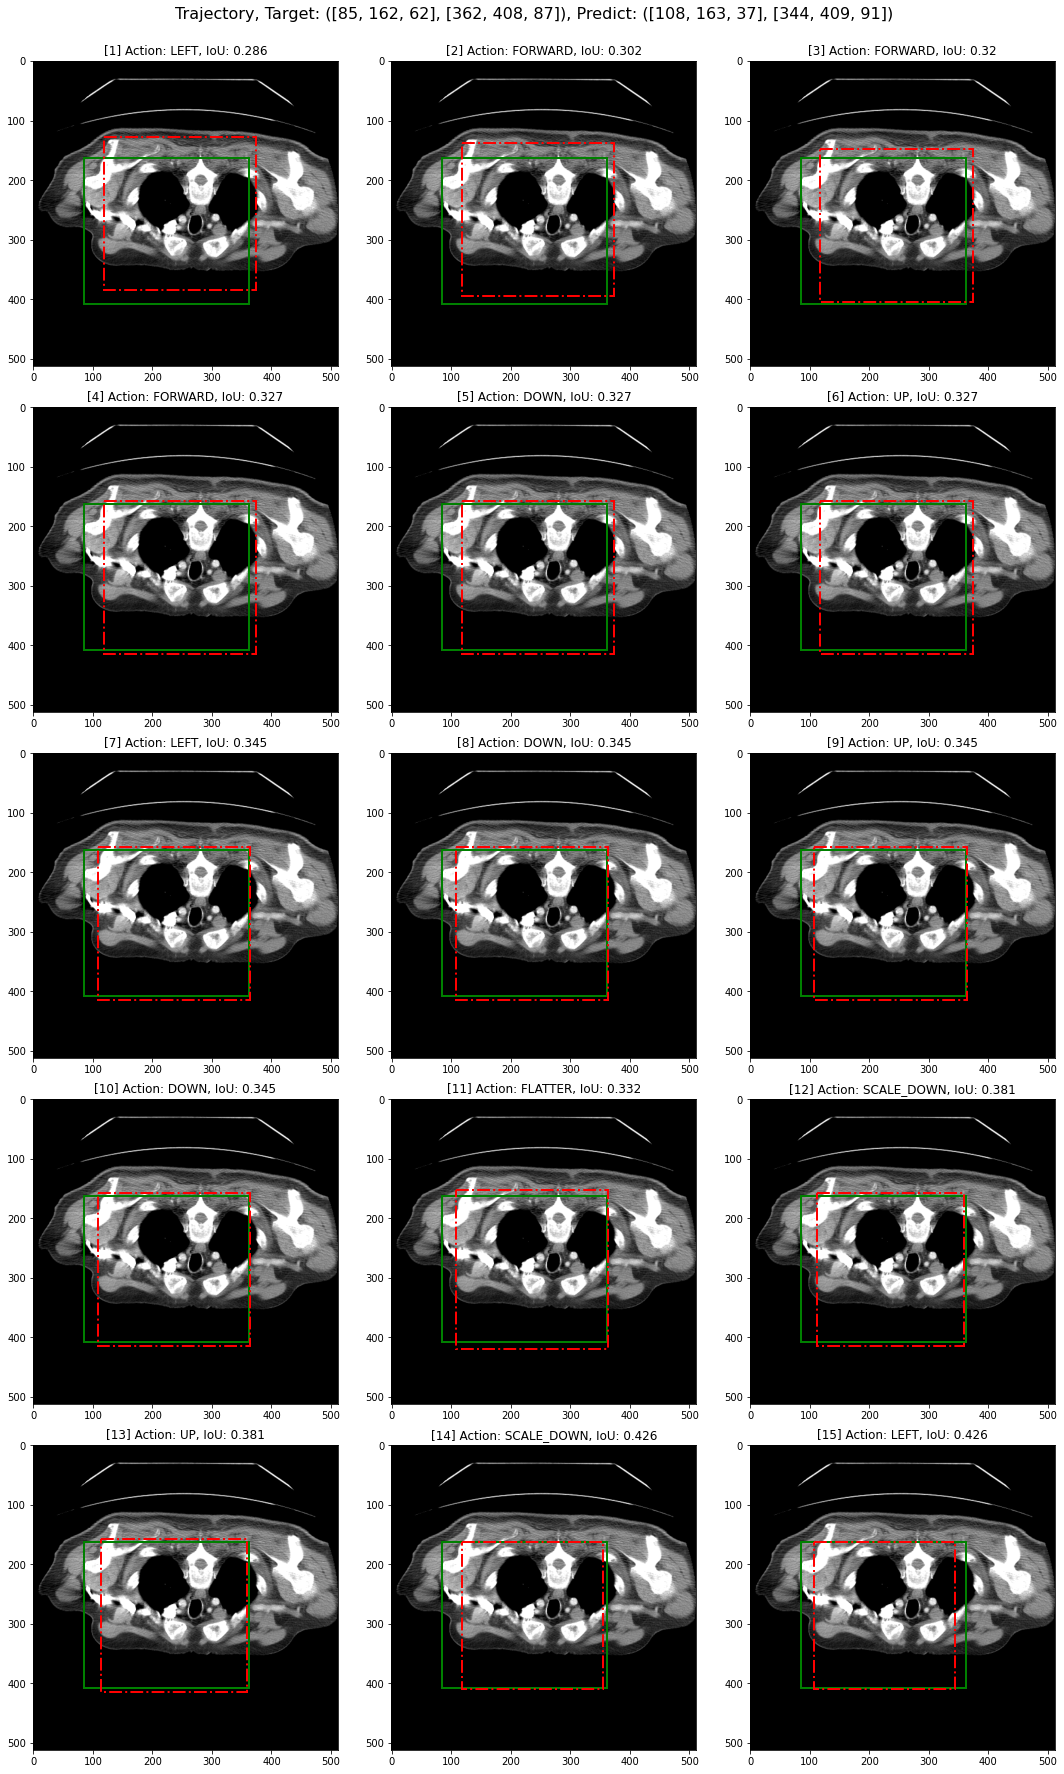

In [ ]:
figs[0]

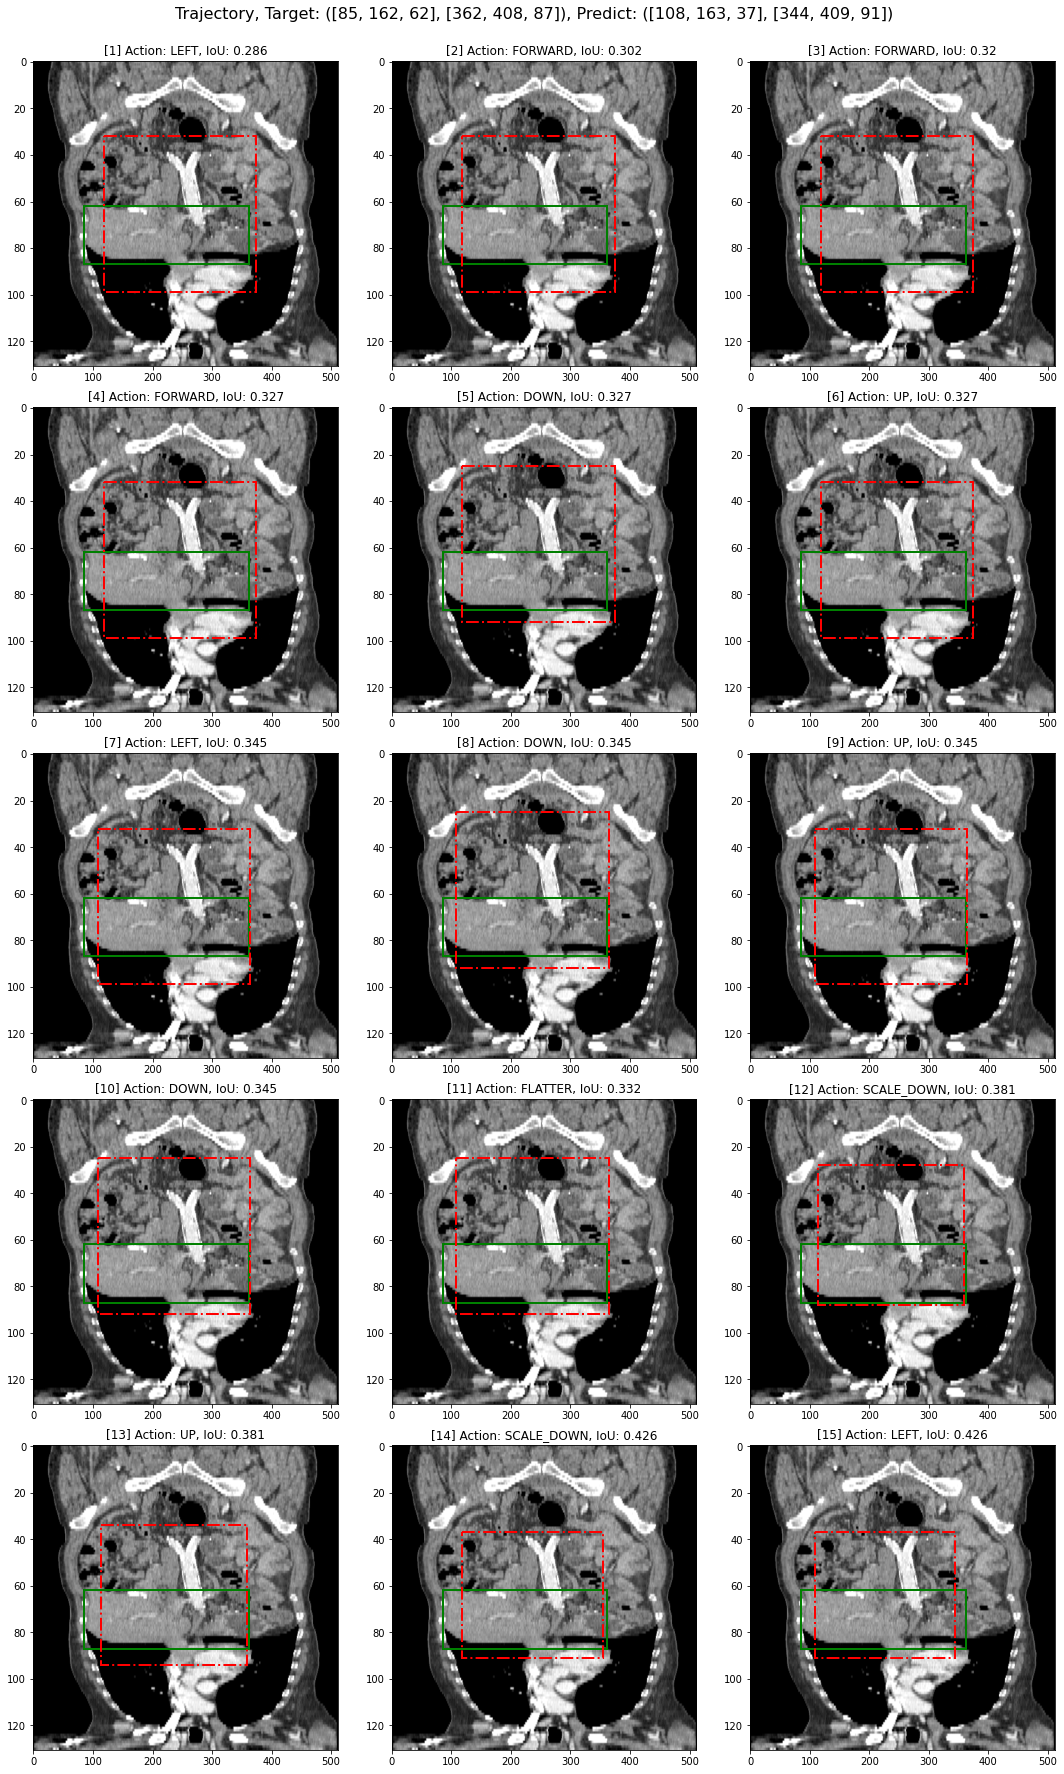

In [ ]:
figs[1]

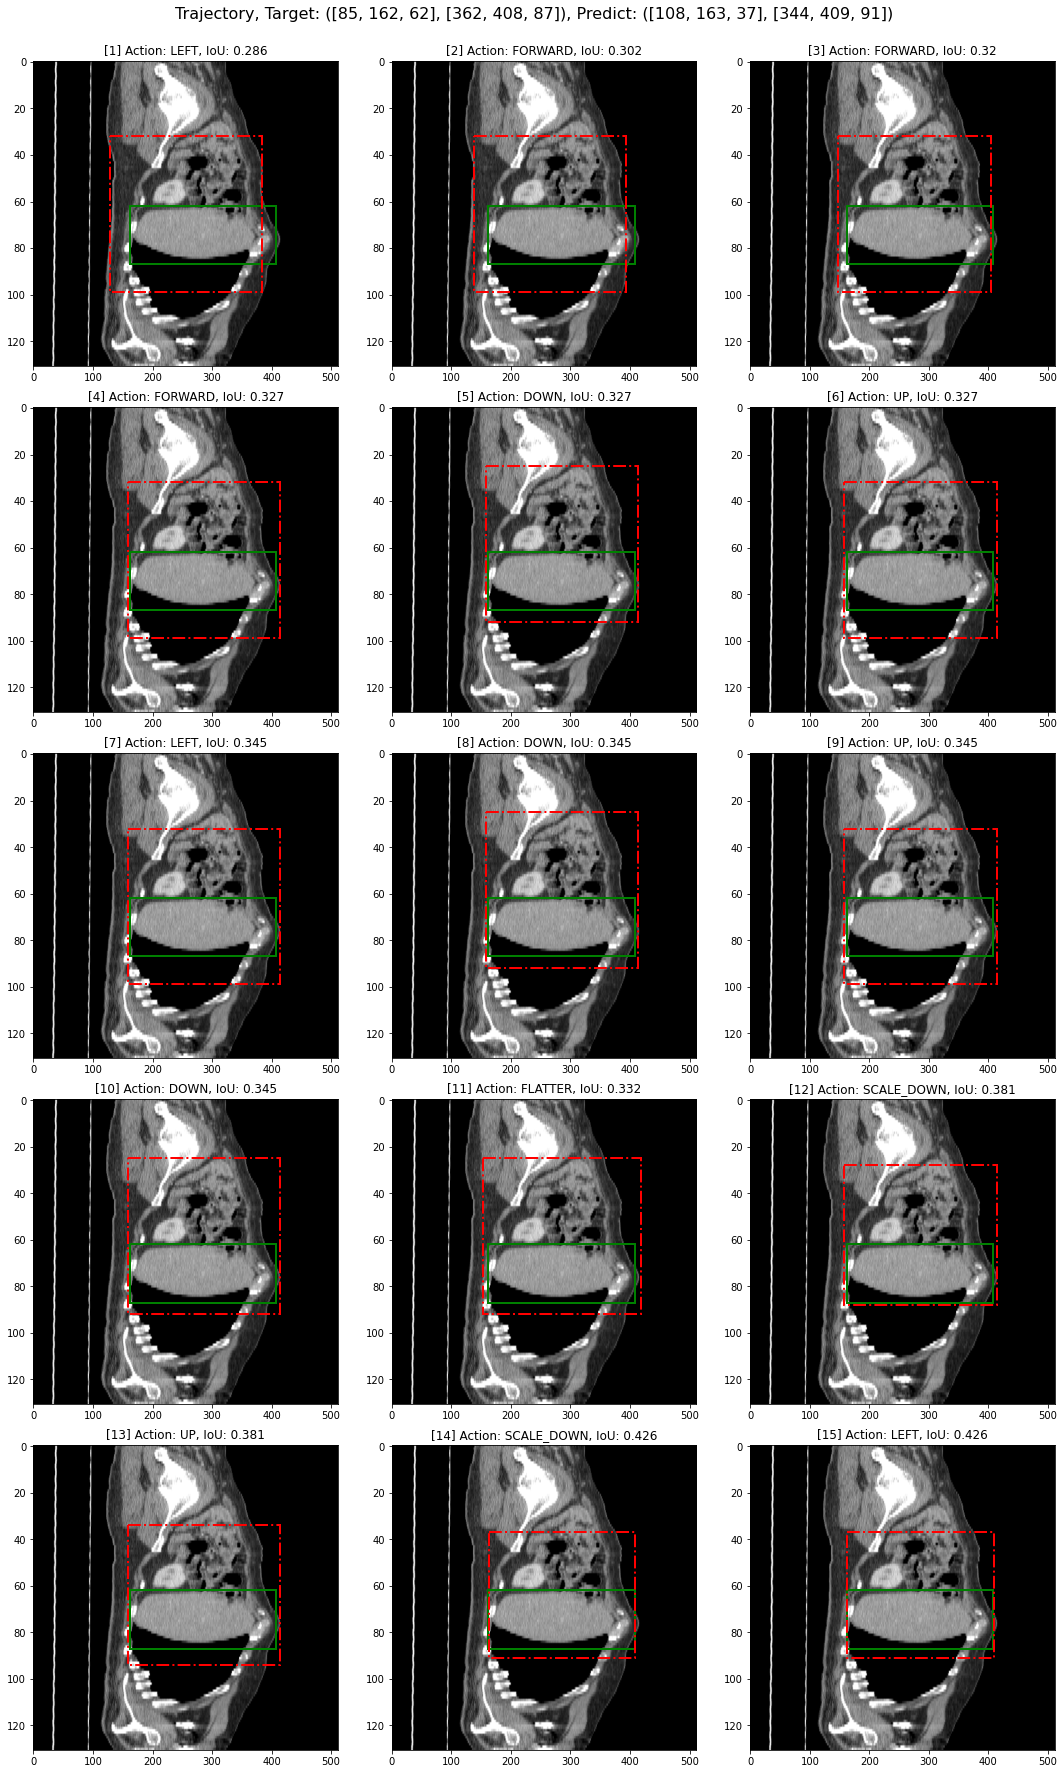

In [ ]:
figs[2]

Image id: 15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Initial IOU: 0.2708015952417989
Terminal iou score 0.4260148761860189
Current image rewards 0.9700830059013749


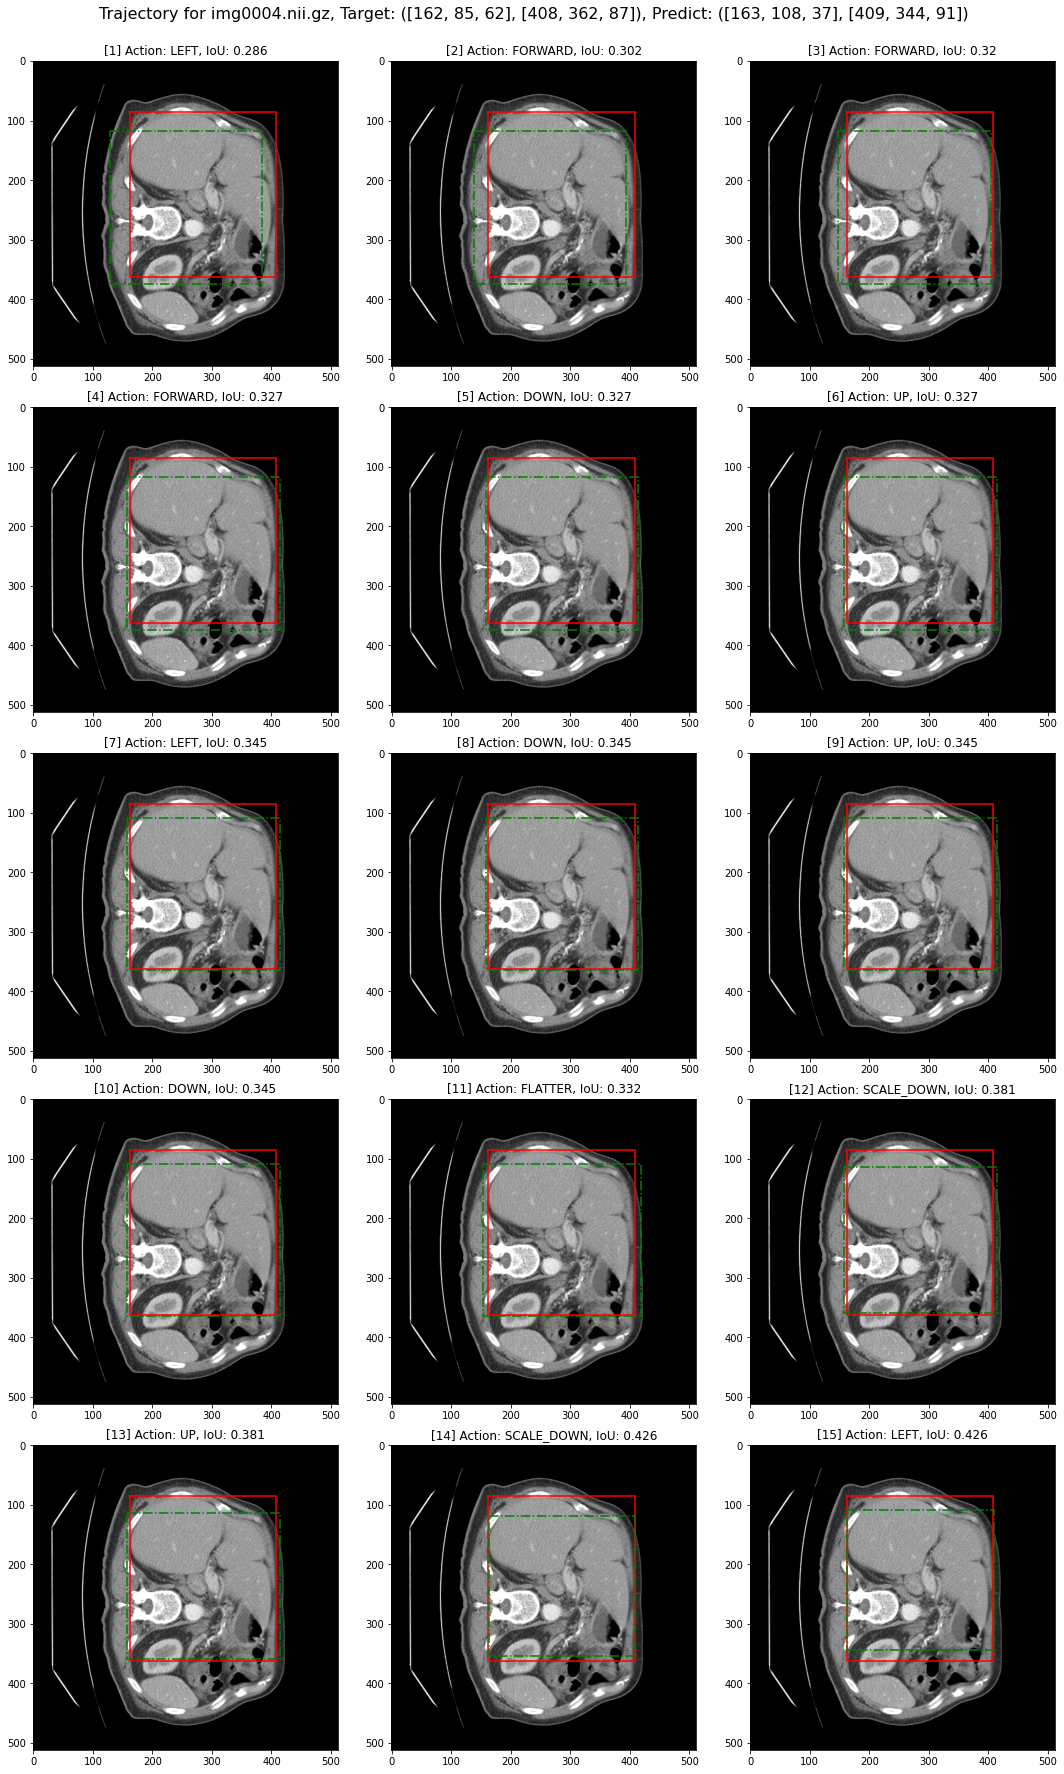

In [ ]:
evaluator = Evaluator(wrapped_env, agents, max_steps = 15)

plot_image_idx = [15]
plot_image_trajectory(evaluator, agents, plot_image_idx, plot_frame=70)

## Visualize Test

In [ ]:
# logger = prepare_logger()

env = MedicalPlayer(train_mode=False, screen_dims=tuple(config.screen_dims),
                 history_length= config.history_length, action_step_ratio=config.action_step_ratio, min_action_len=config.min_action_len,
                 reward_method=config.reward_method, oscillations_allowed=4, logger=None, id = None)
wrapped_env = FrameStack(env, k=config.history_length)
agents = Agents(config.num_actions, config.history_length, config.max_memory_size, tuple(config.screen_dims))

config.load_model_path = "/content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_46_26/best_dqn.pt"

agents.load_model(config.load_model_path)

Load model weight from /content/gdrive/MyDrive/Courses/HDSC 325/Project/model/2022_11_17_06_46_26/best_dqn.pt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Image id: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Initial IOU: 0.21044213932054143
Terminal iou score 0.6912314614893421
Current image rewards 2.3446083544580816


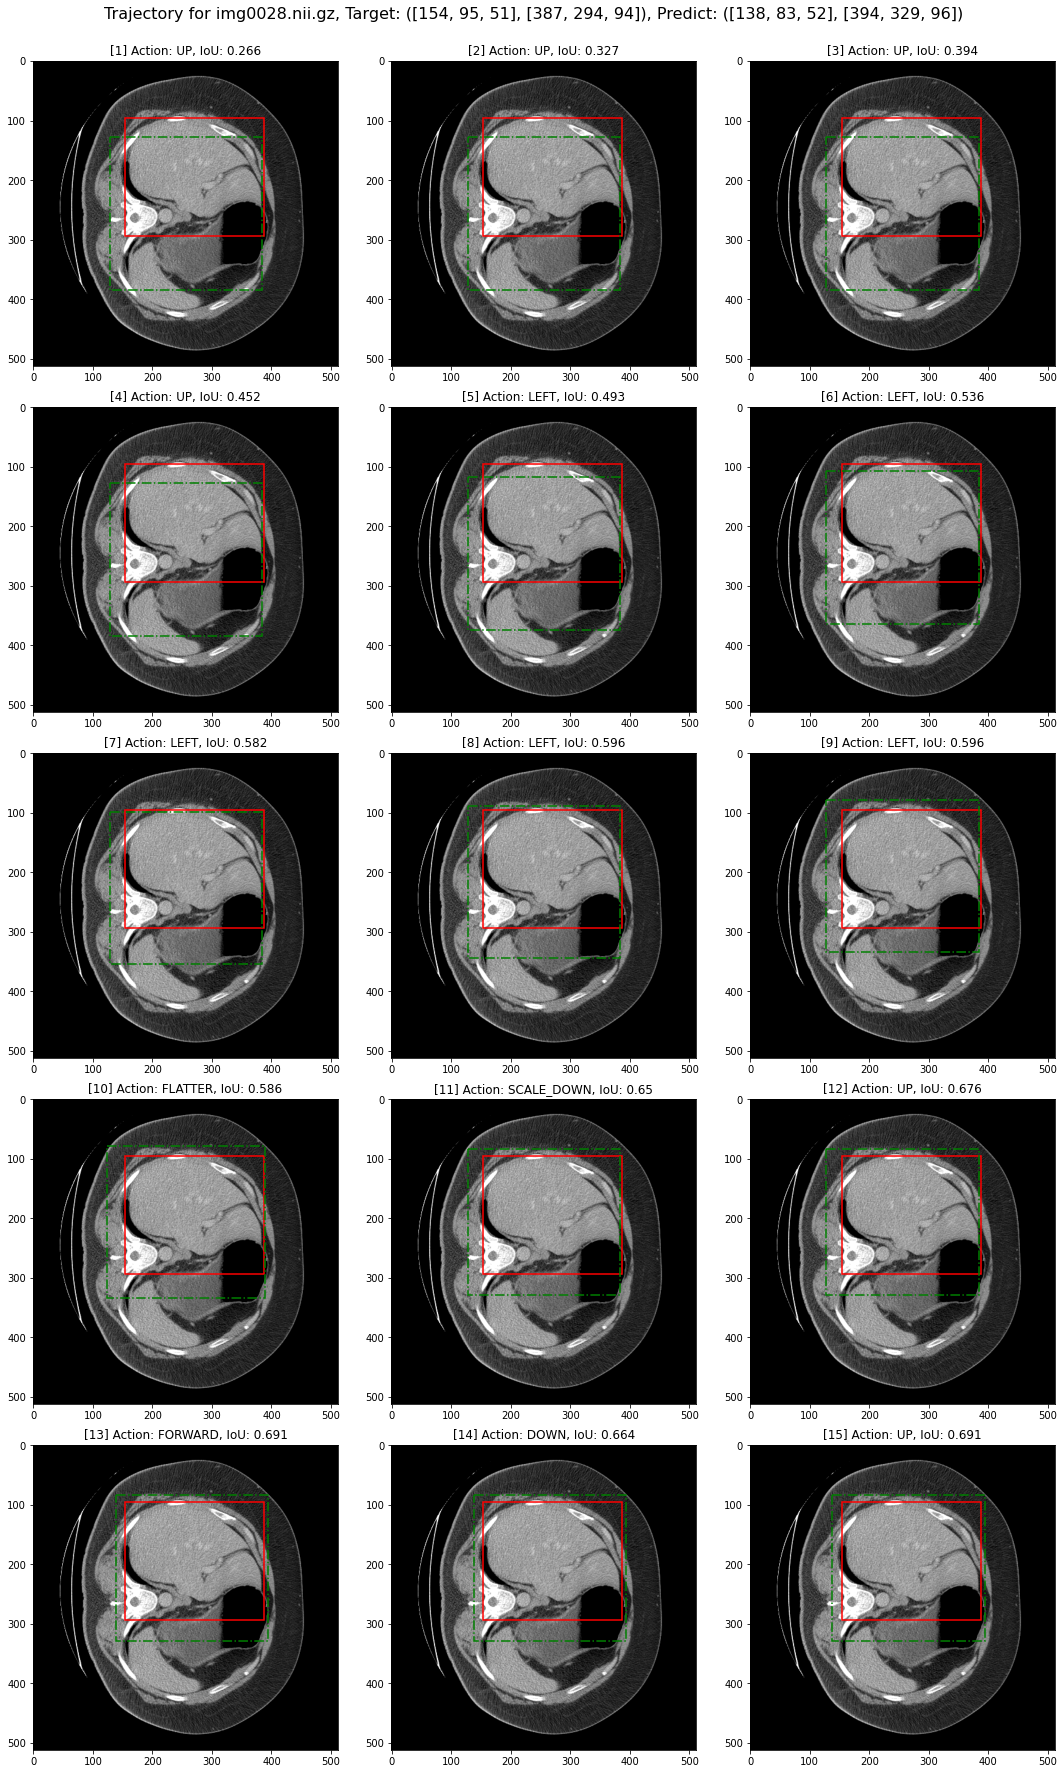

In [ ]:
evaluator = Evaluator(wrapped_env, agents, max_steps = 15)

plot_image_idx = [3]
plot_image_trajectory(evaluator, agents, plot_image_idx, plot_frame=80, train_mode=False)

In [ ]:
(rewards, start_dists, q_values, info) = evaluator.play_one_episode(img_id=21)
predict_box = get_predict_bounding_box(info)
predict_box

/usr/local/lib/python3.7/dist-packages/nibabel/wrapstruct.py:212: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return self._structarr.tostring()
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommen

Initial IOU: 0.2261780655035592


((83, 143, 74), (329, 389, 140))

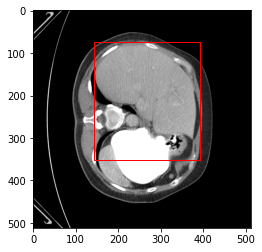

In [ ]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(image[0, :, :, 121],cmap='gray', interpolation=None)

# Create a Rectangle patch
rect = patches.Rectangle((143, 75), 392 - 143, 353 - 75, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [ ]:
import os
import nibabel as nib
from nibabel.testing import data_path

example_ni1 = os.path.join(data_path, '/content/gdrive/MyDrive/Courses/HDSC 325/RawData/Training/img/img0032.nii.gz')
n1_img = nib.load(example_ni1).get_fdata()
n1_img

In [ ]:
n1_img.shape

(512, 512, 144)

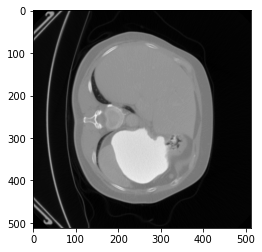

In [ ]:
fig, ax = plt.subplots()
ax.imshow(n1_img[:, :, 121],cmap='gray', interpolation=None)